## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = 13, 10

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Make a list of calibration images
calib_images = glob.glob('./camera_cal/calibration*.jpg')
calib_images[:3]

['./camera_cal/calibration5.jpg',
 './camera_cal/calibration4.jpg',
 './camera_cal/calibration6.jpg']

In [3]:
DISPLAY_CHESSBOARD = False


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for fname in calib_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    #print('ret:', ret)
    
    # If found, add object points, image points
    if ret is True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        if DISPLAY_CHESSBOARD:
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

cv2.destroyAllWindows()

In [4]:
print("The chessboard was found on {} out of {} calibration images.".format(len(imgpoints), len(calib_images)))

The chessboard was found on 17 out of 20 calibration images.


In [5]:
#Camera calibration matrices
img_ = cv2.imread(calib_images[0])
img_size = img.shape[1], img.shape[0]
%xdel img_
print("img_size:", img_size)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

img_size: (1280, 720)


###  Examples of undistorted calibration images

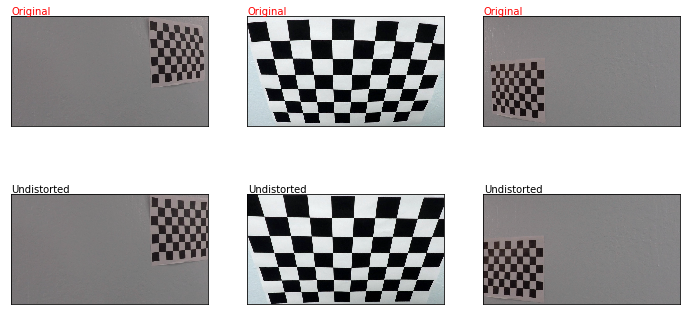

In [6]:
N_IMGS = 3
ls_imgs = np.random.choice(np.arange(len(calib_images)), size = N_IMGS, replace=False)

NR = 2 #number of rows for display : one for the normal images, one for the flipped versions
_, ax = plt.subplots(NR, N_IMGS, figsize=(12, 6))
col, row = 0, 0

for col, idx in enumerate(ls_imgs): 
    img = cv2.imread(calib_images[idx])
    img2 = cv2.undistort(img, mtx, dist, None, mtx)
    
    ax[0, col].imshow(img)
    ax[0, col].text(3, -5, 'Original', fontsize=10, color='red')
    ax[0, col].get_xaxis().set_visible(False)
    ax[0, col].get_yaxis().set_visible(False)

    ax[1, col].imshow(img2)
    ax[1, col].text(4, -5, 'Undistorted', fontsize=10, color='black')
    ax[1, col].get_xaxis().set_visible(False)
    ax[1, col].get_yaxis().set_visible(False)

plt.show()

###  Examples of undistorted test images

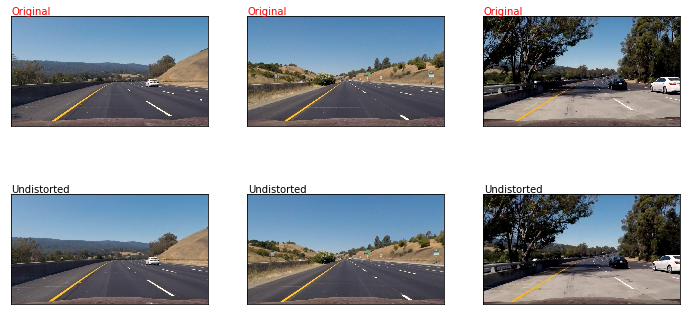

In [7]:
N_IMGS = 3

test_images = glob.glob('./test_images/*.jpg')
ls_imgs = np.random.choice(np.arange(len(test_images)), size = N_IMGS, replace=False)

NR = 2 #number of rows for display : one for the normal images, one for the flipped versions
_, ax = plt.subplots(NR, N_IMGS, figsize=(12, 6))
col, row = 0, 0

for col, idx in enumerate(ls_imgs): 
    img = cv2.imread(test_images[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img2 = cv2.undistort(img, mtx, dist, None, mtx)
    
    ax[0, col].imshow(img)
    ax[0, col].text(3, -5, 'Original', fontsize=10, color='red')
    ax[0, col].get_xaxis().set_visible(False)
    ax[0, col].get_yaxis().set_visible(False)

    ax[1, col].imshow(img2)
    ax[1, col].text(4, -5, 'Undistorted', fontsize=10, color='black')
    ax[1, col].get_xaxis().set_visible(False)
    ax[1, col].get_yaxis().set_visible(False)
    
plt.show()

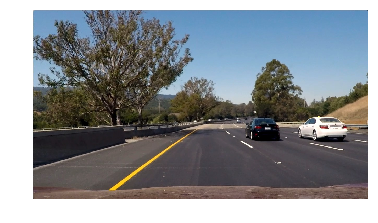

In [8]:
# we read an image
##interesting ones: 4
INDEX = 0

image = cv2.imread(test_images[INDEX])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image) 
plt.axis('off');

In [9]:
#helpers

undistort_image = lambda img: cv2.undistort(img, mtx, dist, None, mtx)

def gaussian_blur(img, kernel=5):
    return cv2.GaussianBlur(img, (kernel,kernel), 0)

## We can see that the original and the undistorted images do not coincide

In [10]:
image_ud = undistort_image(image)

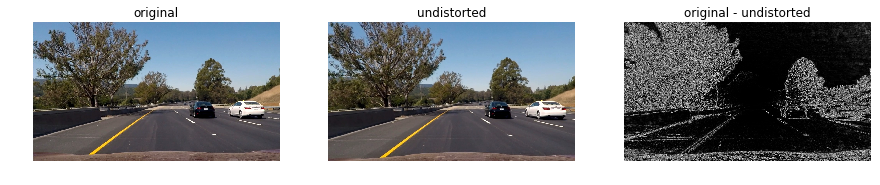

In [11]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off');
plt.title('original')

plt.subplot(1,3,2)
plt.imshow(image_ud)
plt.title('undistorted')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(np.sum((image-image_ud)**2,axis=2), cmap='gray')
plt.title('original - undistorted')
plt.axis('off');

In [12]:
#We work with the undistorted image from now on
image = image_ud

img_size = image.shape
img_size

(720, 1280, 3)

### We compute the coordinates of points of interest for a trapezoidal shape: top, bottom, center, left center, etc.:


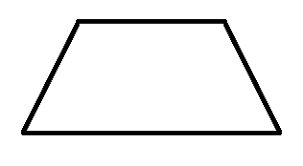

In [13]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAS8AAACmCAMAAAC8yPlOAAAAb1BMVEX///8AAACsrKzS0tIUFBQ7Ozv7+/uNjY3FxcXx8fHj4+P4+Pi+vr7CwsL8/PxZWVliYmLb29tpaWl4eHiGhoYwMDCfn59ycnKzs7NMTEympqZCQkLo6OhTU1MfHx+AgIA4ODgYGBgkJCSWlpYrKysMhfWoAAAFD0lEQVR4nO2c7XqiMBCFRaWKqFRbql21fvX+r3HlxD7dVVADSWYG5/2vHCYDCZM56XQURVEURVEURVEURVEURVEURRizqM+PaEYdlipmEU+4BkzjZUePOjAV9KgDU86o0PYV8+KrEDWiDk0pw0LakVrFBcdC1JBaRRkJcn9ALeOCAVQl1DJKmBTC8iW1jAuWeSFrQi3jmhQD+U4t44p36EqpZVyxLGTFY2oZV4zjQhi3tO90MIxv1CpKeIMyahWX/ClErThORMNVIe0PtYwLMIhzahWlzBkmGKbtFc+FdG/Fb6GDIcyoVVSQsUuwLdKL63ftDAm2pZbxDxjAFbWKSlbMEgxv1N2aWkYl6x2v2QjDl1OruEHOKsHwPs35fXL8kuac5qPvQkyfWsVN+oXEb2oVBrxN99Qq7rDnMyNxm31K4TODxxLCdQ5YTK3ixGch5ECt4i6HQuYntYpOZyMjvc4JtqFWkWzYvBjugNfshrqS/yolvc4J9kqrYZ0xEPEgGNqM9qttISe9zgm2oFQwy7hW7ctAJT+jrDqh7hW9ECqw4SUiroP1MDkOxMQLVfMNXdWc72Z7OcQtC0Ms7T84F3L+J/3AIp9q1w+9LxHfsuo1aygm6iEyG6FdOel1SrAu4bYytrTZNjuWY1pGSTa7J6jxLqVMjoYXtMXkFP1NuDLX3tBKTI8tQbvOGCVxfv1L9xhjsyG8blyXZ2foTdBlG36cTbgY9jneZUISsInweAVWPhQbrp+AhX2TyH0cSR5IslnZCcFXQlNc8Vtmep0SDA0My2mwC5qvim6w67mmG/ZLzny1xvLWXj8M46CVAhjRoo9AV/MB6mChbGvEVTcXBK10JpRFN0ccw1XSU+pdAxecd2pCJBhXI5odwWxr0y35rqcLzE7zNkC1EwMjZUu7mlC2NfTaZzwd5DaMkGD+e/KjMJfxTxjbGhYumZwt7WoSJJjvDk0MCpfG/2aEsK3hy34T7sveJ1OswfyaGDAkErpVH8G/cSAK8ciH49N3wFqVXv4TDH+/8/f/wdl5Ddj00J7J0YA3/sHX9IVwfXn6cxpw3JUnM886b8vS/hcs8nM/LX9CjGh24J682NZmiBenUwlcgOpU7KM6JcaIZgfuyoNtjeOpKi7wdZKNICOaHbgv544x0wwtec+xCuwOOm+ZFmVEswN35ti2xvVUOxf4OElQlhHNDg+2NXMqp7xm6MdA85/Tk1ClGdHscG5b6+JLW3KDyW3QjXtw188mz4hmh2PbmmnHk91gchvTj+sqwSQa0exwaltrf7jcBixwdywJDjuYnyFcLgOGx3Hf5rd9QW+PB7L51se49ZOjwUyRjT9hTDP07gnihb3Ixi3Tko1odjixrSVY2n+2P71OCYZuimOzj2TZRjQ7HNjWEhQmxDdDP4ZpmR40STDpRjQ7Gq80E5RV58+RXqfsQHfAtn6CyTei2dHQtpZgU2guv9f+UUZIsEXdBGuDEc2ORrY106C+aG9Z9Zo1nqia9oJ2GNHsaGBbS7FFu5B0HFpzUiRYXOumEWr5RjQ76tvW8EPS03BJqN0ogt+1q1v1Eera1p40XLUDpvGyAj+ScU67a+p0UqZPOTka3mqswfCT9hjR7LC3raEw0X+upf0v733bMgUCvBv1npORtW0NNqQnx8ZYpvGyixe1VhZYxKtLrZUBVrs8XcUmXIqiKIqiKIqiKIqiKIqiKIqiKIqiKIqiKIqiuOAvzYo1Hpr3OMoAAAAASUVORK5CYII=")

In [14]:
ytop = int(img_size[0] * .66)    #top
ybottom = img_size[0]            #bottom

width_div2 = img_size[1]//2     #width divided by 2
xc_window = width_div2          #center


xtopleft = xc_window - .23 * width_div2
xtopright = xc_window + .23 * width_div2

xbottomleft = xc_window - .96 * width_div2
xbottomright = xc_window + .96 * width_div2

### We compute the perspective transform matrix:

In [15]:
src = np.float32([ [xbottomleft, ybottom],
                  [xbottomright, ybottom],
                  [xtopright, ytop],
                  [xtopleft, ytop] ])

dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])

M    = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

Let's perform a perspective transform on a sample image

In [16]:
warped = cv2.warpPerspective(image.copy(), M, (img_size[1],img_size[0]))

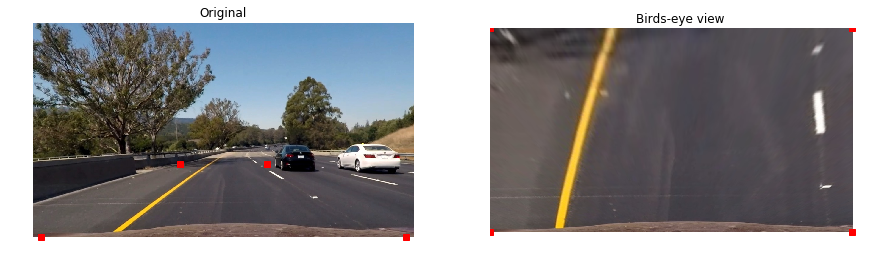

In [17]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(image)
for i in range(4):
    plt.plot(src[i,0], src[i,1],'rs')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(warped)
for i in range(4):
    plt.plot(dst[i,0], dst[i,1],'rs')
    
plt.title('Birds-eye view')
plt.axis('off');

We define a helper with what we saw:

In [18]:
def do_perspective_transform(img):
    
    ALPHA = .23
    BETA = .96
    
    img_size = img.shape
    ytop = int(img_size[0] * .66)    #top
    ybottom = img_size[0]            #bottom

    width_div2 = img_size[1]//2     #width divided by 2
    xc_window = width_div2          #center


    xtopleft = xc_window - ALPHA * width_div2
    xtopright = xc_window + ALPHA * width_div2

    xbottomleft = xc_window - BETA * width_div2
    xbottomright = xc_window + BETA * width_div2
    
    src = np.float32([ [xbottomleft, ybottom],
                  [xbottomright, ybottom],
                  [xtopright, ytop],
                  [xtopleft, ytop] ])

    dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                      [img_size[1],0],[0,0]])

    M    = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img.copy(), M, (img_size[1],img_size[0]))
    
    return warped, M, Minv

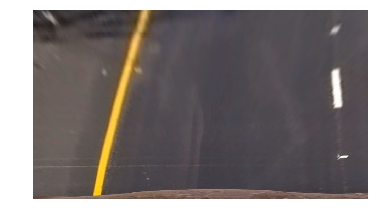

In [19]:
warped, _, _ = do_perspective_transform(image)
plt.imshow(warped) 
plt.axis('off');

## Apply color mask

Next we will apply color masks to identify yellow and white lane markings in the birds-eye view image.

### First, we're going to look for a good yellow mask

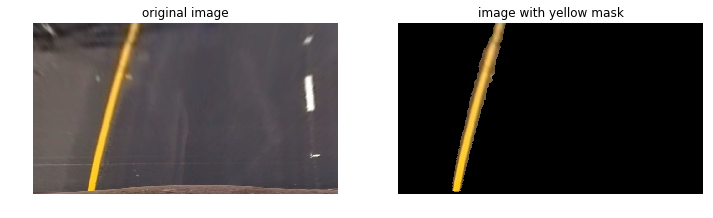

In [20]:
image_HSV = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)

yellow_hsv_low  = np.array([0,  100,  100])
yellow_hsv_high = np.array([90, 255, 255])

yellow_mask = cv2.inRange(image_HSV, yellow_hsv_low, yellow_hsv_high)
res = cv2.bitwise_and(warped, warped, mask=yellow_mask)
#good tuto: https://www.learnopencv.com/color-spaces-in-opencv-cpp-python/

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(res)
plt.title('image with yellow mask')
plt.axis('off');

### Second, we look for a good white mask

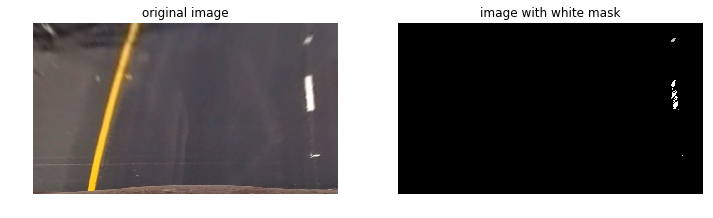

In [21]:
image_HSV = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)

white_hsv_low  = np.array([ 20,   0,   180])
white_hsv_high = np.array([ 255,  80, 255])

white_mask = cv2.inRange(image_HSV, white_hsv_low, white_hsv_high)
res = cv2.bitwise_and(warped, warped, mask=white_mask)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(res)
plt.title('image with white mask')
plt.axis('off');

## Combine color masks
We next combine the yellow and white masks.

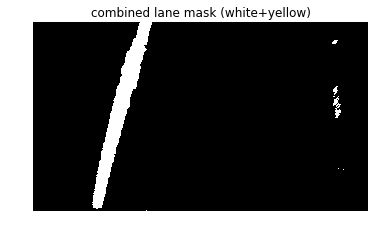

In [22]:
yw_lane_mask = cv2.bitwise_or(white_mask, yellow_mask)

plt.imshow(yw_lane_mask, cmap='gray')
plt.title('combined lane mask (white+yellow)')
plt.axis('off');

In [23]:
yw_lane_mask.max()

255

## Apply Sobel filters

Next we will apply sobel filters to the L and S channels of the image.

We chose L and S channels because in L and S channels, the lanes were more visible.

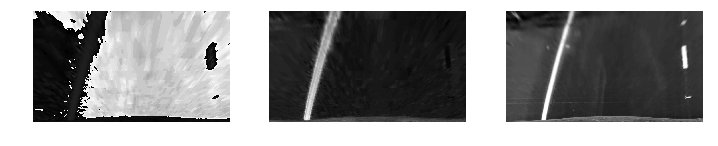

In [24]:
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(image_HSV[:,:,0], cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(image_HSV[:,:,1], cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(image_HSV[:,:,2], cmap='gray')
plt.axis('off');

### We apply sobel filters to L and S channels

In [25]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    assert orient in 'xy'
    
    if orient == 'x':
        img_s = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = np.zeros_like(img_sobel, dtype='uint8')
    #binary_output[thresh[0] <= img_sobel <= thresh[1]] = 1
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 255
    return binary_output

### Experimentation with L channel

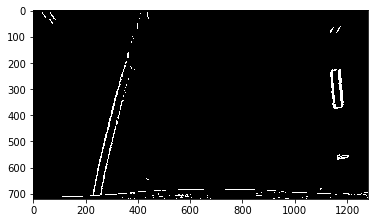

In [26]:
image = gaussian_blur(warped, kernel=5)
image_HLS = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)

img_gs = image_HLS[:,:,1]


img_abs_x = abs_sobel_thresh(img_gs, 'x', 5, (50,225))
img_abs_y = abs_sobel_thresh(img_gs, 'y', 5, (50,225))

wrapped2 = np.copy(cv2.bitwise_or(img_abs_x, img_abs_y))

plt.imshow(wrapped2, cmap='gray');

### Experimentation with S channel

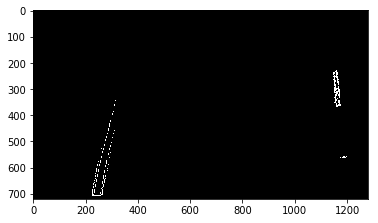

In [27]:
image = gaussian_blur(warped, kernel=5)
image_HLS = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)

img_gs = image_HLS[:,:,2]


#img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
#sobel_c = sobel_combined(img_gs)

img_abs_x = abs_sobel_thresh(img_gs, 'x', 5, (50,225))
img_abs_y = abs_sobel_thresh(img_gs, 'y', 5, (50,225))

wrapped3 = np.copy(cv2.bitwise_or(img_abs_x, img_abs_y))

plt.imshow(wrapped3, cmap='gray');

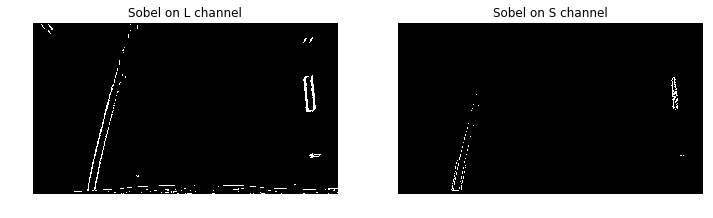

In [28]:
#side by side result

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(wrapped2, cmap='gray')
plt.title('Sobel on L channel')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Sobel on S channel')
plt.imshow(wrapped3, cmap='gray')
plt.axis('off');

### We combine Sobel filters from L and S channels.

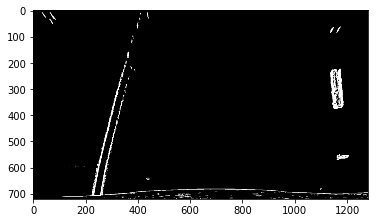

In [29]:
image_cmb = cv2.bitwise_or(wrapped2, wrapped3)

#we add a bit of blur
image_cmb = gaussian_blur(image_cmb, 3)

plt.imshow(image_cmb,cmap='gray')

### We now combine our color masks and sobel filters find the lanes as best as we can

In [30]:
image_cmb_colsob = np.zeros_like(image_cmb)

image_cmb_colsob[(yw_lane_mask == 255) | (image_cmb == 255)] = 1

#We add a bit af gaussian blur
#image_cmb_colsob = gaussian_blur(image_cmb_colsob, 3)

In [31]:
yw_lane_mask.dtype

dtype('uint8')

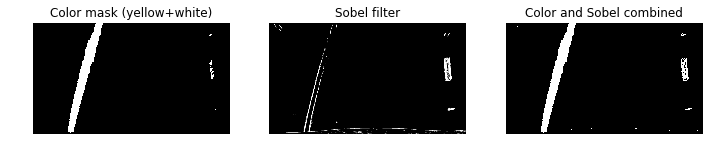

In [32]:
plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.imshow(yw_lane_mask, cmap='gray')
plt.title('Color mask (yellow+white)')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(image_cmb, cmap='gray')
plt.title('Sobel filter')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(image_cmb_colsob, cmap='gray')
plt.title('Color and Sobel combined')
plt.axis('off');

## Lanes isolation
We will next perform additional analysis to isolate lanes from above. We will take bottom half of the image and compute histogram of distribution of pixel intensities.

In [33]:
mov_filtsize = img_size[1]//50
mov_filtsize

25

In [34]:
#https://stackoverflow.com/a/14314054/3563822
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

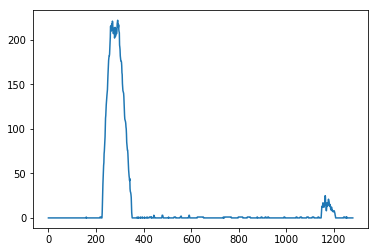

In [35]:
histogram = np.sum(image_cmb_colsob[img_size[0]//2:, :], axis=0)
plt.plot(histogram);

In [36]:
#as shown in the lesson 33
#mean_lane_raw = np.sum(image_cmb_colsob[img_size[0]//2:, :], axis=0)
mean_lane_raw = np.mean(image_cmb_colsob[img_size[0]//2:, :], axis=0)

#we're smoothing mean_lane with a moving average
mean_lane = moving_average(mean_lane_raw, mov_filtsize)

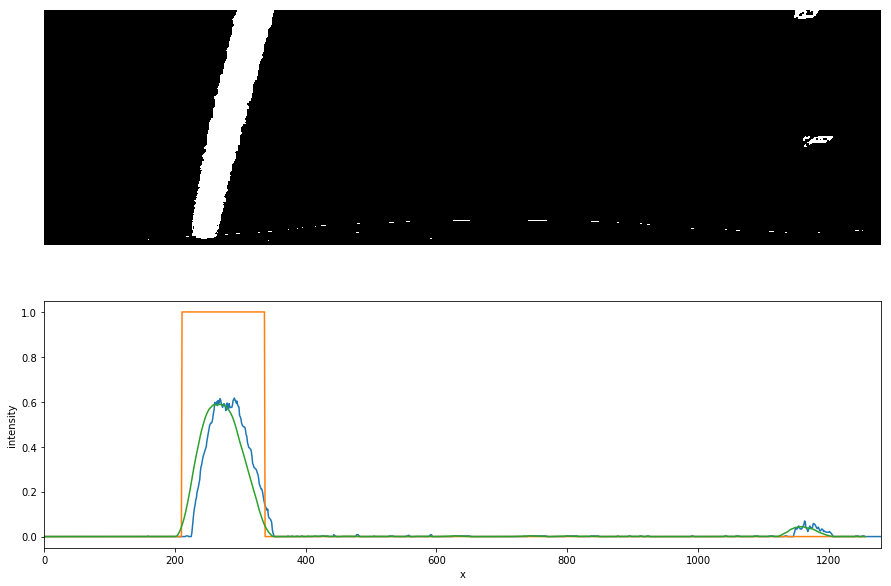

In [37]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.imshow(image_cmb_colsob[img_size[0]//2:, :], cmap='gray')
plt.axis('off')

plt.subplot(2,1,2)
plt.plot(mean_lane_raw)
plt.plot(mean_lane > .05)
plt.plot(mean_lane)
plt.xlabel('x')
plt.ylabel('intensity')
plt.xlim(0,img_size[1]);

copy-pasted from lesson 34

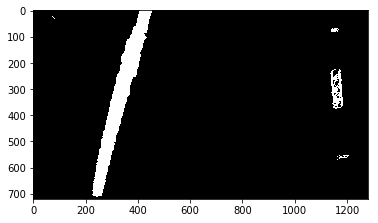

In [38]:
#import matplotlib.image as mpimg

# Read in a thresholded image
#TMP
#warped1 = gaussian_blur(image_cmb_colsob, 11)

open_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
warped2 = cv2.morphologyEx(image_cmb_colsob, cv2.MORPH_OPEN, open_kernel)

warped = warped2

plt.imshow(warped,cmap='gray');

In [39]:
warped.shape, warped2.shape

((720, 1280), (720, 1280))

In [40]:
img_size

(720, 1280, 3)

In [41]:
# window settings
WINDOW_WIDTH = 50
SLIDING_MARGIN = 100 # How much to slide left and right for searching
NB_VERTICAL_LAYERS = 9

window_height = img_size[0]//NB_VERTICAL_LAYERS # Break image into 9 vertical layers since image height is 720

In [42]:
#copy-pasted from lesson 34, then heavily refactored

def find_window_centroids(image, window_width, window_height, margin):
    #hard-coded thresholds for the convolution
    MIN_BASE = 10
    MAX_DIFF = 150
    MIN_CONV = 400
    
    nb_line, nb_col = image.shape
    offset = window_width//2
    WINDOW = np.ones(window_width) # Create our window template that we will use for convolutions

    window_centroids = [] # Store the (left,right) window centroid positions per level

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*nb_line/4):, :nb_col//2], axis=0)
    l_center_base = np.argmax(np.convolve(WINDOW, l_sum)) - offset
    
    ii = np.argmax(np.convolve(WINDOW, l_sum))
    max_conv_left = np.convolve(WINDOW, l_sum)[ii]    
    
    r_sum = np.sum(image[int(3*nb_line/4):, nb_col//2:], axis=0)
    r_center_base = np.argmax(np.convolve(WINDOW, r_sum)) - offset + nb_col//2

    
    ii = np.argmax(np.convolve(WINDOW, r_sum))
    max_conv_right = np.convolve(WINDOW, r_sum)[ii]
    #print("DEBUG: level {}, max_conv: {} | {}".format(0, max_conv_left, max_conv_right))
    #print('conv_signal', conv_signal[l_min_index : l_max_index])    
    
    if not (max_conv_right>MIN_BASE and max_conv_right>MIN_BASE):
        return []
    
    #for the 1st layer, we use these ones
    l_center = l_center_base
    r_center = r_center_base    
    
    # Add what we found for the first layer
    window_centroids.append((l_center, r_center))

    # Go through each layer looking for max pixel locations
    assert window_height == nb_line//NB_VERTICAL_LAYERS
    
    for level in range(1, NB_VERTICAL_LAYERS):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(nb_line-(level+1)*window_height):int(nb_line-level*window_height),\
                                   :], axis=0)
        conv_signal = np.convolve(WINDOW, image_layer)
        
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window,\
        #not center of window
        l_min_index = max(l_center + offset - margin, 0)
        l_max_index = min(l_center + offset + margin, nb_col)
        
        #TODO: we could compare l_center with its previous values and remove outliers
        l_center = np.argmax(conv_signal[l_min_index : l_max_index]) + l_min_index - offset

        #####1
        ii = np.argmax(conv_signal[l_min_index : l_max_index])
        max_conv = conv_signal[l_min_index : l_max_index][ii]
        #print("DEBUG: level {}, max_conv_left {} , dist {}".format(level, max_conv, np.abs(l_center - l_center_base)))
        #print('conv_signal', conv_signal[l_min_index : l_max_index])
        if np.abs(l_center - l_center_base) > MAX_DIFF or max_conv < MIN_CONV:
            l_center = l_center_base
        else:#we keep as ref
            #print('good left one')
            l_center_base = l_center
        #####end1

        # Find the best right centroid by using past right center as a reference
        r_min_index = max(r_center + offset - margin, 0)
        r_max_index = min(r_center + offset + margin, nb_col)
        r_center = np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index - offset

        #####2
        ii = np.argmax(conv_signal[r_min_index:r_max_index])
        max_conv = conv_signal[r_min_index:r_max_index][ii]
        #print("DEBUG: level {}, max_conv_right {} , dist {}".format(level, max_conv, np.abs(r_center - r_center_base)))
        #print('conv_signal', conv_signal[l_min_index : l_max_index])
        if np.abs(r_center - r_center_base) > MAX_DIFF or max_conv < MIN_CONV:
            r_center = r_center_base
        else:#we keep as ref
            #print('good right one')
            r_center_base = r_center
        #####end2
        #print()
        
        # Add what we found for that layer
        window_centroids.append((l_center, r_center))

    return window_centroids

In [43]:
window_centroids = find_window_centroids(warped, WINDOW_WIDTH, window_height, SLIDING_MARGIN)
window_centroids

[(259, 1181),
 (264, 1181),
 (283, 1181),
 (303, 1181),
 (323, 1160),
 (344, 1156),
 (369, 1156),
 (394, 1156),
 (420, 1156)]

In [44]:
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref, dtype='uint8')
    output[ img_ref.shape[0] - (level+1)*height : img_ref.shape[0]-level*height, \
           max(0, center - width//2) : min(center + width//2, img_ref.shape[1]) ] = 1
    return output

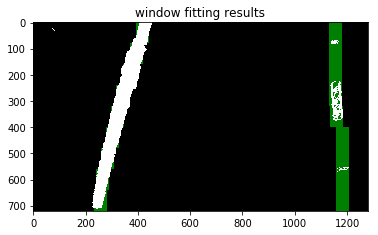

In [45]:
#just for test: we'll deal with the case: window_centroids=[]

# If we found any window centers
if window_centroids:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows
    for level in range(len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_center, r_center = window_centroids[level]
        l_mask = window_mask(WINDOW_WIDTH, window_height, warped, l_center, level)
        r_mask = window_mask(WINDOW_WIDTH, window_height, warped, r_center, level)
        # Add graphic points from window mask here to total pixels found
        l_points = np.bitwise_or(l_points, (l_mask == 1)*255 )
        r_points = np.bitwise_or(r_points, (r_mask == 1)*255 )        

    # Draw the results
    #warning: potential bug: should replace '+' by a bitwise OR
    template = np.uint8(r_points + l_points) # add both left and right window pixels together
    
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.uint8(cv2.merge((zero_channel, template, zero_channel))) # make window pixels green
    
    warpage= np.dstack((warped, warped, warped)) * 255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

# If no window centers found, just display orginal road image
else:
    output = np.uint8(cv2.merge((warped, warped, warped)))


# Display the final results
#plt.figure(figsize=(15,10))
plt.imshow(output)
plt.title('window fitting results')
plt.show()

In [46]:
LANES_FOUND, LANES_NOT_FOUND = "LANES_FOUND", "LANES_NOT_FOUND"
SUCCESS, FAILURE = "SUCCESS", "FAILURE"

In [47]:
def fit_lines_full_search(image, window_width, window_height, margin):
    
    #first we find the centroids
    window_centroids = find_window_centroids(image, window_width, window_height, margin)
    
    if window_centroids:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(image)
        r_points = np.zeros_like(image)

        # Go through each level and draw the windows
        for level in range(len(window_centroids)):
            l_center, r_center = window_centroids[level]
            l_mask = window_mask(WINDOW_WIDTH, window_height, warped, l_center, level)
            r_mask = window_mask(WINDOW_WIDTH, window_height, warped, r_center, level)
            # Add graphic points from window mask here to total pixels found
            l_points = np.bitwise_or(l_points, (l_mask == 1)*255)
            r_points = np.bitwise_or(r_points, (r_mask == 1)*255)        
            
        # Draw the results
        outputLeft = np.bitwise_and(l_points, image)
        outputRight = np.bitwise_and(r_points, image)

        
        # Draw the results
        #warning: potential bug: should replace '+' by a bitwise OR
        template = np.uint8(r_points + l_points) # add both left and right window pixels together

        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.uint8(cv2.merge((zero_channel, template, zero_channel))) # make window pixels green

        warpage= np.dstack((warped, warped, warped)) * 255 # making the original road pixels 3 color channels
        output_full = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        
        return LANES_FOUND, outputLeft, outputRight, output_full
            
    # If no window centers found, just display orginal road image
    else:
        im = np.uint8(cv2.merge((image, image, image)))
        return LANES_NOT_FOUND, im, im, im

In [48]:
status, outputLeft, outputRight, output_full = fit_lines_full_search(warped, WINDOW_WIDTH, window_height, SLIDING_MARGIN)

In [49]:
#status, outputLeft

status: LANES_FOUND


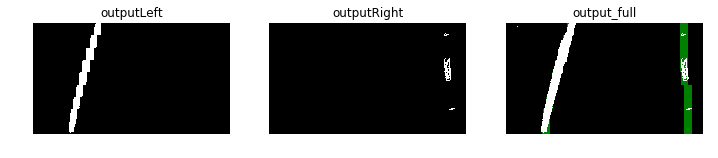

In [50]:
plt.figure(figsize=(12,8))

print("status:", status)

plt.subplot(1,3,1)
plt.imshow(outputLeft, cmap='gray')
plt.title('outputLeft')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(outputRight, cmap='gray')
plt.title('outputRight')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(output_full)
plt.title('output_full')
plt.axis('off');

In [51]:
img_L, img_R = outputLeft, outputRight

In [52]:
img_L.max()

1

In [53]:
vals = np.argwhere(img_L==1)
print(vals[:4,:])
print()
print(vals[-4:,:])

[[  0 408]
 [  0 409]
 [  0 410]
 [  0 411]]

[[710 245]
 [710 246]
 [710 247]
 [710 248]]


In [54]:
vals.shape

(32680, 2)

We split this array so that we get the x and y=f(x) coordinates

In [55]:
vals.T

array([[  0,   0,   0, ..., 710, 710, 710],
       [408, 409, 410, ..., 246, 247, 248]])

In [56]:
y_coords, x_coords = np.split(vals, 2, axis=1)

In [57]:
y_coords, x_coords = y_coords.squeeze(), x_coords.squeeze()
y_coords

array([  0,   0,   0, ..., 710, 710, 710])

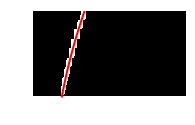

In [58]:
vals = np.argwhere(img_L==1)

y_coords, x_coords = np.split(vals, 2, axis=1)
y_coords, x_coords = y_coords.squeeze(), x_coords.squeeze()

left_fit = np.polyfit(y_coords, x_coords, 2)

#test
left_y = np.arange(11)*img_size[0]/10
left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]


# Plot up the fake data
plt.subplot(1,2,1)
plt.imshow(img_L, cmap='gray')
plt.plot(left_fitx, left_y, 'red', linewidth=2)
plt.axis('off');

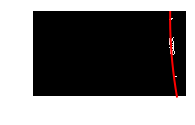

In [59]:
vals = np.argwhere(img_R == 1)

y_coords, x_coords = np.split(vals, 2, axis=1)
y_coords, x_coords = y_coords.squeeze(), x_coords.squeeze()

right_fit = np.polyfit(y_coords, x_coords, 2)

right_y = np.arange(11)*img_size[0]/10
right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]


# Plot up the fake data
plt.subplot(1,2,2)
plt.imshow(img_R,cmap='gray')
plt.plot( right_fitx, right_y,'r',linewidth=2)
plt.axis('off');

In [60]:
right_fit

array([ 1.29803412e-04, -1.45319602e-02,  1.15254804e+03])

## test curvatures

In [61]:
def get_curvature(y_eval, left_fit, right_fit):
    
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    img_height = 720
    
    #old code
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center = (((left_fit[0]*img_height**2+left_fit[1]*img_height+left_fit[2]) +(right_fit[0]*img_height**2+right_fit[1]*img_height+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad, center

In [62]:
for y_eval in (0, 100, 300, 720):
    left_curverad, right_curverad, center = get_curvature(y_eval, left_fit, right_fit)
    print("center: {:.2f} | left/right curvatures at {:>3}: | {:.2f} / {:.2f} | diff: {:.2f}".format(center, y_eval, left_curverad, right_curverad, np.abs(left_curverad - right_curverad)))

center: 0.45 | left/right curvatures at   0: | 5242.04 / 3853.20 | diff: 1388.84
center: 0.45 | left/right curvatures at 100: | 5237.45 / 3853.02 | diff: 1384.43
center: 0.45 | left/right curvatures at 300: | 5228.33 / 3852.71 | diff: 1375.61
center: 0.45 | left/right curvatures at 720: | 5209.34 / 3852.24 | diff: 1357.10


### Finally, draw the lanes back on the original image.

In [63]:
#np.vstack([left_fitx, left_y])

In [64]:
warped.shape == image_cmb_colsob.shape

True

In [65]:
warp_zero = np.zeros_like(warped, dtype='uint8')
color_warp_zero = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
pts = np.hstack((pts_left, pts_right))
pts.shape

(1, 22, 2)

In [66]:
#pts

In [67]:
def add_borders(img, pts, color):
    pts = np.int_(pts)
    for i in range(pts.shape[1]-1):
        x1 = pts[0,i,0]
        y1 = pts[0,i,1]
        x2 = pts[0,i+1,0]
        y2 = pts[0,i+1,1]
        cv2.line(img, (x1, y1), (x2, y2), color, 50)

In [68]:
#we fill a polynom 
color_warp = cv2.fillPoly(color_warp_zero.copy(), np.int_([pts]), (0,255,255))

add_borders(color_warp, np.int_(pts_left), (255,255,0))
add_borders(color_warp, np.int_(pts_right), (255,255,255))

newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

#we blend the track with our real-world picture
result = cv2.addWeighted(image_ud, 1, newwarp, 0.3, 0)

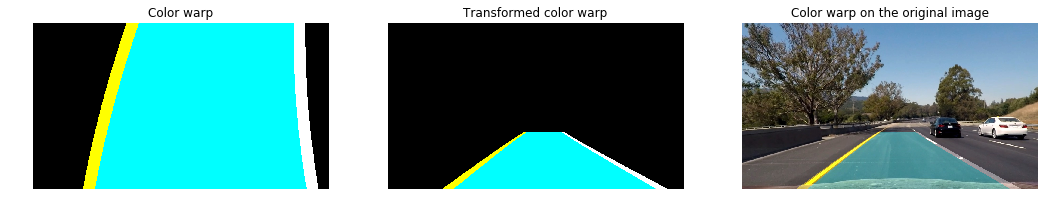

In [69]:
plt.figure(figsize=(18,12))
plt.subplot(1,3,1)
plt.imshow(color_warp)
plt.axis('off')
plt.title('Color warp')

plt.subplot(1,3,2)
plt.imshow(newwarp)
plt.title('Transformed color warp')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(result)
plt.title('Color warp on the original image')
plt.axis('off');

## Global pipeline

In [70]:
# Define a class to receive the characteristics of each line detection
class Line():
    """
    Define the Line class and all the necessary variales to track and record 
    recent and past lines
    """
    def __init__(self, n=5):
        # count of current fit
        self.current_n = 0
        # total number of previous fits to consider
        self.total_n = n
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #corresponding to right-line of image 6
        #self.best_fit = np.array([1.08572350e-05, 1.34752711e-01, 1.02294793e+03])
        
        #polynomial coefficients averaged over the last n iterations
        self.recent_fits = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = dict() 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [81]:
class Pipeline(object):
    
    def __init__(self, image_init=None):
        
        self.counter = 0
        
        self.failed_counter = 0
        self.FAILED_THRESHOLD = 3
        self.do_reset = False
    
        self.left_line_reference = Line(n=5)
        self.right_line_reference = Line(n=5)    

        self.PERC = 0.08 #0.15
        
        self.Y_EVAL = (0, 100, 300, 720)
        
        if image_init is not None:
            self.process(image_init)
            
    def display_internal_state(self):
        print("counter:", self.counter)        
        print("failed_counter:", self.failed_counter)
        print("do_reset:", self.do_reset)
        print("left_line_reference.radius_of_curvature:", self.left_line_reference.radius_of_curvature)      
        print("right_line_reference.radius_of_curvature:", self.right_line_reference.radius_of_curvature) 
        print("left_line_reference.best_fit:", self.left_line_reference.best_fit)      
        print("right_line_reference.best_fit:", self.right_line_reference.best_fit)         
        
    def optical_transform(self, image):
        """
        we transform the image into an image where the left and white lines are clearly visible.
        We use a combination of color and Soble filters.
        
        """
        # 1. Undistort image
        image_ud = undistort_image(image)
        image_ud = gaussian_blur(image_ud, kernel=5)
        img_size = np.shape(image_ud)

        # Define window for perspective transform
        warped, M, Minv_ = do_perspective_transform(image_ud)
    
        #2. we compute good yellow and white masks
        image_HSV = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)        
        yellow_hsv_low  = np.array([0,  100,  100])
        yellow_hsv_high = np.array([50, 255, 255])
        yellow_mask = cv2.inRange(image_HSV, yellow_hsv_low, yellow_hsv_high)

        white_hsv_low  = np.array([ 20,   0,   180])
        white_hsv_high = np.array([ 255,  80, 255])
        white_mask = cv2.inRange(image_HSV, white_hsv_low, white_hsv_high)

        #we combine them, and get the final yellow+white mask
        yw_lane_mask = cv2.bitwise_or(white_mask, yellow_mask)

        
        #3. we compute Sobel filters
        # Convert image to HLS scheme
        image_HLS = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)

        # Apply sobel filters on L and S channels.
        img_gs = image_HLS[:,:,1]
        img_abs_x = abs_sobel_thresh(img_gs, 'x', 5, (50,225))
        img_abs_y = abs_sobel_thresh(img_gs, 'y', 5, (50,225))
        warped_channel1 = cv2.bitwise_or(img_abs_x, img_abs_y)

        img_gs = image_HLS[:,:,2]
        img_abs_x = abs_sobel_thresh(img_gs, 'x', 5, (50,225))
        img_abs_y = abs_sobel_thresh(img_gs, 'y', 5, (50,225))
        warped_channel2 = np.copy(cv2.bitwise_or(img_abs_x, img_abs_y))

        image_sobel_cmb = cv2.bitwise_or(warped_channel1, warped_channel2)
        #we add a bit of blur
        image_sobel_cmb = gaussian_blur(image_sobel_cmb, 5)


        #4. finally, we combine the color and Sobel steps:
        image_cmb_colsob = np.zeros_like(image_sobel_cmb)
        image_cmb_colsob[(yw_lane_mask == 255) | (image_sobel_cmb == 255)] = 1


        OPEN_KERNEL = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
        warped_final = cv2.morphologyEx(image_cmb_colsob, cv2.MORPH_OPEN, OPEN_KERNEL)

        return image_ud, warped, warped_final

    
    def get_curvature_cr(self, y_eval, left_fit_cr, right_fit_cr):
        """
        curvature in real-world coordinates
        """
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        img_height = 720

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        center = (((left_fit_cr[0]*img_height**2+left_fit_cr[1]*img_height+left_fit_cr[2]) + (right_fit_cr[0]*img_height**2+right_fit_cr[1]*img_height+right_fit_cr[2]) ) /2 - 640)*xm_per_pix

        # Now our radius of curvature is in meters
        #print("curvatures:", left_curverad, 'm', right_curverad, 'm')
        
        return left_curverad, right_curverad, center  
    
       
    def sanity_check(self, left_fit_cr, right_fit_cr):
        """
        we check the fitted polynoms:
        a. if they are not None
        b. for obvious anomalies
        c. compared to the reference left_line_reference and right_line_reference
        """
        MIN_CURV_THRESH = 200 #2000 #temp
        MAX_CURV_DIFF_THRESH = 50000 #50000 #temp
        MAX_CURV_DIFF_WITH_REF_THRESH = 180000 #10000 #temp        
                
        #test: one lane (or both) has not been detected:
        if left_fit_cr is None or right_fit_cr is None:
            return FAILURE

        for y_eval in self.Y_EVAL:
            #step a.
            left_curverad, right_curverad, center = self.get_curvature_cr(y_eval, left_fit_cr, right_fit_cr)
            print("center: {:.2f} | left/right curvatures at {:>3}: {:.2f} / {:.2f} | diff: {:.2f}".format(center, y_eval, left_curverad, right_curverad, np.abs(left_curverad - right_curverad)))

            if left_curverad < MIN_CURV_THRESH or right_curverad < MIN_CURV_THRESH:
                return FAILURE, left_curverad, right_curverad, center
            if np.abs(left_curverad - right_curverad) > MAX_CURV_DIFF_THRESH:
                return FAILURE, left_curverad, right_curverad, center
            
            #step b.
            #if we have no previous data
            left_curverad_ref = self.left_line_reference.radius_of_curvature.get(y_eval, left_curverad)
            right_curverad_ref = self.right_line_reference.radius_of_curvature.get(y_eval, right_curverad)
            
            if np.abs(left_curverad - left_curverad_ref) > MAX_CURV_DIFF_WITH_REF_THRESH:
                print("error left MAX_CURV_DIFF_WITH_REF_THRESH:", np.abs(left_curverad - left_curverad_ref))
                return FAILURE, left_curverad, right_curverad, center
            if np.abs(right_curverad - right_curverad_ref) > MAX_CURV_DIFF_WITH_REF_THRESH:
                print("error right MAX_CURV_DIFF_WITH_REF_THRESH:", np.abs(right_curverad - right_curverad_ref))
                return FAILURE, left_curverad, right_curverad, center
        
        #if we passed every test: sanity check is ok
        y_eval = self.Y_EVAL[2]
        left_curverad, right_curverad, center = self.get_curvature_cr(y_eval, left_fit_cr, right_fit_cr)
        
        return SUCCESS, left_curverad, right_curverad, center   
    
    
    def update_lane_refs(self, left_fit, right_fit):
        
        self.left_line_reference.current_fit = left_fit
        self.right_line_reference.current_fit = right_fit
        
        if self.left_line_reference.best_fit is None:
            self.left_line_reference.best_fit = left_fit
        if self.right_line_reference.best_fit is None:
            self.right_line_reference.best_fit = right_fit
            
        self.left_line_reference.best_fit = self.PERC * left_fit + (1-self.PERC) * self.left_line_reference.best_fit
        self.right_line_reference.best_fit = self.PERC * right_fit + (1-self.PERC) * self.right_line_reference.best_fit        
        
        #TODO: we could get them from 'sanity_check' method without recomputing
        for y_eval in self.Y_EVAL:
            left_curverad, right_curverad, center = get_curvature(y_eval, left_fit, right_fit)
            
            self.left_line_reference.radius_of_curvature[y_eval] = left_curverad
            self.right_line_reference.radius_of_curvature[y_eval] = right_curverad   
        
    def get_yx_coords(self, img):
        """
        we get the non black pixels of an image
        """
        vals = np.argwhere(img == 1)
        y_coords, x_coords  = np.split(vals, 2, axis=1)
        y_coords, x_coords = y_coords.squeeze(), x_coords.squeeze()
        
        return y_coords, x_coords 
        
        
    def draw_lanes(self, image_ud, warped, left_fitx, left_y, right_fitx, right_y):
        """
        we draw the fitted lines onto the original image
        """
        warp_zero = np.zeros_like(warped, dtype='uint8')
        color_warp_zero = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
        pts = np.hstack((pts_left, pts_right))

        #we fill a polynom 
        color_warp = cv2.fillPoly(color_warp_zero.copy(), np.int_([pts]), (0,255,255))

        add_borders(color_warp, np.int_(pts_left), (255,255,0))
        add_borders(color_warp, np.int_(pts_right), (255,255,255))

        new_warp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 

        #we blend the track with our real-world picture      
        result = cv2.addWeighted(image_ud, 1, new_warp, 0.3, 0)
        
        DISPLAY = False
        if DISPLAY:
            plt.figure(figsize=(18,12))
            plt.subplot(1,3,1)
            plt.imshow(color_warp)
            plt.axis('off')
            plt.title('Color warp')

            plt.subplot(1,3,2)
            plt.imshow(new_warp)
            plt.title('Transformed color warp')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.imshow(result)
            plt.title('Color warp on the original image')
            plt.axis('off');
        
        return result

    def fit_lines_full_search(self, image, window_width, window_height, margin):

        #first we find the centroids
        window_centroids = find_window_centroids(image, window_width, window_height, margin)

        if window_centroids:
            # Points used to draw all the left and right windows
            l_points = np.zeros_like(image)
            r_points = np.zeros_like(image)

            # Go through each level and draw the windows
            for level in range(len(window_centroids)):
                l_center, r_center = window_centroids[level]
                l_mask = window_mask(WINDOW_WIDTH, window_height, warped, l_center, level)
                r_mask = window_mask(WINDOW_WIDTH, window_height, warped, r_center, level)
                # Add graphic points from window mask here to total pixels found
                l_points = np.bitwise_or(l_points, (l_mask == 1)*255)
                r_points = np.bitwise_or(r_points, (r_mask == 1)*255)

            # Draw the results
            outputLeft = np.bitwise_and(l_points, image)
            outputRight = np.bitwise_and(r_points, image)

            #warning: potential bug: should replace '+' by a bitwise OR
            template = np.uint8(r_points + l_points) # add both left and right window pixels together

            zero_channel = np.zeros_like(template) # create a zero color channel
            template = np.uint8(cv2.merge((zero_channel, template, zero_channel))) # make window pixels green

            warpage= np.dstack((image, image, image)) * 255 # making the original road pixels 3 color channels
            outputFull = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

            return LANES_FOUND, outputLeft, outputRight, outputFull

        # If no window centers found, just display orginal road image
        else:
            im = np.uint8(cv2.merge((image, image, image)))
            return LANES_NOT_FOUND, im, im, im              

    
    def fit_lines_continuous(self, image, window_width, window_height, margin):

        raise NotImplementedError
    
    
    def process(self, image):
        """
        the full image processing
        """
        image_ud, warped_orig, warped = self.optical_transform(image)
        #image_ud, warped, warped_final
        
        #TMP: remove
        DO_FULL_SEARCH = True 
        
        if DO_FULL_SEARCH or self.counter <=3 or self.do_reset is True:
            status, outputLeft, outputRight, outputFull = self.fit_lines_full_search(warped, WINDOW_WIDTH, window_height, SLIDING_MARGIN)
        else:
            #fast search that uses the stream of previous frames
            status, outputLeft, outputRight, outputFull = self.fit_lines_continuous(warped, WINDOW_WIDTH, window_height, SLIDING_MARGIN)        
        
        assert status in (LANES_FOUND, LANES_NOT_FOUND)
        status_sanity_check, left_curverad, right_curverad, center = -1,-1,-1,-1
        
        if status == LANES_FOUND:
            #step: we fit polynoms
            
            lefty, leftx = self.get_yx_coords(outputLeft)
            left_fit = np.polyfit(lefty, leftx, 2)

            righty, rightx = self.get_yx_coords(outputRight)
            right_fit = np.polyfit(righty, rightx, 2)        
        
            # Define conversions in x and y from pixels space to meters
            ym_per_pix = 30./720 # meters per pixel in y dimension
            xm_per_pix = 3.7/700 # meters per pixel in x dimension

            # Fit new polynomials to x,y in world space
            left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
            right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)  
    
            status_sanity_check, left_curverad, right_curverad, center = self.sanity_check(left_fit_cr, right_fit_cr)
            
            #DEBUG
            #status_sanity_check = SUCCESS
            
            assert status_sanity_check in (SUCCESS, FAILURE)
            if status_sanity_check == SUCCESS:
                #print("!! sanity-check ok !!")
                self.update_lane_refs(left_fit, right_fit)
                self.failed_counter = 0
                self.do_reset = False
            else:
                print("sanity-check failed")            
                self.failed_counter +=1
        
        else:#status = LANES_NOT_FOUND
            print("pipeline: lanes not found")           
            self.failed_counter +=1
        
        if self.failed_counter >= self.FAILED_THRESHOLD:
            self.do_reset = True           

            
        print("-- failed_counter:", self.failed_counter)    
        #final step: we draw the fitted lines onto the original image
        a, b, c = self.left_line_reference.best_fit.tolist()
        left_y = np.arange(11)*warped.shape[1]/10
        left_fitx = a*left_y**2 + b*left_y + c
        
        a, b, c = self.right_line_reference.best_fit.tolist()
        right_y = np.arange(11)*warped.shape[1]/10
        right_fitx = a*right_y**2 + b*right_y + c


        result = self.draw_lanes(image_ud, warped, left_fitx, left_y, right_fitx, right_y)
 
        self.counter += 1
    
    
        #Composition of images to final display
        img_out = np.zeros((576,1280,3), dtype=np.uint8)

        img_out[0:576,0:1024,:] = cv2.resize(result, (1024,576))
        img_out[0:288,1024:1280, :] = cv2.resize(warped_orig, (256,288))
        img_out[310:576,1024:1280,:] = cv2.resize(outputFull, (256,266))

        
        #Write curvature and center in image
        TextL = "left curv: {} m".format(int(left_curverad))
        TextR = "right curv: {} m".format(int(right_curverad))
        TextC = "center offset: {} m".format(round(center,2)) 
        
        fontScale = 1
        thickness = 2

        fontFace = cv2.FONT_HERSHEY_DUPLEX

        cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
        cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
        cv2.putText(img_out, TextC, (130,100), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

        cv2.putText(img_out, "warped", (1070,30), fontFace, .8, (200,200,0), thickness, lineType = cv2.LINE_AA)
        cv2.putText(img_out, "fitted lines", (1080,305), fontFace, .8, (200,200,0), thickness, lineType = cv2.LINE_AA)

        return img_out

In [82]:
#image for init
image_init = cv2.imread(test_images[4])
image_init = cv2.cvtColor(image_init, cv2.COLOR_BGR2RGB)

#we init the pipeline with this reference image
p = Pipeline(image_init=image_init)

center: -2.75 | left/right curvatures at   0: 2132.57 / 1872.20 | diff: 260.37
center: -2.75 | left/right curvatures at 100: 2132.07 / 1872.23 | diff: 259.84
center: -2.75 | left/right curvatures at 300: 2131.15 / 1872.38 | diff: 258.77
center: -2.75 | left/right curvatures at 720: 2129.53 / 1873.05 | diff: 256.48
-- failed_counter: 0


In [83]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

import time

In [84]:
#%%capture

p = Pipeline(image_init=image_init)

#Create video file pipeline
input_file = "project_video.mp4" #"project_video.mp4" #"challenge_video.mp4" # harder_challenge_video.mp4
output_file = "output_project_video.mp4"

input_video = VideoFileClip(input_file)#.subclip(18,35)

t0 = time.time()
output_video = input_video.fl_image(p.process)
output_video.write_videofile(output_file, audio=False)

center: -2.75 | left/right curvatures at   0: 2132.57 / 1872.20 | diff: 260.37
center: -2.75 | left/right curvatures at 100: 2132.07 / 1872.23 | diff: 259.84
center: -2.75 | left/right curvatures at 300: 2131.15 / 1872.38 | diff: 258.77
center: -2.75 | left/right curvatures at 720: 2129.53 / 1873.05 | diff: 256.48
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1
[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<03:06,  6.74it/s]

pipeline: lanes not found
-- failed_counter: 2



Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/sebastienvincent/.virtualenvs/nd013/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/sebastienvincent/.virtualenvs/nd013/bin/../lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


  0%|          | 2/1261 [00:00<05:10,  4.05it/s]

center: -4.07 | left/right curvatures at   0: 1395.16 / 2303.04 | diff: 907.88
center: -4.07 | left/right curvatures at 100: 1395.11 / 2302.57 | diff: 907.45
center: -4.07 | left/right curvatures at 300: 1395.13 / 2301.68 | diff: 906.54
center: -4.07 | left/right curvatures at 720: 1395.66 / 2300.10 | diff: 904.44
-- failed_counter: 0



  0%|          | 3/1261 [00:00<05:22,  3.90it/s]

center: -4.71 | left/right curvatures at   0: 1216.23 / 760.76 | diff: 455.47
center: -4.71 | left/right curvatures at 100: 1216.17 / 760.03 | diff: 456.13
center: -4.71 | left/right curvatures at 300: 1216.17 / 758.79 | diff: 457.38
center: -4.71 | left/right curvatures at 720: 1216.73 / 757.08 | diff: 459.65
-- failed_counter: 0



  0%|          | 4/1261 [00:01<05:28,  3.83it/s]

center: -6.63 | left/right curvatures at   0: 1140.12 / 240.37 | diff: 899.75
center: -6.63 | left/right curvatures at 100: 1140.05 / 238.80 | diff: 901.24
center: -6.63 | left/right curvatures at 300: 1140.03 / 236.35 | diff: 903.69
center: -6.63 | left/right curvatures at 720: 1140.60 / 234.11 | diff: 906.49
-- failed_counter: 0



  0%|          | 5/1261 [00:01<05:35,  3.75it/s]

center: -6.08 | left/right curvatures at   0: 1119.19 / 299.49 | diff: 819.70
center: -6.08 | left/right curvatures at 100: 1119.11 / 298.20 | diff: 820.91
center: -6.08 | left/right curvatures at 300: 1119.08 / 296.14 | diff: 822.94
center: -6.08 | left/right curvatures at 720: 1119.63 / 294.14 | diff: 825.49
-- failed_counter: 0



  0%|          | 6/1261 [00:01<05:37,  3.72it/s]

center: -4.98 | left/right curvatures at   0: 1122.35 / 602.23 | diff: 520.12
center: -4.98 | left/right curvatures at 100: 1122.26 / 601.49 | diff: 520.78
center: -4.98 | left/right curvatures at 300: 1122.22 / 600.25 | diff: 521.97
center: -4.98 | left/right curvatures at 720: 1122.75 / 598.80 | diff: 523.95
-- failed_counter: 0



  1%|          | 8/1261 [00:02<05:18,  3.93it/s]

center: -3.80 | left/right curvatures at   0: 1150.89 / 7747.23 | diff: 6596.34
center: -3.80 | left/right curvatures at 100: 1150.80 / 7747.60 | diff: 6596.81
center: -3.80 | left/right curvatures at 300: 1150.75 / 7748.38 | diff: 6597.63
center: -3.80 | left/right curvatures at 720: 1151.23 / 7750.09 | diff: 6598.86
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



  1%|          | 9/1261 [00:02<05:03,  4.13it/s]

pipeline: lanes not found
-- failed_counter: 2



  1%|          | 10/1261 [00:02<05:07,  4.07it/s]

center: -3.25 | left/right curvatures at   0: 1277.52 / 1171.67 | diff: 105.85
center: -3.25 | left/right curvatures at 100: 1277.42 / 1172.01 | diff: 105.41
center: -3.25 | left/right curvatures at 300: 1277.35 / 1172.81 | diff: 104.54
center: -3.25 | left/right curvatures at 720: 1277.74 / 1175.09 | diff: 102.66
-- failed_counter: 0



  1%|          | 11/1261 [00:02<05:10,  4.03it/s]

center: -3.29 | left/right curvatures at   0: 1144.87 / 1130.54 | diff: 14.34
center: -3.29 | left/right curvatures at 100: 1144.76 / 1130.84 | diff: 13.92
center: -3.29 | left/right curvatures at 300: 1144.66 / 1131.58 | diff: 13.08
center: -3.29 | left/right curvatures at 720: 1145.05 / 1133.75 | diff: 11.30
-- failed_counter: 0



  1%|          | 13/1261 [00:03<05:01,  4.13it/s]

center: -3.31 | left/right curvatures at   0: 1206.31 / 1223.88 | diff: 17.57
center: -3.31 | left/right curvatures at 100: 1206.19 / 1224.14 | diff: 17.95
center: -3.31 | left/right curvatures at 300: 1206.08 / 1224.77 | diff: 18.70
center: -3.31 | left/right curvatures at 720: 1206.41 / 1226.67 | diff: 20.26
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



  1%|          | 14/1261 [00:03<05:04,  4.09it/s]

center: -4.36 | left/right curvatures at   0: 1110.38 / 1387.46 | diff: 277.07
center: -4.36 | left/right curvatures at 100: 1110.24 / 1386.89 | diff: 276.65
center: -4.36 | left/right curvatures at 300: 1110.09 / 1385.87 | diff: 275.77
center: -4.36 | left/right curvatures at 720: 1110.40 / 1384.22 | diff: 273.82
-- failed_counter: 0



  1%|          | 15/1261 [00:03<05:06,  4.06it/s]

center: -3.68 | left/right curvatures at   0: 1044.91 / 2565.28 | diff: 1520.37
center: -3.68 | left/right curvatures at 100: 1044.76 / 2565.59 | diff: 1520.83
center: -3.68 | left/right curvatures at 300: 1044.60 / 2566.28 | diff: 1521.68
center: -3.68 | left/right curvatures at 720: 1044.93 / 2567.99 | diff: 1523.06
-- failed_counter: 0



  1%|▏         | 16/1261 [00:03<05:08,  4.04it/s]

center: -4.78 | left/right curvatures at   0: 1064.21 / 750.62 | diff: 313.59
center: -4.78 | left/right curvatures at 100: 1064.07 / 749.85 | diff: 314.21
center: -4.78 | left/right curvatures at 300: 1063.92 / 748.53 | diff: 315.39
center: -4.78 | left/right curvatures at 720: 1064.25 / 746.66 | diff: 317.59
-- failed_counter: 0



  1%|▏         | 17/1261 [00:04<05:10,  4.01it/s]

center: -6.91 | left/right curvatures at   0: 1104.29 / 218.94 | diff: 885.35
center: -6.91 | left/right curvatures at 100: 1104.15 / 217.21 | diff: 886.93
center: -6.91 | left/right curvatures at 300: 1104.00 / 214.51 | diff: 889.49
center: -6.91 | left/right curvatures at 720: 1104.31 / 212.06 | diff: 892.25
-- failed_counter: 0



  1%|▏         | 18/1261 [00:04<05:11,  3.98it/s]

center: -6.90 | left/right curvatures at   0: 1108.46 / 219.73 | diff: 888.73
center: -6.90 | left/right curvatures at 100: 1108.32 / 217.96 | diff: 890.35
center: -6.90 | left/right curvatures at 300: 1108.17 / 215.18 | diff: 892.99
center: -6.90 | left/right curvatures at 720: 1108.47 / 212.55 | diff: 895.92
-- failed_counter: 0



  2%|▏         | 19/1261 [00:04<05:13,  3.96it/s]

center: -6.49 | left/right curvatures at   0: 1176.22 / 249.65 | diff: 926.58
center: -6.49 | left/right curvatures at 100: 1176.08 / 248.07 | diff: 928.01
center: -6.49 | left/right curvatures at 300: 1175.92 / 245.56 | diff: 930.37
center: -6.49 | left/right curvatures at 720: 1176.17 / 243.10 | diff: 933.08
-- failed_counter: 0



  2%|▏         | 21/1261 [00:05<05:07,  4.04it/s]

center: -4.68 | left/right curvatures at   0: 1297.34 / 740.22 | diff: 557.12
center: -4.68 | left/right curvatures at 100: 1297.20 / 739.45 | diff: 557.75
center: -4.68 | left/right curvatures at 300: 1297.05 / 738.13 | diff: 558.92
center: -4.68 | left/right curvatures at 720: 1297.25 / 736.26 | diff: 560.99
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



  2%|▏         | 22/1261 [00:05<05:08,  4.02it/s]

center: -2.75 | left/right curvatures at   0: 2143.64 / 774.70 | diff: 1368.94
center: -2.75 | left/right curvatures at 100: 2143.54 / 774.96 | diff: 1368.58
center: -2.75 | left/right curvatures at 300: 2143.42 / 775.67 | diff: 1367.75
center: -2.75 | left/right curvatures at 720: 2143.48 / 778.05 | diff: 1365.43
-- failed_counter: 0



  2%|▏         | 23/1261 [00:05<05:10,  3.99it/s]

center: -2.68 | left/right curvatures at   0: 3882.62 / 835.99 | diff: 3046.63
center: -2.68 | left/right curvatures at 100: 3882.57 / 836.25 | diff: 3046.32
center: -2.68 | left/right curvatures at 300: 3882.50 / 836.94 | diff: 3045.56
center: -2.68 | left/right curvatures at 720: 3882.54 / 839.22 | diff: 3043.32
-- failed_counter: 0



  2%|▏         | 24/1261 [00:06<05:11,  3.97it/s]

center: -2.61 | left/right curvatures at   0: 4373.39 / 776.85 | diff: 3596.54
center: -2.61 | left/right curvatures at 100: 4373.35 / 777.05 | diff: 3596.30
center: -2.61 | left/right curvatures at 300: 4373.30 / 777.66 | diff: 3595.65
center: -2.61 | left/right curvatures at 720: 4373.36 / 779.81 | diff: 3593.56
-- failed_counter: 0



  2%|▏         | 26/1261 [00:06<05:06,  4.03it/s]

center: -2.93 | left/right curvatures at   0: 4151.96 / 1227.29 | diff: 2924.66
center: -2.93 | left/right curvatures at 100: 4151.93 / 1227.57 | diff: 2924.36
center: -2.93 | left/right curvatures at 300: 4151.91 / 1228.25 | diff: 2923.65
center: -2.93 | left/right curvatures at 720: 4152.03 / 1230.23 | diff: 2921.79
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



  2%|▏         | 27/1261 [00:06<05:07,  4.01it/s]

center: -3.98 | left/right curvatures at   0: 3567.57 / 1334.66 | diff: 2232.91
center: -3.98 | left/right curvatures at 100: 3567.54 / 1334.13 | diff: 2233.41
center: -3.98 | left/right curvatures at 300: 3567.52 / 1333.17 | diff: 2234.35
center: -3.98 | left/right curvatures at 720: 3567.67 / 1331.68 | diff: 2235.99
-- failed_counter: 0



  2%|▏         | 28/1261 [00:06<05:08,  4.00it/s]

center: -3.93 | left/right curvatures at   0: 3091.06 / 1597.44 | diff: 1493.62
center: -3.93 | left/right curvatures at 100: 3091.03 / 1596.94 | diff: 1494.09
center: -3.93 | left/right curvatures at 300: 3091.01 / 1596.02 | diff: 1494.98
center: -3.93 | left/right curvatures at 720: 3091.18 / 1594.52 | diff: 1496.66
-- failed_counter: 0



  2%|▏         | 29/1261 [00:07<05:08,  3.99it/s]

center: -4.32 | left/right curvatures at   0: 2567.68 / 859.45 | diff: 1708.23
center: -4.32 | left/right curvatures at 100: 2567.65 / 858.79 | diff: 1708.86
center: -4.32 | left/right curvatures at 300: 2567.65 / 857.65 | diff: 1710.00
center: -4.32 | left/right curvatures at 720: 2567.91 / 856.06 | diff: 1711.85
-- failed_counter: 0



  2%|▏         | 30/1261 [00:07<05:09,  3.98it/s]

center: -4.43 | left/right curvatures at   0: 2020.80 / 827.11 | diff: 1193.69
center: -4.43 | left/right curvatures at 100: 2020.77 / 826.49 | diff: 1194.28
center: -4.43 | left/right curvatures at 300: 2020.79 / 825.43 | diff: 1195.36
center: -4.43 | left/right curvatures at 720: 2021.15 / 824.04 | diff: 1197.12
-- failed_counter: 0



  2%|▏         | 31/1261 [00:07<05:10,  3.96it/s]

center: -4.24 | left/right curvatures at   0: 1508.89 / 1329.04 | diff: 179.85
center: -4.24 | left/right curvatures at 100: 1508.84 / 1328.48 | diff: 180.36
center: -4.24 | left/right curvatures at 300: 1508.84 / 1327.49 | diff: 181.35
center: -4.24 | left/right curvatures at 720: 1509.30 / 1325.91 | diff: 183.39
-- failed_counter: 0



  3%|▎         | 32/1261 [00:08<05:11,  3.95it/s]

center: -7.13 | left/right curvatures at   0: 1321.82 / 199.97 | diff: 1121.85
sanity-check failed
-- failed_counter: 1



  3%|▎         | 34/1261 [00:08<05:07,  3.99it/s]

center: -4.14 | left/right curvatures at   0: 1272.70 / 2014.71 | diff: 742.01
center: -4.14 | left/right curvatures at 100: 1272.64 / 2014.14 | diff: 741.50
center: -4.14 | left/right curvatures at 300: 1272.63 / 2013.09 | diff: 740.45
center: -4.14 | left/right curvatures at 720: 1273.15 / 2011.21 | diff: 738.06
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



  3%|▎         | 35/1261 [00:08<05:08,  3.98it/s]

center: -3.15 | left/right curvatures at   0: 1198.62 / 940.39 | diff: 258.23
center: -3.15 | left/right curvatures at 100: 1198.55 / 940.71 | diff: 257.85
center: -3.15 | left/right curvatures at 300: 1198.54 / 941.49 | diff: 257.05
center: -3.15 | left/right curvatures at 720: 1199.09 / 943.87 | diff: 255.21
-- failed_counter: 0



  3%|▎         | 36/1261 [00:09<05:09,  3.96it/s]

center: -3.45 | left/right curvatures at   0: 1297.01 / 1824.30 | diff: 527.29
center: -3.45 | left/right curvatures at 100: 1296.94 / 1824.70 | diff: 527.75
center: -3.45 | left/right curvatures at 300: 1296.94 / 1825.57 | diff: 528.64
center: -3.45 | left/right curvatures at 720: 1297.45 / 1827.79 | diff: 530.34
-- failed_counter: 0



  3%|▎         | 38/1261 [00:09<05:05,  4.00it/s]

center: -3.31 | left/right curvatures at   0: 1298.75 / 1304.70 | diff: 5.96
center: -3.31 | left/right curvatures at 100: 1298.68 / 1305.01 | diff: 6.33
center: -3.31 | left/right curvatures at 300: 1298.68 / 1305.76 | diff: 7.08
center: -3.31 | left/right curvatures at 720: 1299.19 / 1307.85 | diff: 8.66
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



  3%|▎         | 39/1261 [00:09<05:06,  3.99it/s]

center: -2.96 | left/right curvatures at   0: 1163.21 / 711.43 | diff: 451.78
center: -2.96 | left/right curvatures at 100: 1163.14 / 711.56 | diff: 451.58
center: -2.96 | left/right curvatures at 300: 1163.12 / 712.04 | diff: 451.08
center: -2.96 | left/right curvatures at 720: 1163.67 / 714.00 | diff: 449.67
-- failed_counter: 0



  3%|▎         | 40/1261 [00:10<05:06,  3.98it/s]

center: -3.66 | left/right curvatures at   0: 1087.95 / 2636.35 | diff: 1548.41
center: -3.66 | left/right curvatures at 100: 1087.86 / 2636.71 | diff: 1548.85
center: -3.66 | left/right curvatures at 300: 1087.82 / 2637.47 | diff: 1549.65
center: -3.66 | left/right curvatures at 720: 1088.37 / 2639.34 | diff: 1550.97
-- failed_counter: 0



  3%|▎         | 41/1261 [00:10<05:06,  3.98it/s]

center: -4.09 | left/right curvatures at   0: 1023.06 / 4534.48 | diff: 3511.43
center: -4.09 | left/right curvatures at 100: 1022.95 / 4533.99 | diff: 3511.04
center: -4.09 | left/right curvatures at 300: 1022.89 / 4533.05 | diff: 3510.16
center: -4.09 | left/right curvatures at 720: 1023.44 / 4531.22 | diff: 3507.78
-- failed_counter: 0



  3%|▎         | 42/1261 [00:10<05:07,  3.97it/s]

center: -6.55 | left/right curvatures at   0: 982.51 / 254.88 | diff: 727.64
center: -6.55 | left/right curvatures at 100: 982.40 / 253.33 | diff: 729.07
center: -6.55 | left/right curvatures at 300: 982.32 / 250.86 | diff: 731.46
center: -6.55 | left/right curvatures at 720: 982.86 / 248.45 | diff: 734.41
-- failed_counter: 0



  3%|▎         | 43/1261 [00:10<05:08,  3.94it/s]

center: -6.81 | left/right curvatures at   0: 934.52 / 234.94 | diff: 699.57
center: -6.81 | left/right curvatures at 100: 934.39 / 233.26 | diff: 701.12
center: -6.81 | left/right curvatures at 300: 934.29 / 230.59 | diff: 703.69
center: -6.81 | left/right curvatures at 720: 934.80 / 227.99 | diff: 706.81
-- failed_counter: 0



  3%|▎         | 44/1261 [00:11<05:09,  3.93it/s]

center: -4.72 | left/right curvatures at   0: 947.75 / 901.66 | diff: 46.10
center: -4.72 | left/right curvatures at 100: 947.62 / 900.95 | diff: 46.66
center: -4.72 | left/right curvatures at 300: 947.51 / 899.73 | diff: 47.78
center: -4.72 | left/right curvatures at 720: 948.00 / 897.91 | diff: 50.08
-- failed_counter: 0



  4%|▎         | 46/1261 [00:11<05:07,  3.96it/s]

center: -14.26 | left/right curvatures at   0: 896.11 / 83.36 | diff: 812.75
sanity-check failed
-- failed_counter: 1
pipeline: lanes not found
-- failed_counter: 2



  4%|▎         | 47/1261 [00:11<05:08,  3.94it/s]

center: -3.87 | left/right curvatures at   0: 912.07 / 4634.20 | diff: 3722.13
center: -3.87 | left/right curvatures at 100: 911.91 / 4634.65 | diff: 3722.74
center: -3.87 | left/right curvatures at 300: 911.75 / 4635.57 | diff: 3723.82
center: -3.87 | left/right curvatures at 720: 912.17 / 4637.66 | diff: 3725.48
-- failed_counter: 0



  4%|▍         | 48/1261 [00:12<05:09,  3.92it/s]

center: -3.57 | left/right curvatures at   0: 924.16 / 1516.83 | diff: 592.66
center: -3.57 | left/right curvatures at 100: 924.00 / 1517.22 | diff: 593.22
center: -3.57 | left/right curvatures at 300: 923.84 / 1518.10 | diff: 594.26
center: -3.57 | left/right curvatures at 720: 924.24 / 1520.41 | diff: 596.17
-- failed_counter: 0



  4%|▍         | 49/1261 [00:12<05:10,  3.90it/s]

center: -3.66 | left/right curvatures at   0: 942.94 / 1983.85 | diff: 1040.91
center: -3.66 | left/right curvatures at 100: 942.77 / 1984.23 | diff: 1041.46
center: -3.66 | left/right curvatures at 300: 942.59 / 1985.08 | diff: 1042.48
center: -3.66 | left/right curvatures at 720: 942.94 / 1987.19 | diff: 1044.25
-- failed_counter: 0



  4%|▍         | 51/1261 [00:13<05:09,  3.91it/s]

center: -3.76 | left/right curvatures at   0: 955.10 / 2983.91 | diff: 2028.82
center: -3.76 | left/right curvatures at 100: 954.92 / 2984.31 | diff: 2029.39
center: -3.76 | left/right curvatures at 300: 954.73 / 2985.17 | diff: 2030.43
center: -3.76 | left/right curvatures at 720: 955.05 / 2987.19 | diff: 2032.14
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



  4%|▍         | 52/1261 [00:13<05:11,  3.89it/s]

center: -3.26 | left/right curvatures at   0: 1004.45 / 934.11 | diff: 70.34
center: -3.26 | left/right curvatures at 100: 1004.27 / 934.29 | diff: 69.98
center: -3.26 | left/right curvatures at 300: 1004.08 / 934.82 | diff: 69.25
center: -3.26 | left/right curvatures at 720: 1004.35 / 936.67 | diff: 67.68
-- failed_counter: 0



  4%|▍         | 53/1261 [00:13<05:12,  3.87it/s]

center: -2.61 | left/right curvatures at   0: 1070.21 / 492.86 | diff: 577.36
center: -2.61 | left/right curvatures at 100: 1070.05 / 492.77 | diff: 577.27
center: -2.61 | left/right curvatures at 300: 1069.86 / 492.93 | diff: 576.93
center: -2.61 | left/right curvatures at 720: 1070.10 / 494.63 | diff: 575.47
-- failed_counter: 0



  4%|▍         | 54/1261 [00:14<05:13,  3.85it/s]

center: -5.23 | left/right curvatures at   0: 1020.38 / 502.18 | diff: 518.21
center: -5.23 | left/right curvatures at 100: 1020.21 / 501.21 | diff: 518.99
center: -5.23 | left/right curvatures at 300: 1020.01 / 499.61 | diff: 520.40
center: -5.23 | left/right curvatures at 720: 1020.25 / 497.59 | diff: 522.66
-- failed_counter: 0



  4%|▍         | 55/1261 [00:14<05:14,  3.83it/s]

center: -8.54 | left/right curvatures at   0: 1080.53 / 147.27 | diff: 933.26
sanity-check failed
-- failed_counter: 1



  4%|▍         | 56/1261 [00:14<05:15,  3.82it/s]

center: -7.45 | left/right curvatures at   0: 1160.95 / 186.22 | diff: 974.73
sanity-check failed
-- failed_counter: 2



  5%|▍         | 57/1261 [00:15<05:16,  3.80it/s]

center: 4.93 | left/right curvatures at   0: 1275.63 / 86.25 | diff: 1189.39
sanity-check failed
-- failed_counter: 3



  5%|▍         | 59/1261 [00:15<05:15,  3.81it/s]

center: -2833.89 | left/right curvatures at   0: 1315.35 / 482329.44 | diff: 481014.09
sanity-check failed
-- failed_counter: 4
pipeline: lanes not found
-- failed_counter: 5



  5%|▍         | 60/1261 [00:15<05:15,  3.80it/s]

center: -3.32 | left/right curvatures at   0: 2157.21 / 2443.15 | diff: 285.94
center: -3.32 | left/right curvatures at 100: 2157.13 / 2443.61 | diff: 286.48
center: -3.32 | left/right curvatures at 300: 2157.04 / 2444.60 | diff: 287.56
center: -3.32 | left/right curvatures at 720: 2157.17 / 2446.95 | diff: 289.79
-- failed_counter: 0



  5%|▍         | 61/1261 [00:16<05:16,  3.79it/s]

center: -3.25 | left/right curvatures at   0: 3053.73 / 2582.27 | diff: 471.45
center: -3.25 | left/right curvatures at 100: 3053.68 / 2582.73 | diff: 470.95
center: -3.25 | left/right curvatures at 300: 3053.64 / 2583.71 | diff: 469.93
center: -3.25 | left/right curvatures at 720: 3053.78 / 2586.02 | diff: 467.76
-- failed_counter: 0



  5%|▍         | 63/1261 [00:16<05:14,  3.81it/s]

center: -3.16 | left/right curvatures at   0: 3276.76 / 1979.71 | diff: 1297.04
center: -3.16 | left/right curvatures at 100: 3276.72 / 1980.14 | diff: 1296.59
center: -3.16 | left/right curvatures at 300: 3276.71 / 1981.06 | diff: 1295.65
center: -3.16 | left/right curvatures at 720: 3276.88 / 1983.34 | diff: 1293.53
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



  5%|▌         | 64/1261 [00:16<05:15,  3.79it/s]

center: -2.85 | left/right curvatures at   0: 3139.07 / 990.11 | diff: 2148.96
center: -2.85 | left/right curvatures at 100: 3139.05 / 990.36 | diff: 2148.69
center: -2.85 | left/right curvatures at 300: 3139.06 / 991.01 | diff: 2148.05
center: -2.85 | left/right curvatures at 720: 3139.29 / 993.08 | diff: 2146.22
-- failed_counter: 0



  5%|▌         | 65/1261 [00:17<05:16,  3.78it/s]

center: -3.70 | left/right curvatures at   0: 3577.67 / 3039.01 | diff: 538.66
center: -3.70 | left/right curvatures at 100: 3577.66 / 3038.47 | diff: 539.20
center: -3.70 | left/right curvatures at 300: 3577.69 / 3037.43 | diff: 540.27
center: -3.70 | left/right curvatures at 720: 3577.95 / 3035.46 | diff: 542.49
-- failed_counter: 0



  5%|▌         | 66/1261 [00:17<05:17,  3.76it/s]

center: -4.90 | left/right curvatures at   0: 2284.94 / 494.83 | diff: 1790.10
center: -4.90 | left/right curvatures at 100: 2284.91 / 493.85 | diff: 1791.06
center: -4.90 | left/right curvatures at 300: 2284.94 / 492.21 | diff: 1792.73
center: -4.90 | left/right curvatures at 720: 2285.28 / 490.14 | diff: 1795.14
-- failed_counter: 0



  5%|▌         | 67/1261 [00:17<05:18,  3.74it/s]

center: -7.74 | left/right curvatures at   0: 2047.27 / 164.15 | diff: 1883.12
sanity-check failed
-- failed_counter: 1



  5%|▌         | 68/1261 [00:18<05:18,  3.74it/s]

center: -9.32 | left/right curvatures at   0: 1626.19 / 125.18 | diff: 1501.00
sanity-check failed
-- failed_counter: 2



  5%|▌         | 69/1261 [00:18<05:19,  3.74it/s]

center: -2.66 | left/right curvatures at   0: 1319.29 / 549.74 | diff: 769.55
center: -2.66 | left/right curvatures at 100: 1319.23 / 549.54 | diff: 769.68
center: -2.66 | left/right curvatures at 300: 1319.22 / 549.43 | diff: 769.79
center: -2.66 | left/right curvatures at 720: 1319.72 / 550.42 | diff: 769.30
-- failed_counter: 0



  6%|▌         | 71/1261 [00:18<05:16,  3.76it/s]

center: 167.38 | left/right curvatures at   0: 1196.67 / 1779.25 | diff: 582.58
center: 167.38 | left/right curvatures at 100: 1196.59 / 1121.03 | diff: 75.56
center: 167.38 | left/right curvatures at 300: 1196.57 / 336.37 | diff: 860.20
center: 167.38 | left/right curvatures at 720: 1197.09 / 4.42 | diff: 1192.67
sanity-check failed
-- failed_counter: 1
pipeline: lanes not found
-- failed_counter: 2



  6%|▌         | 72/1261 [00:19<05:16,  3.76it/s]

center: -2.44 | left/right curvatures at   0: 985.51 / 430.60 | diff: 554.90
center: -2.44 | left/right curvatures at 100: 985.40 / 430.71 | diff: 554.69
center: -2.44 | left/right curvatures at 300: 985.34 / 431.28 | diff: 554.05
center: -2.44 | left/right curvatures at 720: 985.89 / 434.07 | diff: 551.82
-- failed_counter: 0



  6%|▌         | 73/1261 [00:19<05:16,  3.76it/s]

center: -2.76 | left/right curvatures at   0: 966.94 / 535.32 | diff: 431.62
center: -2.76 | left/right curvatures at 100: 966.82 / 535.47 | diff: 431.35
center: -2.76 | left/right curvatures at 300: 966.73 / 536.05 | diff: 430.68
center: -2.76 | left/right curvatures at 720: 967.26 / 538.55 | diff: 428.71
-- failed_counter: 0



  6%|▌         | 74/1261 [00:19<05:16,  3.75it/s]

center: -3.09 | left/right curvatures at   0: 990.23 / 745.21 | diff: 245.02
center: -3.09 | left/right curvatures at 100: 990.11 / 745.40 | diff: 244.70
center: -3.09 | left/right curvatures at 300: 990.01 / 746.00 | diff: 244.01
center: -3.09 | left/right curvatures at 720: 990.50 / 748.16 | diff: 242.34
-- failed_counter: 0



  6%|▌         | 76/1261 [00:20<05:13,  3.78it/s]

center: -3.21 | left/right curvatures at   0: 1097.12 / 938.61 | diff: 158.51
center: -3.21 | left/right curvatures at 100: 1097.00 / 938.83 | diff: 158.17
center: -3.21 | left/right curvatures at 300: 1096.90 / 939.46 | diff: 157.44
center: -3.21 | left/right curvatures at 720: 1097.31 / 941.49 | diff: 155.82
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



  6%|▌         | 77/1261 [00:20<05:13,  3.77it/s]

center: -3.78 | left/right curvatures at   0: 1520.68 / 17579.48 | diff: 16058.80
center: -3.78 | left/right curvatures at 100: 1520.59 / 17579.09 | diff: 16058.50
center: -3.78 | left/right curvatures at 300: 1520.51 / 17578.33 | diff: 16057.82
center: -3.78 | left/right curvatures at 720: 1520.78 / 17576.75 | diff: 16055.97
-- failed_counter: 0



  6%|▌         | 78/1261 [00:20<05:13,  3.77it/s]

center: -3.38 | left/right curvatures at   0: 1753.40 / 2115.59 | diff: 362.19
center: -3.38 | left/right curvatures at 100: 1753.32 / 2115.85 | diff: 362.54
center: -3.38 | left/right curvatures at 300: 1753.24 / 2116.45 | diff: 363.21
center: -3.38 | left/right curvatures at 720: 1753.45 / 2118.01 | diff: 364.56
-- failed_counter: 0



  6%|▋         | 79/1261 [00:20<05:13,  3.76it/s]

center: -4.75 | left/right curvatures at   0: 2452.23 / 550.84 | diff: 1901.39
center: -4.75 | left/right curvatures at 100: 2452.17 / 549.99 | diff: 1902.19
center: -4.75 | left/right curvatures at 300: 2452.12 / 548.57 | diff: 1903.56
center: -4.75 | left/right curvatures at 720: 2452.29 / 546.83 | diff: 1905.46
-- failed_counter: 0



  6%|▋         | 80/1261 [00:21<05:13,  3.76it/s]

center: -6.75 | left/right curvatures at   0: 2624.96 / 207.33 | diff: 2417.63
center: -6.75 | left/right curvatures at 100: 2624.91 / 205.57 | diff: 2419.34
center: -6.75 | left/right curvatures at 300: 2624.86 / 202.84 | diff: 2422.02
center: -6.75 | left/right curvatures at 720: 2625.03 / 200.54 | diff: 2424.49
-- failed_counter: 0



  6%|▋         | 81/1261 [00:21<05:14,  3.75it/s]

center: -5.47 | left/right curvatures at   0: 4810.50 / 320.67 | diff: 4489.83
center: -5.47 | left/right curvatures at 100: 4810.49 / 319.38 | diff: 4491.11
center: -5.47 | left/right curvatures at 300: 4810.50 / 317.29 | diff: 4493.21
center: -5.47 | left/right curvatures at 720: 4810.67 / 315.08 | diff: 4495.59
-- failed_counter: 0



  7%|▋         | 82/1261 [00:21<05:15,  3.74it/s]

center: -3.98 | left/right curvatures at   0: 3630.00 / 1324.23 | diff: 2305.77
center: -3.98 | left/right curvatures at 100: 3629.99 / 1323.69 | diff: 2306.29
center: -3.98 | left/right curvatures at 300: 3629.99 / 1322.73 | diff: 2307.26
center: -3.98 | left/right curvatures at 720: 3630.18 / 1321.23 | diff: 2308.96
-- failed_counter: 0



  7%|▋         | 84/1261 [00:22<05:13,  3.75it/s]

center: -2.59 | left/right curvatures at   0: 4415.64 / 746.99 | diff: 3668.65
center: -2.59 | left/right curvatures at 100: 4415.64 / 747.09 | diff: 3668.55
center: -2.59 | left/right curvatures at 300: 4415.68 / 747.51 | diff: 3668.16
center: -2.59 | left/right curvatures at 720: 4415.90 / 749.30 | diff: 3666.60
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



  7%|▋         | 85/1261 [00:22<05:13,  3.75it/s]

center: -2.64 | left/right curvatures at   0: 4686.73 / 813.74 | diff: 3872.99
center: -2.64 | left/right curvatures at 100: 4686.73 / 813.95 | diff: 3872.78
center: -2.64 | left/right curvatures at 300: 4686.78 / 814.58 | diff: 3872.20
center: -2.64 | left/right curvatures at 720: 4687.03 / 816.73 | diff: 3870.30
-- failed_counter: 0



  7%|▋         | 86/1261 [00:22<05:13,  3.75it/s]

center: -2.81 | left/right curvatures at   0: 9574.27 / 1132.94 | diff: 8441.33
center: -2.81 | left/right curvatures at 100: 9574.32 / 1133.18 | diff: 8441.14
center: -2.81 | left/right curvatures at 300: 9574.42 / 1133.80 | diff: 8440.63
center: -2.81 | left/right curvatures at 720: 9574.72 / 1135.69 | diff: 8439.03
-- failed_counter: 0



  7%|▋         | 88/1261 [00:23<05:11,  3.76it/s]

center: -2.18 | left/right curvatures at   0: 2989.98 / 478.58 | diff: 2511.40
center: -2.18 | left/right curvatures at 100: 2990.01 / 478.53 | diff: 2511.48
center: -2.18 | left/right curvatures at 300: 2990.12 / 478.76 | diff: 2511.36
center: -2.18 | left/right curvatures at 720: 2990.58 / 480.66 | diff: 2509.92
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



  7%|▋         | 89/1261 [00:23<05:10,  3.78it/s]

pipeline: lanes not found
-- failed_counter: 2



  7%|▋         | 90/1261 [00:23<05:10,  3.77it/s]

center: -3.75 | left/right curvatures at   0: 2061.66 / 6168.68 | diff: 4107.02
center: -3.75 | left/right curvatures at 100: 2061.71 / 6168.25 | diff: 4106.54
center: -3.75 | left/right curvatures at 300: 2061.89 / 6167.43 | diff: 4105.54
center: -3.75 | left/right curvatures at 720: 2062.59 / 6165.80 | diff: 4103.21
-- failed_counter: 0



  7%|▋         | 91/1261 [00:24<05:10,  3.77it/s]

center: -3.74 | left/right curvatures at   0: 2197.25 / 5739.46 | diff: 3542.21
center: -3.74 | left/right curvatures at 100: 2197.31 / 5739.04 | diff: 3541.74
center: -3.74 | left/right curvatures at 300: 2197.48 / 5738.24 | diff: 3540.75
center: -3.74 | left/right curvatures at 720: 2198.17 / 5736.66 | diff: 3538.50
-- failed_counter: 0



  7%|▋         | 92/1261 [00:24<05:10,  3.76it/s]

center: -5.52 | left/right curvatures at   0: 2130.10 / 344.66 | diff: 1785.44
center: -5.52 | left/right curvatures at 100: 2130.15 / 343.49 | diff: 1786.66
center: -5.52 | left/right curvatures at 300: 2130.32 / 341.62 | diff: 1788.69
center: -5.52 | left/right curvatures at 720: 2130.99 / 339.71 | diff: 1791.28
-- failed_counter: 0



  7%|▋         | 93/1261 [00:24<05:10,  3.76it/s]

center: -7.43 | left/right curvatures at   0: 1591.30 / 181.11 | diff: 1410.19
sanity-check failed
-- failed_counter: 1



  7%|▋         | 94/1261 [00:25<05:10,  3.76it/s]

center: -3.96 | left/right curvatures at   0: 1388.34 / 3794.34 | diff: 2406.00
center: -3.96 | left/right curvatures at 100: 1388.35 / 3793.85 | diff: 2405.50
center: -3.96 | left/right curvatures at 300: 1388.48 / 3792.92 | diff: 2404.44
center: -3.96 | left/right curvatures at 720: 1389.24 / 3791.15 | diff: 2401.91
-- failed_counter: 0



  8%|▊         | 96/1261 [00:25<05:08,  3.77it/s]

center: -3.83 | left/right curvatures at   0: 1361.82 / 23191.62 | diff: 21829.80
center: -3.83 | left/right curvatures at 100: 1361.82 / 23191.21 | diff: 21829.38
center: -3.83 | left/right curvatures at 300: 1361.94 / 23190.39 | diff: 21828.45
center: -3.83 | left/right curvatures at 720: 1362.69 / 23188.70 | diff: 21826.02
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



  8%|▊         | 97/1261 [00:25<05:06,  3.79it/s]

pipeline: lanes not found
-- failed_counter: 2



  8%|▊         | 98/1261 [00:25<05:06,  3.79it/s]

center: -2.55 | left/right curvatures at   0: 1260.89 / 510.80 | diff: 750.10
center: -2.55 | left/right curvatures at 100: 1260.87 / 510.90 | diff: 749.98
center: -2.55 | left/right curvatures at 300: 1260.95 / 511.40 | diff: 749.55
center: -2.55 | left/right curvatures at 720: 1261.66 / 513.80 | diff: 747.86
-- failed_counter: 0



  8%|▊         | 99/1261 [00:26<05:06,  3.79it/s]

center: -3.13 | left/right curvatures at   0: 1254.55 / 926.31 | diff: 328.25
center: -3.13 | left/right curvatures at 100: 1254.53 / 926.53 | diff: 328.00
center: -3.13 | left/right curvatures at 300: 1254.60 / 927.14 | diff: 327.46
center: -3.13 | left/right curvatures at 720: 1255.30 / 929.16 | diff: 326.14
-- failed_counter: 0



  8%|▊         | 101/1261 [00:26<05:04,  3.81it/s]

center: -3.09 | left/right curvatures at   0: 1301.90 / 884.29 | diff: 417.61
center: -3.09 | left/right curvatures at 100: 1301.87 / 884.47 | diff: 417.41
center: -3.09 | left/right curvatures at 300: 1301.94 / 884.99 | diff: 416.95
center: -3.09 | left/right curvatures at 720: 1302.60 / 886.86 | diff: 415.74
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



  8%|▊         | 102/1261 [00:26<05:04,  3.81it/s]

center: -4.24 | left/right curvatures at   0: 1391.78 / 1471.29 | diff: 79.51
center: -4.24 | left/right curvatures at 100: 1391.76 / 1470.79 | diff: 79.03
center: -4.24 | left/right curvatures at 300: 1391.83 / 1469.90 | diff: 78.07
center: -4.24 | left/right curvatures at 720: 1392.46 / 1468.49 | diff: 76.03
-- failed_counter: 0



  8%|▊         | 103/1261 [00:27<05:04,  3.81it/s]

center: -3.62 | left/right curvatures at   0: 1560.75 / 4969.08 | diff: 3408.33
center: -3.62 | left/right curvatures at 100: 1560.74 / 4969.36 | diff: 3408.62
center: -3.62 | left/right curvatures at 300: 1560.82 / 4969.95 | diff: 3409.13
center: -3.62 | left/right curvatures at 720: 1561.42 / 4971.33 | diff: 3409.91
-- failed_counter: 0



  8%|▊         | 104/1261 [00:27<05:04,  3.80it/s]

center: -4.33 | left/right curvatures at   0: 1569.70 / 1117.22 | diff: 452.47
center: -4.33 | left/right curvatures at 100: 1569.69 / 1116.67 | diff: 453.02
center: -4.33 | left/right curvatures at 300: 1569.77 / 1115.70 | diff: 454.06
center: -4.33 | left/right curvatures at 720: 1570.36 / 1114.28 | diff: 456.08
-- failed_counter: 0



  8%|▊         | 105/1261 [00:27<05:03,  3.80it/s]

center: -7.21 | left/right curvatures at   0: 1890.70 / 187.99 | diff: 1702.71
sanity-check failed
-- failed_counter: 1



  8%|▊         | 106/1261 [00:27<05:03,  3.80it/s]

center: -7.60 | left/right curvatures at   0: 2067.37 / 169.61 | diff: 1897.76
sanity-check failed
-- failed_counter: 2



  8%|▊         | 107/1261 [00:28<05:03,  3.80it/s]

center: -4.65 | left/right curvatures at   0: 1995.43 / 653.25 | diff: 1342.17
center: -4.65 | left/right curvatures at 100: 1995.43 / 652.56 | diff: 1342.87
center: -4.65 | left/right curvatures at 300: 1995.51 / 651.41 | diff: 1344.10
center: -4.65 | left/right curvatures at 720: 1996.02 / 650.03 | diff: 1345.99
-- failed_counter: 0



  9%|▊         | 109/1261 [00:28<05:01,  3.82it/s]

center: 44.19 | left/right curvatures at   0: 1671.92 / 192.21 | diff: 1479.71
sanity-check failed
-- failed_counter: 1
pipeline: lanes not found
-- failed_counter: 2



  9%|▊         | 110/1261 [00:28<05:01,  3.82it/s]

center: -3.86 | left/right curvatures at   0: 1421.76 / 8295.24 | diff: 6873.48
center: -3.86 | left/right curvatures at 100: 1421.74 / 8294.81 | diff: 6873.07
center: -3.86 | left/right curvatures at 300: 1421.79 / 8293.96 | diff: 6872.17
center: -3.86 | left/right curvatures at 720: 1422.38 / 8292.24 | diff: 6869.86
-- failed_counter: 0



  9%|▉         | 111/1261 [00:29<05:01,  3.82it/s]

center: -3.69 | left/right curvatures at   0: 1445.59 / 8961.01 | diff: 7515.42
center: -3.69 | left/right curvatures at 100: 1445.56 / 8961.43 | diff: 7515.86
center: -3.69 | left/right curvatures at 300: 1445.62 / 8962.28 | diff: 7516.65
center: -3.69 | left/right curvatures at 720: 1446.21 / 8964.13 | diff: 7517.92
-- failed_counter: 0



  9%|▉         | 112/1261 [00:29<05:00,  3.82it/s]

center: -3.81 | left/right curvatures at   0: 1449.43 / 15162.72 | diff: 13713.29
center: -3.81 | left/right curvatures at 100: 1449.40 / 15162.30 | diff: 13712.90
center: -3.81 | left/right curvatures at 300: 1449.44 / 15161.46 | diff: 13712.02
center: -3.81 | left/right curvatures at 720: 1450.01 / 15159.75 | diff: 13709.75
-- failed_counter: 0



  9%|▉         | 114/1261 [00:29<04:58,  3.84it/s]

center: -3.53 | left/right curvatures at   0: 1539.28 / 3098.05 | diff: 1558.77
center: -3.53 | left/right curvatures at 100: 1539.26 / 3098.41 | diff: 1559.15
center: -3.53 | left/right curvatures at 300: 1539.33 / 3099.19 | diff: 1559.86
center: -3.53 | left/right curvatures at 720: 1539.92 / 3101.04 | diff: 1561.12
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



  9%|▉         | 115/1261 [00:29<04:58,  3.83it/s]

center: -3.97 | left/right curvatures at   0: 1355.99 / 3790.00 | diff: 2434.01
center: -3.97 | left/right curvatures at 100: 1355.97 / 3789.55 | diff: 2433.58
center: -3.97 | left/right curvatures at 300: 1356.04 / 3788.68 | diff: 2432.64
center: -3.97 | left/right curvatures at 720: 1356.68 / 3787.03 | diff: 2430.35
-- failed_counter: 0



  9%|▉         | 116/1261 [00:30<04:58,  3.83it/s]

center: -3.15 | left/right curvatures at   0: 1259.73 / 930.25 | diff: 329.48
center: -3.15 | left/right curvatures at 100: 1259.70 / 930.37 | diff: 329.33
center: -3.15 | left/right curvatures at 300: 1259.75 / 930.78 | diff: 328.97
center: -3.15 | left/right curvatures at 720: 1260.41 / 932.38 | diff: 328.03
-- failed_counter: 0



  9%|▉         | 117/1261 [00:30<04:58,  3.83it/s]

center: -5.40 | left/right curvatures at   0: 1184.97 / 424.07 | diff: 760.90
center: -5.40 | left/right curvatures at 100: 1184.93 / 423.04 | diff: 761.89
center: -5.40 | left/right curvatures at 300: 1184.96 / 421.36 | diff: 763.61
center: -5.40 | left/right curvatures at 720: 1185.62 / 419.45 | diff: 766.17
-- failed_counter: 0



  9%|▉         | 118/1261 [00:30<04:58,  3.83it/s]

center: -8.12 | left/right curvatures at   0: 1121.88 / 159.97 | diff: 961.91
sanity-check failed
-- failed_counter: 1



  9%|▉         | 119/1261 [00:31<04:58,  3.83it/s]

center: -6.26 | left/right curvatures at   0: 1089.57 / 279.35 | diff: 810.21
center: -6.26 | left/right curvatures at 100: 1089.50 / 277.88 | diff: 811.62
center: -6.26 | left/right curvatures at 300: 1089.51 / 275.51 | diff: 814.00
center: -6.26 | left/right curvatures at 720: 1090.16 / 273.04 | diff: 817.12
-- failed_counter: 0



 10%|▉         | 120/1261 [00:31<04:57,  3.83it/s]

center: -3.89 | left/right curvatures at   0: 1069.21 / 15375.67 | diff: 14306.46
center: -3.89 | left/right curvatures at 100: 1069.14 / 15376.06 | diff: 14306.92
center: -3.89 | left/right curvatures at 300: 1069.15 / 15376.86 | diff: 14307.71
center: -3.89 | left/right curvatures at 720: 1069.80 / 15378.57 | diff: 14308.77
-- failed_counter: 0



 10%|▉         | 122/1261 [00:31<04:55,  3.85it/s]

center: -3.98 | left/right curvatures at   0: 1196.28 / 5271.00 | diff: 4074.72
center: -3.98 | left/right curvatures at 100: 1196.22 / 5270.53 | diff: 4074.31
center: -3.98 | left/right curvatures at 300: 1196.24 / 5269.62 | diff: 4073.38
center: -3.98 | left/right curvatures at 720: 1196.86 / 5267.86 | diff: 4071.00
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 10%|▉         | 123/1261 [00:31<04:55,  3.85it/s]

center: -3.16 | left/right curvatures at   0: 1053.68 / 853.13 | diff: 200.56
center: -3.16 | left/right curvatures at 100: 1053.61 / 853.36 | diff: 200.24
center: -3.16 | left/right curvatures at 300: 1053.60 / 854.02 | diff: 199.58
center: -3.16 | left/right curvatures at 720: 1054.24 / 856.21 | diff: 198.03
-- failed_counter: 0



 10%|▉         | 124/1261 [00:32<04:55,  3.85it/s]

center: -3.34 | left/right curvatures at   0: 1089.52 / 1135.10 | diff: 45.58
center: -3.34 | left/right curvatures at 100: 1089.44 / 1135.38 | diff: 45.93
center: -3.34 | left/right curvatures at 300: 1089.44 / 1136.07 | diff: 46.63
center: -3.34 | left/right curvatures at 720: 1090.06 / 1138.13 | diff: 48.07
-- failed_counter: 0



 10%|▉         | 126/1261 [00:32<04:53,  3.86it/s]

center: -3.02 | left/right curvatures at   0: 1139.92 / 752.67 | diff: 387.25
center: -3.02 | left/right curvatures at 100: 1139.85 / 752.83 | diff: 387.02
center: -3.02 | left/right curvatures at 300: 1139.85 / 753.35 | diff: 386.49
center: -3.02 | left/right curvatures at 720: 1140.43 / 755.37 | diff: 385.07
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 10%|█         | 127/1261 [00:32<04:52,  3.88it/s]

pipeline: lanes not found
-- failed_counter: 2



 10%|█         | 128/1261 [00:33<04:52,  3.88it/s]

center: -3.52 | left/right curvatures at   0: 1041.31 / 1504.43 | diff: 463.11
center: -3.52 | left/right curvatures at 100: 1041.21 / 1504.65 | diff: 463.44
center: -3.52 | left/right curvatures at 300: 1041.15 / 1505.21 | diff: 464.06
center: -3.52 | left/right curvatures at 720: 1041.67 / 1506.82 | diff: 465.15
-- failed_counter: 0



 10%|█         | 129/1261 [00:33<04:52,  3.87it/s]

center: -2.78 | left/right curvatures at   0: 1012.34 / 542.50 | diff: 469.84
center: -2.78 | left/right curvatures at 100: 1012.23 / 542.39 | diff: 469.84
center: -2.78 | left/right curvatures at 300: 1012.16 / 542.44 | diff: 469.72
center: -2.78 | left/right curvatures at 720: 1012.69 / 543.81 | diff: 468.87
-- failed_counter: 0



 10%|█         | 130/1261 [00:33<04:51,  3.87it/s]

center: -5.84 | left/right curvatures at   0: 966.79 / 351.71 | diff: 615.08
center: -5.84 | left/right curvatures at 100: 966.67 / 350.55 | diff: 616.12
center: -5.84 | left/right curvatures at 300: 966.59 / 348.68 | diff: 617.91
center: -5.84 | left/right curvatures at 720: 967.13 / 346.72 | diff: 620.41
-- failed_counter: 0



 10%|█         | 131/1261 [00:33<04:51,  3.87it/s]

center: -7.97 | left/right curvatures at   0: 979.21 / 168.40 | diff: 810.80
sanity-check failed
-- failed_counter: 1



 10%|█         | 132/1261 [00:34<04:51,  3.87it/s]

center: -2.14 | left/right curvatures at   0: 964.82 / 343.03 | diff: 621.78
center: -2.14 | left/right curvatures at 100: 964.69 / 342.49 | diff: 622.21
center: -2.14 | left/right curvatures at 300: 964.61 / 341.86 | diff: 622.75
center: -2.14 | left/right curvatures at 720: 965.14 / 342.52 | diff: 622.62
-- failed_counter: 0



 11%|█         | 134/1261 [00:34<04:50,  3.89it/s]

center: -4.96 | left/right curvatures at   0: 1045.04 / 632.34 | diff: 412.70
center: -4.96 | left/right curvatures at 100: 1044.93 / 631.53 | diff: 413.39
center: -4.96 | left/right curvatures at 300: 1044.84 / 630.18 | diff: 414.67
center: -4.96 | left/right curvatures at 720: 1045.32 / 628.41 | diff: 416.91
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 11%|█         | 135/1261 [00:34<04:49,  3.88it/s]

center: -3.89 | left/right curvatures at   0: 1285.50 / 7878.26 | diff: 6592.76
center: -3.89 | left/right curvatures at 100: 1285.41 / 7877.76 | diff: 6592.35
center: -3.89 | left/right curvatures at 300: 1285.34 / 7876.78 | diff: 6591.45
center: -3.89 | left/right curvatures at 720: 1285.72 / 7874.82 | diff: 6589.10
-- failed_counter: 0



 11%|█         | 136/1261 [00:35<04:49,  3.88it/s]

center: -3.66 | left/right curvatures at   0: 1412.81 / 7254.48 | diff: 5841.67
center: -3.66 | left/right curvatures at 100: 1412.73 / 7254.98 | diff: 5842.25
center: -3.66 | left/right curvatures at 300: 1412.66 / 7255.98 | diff: 5843.32
center: -3.66 | left/right curvatures at 720: 1413.01 / 7258.18 | diff: 5845.17
-- failed_counter: 0



 11%|█         | 137/1261 [00:35<04:49,  3.88it/s]

center: -3.81 | left/right curvatures at   0: 1431.11 / 12272.30 | diff: 10841.19
center: -3.81 | left/right curvatures at 100: 1431.02 / 12271.80 | diff: 10840.77
center: -3.81 | left/right curvatures at 300: 1430.95 / 12270.79 | diff: 10839.84
center: -3.81 | left/right curvatures at 720: 1431.28 / 12268.75 | diff: 10837.47
-- failed_counter: 0



 11%|█         | 139/1261 [00:35<04:48,  3.89it/s]

center: -4.08 | left/right curvatures at   0: 1714.14 / 1616.29 | diff: 97.85
center: -4.08 | left/right curvatures at 100: 1714.08 / 1615.68 | diff: 98.40
center: -4.08 | left/right curvatures at 300: 1714.03 / 1614.55 | diff: 99.48
center: -4.08 | left/right curvatures at 720: 1714.33 / 1612.61 | diff: 101.72
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 11%|█         | 140/1261 [00:35<04:47,  3.89it/s]

center: -3.84 | left/right curvatures at   0: 2234.70 / 2647.39 | diff: 412.69
center: -3.84 | left/right curvatures at 100: 2234.66 / 2646.89 | diff: 412.23
center: -3.84 | left/right curvatures at 300: 2234.64 / 2645.95 | diff: 411.31
center: -3.84 | left/right curvatures at 720: 2234.90 / 2644.23 | diff: 409.33
-- failed_counter: 0



 11%|█         | 141/1261 [00:36<04:47,  3.89it/s]

center: -1.99 | left/right curvatures at   0: 2322.32 / 404.95 | diff: 1917.37
center: -1.99 | left/right curvatures at 100: 2322.28 / 404.77 | diff: 1917.51
center: -1.99 | left/right curvatures at 300: 2322.27 / 404.80 | diff: 1917.47
center: -1.99 | left/right curvatures at 720: 2322.55 / 406.55 | diff: 1916.00
-- failed_counter: 0



 11%|█▏        | 142/1261 [00:36<04:47,  3.89it/s]

center: -4.20 | left/right curvatures at   0: 2321.64 / 1062.43 | diff: 1259.21
center: -4.20 | left/right curvatures at 100: 2321.60 / 1061.77 | diff: 1259.84
center: -4.20 | left/right curvatures at 300: 2321.60 / 1060.61 | diff: 1261.00
center: -4.20 | left/right curvatures at 720: 2321.89 / 1058.81 | diff: 1263.08
-- failed_counter: 0



 11%|█▏        | 143/1261 [00:36<04:47,  3.89it/s]

center: -7.37 | left/right curvatures at   0: 1845.70 / 180.52 | diff: 1665.18
sanity-check failed
-- failed_counter: 1



 11%|█▏        | 144/1261 [00:37<04:47,  3.89it/s]

center: -5.80 | left/right curvatures at   0: 1511.85 / 315.89 | diff: 1195.96
center: -5.80 | left/right curvatures at 100: 1511.78 / 314.51 | diff: 1197.27
center: -5.80 | left/right curvatures at 300: 1511.75 / 312.27 | diff: 1199.48
center: -5.80 | left/right curvatures at 720: 1512.14 / 309.77 | diff: 1202.37
-- failed_counter: 0



 11%|█▏        | 145/1261 [00:37<04:47,  3.89it/s]

center: -24.60 | left/right curvatures at   0: 1390.05 / 79.63 | diff: 1310.42
sanity-check failed
-- failed_counter: 1



 12%|█▏        | 147/1261 [00:37<04:45,  3.90it/s]

center: -4.68 | left/right curvatures at   0: 1282.71 / 748.15 | diff: 534.57
center: -4.68 | left/right curvatures at 100: 1282.63 / 747.38 | diff: 535.25
center: -4.68 | left/right curvatures at 300: 1282.60 / 746.06 | diff: 536.54
center: -4.68 | left/right curvatures at 720: 1283.06 / 744.21 | diff: 538.85
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 12%|█▏        | 148/1261 [00:37<04:45,  3.90it/s]

center: -3.34 | left/right curvatures at   0: 1137.07 / 1254.25 | diff: 117.19
center: -3.34 | left/right curvatures at 100: 1136.98 / 1254.66 | diff: 117.68
center: -3.34 | left/right curvatures at 300: 1136.94 / 1255.60 | diff: 118.66
center: -3.34 | left/right curvatures at 720: 1137.45 / 1258.12 | diff: 120.67
-- failed_counter: 0



 12%|█▏        | 149/1261 [00:38<04:45,  3.90it/s]

center: -3.30 | left/right curvatures at   0: 1252.74 / 1274.44 | diff: 21.70
center: -3.30 | left/right curvatures at 100: 1252.67 / 1274.82 | diff: 22.16
center: -3.30 | left/right curvatures at 300: 1252.64 / 1275.71 | diff: 23.07
center: -3.30 | left/right curvatures at 720: 1253.12 / 1278.11 | diff: 24.99
-- failed_counter: 0



 12%|█▏        | 151/1261 [00:38<04:44,  3.90it/s]

center: -3.35 | left/right curvatures at   0: 1464.81 / 1640.30 | diff: 175.49
center: -3.35 | left/right curvatures at 100: 1464.75 / 1640.67 | diff: 175.92
center: -3.35 | left/right curvatures at 300: 1464.74 / 1641.52 | diff: 176.78
center: -3.35 | left/right curvatures at 720: 1465.17 / 1643.70 | diff: 178.53
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 12%|█▏        | 152/1261 [00:38<04:43,  3.91it/s]

pipeline: lanes not found
-- failed_counter: 2



 12%|█▏        | 153/1261 [00:39<04:43,  3.91it/s]

center: -3.39 | left/right curvatures at   0: 1751.68 / 2263.61 | diff: 511.93
center: -3.39 | left/right curvatures at 100: 1751.63 / 2263.96 | diff: 512.33
center: -3.39 | left/right curvatures at 300: 1751.62 / 2264.74 | diff: 513.12
center: -3.39 | left/right curvatures at 720: 1751.99 / 2266.68 | diff: 514.69
-- failed_counter: 0



 12%|█▏        | 154/1261 [00:39<04:43,  3.90it/s]

center: -3.20 | left/right curvatures at   0: 1936.44 / 1431.90 | diff: 504.54
center: -3.20 | left/right curvatures at 100: 1936.39 / 1432.14 | diff: 504.26
center: -3.20 | left/right curvatures at 300: 1936.38 / 1432.72 | diff: 503.66
center: -3.20 | left/right curvatures at 720: 1936.70 / 1434.43 | diff: 502.27
-- failed_counter: 0



 12%|█▏        | 155/1261 [00:39<04:43,  3.90it/s]

center: -7.43 | left/right curvatures at   0: 1871.72 / 177.55 | diff: 1694.17
sanity-check failed
-- failed_counter: 1



 12%|█▏        | 156/1261 [00:40<04:44,  3.89it/s]

center: -9.18 | left/right curvatures at   0: 2882.15 / 124.12 | diff: 2758.04
sanity-check failed
-- failed_counter: 2



 12%|█▏        | 157/1261 [00:40<04:44,  3.88it/s]

center: -8.00 | left/right curvatures at   0: 2982.16 / 152.44 | diff: 2829.73
sanity-check failed
-- failed_counter: 3



 13%|█▎        | 158/1261 [00:40<04:44,  3.88it/s]

center: 22.94 | left/right curvatures at   0: 2236.53 / 84.76 | diff: 2151.77
sanity-check failed
-- failed_counter: 4
pipeline: lanes not found
-- failed_counter: 5



 13%|█▎        | 160/1261 [00:41<04:43,  3.88it/s]

center: -3.06 | left/right curvatures at   0: 1954.82 / 1128.79 | diff: 826.03
center: -3.06 | left/right curvatures at 100: 1954.79 / 1129.08 | diff: 825.71
center: -3.06 | left/right curvatures at 300: 1954.81 / 1129.80 | diff: 825.01
center: -3.06 | left/right curvatures at 720: 1955.21 / 1131.91 | diff: 823.30
-- failed_counter: 0



 13%|█▎        | 161/1261 [00:41<04:43,  3.88it/s]

center: -3.90 | left/right curvatures at   0: 1601.95 / 3391.44 | diff: 1789.49
center: -3.90 | left/right curvatures at 100: 1601.89 / 3390.92 | diff: 1789.03
center: -3.90 | left/right curvatures at 300: 1601.88 / 3389.92 | diff: 1788.05
center: -3.90 | left/right curvatures at 720: 1602.27 / 3388.04 | diff: 1785.77
-- failed_counter: 0



 13%|█▎        | 162/1261 [00:41<04:44,  3.87it/s]

center: -2.58 | left/right curvatures at   0: 1413.22 / 545.33 | diff: 867.89
center: -2.58 | left/right curvatures at 100: 1413.15 / 545.39 | diff: 867.76
center: -2.58 | left/right curvatures at 300: 1413.12 / 545.80 | diff: 867.32
center: -2.58 | left/right curvatures at 720: 1413.53 / 547.90 | diff: 865.62
-- failed_counter: 0



 13%|█▎        | 164/1261 [00:42<04:43,  3.87it/s]

center: -3.92 | left/right curvatures at   0: 1463.51 / 3988.44 | diff: 2524.93
center: -3.92 | left/right curvatures at 100: 1463.44 / 3987.94 | diff: 2524.51
center: -3.92 | left/right curvatures at 300: 1463.40 / 3986.99 | diff: 2523.59
center: -3.92 | left/right curvatures at 720: 1463.78 / 3985.16 | diff: 2521.38
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 13%|█▎        | 165/1261 [00:42<04:43,  3.87it/s]

center: -3.10 | left/right curvatures at   0: 1480.71 / 1002.82 | diff: 477.89
center: -3.10 | left/right curvatures at 100: 1480.65 / 1003.05 | diff: 477.60
center: -3.10 | left/right curvatures at 300: 1480.63 / 1003.67 | diff: 476.96
center: -3.10 | left/right curvatures at 720: 1481.04 / 1005.65 | diff: 475.39
-- failed_counter: 0



 13%|█▎        | 166/1261 [00:42<04:43,  3.86it/s]

center: -4.29 | left/right curvatures at   0: 1499.36 / 1175.51 | diff: 323.85
center: -4.29 | left/right curvatures at 100: 1499.29 / 1174.86 | diff: 324.43
center: -4.29 | left/right curvatures at 300: 1499.27 / 1173.70 | diff: 325.57
center: -4.29 | left/right curvatures at 720: 1499.67 / 1171.85 | diff: 327.82
-- failed_counter: 0



 13%|█▎        | 167/1261 [00:43<04:43,  3.86it/s]

center: -6.45 | left/right curvatures at   0: 1503.97 / 243.10 | diff: 1260.87
center: -6.45 | left/right curvatures at 100: 1503.91 / 241.51 | diff: 1262.40
center: -6.45 | left/right curvatures at 300: 1503.88 / 239.00 | diff: 1264.89
center: -6.45 | left/right curvatures at 720: 1504.29 / 236.61 | diff: 1267.68
-- failed_counter: 0



 13%|█▎        | 168/1261 [00:43<04:43,  3.85it/s]

center: -8.50 | left/right curvatures at   0: 1594.39 / 143.22 | diff: 1451.17
sanity-check failed
-- failed_counter: 1



 13%|█▎        | 169/1261 [00:43<04:44,  3.84it/s]

center: -4.64 | left/right curvatures at   0: 1588.36 / 706.41 | diff: 881.95
center: -4.64 | left/right curvatures at 100: 1588.29 / 705.67 | diff: 882.62
center: -4.64 | left/right curvatures at 300: 1588.25 / 704.42 | diff: 883.83
center: -4.64 | left/right curvatures at 720: 1588.60 / 702.77 | diff: 885.83
-- failed_counter: 0



 13%|█▎        | 170/1261 [00:44<04:44,  3.84it/s]

center: -5.02 | left/right curvatures at   0: 1506.54 / 512.89 | diff: 993.65
center: -5.02 | left/right curvatures at 100: 1506.46 / 512.05 | diff: 994.41
center: -5.02 | left/right curvatures at 300: 1506.40 / 510.69 | diff: 995.71
center: -5.02 | left/right curvatures at 720: 1506.73 / 509.17 | diff: 997.57
-- failed_counter: 0



 14%|█▎        | 171/1261 [00:44<04:44,  3.83it/s]

center: -3.80 | left/right curvatures at   0: 1384.87 / 24802.26 | diff: 23417.38
center: -3.80 | left/right curvatures at 100: 1384.78 / 24801.80 | diff: 23417.02
center: -3.80 | left/right curvatures at 300: 1384.71 / 24800.89 | diff: 23416.18
center: -3.80 | left/right curvatures at 720: 1385.04 / 24799.00 | diff: 23413.95
-- failed_counter: 0



 14%|█▎        | 172/1261 [00:44<04:43,  3.84it/s]

pipeline: lanes not found
-- failed_counter: 1



 14%|█▎        | 173/1261 [00:45<04:44,  3.83it/s]

center: -2.79 | left/right curvatures at   0: 1362.95 / 657.51 | diff: 705.44
center: -2.79 | left/right curvatures at 100: 1362.86 / 657.70 | diff: 705.16
center: -2.79 | left/right curvatures at 300: 1362.78 / 658.32 | diff: 704.46
center: -2.79 | left/right curvatures at 720: 1363.13 / 660.66 | diff: 702.47
-- failed_counter: 0



 14%|█▍        | 174/1261 [00:45<04:44,  3.82it/s]

center: -3.28 | left/right curvatures at   0: 1482.88 / 1396.08 | diff: 86.80
center: -3.28 | left/right curvatures at 100: 1482.80 / 1396.39 | diff: 86.40
center: -3.28 | left/right curvatures at 300: 1482.74 / 1397.13 | diff: 85.60
center: -3.28 | left/right curvatures at 720: 1483.07 / 1399.18 | diff: 83.89
-- failed_counter: 0



 14%|█▍        | 175/1261 [00:45<04:44,  3.81it/s]

center: -3.24 | left/right curvatures at   0: 1636.48 / 1398.08 | diff: 238.40
center: -3.24 | left/right curvatures at 100: 1636.41 / 1398.37 | diff: 238.04
center: -3.24 | left/right curvatures at 300: 1636.38 / 1399.06 | diff: 237.31
center: -3.24 | left/right curvatures at 720: 1636.71 / 1401.01 | diff: 235.70
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 14%|█▍        | 177/1261 [00:46<04:44,  3.81it/s]

center: -2.12 | left/right curvatures at   0: 1832.20 / 417.45 | diff: 1414.75
center: -2.12 | left/right curvatures at 100: 1832.14 / 417.31 | diff: 1414.83
center: -2.12 | left/right curvatures at 300: 1832.10 / 417.39 | diff: 1414.71
center: -2.12 | left/right curvatures at 720: 1832.40 / 419.19 | diff: 1413.20
-- failed_counter: 0



 14%|█▍        | 178/1261 [00:46<04:44,  3.80it/s]

center: -2.53 | left/right curvatures at   0: 2204.67 / 595.61 | diff: 1609.06
center: -2.53 | left/right curvatures at 100: 2204.62 / 595.59 | diff: 1609.04
center: -2.53 | left/right curvatures at 300: 2204.60 / 595.79 | diff: 1608.81
center: -2.53 | left/right curvatures at 720: 2204.85 / 597.36 | diff: 1607.49
-- failed_counter: 0



 14%|█▍        | 179/1261 [00:47<04:45,  3.79it/s]

center: -4.77 | left/right curvatures at   0: 4374.70 / 495.51 | diff: 3879.19
center: -4.77 | left/right curvatures at 100: 4374.70 / 494.61 | diff: 3880.09
center: -4.77 | left/right curvatures at 300: 4374.73 / 493.13 | diff: 3881.60
center: -4.77 | left/right curvatures at 720: 4374.95 / 491.42 | diff: 3883.53
-- failed_counter: 0



 14%|█▍        | 180/1261 [00:47<04:45,  3.79it/s]

center: -6.26 | left/right curvatures at   0: 7655.49 / 230.26 | diff: 7425.23
center: -6.26 | left/right curvatures at 100: 7655.51 / 228.65 | diff: 7426.86
center: -6.26 | left/right curvatures at 300: 7655.58 / 226.15 | diff: 7429.42
center: -6.26 | left/right curvatures at 720: 7655.79 / 223.95 | diff: 7431.85
-- failed_counter: 0



 14%|█▍        | 181/1261 [00:47<04:45,  3.79it/s]

center: -6.93 | left/right curvatures at   0: 4397.56 / 191.95 | diff: 4205.61
sanity-check failed
-- failed_counter: 1



 14%|█▍        | 182/1261 [00:48<04:45,  3.78it/s]

center: -15.10 | left/right curvatures at   0: 5624.03 / 77.95 | diff: 5546.08
sanity-check failed
-- failed_counter: 2



 15%|█▍        | 184/1261 [00:48<04:44,  3.79it/s]

center: -2.35 | left/right curvatures at   0: 3445.42 / 558.12 | diff: 2887.30
center: -2.35 | left/right curvatures at 100: 3445.45 / 558.13 | diff: 2887.33
center: -2.35 | left/right curvatures at 300: 3445.56 / 558.42 | diff: 2887.14
center: -2.35 | left/right curvatures at 720: 3445.99 / 560.25 | diff: 2885.74
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 15%|█▍        | 185/1261 [00:48<04:44,  3.78it/s]

center: -3.41 | left/right curvatures at   0: 1638.07 / 2197.77 | diff: 559.70
center: -3.41 | left/right curvatures at 100: 1638.07 / 2198.20 | diff: 560.13
center: -3.41 | left/right curvatures at 300: 1638.17 / 2199.13 | diff: 560.96
center: -3.41 | left/right curvatures at 720: 1638.78 / 2201.39 | diff: 562.61
-- failed_counter: 0



 15%|█▍        | 186/1261 [00:49<04:44,  3.78it/s]

center: -3.76 | left/right curvatures at   0: 1168.33 / 6240.81 | diff: 5072.47
center: -3.76 | left/right curvatures at 100: 1168.30 / 6241.27 | diff: 5072.97
center: -3.76 | left/right curvatures at 300: 1168.38 / 6242.23 | diff: 5073.85
center: -3.76 | left/right curvatures at 720: 1169.12 / 6244.36 | diff: 5075.24
-- failed_counter: 0



 15%|█▍        | 188/1261 [00:49<04:43,  3.79it/s]

center: -3.99 | left/right curvatures at   0: 1029.35 / 13218.58 | diff: 12189.23
center: -3.99 | left/right curvatures at 100: 1029.31 / 13218.07 | diff: 12188.77
center: -3.99 | left/right curvatures at 300: 1029.36 / 13217.07 | diff: 12187.70
center: -3.99 | left/right curvatures at 720: 1030.15 / 13215.01 | diff: 12184.86
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 15%|█▍        | 189/1261 [00:49<04:43,  3.79it/s]

center: -3.45 | left/right curvatures at   0: 800.03 / 947.16 | diff: 147.13
center: -3.45 | left/right curvatures at 100: 799.94 / 947.39 | diff: 147.45
center: -3.45 | left/right curvatures at 300: 799.94 / 948.01 | diff: 148.07
center: -3.45 | left/right curvatures at 720: 800.79 / 950.03 | diff: 149.24
-- failed_counter: 0



 15%|█▌        | 190/1261 [00:50<04:43,  3.78it/s]

center: -4.13 | left/right curvatures at   0: 782.37 / 39282.74 | diff: 38500.37
center: -4.13 | left/right curvatures at 100: 782.26 / 39283.18 | diff: 38500.92
center: -4.13 | left/right curvatures at 300: 782.24 / 39284.06 | diff: 38501.82
center: -4.13 | left/right curvatures at 720: 783.07 / 39285.93 | diff: 38502.86
-- failed_counter: 0



 15%|█▌        | 191/1261 [00:50<04:43,  3.78it/s]

center: -6.08 | left/right curvatures at   0: 785.99 / 337.07 | diff: 448.92
center: -6.08 | left/right curvatures at 100: 785.87 / 335.83 | diff: 450.05
center: -6.08 | left/right curvatures at 300: 785.84 / 333.82 | diff: 452.02
center: -6.08 | left/right curvatures at 720: 786.65 / 331.68 | diff: 454.97
-- failed_counter: 0



 15%|█▌        | 192/1261 [00:50<04:42,  3.78it/s]

center: -8.01 | left/right curvatures at   0: 858.96 / 170.67 | diff: 688.29
sanity-check failed
-- failed_counter: 1



 15%|█▌        | 193/1261 [00:51<04:42,  3.78it/s]

center: -8.33 | left/right curvatures at   0: 930.10 / 157.14 | diff: 772.96
sanity-check failed
-- failed_counter: 2



 15%|█▌        | 194/1261 [00:51<04:42,  3.77it/s]

center: -1.85 | left/right curvatures at   0: 1000.53 / 300.32 | diff: 700.21
center: -1.85 | left/right curvatures at 100: 1000.43 / 299.62 | diff: 700.81
center: -1.85 | left/right curvatures at 300: 1000.38 / 298.74 | diff: 701.64
center: -1.85 | left/right curvatures at 720: 1000.96 / 299.18 | diff: 701.78
-- failed_counter: 0



 16%|█▌        | 196/1261 [00:51<04:41,  3.78it/s]

center: -124.80 | left/right curvatures at   0: 1051.14 / 904.58 | diff: 146.56
center: -124.80 | left/right curvatures at 100: 1051.04 / 574.72 | diff: 476.32
center: -124.80 | left/right curvatures at 300: 1050.99 / 179.25 | diff: 871.75
sanity-check failed
-- failed_counter: 1
pipeline: lanes not found
-- failed_counter: 2



 16%|█▌        | 197/1261 [00:52<04:41,  3.78it/s]

center: -3.95 | left/right curvatures at   0: 1249.02 / 5053.66 | diff: 3804.64
center: -3.95 | left/right curvatures at 100: 1248.92 / 5053.14 | diff: 3804.21
center: -3.95 | left/right curvatures at 300: 1248.86 / 5052.13 | diff: 3803.27
center: -3.95 | left/right curvatures at 720: 1249.26 / 5050.14 | diff: 3800.88
-- failed_counter: 0



 16%|█▌        | 198/1261 [00:52<04:41,  3.78it/s]

center: -3.80 | left/right curvatures at   0: 1358.78 / 27427.16 | diff: 26068.39
center: -3.80 | left/right curvatures at 100: 1358.68 / 27426.67 | diff: 26068.00
center: -3.80 | left/right curvatures at 300: 1358.60 / 27425.70 | diff: 26067.11
center: -3.80 | left/right curvatures at 720: 1358.93 / 27423.69 | diff: 26064.77
-- failed_counter: 0



 16%|█▌        | 199/1261 [00:52<04:41,  3.77it/s]

center: -3.84 | left/right curvatures at   0: 1407.86 / 8815.87 | diff: 7408.00
center: -3.84 | left/right curvatures at 100: 1407.76 / 8815.40 | diff: 7407.64
center: -3.84 | left/right curvatures at 300: 1407.66 / 8814.48 | diff: 7406.83
center: -3.84 | left/right curvatures at 720: 1407.92 / 8812.63 | diff: 7404.71
-- failed_counter: 0



 16%|█▌        | 201/1261 [00:53<04:40,  3.78it/s]

center: -3.81 | left/right curvatures at   0: 1314.34 / 67375.63 | diff: 66061.29
sanity-check failed
-- failed_counter: 1
pipeline: lanes not found
-- failed_counter: 2



 16%|█▌        | 202/1261 [00:53<04:40,  3.78it/s]

center: -3.94 | left/right curvatures at   0: 1250.98 / 5479.42 | diff: 4228.44
center: -3.94 | left/right curvatures at 100: 1250.87 / 5478.94 | diff: 4228.07
center: -3.94 | left/right curvatures at 300: 1250.77 / 5478.00 | diff: 4227.23
center: -3.94 | left/right curvatures at 720: 1251.10 / 5476.16 | diff: 4225.05
-- failed_counter: 0



 16%|█▌        | 203/1261 [00:53<04:40,  3.78it/s]

center: -2.19 | left/right curvatures at   0: 1202.10 / 388.61 | diff: 813.49
center: -2.19 | left/right curvatures at 100: 1201.99 / 388.39 | diff: 813.60
center: -2.19 | left/right curvatures at 300: 1201.90 / 388.34 | diff: 813.55
center: -2.19 | left/right curvatures at 720: 1202.27 / 389.99 | diff: 812.28
-- failed_counter: 0



 16%|█▌        | 204/1261 [00:54<04:39,  3.78it/s]

center: -5.82 | left/right curvatures at   0: 1132.11 / 336.34 | diff: 795.78
center: -5.82 | left/right curvatures at 100: 1131.99 / 335.12 | diff: 796.87
center: -5.82 | left/right curvatures at 300: 1131.89 / 333.18 | diff: 798.71
center: -5.82 | left/right curvatures at 720: 1132.27 / 331.15 | diff: 801.12
-- failed_counter: 0



 16%|█▋        | 205/1261 [00:54<04:39,  3.77it/s]

center: -4.70 | left/right curvatures at   0: 1115.23 / 812.93 | diff: 302.30
center: -4.70 | left/right curvatures at 100: 1115.11 / 812.23 | diff: 302.87
center: -4.70 | left/right curvatures at 300: 1115.00 / 811.05 | diff: 303.96
center: -4.70 | left/right curvatures at 720: 1115.40 / 809.39 | diff: 306.01
-- failed_counter: 0



 16%|█▋        | 206/1261 [00:54<04:39,  3.77it/s]

center: -5.31 | left/right curvatures at   0: 1211.00 / 449.12 | diff: 761.88
center: -5.31 | left/right curvatures at 100: 1210.90 / 448.23 | diff: 762.67
center: -5.31 | left/right curvatures at 300: 1210.82 / 446.80 | diff: 764.02
center: -5.31 | left/right curvatures at 720: 1211.21 / 445.32 | diff: 765.89
-- failed_counter: 0



 16%|█▋        | 208/1261 [00:55<04:38,  3.78it/s]

center: 96.48 | left/right curvatures at   0: 1443.63 / 564.13 | diff: 879.51
center: 96.48 | left/right curvatures at 100: 1443.56 / 354.84 | diff: 1088.72
center: 96.48 | left/right curvatures at 300: 1443.53 / 108.42 | diff: 1335.11
sanity-check failed
-- failed_counter: 1
pipeline: lanes not found
-- failed_counter: 2



 17%|█▋        | 209/1261 [00:55<04:37,  3.78it/s]

pipeline: lanes not found
-- failed_counter: 3



 17%|█▋        | 210/1261 [00:55<04:37,  3.78it/s]

center: -3.59 | left/right curvatures at   0: 1897.16 / 15265.57 | diff: 13368.41
center: -3.59 | left/right curvatures at 100: 1897.11 / 15266.10 | diff: 13368.98
center: -3.59 | left/right curvatures at 300: 1897.10 / 15267.16 | diff: 13370.05
center: -3.59 | left/right curvatures at 720: 1897.43 / 15269.42 | diff: 13371.99
-- failed_counter: 0



 17%|█▋        | 211/1261 [00:55<04:37,  3.78it/s]

center: -3.84 | left/right curvatures at   0: 2097.72 / 2852.84 | diff: 755.12
center: -3.84 | left/right curvatures at 100: 2097.68 / 2852.30 | diff: 754.62
center: -3.84 | left/right curvatures at 300: 2097.67 / 2851.28 | diff: 753.61
center: -3.84 | left/right curvatures at 720: 2097.98 / 2849.37 | diff: 751.39
-- failed_counter: 0



 17%|█▋        | 213/1261 [00:56<04:36,  3.79it/s]

center: -3.77 | left/right curvatures at   0: 2136.33 / 3930.39 | diff: 1794.06
center: -3.77 | left/right curvatures at 100: 2136.29 / 3929.83 | diff: 1793.54
center: -3.77 | left/right curvatures at 300: 2136.29 / 3928.75 | diff: 1792.47
center: -3.77 | left/right curvatures at 720: 2136.60 / 3926.67 | diff: 1790.07
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 17%|█▋        | 214/1261 [00:56<04:36,  3.78it/s]

center: -4.06 | left/right curvatures at   0: 1520.38 / 1976.58 | diff: 456.20
center: -4.06 | left/right curvatures at 100: 1520.32 / 1976.02 | diff: 455.70
center: -4.06 | left/right curvatures at 300: 1520.30 / 1974.97 | diff: 454.68
center: -4.06 | left/right curvatures at 720: 1520.70 / 1973.12 | diff: 452.42
-- failed_counter: 0



 17%|█▋        | 215/1261 [00:56<04:36,  3.78it/s]

center: -3.26 | left/right curvatures at   0: 1383.49 / 1242.70 | diff: 140.79
center: -3.26 | left/right curvatures at 100: 1383.42 / 1242.94 | diff: 140.48
center: -3.26 | left/right curvatures at 300: 1383.39 / 1243.55 | diff: 139.83
center: -3.26 | left/right curvatures at 720: 1383.81 / 1245.38 | diff: 138.43
-- failed_counter: 0



 17%|█▋        | 216/1261 [00:57<04:36,  3.78it/s]

center: -3.63 | left/right curvatures at   0: 1252.01 / 3167.93 | diff: 1915.93
center: -3.63 | left/right curvatures at 100: 1251.92 / 3168.26 | diff: 1916.35
center: -3.63 | left/right curvatures at 300: 1251.86 / 3168.98 | diff: 1917.12
center: -3.63 | left/right curvatures at 720: 1252.30 / 3170.70 | diff: 1918.41
-- failed_counter: 0



 17%|█▋        | 217/1261 [00:57<04:36,  3.78it/s]

center: -6.75 | left/right curvatures at   0: 1135.55 / 230.45 | diff: 905.10
center: -6.75 | left/right curvatures at 100: 1135.45 / 228.82 | diff: 906.63
center: -6.75 | left/right curvatures at 300: 1135.39 / 226.27 | diff: 909.11
center: -6.75 | left/right curvatures at 720: 1135.85 / 223.97 | diff: 911.88
-- failed_counter: 0



 17%|█▋        | 218/1261 [00:57<04:36,  3.78it/s]

center: -7.64 | left/right curvatures at   0: 1098.72 / 179.39 | diff: 919.33
sanity-check failed
-- failed_counter: 1



 17%|█▋        | 219/1261 [00:58<04:36,  3.77it/s]

center: -15.14 | left/right curvatures at   0: 1064.20 / 81.00 | diff: 983.20
sanity-check failed
-- failed_counter: 2



 18%|█▊        | 221/1261 [00:58<04:35,  3.78it/s]

center: -5.51 | left/right curvatures at   0: 1143.22 / 401.06 | diff: 742.16
center: -5.51 | left/right curvatures at 100: 1143.10 / 400.06 | diff: 743.04
center: -5.51 | left/right curvatures at 300: 1142.99 / 398.44 | diff: 744.55
center: -5.51 | left/right curvatures at 720: 1143.37 / 396.77 | diff: 746.60
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 18%|█▊        | 222/1261 [00:58<04:34,  3.78it/s]

center: -3.15 | left/right curvatures at   0: 1250.87 / 982.93 | diff: 267.94
center: -3.15 | left/right curvatures at 100: 1250.75 / 983.27 | diff: 267.48
center: -3.15 | left/right curvatures at 300: 1250.63 / 984.10 | diff: 266.52
center: -3.15 | left/right curvatures at 720: 1250.92 / 986.55 | diff: 264.37
-- failed_counter: 0



 18%|█▊        | 223/1261 [00:59<04:34,  3.78it/s]

center: -4.36 | left/right curvatures at   0: 1267.03 / 1188.95 | diff: 78.09
center: -4.36 | left/right curvatures at 100: 1266.91 / 1188.28 | diff: 78.63
center: -4.36 | left/right curvatures at 300: 1266.78 / 1187.07 | diff: 79.71
center: -4.36 | left/right curvatures at 720: 1267.04 / 1185.11 | diff: 81.93
-- failed_counter: 0



 18%|█▊        | 225/1261 [00:59<04:34,  3.78it/s]

center: -4.24 | left/right curvatures at   0: 1311.17 / 1438.13 | diff: 126.96
center: -4.24 | left/right curvatures at 100: 1311.05 / 1437.46 | diff: 126.41
center: -4.24 | left/right curvatures at 300: 1310.94 / 1436.23 | diff: 125.29
center: -4.24 | left/right curvatures at 720: 1311.23 / 1434.13 | diff: 122.90
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 18%|█▊        | 226/1261 [00:59<04:33,  3.78it/s]

center: -3.81 | left/right curvatures at   0: 1310.64 / 31908.76 | diff: 30598.12
center: -3.81 | left/right curvatures at 100: 1310.53 / 31908.25 | diff: 30597.72
center: -3.81 | left/right curvatures at 300: 1310.43 / 31907.24 | diff: 30596.80
center: -3.81 | left/right curvatures at 720: 1310.75 / 31905.13 | diff: 30594.38
-- failed_counter: 0



 18%|█▊        | 227/1261 [01:00<04:33,  3.78it/s]

center: -3.92 | left/right curvatures at   0: 1242.53 / 6542.63 | diff: 5300.10
center: -3.92 | left/right curvatures at 100: 1242.41 / 6542.11 | diff: 5299.70
center: -3.92 | left/right curvatures at 300: 1242.30 / 6541.07 | diff: 5298.78
center: -3.92 | left/right curvatures at 720: 1242.61 / 6539.01 | diff: 5296.40
-- failed_counter: 0



 18%|█▊        | 228/1261 [01:00<04:33,  3.77it/s]

center: -4.86 | left/right curvatures at   0: 1304.29 / 610.56 | diff: 693.72
center: -4.86 | left/right curvatures at 100: 1304.17 / 609.67 | diff: 694.50
center: -4.86 | left/right curvatures at 300: 1304.06 / 608.15 | diff: 695.91
center: -4.86 | left/right curvatures at 720: 1304.35 / 606.08 | diff: 698.27
-- failed_counter: 0



 18%|█▊        | 229/1261 [01:00<04:33,  3.77it/s]

center: -8.25 | left/right curvatures at   0: 1391.10 / 151.98 | diff: 1239.12
sanity-check failed
-- failed_counter: 1



 18%|█▊        | 230/1261 [01:01<04:33,  3.77it/s]

center: -9.89 | left/right curvatures at   0: 1453.50 / 116.14 | diff: 1337.37
sanity-check failed
-- failed_counter: 2



 18%|█▊        | 231/1261 [01:01<04:33,  3.77it/s]

center: -10.78 | left/right curvatures at   0: 1617.33 / 105.21 | diff: 1512.11
sanity-check failed
-- failed_counter: 3



 18%|█▊        | 233/1261 [01:01<04:32,  3.77it/s]

center: -29.84 | left/right curvatures at   0: 1880.14 / 92.06 | diff: 1788.08
sanity-check failed
-- failed_counter: 4
pipeline: lanes not found
-- failed_counter: 5



 19%|█▊        | 234/1261 [01:02<04:32,  3.77it/s]

center: -3.30 | left/right curvatures at   0: 1911.86 / 1916.67 | diff: 4.82
center: -3.30 | left/right curvatures at 100: 1911.77 / 1917.06 | diff: 5.29
center: -3.30 | left/right curvatures at 300: 1911.69 / 1917.92 | diff: 6.23
center: -3.30 | left/right curvatures at 720: 1911.88 / 1920.08 | diff: 8.20
-- failed_counter: 0



 19%|█▊        | 235/1261 [01:02<04:32,  3.77it/s]

center: -3.33 | left/right curvatures at   0: 1758.13 / 1920.87 | diff: 162.74
center: -3.33 | left/right curvatures at 100: 1758.04 / 1921.22 | diff: 163.18
center: -3.33 | left/right curvatures at 300: 1757.95 / 1922.02 | diff: 164.07
center: -3.33 | left/right curvatures at 720: 1758.16 / 1924.05 | diff: 165.90
-- failed_counter: 0



 19%|█▉        | 237/1261 [01:02<04:31,  3.77it/s]

center: -3.26 | left/right curvatures at   0: 1598.76 / 1445.91 | diff: 152.85
center: -3.26 | left/right curvatures at 100: 1598.67 / 1446.21 | diff: 152.46
center: -3.26 | left/right curvatures at 300: 1598.60 / 1446.93 | diff: 151.67
center: -3.26 | left/right curvatures at 720: 1598.87 / 1448.90 | diff: 149.97
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 19%|█▉        | 238/1261 [01:02<04:30,  3.78it/s]

pipeline: lanes not found
-- failed_counter: 2



 19%|█▉        | 239/1261 [01:03<04:30,  3.78it/s]

center: -4.33 | left/right curvatures at   0: 2033.15 / 928.12 | diff: 1105.02
center: -4.33 | left/right curvatures at 100: 2033.10 / 927.44 | diff: 1105.67
center: -4.33 | left/right curvatures at 300: 2033.09 / 926.23 | diff: 1106.86
center: -4.33 | left/right curvatures at 720: 2033.41 / 924.43 | diff: 1108.98
-- failed_counter: 0



 19%|█▉        | 240/1261 [01:03<04:30,  3.78it/s]

center: -3.78 | left/right curvatures at   0: 1965.84 / 4640.49 | diff: 2674.65
center: -3.78 | left/right curvatures at 100: 1965.79 / 4640.03 | diff: 2674.24
center: -3.78 | left/right curvatures at 300: 1965.78 / 4639.15 | diff: 2673.38
center: -3.78 | left/right curvatures at 720: 1966.09 / 4637.46 | diff: 2671.36
-- failed_counter: 0



 19%|█▉        | 241/1261 [01:03<04:30,  3.78it/s]

center: -7.12 | left/right curvatures at   0: 2383.22 / 188.36 | diff: 2194.86
sanity-check failed
-- failed_counter: 1



 19%|█▉        | 242/1261 [01:04<04:29,  3.77it/s]

center: -6.52 | left/right curvatures at   0: 2801.70 / 221.59 | diff: 2580.12
center: -6.52 | left/right curvatures at 100: 2801.68 / 219.86 | diff: 2581.83
center: -6.52 | left/right curvatures at 300: 2801.70 / 217.15 | diff: 2584.55
center: -6.52 | left/right curvatures at 720: 2801.97 / 214.64 | diff: 2587.34
-- failed_counter: 0



 19%|█▉        | 243/1261 [01:04<04:29,  3.77it/s]

center: -4.65 | left/right curvatures at   0: 2308.07 / 608.82 | diff: 1699.25
center: -4.65 | left/right curvatures at 100: 2308.05 / 607.90 | diff: 1700.15
center: -4.65 | left/right curvatures at 300: 2308.08 / 606.31 | diff: 1701.77
center: -4.65 | left/right curvatures at 720: 2308.44 / 604.11 | diff: 1704.33
-- failed_counter: 0



 19%|█▉        | 245/1261 [01:04<04:28,  3.78it/s]

center: -3.84 | left/right curvatures at   0: 2018.52 / 3107.21 | diff: 1088.69
center: -3.84 | left/right curvatures at 100: 2018.49 / 3106.69 | diff: 1088.20
center: -3.84 | left/right curvatures at 300: 2018.51 / 3105.70 | diff: 1087.19
center: -3.84 | left/right curvatures at 720: 2018.89 / 3103.83 | diff: 1084.94
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 20%|█▉        | 246/1261 [01:05<04:28,  3.78it/s]

center: -3.04 | left/right curvatures at   0: 1458.81 / 916.19 | diff: 542.62
center: -3.04 | left/right curvatures at 100: 1458.77 / 916.49 | diff: 542.28
center: -3.04 | left/right curvatures at 300: 1458.79 / 917.26 | diff: 541.53
center: -3.04 | left/right curvatures at 720: 1459.30 / 919.64 | diff: 539.67
-- failed_counter: 0



 20%|█▉        | 247/1261 [01:05<04:28,  3.78it/s]

center: -3.89 | left/right curvatures at   0: 1471.13 / 4758.60 | diff: 3287.47
center: -3.89 | left/right curvatures at 100: 1471.08 / 4758.07 | diff: 3286.99
center: -3.89 | left/right curvatures at 300: 1471.10 / 4757.06 | diff: 3285.96
center: -3.89 | left/right curvatures at 720: 1471.60 / 4755.08 | diff: 3283.48
-- failed_counter: 0



 20%|█▉        | 249/1261 [01:05<04:27,  3.78it/s]

center: -3.28 | left/right curvatures at   0: 1462.56 / 1365.77 | diff: 96.80
center: -3.28 | left/right curvatures at 100: 1462.53 / 1366.09 | diff: 96.44
center: -3.28 | left/right curvatures at 300: 1462.57 / 1366.86 | diff: 95.71
center: -3.28 | left/right curvatures at 720: 1463.12 / 1368.97 | diff: 94.15
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 20%|█▉        | 250/1261 [01:06<04:27,  3.79it/s]

pipeline: lanes not found
-- failed_counter: 2



 20%|█▉        | 251/1261 [01:06<04:26,  3.78it/s]

center: -3.54 | left/right curvatures at   0: 1537.20 / 3230.38 | diff: 1693.18
center: -3.54 | left/right curvatures at 100: 1537.17 / 3230.73 | diff: 1693.56
center: -3.54 | left/right curvatures at 300: 1537.21 / 3231.47 | diff: 1694.26
center: -3.54 | left/right curvatures at 720: 1537.73 / 3233.25 | diff: 1695.52
-- failed_counter: 0



 20%|█▉        | 252/1261 [01:06<04:26,  3.78it/s]

center: -3.51 | left/right curvatures at   0: 1499.63 / 2601.15 | diff: 1101.52
center: -3.51 | left/right curvatures at 100: 1499.59 / 2601.46 | diff: 1101.86
center: -3.51 | left/right curvatures at 300: 1499.63 / 2602.13 | diff: 1102.50
center: -3.51 | left/right curvatures at 720: 1500.15 / 2603.80 | diff: 1103.65
-- failed_counter: 0



 20%|██        | 253/1261 [01:06<04:26,  3.78it/s]

center: -5.68 | left/right curvatures at   0: 1390.37 / 344.80 | diff: 1045.57
center: -5.68 | left/right curvatures at 100: 1390.33 / 343.63 | diff: 1046.70
center: -5.68 | left/right curvatures at 300: 1390.35 / 341.75 | diff: 1048.60
center: -5.68 | left/right curvatures at 720: 1390.89 / 339.80 | diff: 1051.09
-- failed_counter: 0



 20%|██        | 254/1261 [01:07<04:26,  3.78it/s]

center: -5.68 | left/right curvatures at   0: 1480.53 / 338.76 | diff: 1141.77
center: -5.68 | left/right curvatures at 100: 1480.49 / 337.59 | diff: 1142.91
center: -5.68 | left/right curvatures at 300: 1480.52 / 335.71 | diff: 1144.81
center: -5.68 | left/right curvatures at 720: 1481.02 / 333.81 | diff: 1147.21
-- failed_counter: 0



 20%|██        | 255/1261 [01:07<04:26,  3.78it/s]

center: -4.07 | left/right curvatures at   0: 1296.12 / 2735.45 | diff: 1439.33
center: -4.07 | left/right curvatures at 100: 1296.07 / 2735.03 | diff: 1438.96
center: -4.07 | left/right curvatures at 300: 1296.09 / 2734.25 | diff: 1438.17
center: -4.07 | left/right curvatures at 720: 1296.65 / 2732.87 | diff: 1436.23
-- failed_counter: 0



 20%|██        | 257/1261 [01:07<04:25,  3.78it/s]

center: 9.79 | left/right curvatures at   0: 1517.34 / 71.81 | diff: 1445.53
sanity-check failed
-- failed_counter: 1
pipeline: lanes not found
-- failed_counter: 2



 20%|██        | 258/1261 [01:08<04:25,  3.78it/s]

center: -3.59 | left/right curvatures at   0: 1406.28 / 3728.05 | diff: 2321.77
center: -3.59 | left/right curvatures at 100: 1406.26 / 3728.53 | diff: 2322.26
center: -3.59 | left/right curvatures at 300: 1406.34 / 3729.51 | diff: 2323.17
center: -3.59 | left/right curvatures at 720: 1406.98 / 3731.77 | diff: 2324.79
-- failed_counter: 0



 21%|██        | 259/1261 [01:08<04:25,  3.78it/s]

center: -3.45 | left/right curvatures at   0: 1452.13 / 2099.88 | diff: 647.75
center: -3.45 | left/right curvatures at 100: 1452.12 / 2100.28 | diff: 648.16
center: -3.45 | left/right curvatures at 300: 1452.19 / 2101.15 | diff: 648.96
center: -3.45 | left/right curvatures at 720: 1452.82 / 2103.30 | diff: 650.49
-- failed_counter: 0



 21%|██        | 261/1261 [01:08<04:24,  3.78it/s]

center: -3.98 | left/right curvatures at   0: 1369.39 / 3358.34 | diff: 1988.96
center: -3.98 | left/right curvatures at 100: 1369.37 / 3357.78 | diff: 1988.42
center: -3.98 | left/right curvatures at 300: 1369.44 / 3356.71 | diff: 1987.28
center: -3.98 | left/right curvatures at 720: 1370.08 / 3354.66 | diff: 1984.59
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 21%|██        | 262/1261 [01:09<04:23,  3.79it/s]

pipeline: lanes not found
-- failed_counter: 2



 21%|██        | 263/1261 [01:09<04:23,  3.79it/s]

center: -4.21 | left/right curvatures at   0: 1658.67 / 1324.85 | diff: 333.81
center: -4.21 | left/right curvatures at 100: 1658.66 / 1324.29 | diff: 334.36
center: -4.21 | left/right curvatures at 300: 1658.74 / 1323.30 | diff: 335.44
center: -4.21 | left/right curvatures at 720: 1659.31 / 1321.71 | diff: 337.60
-- failed_counter: 0



 21%|██        | 264/1261 [01:09<04:23,  3.79it/s]

center: -3.93 | left/right curvatures at   0: 2237.44 / 2025.94 | diff: 211.50
center: -3.93 | left/right curvatures at 100: 2237.46 / 2025.43 | diff: 212.03
center: -3.93 | left/right curvatures at 300: 2237.58 / 2024.51 | diff: 213.07
center: -3.93 | left/right curvatures at 720: 2238.12 / 2022.91 | diff: 215.21
-- failed_counter: 0



 21%|██        | 265/1261 [01:10<04:23,  3.78it/s]

center: -4.13 | left/right curvatures at   0: 1837.76 / 1446.00 | diff: 391.76
center: -4.13 | left/right curvatures at 100: 1837.77 / 1445.46 | diff: 392.31
center: -4.13 | left/right curvatures at 300: 1837.87 / 1444.48 | diff: 393.39
center: -4.13 | left/right curvatures at 720: 1838.45 / 1442.88 | diff: 395.57
-- failed_counter: 0



 21%|██        | 266/1261 [01:10<04:23,  3.78it/s]

center: -5.83 | left/right curvatures at   0: 1675.23 / 309.08 | diff: 1366.15
center: -5.83 | left/right curvatures at 100: 1675.23 / 307.83 | diff: 1367.40
center: -5.83 | left/right curvatures at 300: 1675.32 / 305.84 | diff: 1369.48
center: -5.83 | left/right curvatures at 720: 1675.90 / 303.90 | diff: 1372.00
-- failed_counter: 0



 21%|██        | 267/1261 [01:10<04:22,  3.78it/s]

center: -4.04 | left/right curvatures at   0: 1583.02 / 2138.95 | diff: 555.93
center: -4.04 | left/right curvatures at 100: 1583.02 / 2138.47 | diff: 555.46
center: -4.04 | left/right curvatures at 300: 1583.11 / 2137.60 | diff: 554.49
center: -4.04 | left/right curvatures at 720: 1583.74 / 2136.08 | diff: 552.34
-- failed_counter: 0



 21%|██▏       | 268/1261 [01:10<04:22,  3.78it/s]

center: -3.78 | left/right curvatures at   0: 1607.29 / 12389.97 | diff: 10782.68
center: -3.78 | left/right curvatures at 100: 1607.29 / 12389.56 | diff: 10782.27
center: -3.78 | left/right curvatures at 300: 1607.39 / 12388.76 | diff: 10781.37
center: -3.78 | left/right curvatures at 720: 1608.03 / 12387.14 | diff: 10779.11
-- failed_counter: 0



 21%|██▏       | 269/1261 [01:11<04:22,  3.78it/s]

center: -4.33 | left/right curvatures at   0: 1534.27 / 1118.20 | diff: 416.07
center: -4.33 | left/right curvatures at 100: 1534.27 / 1117.63 | diff: 416.64
center: -4.33 | left/right curvatures at 300: 1534.36 / 1116.61 | diff: 417.75
center: -4.33 | left/right curvatures at 720: 1535.00 / 1115.10 | diff: 419.90
-- failed_counter: 0



 21%|██▏       | 270/1261 [01:11<04:22,  3.78it/s]

center: -4.44 | left/right curvatures at   0: 1448.82 / 995.09 | diff: 453.73
center: -4.44 | left/right curvatures at 100: 1448.81 / 994.54 | diff: 454.27
center: -4.44 | left/right curvatures at 300: 1448.91 / 993.61 | diff: 455.31
center: -4.44 | left/right curvatures at 720: 1449.59 / 992.32 | diff: 457.27
-- failed_counter: 0



 21%|██▏       | 271/1261 [01:11<04:22,  3.78it/s]

center: -4.16 | left/right curvatures at   0: 1755.51 / 1401.99 | diff: 353.52
center: -4.16 | left/right curvatures at 100: 1755.54 / 1401.44 | diff: 354.10
center: -4.16 | left/right curvatures at 300: 1755.70 / 1400.46 | diff: 355.24
center: -4.16 | left/right curvatures at 720: 1756.41 / 1398.89 | diff: 357.52
-- failed_counter: 0



 22%|██▏       | 272/1261 [01:12<04:21,  3.78it/s]

center: -4.17 | left/right curvatures at   0: 1860.00 / 1325.26 | diff: 534.74
center: -4.17 | left/right curvatures at 100: 1860.05 / 1324.67 | diff: 535.38
center: -4.17 | left/right curvatures at 300: 1860.23 / 1323.61 | diff: 536.62
center: -4.17 | left/right curvatures at 720: 1860.99 / 1321.91 | diff: 539.08
-- failed_counter: 0



 22%|██▏       | 274/1261 [01:12<04:21,  3.78it/s]

center: -4.25 | left/right curvatures at   0: 1873.66 / 1128.36 | diff: 745.30
center: -4.25 | left/right curvatures at 100: 1873.71 / 1127.73 | diff: 745.98
center: -4.25 | left/right curvatures at 300: 1873.90 / 1126.61 | diff: 747.29
center: -4.25 | left/right curvatures at 720: 1874.66 / 1124.86 | diff: 749.79
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 22%|██▏       | 275/1261 [01:12<04:21,  3.78it/s]

center: -4.27 | left/right curvatures at   0: 1566.84 / 1244.19 | diff: 322.65
center: -4.27 | left/right curvatures at 100: 1566.87 / 1243.60 | diff: 323.27
center: -4.27 | left/right curvatures at 300: 1567.04 / 1242.55 | diff: 324.49
center: -4.27 | left/right curvatures at 720: 1567.82 / 1240.89 | diff: 326.92
-- failed_counter: 0



 22%|██▏       | 276/1261 [01:13<04:20,  3.78it/s]

center: -4.14 | left/right curvatures at   0: 1713.09 / 1489.56 | diff: 223.52
center: -4.14 | left/right curvatures at 100: 1713.12 / 1489.01 | diff: 224.11
center: -4.14 | left/right curvatures at 300: 1713.28 / 1488.01 | diff: 225.27
center: -4.14 | left/right curvatures at 720: 1714.02 / 1486.36 | diff: 227.66
-- failed_counter: 0



 22%|██▏       | 277/1261 [01:13<04:20,  3.77it/s]

center: -5.89 | left/right curvatures at   0: 1526.66 / 304.99 | diff: 1221.67
center: -5.89 | left/right curvatures at 100: 1526.68 / 303.70 | diff: 1222.99
center: -5.89 | left/right curvatures at 300: 1526.83 / 301.64 | diff: 1225.19
center: -5.89 | left/right curvatures at 720: 1527.58 / 299.59 | diff: 1227.99
-- failed_counter: 0



 22%|██▏       | 278/1261 [01:13<04:20,  3.77it/s]

center: -6.60 | left/right curvatures at   0: 1574.98 / 230.35 | diff: 1344.63
center: -6.60 | left/right curvatures at 100: 1575.00 / 228.72 | diff: 1346.28
center: -6.60 | left/right curvatures at 300: 1575.14 / 226.18 | diff: 1348.95
center: -6.60 | left/right curvatures at 720: 1575.85 / 223.90 | diff: 1351.95
-- failed_counter: 0



 22%|██▏       | 279/1261 [01:13<04:20,  3.77it/s]

center: -3.67 | left/right curvatures at   0: 1581.49 / 9038.92 | diff: 7457.43
center: -3.67 | left/right curvatures at 100: 1581.51 / 9039.28 | diff: 7457.77
center: -3.67 | left/right curvatures at 300: 1581.67 / 9040.03 | diff: 7458.37
center: -3.67 | left/right curvatures at 720: 1582.41 / 9041.68 | diff: 7459.27
-- failed_counter: 0



 22%|██▏       | 281/1261 [01:14<04:19,  3.78it/s]

center: -4.00 | left/right curvatures at   0: 1853.09 / 2072.73 | diff: 219.64
center: -4.00 | left/right curvatures at 100: 1853.13 / 2072.27 | diff: 219.14
center: -4.00 | left/right curvatures at 300: 1853.31 / 2071.42 | diff: 218.11
center: -4.00 | left/right curvatures at 720: 1854.04 / 2069.97 | diff: 215.93
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 22%|██▏       | 282/1261 [01:14<04:19,  3.77it/s]

center: -3.84 | left/right curvatures at   0: 1718.12 / 4871.92 | diff: 3153.81
center: -3.84 | left/right curvatures at 100: 1718.16 / 4871.47 | diff: 3153.31
center: -3.84 | left/right curvatures at 300: 1718.34 / 4870.61 | diff: 3152.26
center: -3.84 | left/right curvatures at 720: 1719.12 / 4868.92 | diff: 3149.81
-- failed_counter: 0



 22%|██▏       | 283/1261 [01:15<04:19,  3.77it/s]

center: -3.87 | left/right curvatures at   0: 1651.98 / 4342.67 | diff: 2690.70
center: -3.87 | left/right curvatures at 100: 1652.01 / 4342.21 | diff: 2690.20
center: -3.87 | left/right curvatures at 300: 1652.16 / 4341.32 | diff: 2689.16
center: -3.87 | left/right curvatures at 720: 1652.90 / 4339.61 | diff: 2686.71
-- failed_counter: 0



 23%|██▎       | 284/1261 [01:15<04:19,  3.77it/s]

center: -3.89 | left/right curvatures at   0: 1665.98 / 3836.40 | diff: 2170.42
center: -3.89 | left/right curvatures at 100: 1666.02 / 3835.93 | diff: 2169.91
center: -3.89 | left/right curvatures at 300: 1666.19 / 3835.04 | diff: 2168.85
center: -3.89 | left/right curvatures at 720: 1666.95 / 3833.34 | diff: 2166.39
-- failed_counter: 0



 23%|██▎       | 286/1261 [01:15<04:18,  3.77it/s]

center: -3.44 | left/right curvatures at   0: 1723.83 / 2433.66 | diff: 709.83
center: -3.44 | left/right curvatures at 100: 1723.87 / 2433.97 | diff: 710.10
center: -3.44 | left/right curvatures at 300: 1724.03 / 2434.64 | diff: 710.61
center: -3.44 | left/right curvatures at 720: 1724.76 / 2436.33 | diff: 711.57
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 23%|██▎       | 287/1261 [01:16<04:18,  3.77it/s]

center: -3.91 | left/right curvatures at   0: 1710.10 / 3228.91 | diff: 1518.82
center: -3.91 | left/right curvatures at 100: 1710.13 / 3228.47 | diff: 1518.35
center: -3.91 | left/right curvatures at 300: 1710.27 / 3227.64 | diff: 1517.37
center: -3.91 | left/right curvatures at 720: 1710.98 / 3226.10 | diff: 1515.12
-- failed_counter: 0



 23%|██▎       | 288/1261 [01:16<04:17,  3.77it/s]

center: -4.15 | left/right curvatures at   0: 1576.03 / 1600.76 | diff: 24.73
center: -4.15 | left/right curvatures at 100: 1576.05 / 1600.26 | diff: 24.21
center: -4.15 | left/right curvatures at 300: 1576.19 / 1599.36 | diff: 23.18
center: -4.15 | left/right curvatures at 720: 1576.90 / 1597.89 | diff: 20.99
-- failed_counter: 0



 23%|██▎       | 289/1261 [01:16<04:17,  3.77it/s]

center: -4.04 | left/right curvatures at   0: 1686.92 / 2023.85 | diff: 336.93
center: -4.04 | left/right curvatures at 100: 1686.96 / 2023.39 | diff: 336.42
center: -4.04 | left/right curvatures at 300: 1687.13 / 2022.53 | diff: 335.40
center: -4.04 | left/right curvatures at 720: 1687.88 / 2021.06 | diff: 333.18
-- failed_counter: 0



 23%|██▎       | 290/1261 [01:16<04:17,  3.77it/s]

center: -4.24 | left/right curvatures at   0: 1818.32 / 1186.80 | diff: 631.52
center: -4.24 | left/right curvatures at 100: 1818.37 / 1186.26 | diff: 632.11
center: -4.24 | left/right curvatures at 300: 1818.55 / 1185.31 | diff: 633.24
center: -4.24 | left/right curvatures at 720: 1819.30 / 1183.90 | diff: 635.40
-- failed_counter: 0



 23%|██▎       | 291/1261 [01:17<04:17,  3.77it/s]

center: -4.35 | left/right curvatures at   0: 1666.33 / 1036.50 | diff: 629.82
center: -4.35 | left/right curvatures at 100: 1666.38 / 1035.92 | diff: 630.45
center: -4.35 | left/right curvatures at 300: 1666.57 / 1034.91 | diff: 631.66
center: -4.35 | left/right curvatures at 720: 1667.39 / 1033.45 | diff: 633.94
-- failed_counter: 0



 23%|██▎       | 293/1261 [01:17<04:16,  3.77it/s]

center: -3.81 | left/right curvatures at   0: 2008.39 / 4244.10 | diff: 2235.71
center: -3.81 | left/right curvatures at 100: 2008.46 / 4243.66 | diff: 2235.20
center: -3.81 | left/right curvatures at 300: 2008.68 / 4242.81 | diff: 2234.14
center: -3.81 | left/right curvatures at 720: 2009.48 / 4241.20 | diff: 2231.72
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 23%|██▎       | 294/1261 [01:17<04:16,  3.77it/s]

center: -3.45 | left/right curvatures at   0: 2183.84 / 3672.74 | diff: 1488.90
center: -3.45 | left/right curvatures at 100: 2183.91 / 3673.09 | diff: 1489.18
center: -3.45 | left/right curvatures at 300: 2184.14 / 3673.84 | diff: 1489.70
center: -3.45 | left/right curvatures at 720: 2184.92 / 3675.60 | diff: 1490.68
-- failed_counter: 0



 23%|██▎       | 295/1261 [01:18<04:16,  3.77it/s]

center: -3.50 | left/right curvatures at   0: 2377.45 / 6645.51 | diff: 4268.05
center: -3.50 | left/right curvatures at 100: 2377.53 / 6645.89 | diff: 4268.36
center: -3.50 | left/right curvatures at 300: 2377.75 / 6646.67 | diff: 4268.92
center: -3.50 | left/right curvatures at 720: 2378.50 / 6648.42 | diff: 4269.92
-- failed_counter: 0



 23%|██▎       | 296/1261 [01:18<04:16,  3.77it/s]

center: -3.68 | left/right curvatures at   0: 2246.10 / 10856.18 | diff: 8610.09
center: -3.68 | left/right curvatures at 100: 2246.17 / 10855.75 | diff: 8609.57
center: -3.68 | left/right curvatures at 300: 2246.39 / 10854.89 | diff: 8608.50
center: -3.68 | left/right curvatures at 720: 2247.16 / 10853.16 | diff: 8606.00
-- failed_counter: 0



 24%|██▎       | 297/1261 [01:18<04:15,  3.77it/s]

center: -3225.24 | left/right curvatures at   0: 2565.24 / 701996.60 | diff: 699431.36
sanity-check failed
-- failed_counter: 1



 24%|██▎       | 298/1261 [01:19<04:15,  3.76it/s]

center: -2970.78 | left/right curvatures at   0: 3061.74 / 595428.23 | diff: 592366.50
sanity-check failed
-- failed_counter: 2



 24%|██▎       | 299/1261 [01:19<04:15,  3.76it/s]

center: -3.73 | left/right curvatures at   0: 2699.05 / 4187.54 | diff: 1488.49
center: -3.73 | left/right curvatures at 100: 2699.12 / 4187.11 | diff: 1487.98
center: -3.73 | left/right curvatures at 300: 2699.33 / 4186.28 | diff: 1486.95
center: -3.73 | left/right curvatures at 720: 2700.02 / 4184.72 | diff: 1484.70
-- failed_counter: 0



 24%|██▍       | 300/1261 [01:19<04:15,  3.76it/s]

center: -4.08 | left/right curvatures at   0: 2963.58 / 1233.15 | diff: 1730.44
center: -4.08 | left/right curvatures at 100: 2963.66 / 1232.61 | diff: 1731.05
center: -4.08 | left/right curvatures at 300: 2963.86 / 1231.67 | diff: 1732.19
center: -4.08 | left/right curvatures at 720: 2964.52 / 1230.24 | diff: 1734.28
-- failed_counter: 0



 24%|██▍       | 301/1261 [01:20<04:15,  3.76it/s]

center: -4.05 | left/right curvatures at   0: 3358.52 / 1240.62 | diff: 2117.89
center: -4.05 | left/right curvatures at 100: 3358.61 / 1240.08 | diff: 2118.53
center: -4.05 | left/right curvatures at 300: 3358.85 / 1239.14 | diff: 2119.71
center: -4.05 | left/right curvatures at 720: 3359.54 / 1237.69 | diff: 2121.85
-- failed_counter: 0



 24%|██▍       | 302/1261 [01:20<04:15,  3.76it/s]

center: -4.01 | left/right curvatures at   0: 3329.70 / 1357.07 | diff: 1972.62
center: -4.01 | left/right curvatures at 100: 3329.78 / 1356.56 | diff: 1973.22
center: -4.01 | left/right curvatures at 300: 3329.99 / 1355.66 | diff: 1974.34
center: -4.01 | left/right curvatures at 720: 3330.65 / 1354.26 | diff: 1976.39
-- failed_counter: 0



 24%|██▍       | 303/1261 [01:20<04:14,  3.76it/s]

center: -4.23 | left/right curvatures at   0: 2309.80 / 1051.45 | diff: 1258.35
center: -4.23 | left/right curvatures at 100: 2309.86 / 1050.88 | diff: 1258.98
center: -4.23 | left/right curvatures at 300: 2310.04 / 1049.88 | diff: 1260.16
center: -4.23 | left/right curvatures at 720: 2310.72 / 1048.44 | diff: 1262.29
-- failed_counter: 0



 24%|██▍       | 304/1261 [01:20<04:14,  3.76it/s]

center: -3.38 | left/right curvatures at   0: 2273.37 / 2796.84 | diff: 523.47
center: -3.38 | left/right curvatures at 100: 2273.43 / 2797.15 | diff: 523.72
center: -3.38 | left/right curvatures at 300: 2273.62 / 2797.83 | diff: 524.21
center: -3.38 | left/right curvatures at 720: 2274.32 / 2799.50 | diff: 525.18
-- failed_counter: 0



 24%|██▍       | 305/1261 [01:21<04:14,  3.75it/s]

center: -2947.10 | left/right curvatures at   0: 2160.47 / 581803.61 | diff: 579643.14
sanity-check failed
-- failed_counter: 1



 24%|██▍       | 306/1261 [01:21<04:14,  3.75it/s]

center: 1364.98 | left/right curvatures at   0: 1958.64 / 126040.74 | diff: 124082.09
sanity-check failed
-- failed_counter: 2



 24%|██▍       | 307/1261 [01:21<04:14,  3.75it/s]

center: -3.52 | left/right curvatures at   0: 2479.89 / 10278.80 | diff: 7798.91
center: -3.52 | left/right curvatures at 100: 2479.95 / 10279.20 | diff: 7799.25
center: -3.52 | left/right curvatures at 300: 2480.14 / 10280.01 | diff: 7799.87
center: -3.52 | left/right curvatures at 720: 2480.80 / 10281.78 | diff: 7800.98
-- failed_counter: 0



 24%|██▍       | 308/1261 [01:22<04:14,  3.75it/s]

center: -3.74 | left/right curvatures at   0: 2498.71 / 4122.23 | diff: 1623.52
center: -3.74 | left/right curvatures at 100: 2498.79 / 4121.75 | diff: 1622.96
center: -3.74 | left/right curvatures at 300: 2499.02 / 4120.83 | diff: 1621.81
center: -3.74 | left/right curvatures at 720: 2499.77 / 4119.06 | diff: 1619.29
-- failed_counter: 0



 25%|██▍       | 309/1261 [01:22<04:14,  3.74it/s]

center: -3.78 | left/right curvatures at   0: 2752.65 / 2920.48 | diff: 167.83
center: -3.78 | left/right curvatures at 100: 2752.74 / 2919.99 | diff: 167.25
center: -3.78 | left/right curvatures at 300: 2752.96 / 2919.06 | diff: 166.10
center: -3.78 | left/right curvatures at 720: 2753.67 / 2917.33 | diff: 163.66
-- failed_counter: 0



 25%|██▍       | 310/1261 [01:22<04:13,  3.75it/s]

pipeline: lanes not found
-- failed_counter: 1



 25%|██▍       | 311/1261 [01:23<04:14,  3.74it/s]

center: -3.64 | left/right curvatures at   0: 5124.22 / 3456.10 | diff: 1668.12
center: -3.64 | left/right curvatures at 100: 5124.35 / 3455.62 | diff: 1668.74
center: -3.64 | left/right curvatures at 300: 5124.64 / 3454.68 | diff: 1669.95
center: -3.64 | left/right curvatures at 720: 5125.37 / 3452.93 | diff: 1672.44
-- failed_counter: 0



 25%|██▍       | 312/1261 [01:23<04:13,  3.74it/s]

center: -3.64 | left/right curvatures at   0: 5822.18 / 3203.57 | diff: 2618.61
center: -3.64 | left/right curvatures at 100: 5822.31 / 3203.09 | diff: 2619.23
center: -3.64 | left/right curvatures at 300: 5822.60 / 3202.16 | diff: 2620.44
center: -3.64 | left/right curvatures at 720: 5823.32 / 3200.44 | diff: 2622.88
-- failed_counter: 0



 25%|██▍       | 313/1261 [01:23<04:13,  3.73it/s]

center: -6.40 | left/right curvatures at   0: 4737.03 / 224.75 | diff: 4512.28
center: -6.40 | left/right curvatures at 100: 4737.17 / 223.09 | diff: 4514.08
center: -6.40 | left/right curvatures at 300: 4737.49 / 220.51 | diff: 4516.99
center: -6.40 | left/right curvatures at 720: 4738.31 / 218.20 | diff: 4520.10
-- failed_counter: 0



 25%|██▍       | 314/1261 [01:24<04:13,  3.73it/s]

center: -4.18 | left/right curvatures at   0: 3141.38 / 1014.31 | diff: 2127.07
center: -4.18 | left/right curvatures at 100: 3141.49 / 1013.72 | diff: 2127.78
center: -4.18 | left/right curvatures at 300: 3141.78 / 1012.69 | diff: 2129.09
center: -4.18 | left/right curvatures at 720: 3142.59 / 1011.20 | diff: 2131.39
-- failed_counter: 0



 25%|██▍       | 315/1261 [01:24<04:13,  3.73it/s]

center: -2.92 | left/right curvatures at   0: 4042.00 / 1149.21 | diff: 2892.79
center: -2.92 | left/right curvatures at 100: 4042.13 / 1149.45 | diff: 2892.69
center: -2.92 | left/right curvatures at 300: 4042.44 / 1150.06 | diff: 2892.38
center: -2.92 | left/right curvatures at 720: 4043.26 / 1151.95 | diff: 2891.31
-- failed_counter: 0



 25%|██▌       | 317/1261 [01:24<04:12,  3.73it/s]

center: -3.44 | left/right curvatures at   0: 3581.29 / 8668.26 | diff: 5086.97
center: -3.44 | left/right curvatures at 100: 3581.41 / 8668.64 | diff: 5087.23
center: -3.44 | left/right curvatures at 300: 3581.70 / 8669.42 | diff: 5087.71
center: -3.44 | left/right curvatures at 720: 3582.50 / 8671.13 | diff: 5088.62
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 25%|██▌       | 318/1261 [01:25<04:12,  3.74it/s]

pipeline: lanes not found
-- failed_counter: 2



 25%|██▌       | 319/1261 [01:25<04:12,  3.74it/s]

center: -2.58 | left/right curvatures at   0: 8277.04 / 790.27 | diff: 7486.78
center: -2.58 | left/right curvatures at 100: 8277.21 / 790.44 | diff: 7486.77
center: -2.58 | left/right curvatures at 300: 8277.57 / 790.98 | diff: 7486.59
center: -2.58 | left/right curvatures at 720: 8278.40 / 792.98 | diff: 7485.42
-- failed_counter: 0



 25%|██▌       | 320/1261 [01:25<04:11,  3.74it/s]

center: -3.14 | left/right curvatures at   0: 4939.02 / 1988.43 | diff: 2950.59
center: -3.14 | left/right curvatures at 100: 4939.18 / 1988.72 | diff: 2950.47
center: -3.14 | left/right curvatures at 300: 4939.54 / 1989.36 | diff: 2950.18
center: -3.14 | left/right curvatures at 720: 4940.43 / 1991.05 | diff: 2949.38
-- failed_counter: 0



 26%|██▌       | 322/1261 [01:26<04:11,  3.74it/s]

center: -3.04 | left/right curvatures at   0: 10482.78 / 1797.64 | diff: 8685.13
center: -3.04 | left/right curvatures at 100: 10482.95 / 1797.89 | diff: 8685.06
center: -3.04 | left/right curvatures at 300: 10483.32 / 1798.47 | diff: 8684.84
center: -3.04 | left/right curvatures at 720: 10484.15 / 1800.07 | diff: 8684.08
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 26%|██▌       | 323/1261 [01:26<04:10,  3.74it/s]

center: -3.59 | left/right curvatures at   0: 17973.35 / 3075.69 | diff: 14897.66
center: -3.59 | left/right curvatures at 100: 17973.53 / 3075.29 | diff: 14898.24
center: -3.59 | left/right curvatures at 300: 17973.88 / 3074.53 | diff: 14899.35
center: -3.59 | left/right curvatures at 720: 17974.68 / 3073.18 | diff: 14901.50
-- failed_counter: 0



 26%|██▌       | 324/1261 [01:26<04:10,  3.74it/s]

center: -3.39 | left/right curvatures at   0: 34336.18 / 20046.55 | diff: 14289.63
center: -3.39 | left/right curvatures at 100: 34336.34 / 20046.21 | diff: 14290.13
center: -3.39 | left/right curvatures at 300: 34336.68 / 20045.55 | diff: 14291.13
center: -3.39 | left/right curvatures at 720: 34337.40 / 20044.19 | diff: 14293.21
-- failed_counter: 0



 26%|██▌       | 325/1261 [01:27<04:10,  3.73it/s]

center: -5.10 | left/right curvatures at   0: 9839.65 / 356.51 | diff: 9483.13
center: -5.10 | left/right curvatures at 100: 9839.45 / 355.41 | diff: 9484.04
center: -5.10 | left/right curvatures at 300: 9839.06 / 353.65 | diff: 9485.41
center: -5.10 | left/right curvatures at 720: 9838.31 / 351.88 | diff: 9486.43
-- failed_counter: 0



 26%|██▌       | 326/1261 [01:27<04:10,  3.73it/s]

center: -4.33 | left/right curvatures at   0: 5795.93 / 585.33 | diff: 5210.60
center: -4.33 | left/right curvatures at 100: 5795.71 / 584.54 | diff: 5211.17
center: -4.33 | left/right curvatures at 300: 5795.30 / 583.23 | diff: 5212.08
center: -4.33 | left/right curvatures at 720: 5794.56 / 581.64 | diff: 5212.92
-- failed_counter: 0



 26%|██▌       | 327/1261 [01:27<04:10,  3.73it/s]

center: -3.28 | left/right curvatures at   0: 17518.57 / 23388.69 | diff: 5870.12
center: -3.28 | left/right curvatures at 100: 17518.37 / 23389.01 | diff: 5870.63
center: -3.28 | left/right curvatures at 300: 17517.99 / 23389.64 | diff: 5871.66
center: -3.28 | left/right curvatures at 720: 17517.21 / 23391.01 | diff: 5873.79
-- failed_counter: 0



 26%|██▌       | 329/1261 [01:28<04:09,  3.74it/s]

center: -3.60 | left/right curvatures at   0: 13055.90 / 2158.37 | diff: 10897.53
center: -3.60 | left/right curvatures at 100: 13055.69 / 2157.96 | diff: 10897.74
center: -3.60 | left/right curvatures at 300: 13055.30 / 2157.20 | diff: 10898.10
center: -3.60 | left/right curvatures at 720: 13054.52 / 2155.93 | diff: 10898.59
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 26%|██▌       | 330/1261 [01:28<04:08,  3.74it/s]

pipeline: lanes not found
-- failed_counter: 2



 26%|██▌       | 331/1261 [01:28<04:08,  3.74it/s]

center: 1473.03 | left/right curvatures at   0: 12857.76 / 141011.74 | diff: 128153.98
sanity-check failed
-- failed_counter: 3



 26%|██▋       | 332/1261 [01:28<04:08,  3.74it/s]

center: -240.85 | left/right curvatures at   0: 8730.17 / 4614.89 | diff: 4115.27
center: -240.85 | left/right curvatures at 100: 8729.93 / 3032.28 | diff: 5697.65
center: -240.85 | left/right curvatures at 300: 8729.48 / 1041.16 | diff: 7688.31
center: -240.85 | left/right curvatures at 720: 8728.60 / 4.35 | diff: 8724.25
sanity-check failed
-- failed_counter: 4



 26%|██▋       | 333/1261 [01:29<04:08,  3.74it/s]

center: 1195.31 | left/right curvatures at   0: 13370.95 / 91864.82 | diff: 78493.87
sanity-check failed
-- failed_counter: 5



 26%|██▋       | 334/1261 [01:29<04:08,  3.73it/s]

center: 886.61 | left/right curvatures at   0: 15095.27 / 49809.42 | diff: 34714.15
center: 886.61 | left/right curvatures at 100: 15095.04 / 31412.13 | diff: 16317.09
center: 886.61 | left/right curvatures at 300: 15094.58 / 9357.90 | diff: 5736.68
center: 886.61 | left/right curvatures at 720: 15093.68 / 2.27 | diff: 15091.40
sanity-check failed
-- failed_counter: 6



 27%|██▋       | 335/1261 [01:29<04:08,  3.73it/s]

center: -3.60 | left/right curvatures at   0: 16264.71 / 2176.51 | diff: 14088.20
center: -3.60 | left/right curvatures at 100: 16264.48 / 2176.07 | diff: 14088.42
center: -3.60 | left/right curvatures at 300: 16264.03 / 2175.26 | diff: 14088.78
center: -3.60 | left/right curvatures at 720: 16263.13 / 2173.86 | diff: 14089.27
-- failed_counter: 0



 27%|██▋       | 336/1261 [01:30<04:07,  3.73it/s]

center: -3.62 | left/right curvatures at   0: 115894.26 / 2319.90 | diff: 113574.36
sanity-check failed
-- failed_counter: 1



 27%|██▋       | 337/1261 [01:30<04:07,  3.73it/s]

center: -3.55 | left/right curvatures at   0: 16581.14 / 2695.24 | diff: 13885.90
center: -3.55 | left/right curvatures at 100: 16580.93 / 2694.83 | diff: 13886.10
center: -3.55 | left/right curvatures at 300: 16580.51 / 2694.06 | diff: 13886.45
center: -3.55 | left/right curvatures at 720: 16579.67 / 2692.70 | diff: 13886.97
-- failed_counter: 0



 27%|██▋       | 338/1261 [01:30<04:07,  3.73it/s]

center: -3.52 | left/right curvatures at   0: 43376.97 / 3342.11 | diff: 40034.86
center: -3.52 | left/right curvatures at 100: 43376.76 / 3341.72 | diff: 40035.05
center: -3.52 | left/right curvatures at 300: 43376.36 / 3340.98 | diff: 40035.38
center: -3.52 | left/right curvatures at 720: 43375.52 / 3339.63 | diff: 40035.90
-- failed_counter: 0



 27%|██▋       | 339/1261 [01:30<04:07,  3.73it/s]

center: -3.33 | left/right curvatures at   0: 31133.72 / 21565.99 | diff: 9567.73
center: -3.33 | left/right curvatures at 100: 31133.92 / 21566.33 | diff: 9567.59
center: -3.33 | left/right curvatures at 300: 31134.32 / 21567.02 | diff: 9567.30
center: -3.33 | left/right curvatures at 720: 31135.19 / 21568.51 | diff: 9566.68
-- failed_counter: 0



 27%|██▋       | 340/1261 [01:31<04:07,  3.73it/s]

center: -3.39 | left/right curvatures at   0: 7341.40 / 16374.23 | diff: 9032.84
center: -3.39 | left/right curvatures at 100: 7341.59 / 16374.58 | diff: 9032.99
center: -3.39 | left/right curvatures at 300: 7341.99 / 16375.28 | diff: 9033.29
center: -3.39 | left/right curvatures at 720: 7342.93 / 16376.80 | diff: 9033.87
-- failed_counter: 0



 27%|██▋       | 341/1261 [01:31<04:06,  3.73it/s]

center: 1781.65 | left/right curvatures at   0: 4815.26 / 222907.69 | diff: 218092.43
sanity-check failed
-- failed_counter: 1



 27%|██▋       | 342/1261 [01:31<04:06,  3.73it/s]

center: -10896.06 | left/right curvatures at   0: 6175.20 / 7918386.63 | diff: 7912211.42
sanity-check failed
-- failed_counter: 2



 27%|██▋       | 343/1261 [01:32<04:06,  3.73it/s]

center: -2.92 | left/right curvatures at   0: 6687.57 / 1264.73 | diff: 5422.84
center: -2.92 | left/right curvatures at 100: 6687.76 / 1264.96 | diff: 5422.80
center: -2.92 | left/right curvatures at 300: 6688.17 / 1265.53 | diff: 5422.64
center: -2.92 | left/right curvatures at 720: 6689.12 / 1267.27 | diff: 5421.85
-- failed_counter: 0



 27%|██▋       | 344/1261 [01:32<04:06,  3.72it/s]

center: -2.83 | left/right curvatures at   0: 5370.44 / 1029.23 | diff: 4341.22
center: -2.83 | left/right curvatures at 100: 5370.62 / 1029.40 | diff: 4341.21
center: -2.83 | left/right curvatures at 300: 5370.99 / 1029.90 | diff: 4341.09
center: -2.83 | left/right curvatures at 720: 5371.91 / 1031.62 | diff: 4340.29
-- failed_counter: 0



 27%|██▋       | 345/1261 [01:32<04:05,  3.72it/s]

center: -3.01 | left/right curvatures at   0: 8722.65 / 1586.15 | diff: 7136.49
center: -3.01 | left/right curvatures at 100: 8722.83 / 1586.36 | diff: 7136.46
center: -3.01 | left/right curvatures at 300: 8723.20 / 1586.88 | diff: 7136.32
center: -3.01 | left/right curvatures at 720: 8724.08 / 1588.40 | diff: 7135.67
-- failed_counter: 0



 27%|██▋       | 346/1261 [01:32<04:05,  3.72it/s]

center: -683.97 | left/right curvatures at   0: 11773.05 / 31520.22 | diff: 19747.17
center: -683.97 | left/right curvatures at 100: 11773.23 / 20125.21 | diff: 8351.98
center: -683.97 | left/right curvatures at 300: 11773.59 / 6258.46 | diff: 5515.13
center: -683.97 | left/right curvatures at 720: 11774.41 / 0.93 | diff: 11773.49
sanity-check failed
-- failed_counter: 1



 28%|██▊       | 347/1261 [01:33<04:05,  3.72it/s]

center: -3.44 | left/right curvatures at   0: 24834.68 / 5374.57 | diff: 19460.11
center: -3.44 | left/right curvatures at 100: 24834.47 / 5374.20 | diff: 19460.28
center: -3.44 | left/right curvatures at 300: 24834.07 / 5373.49 | diff: 19460.59
center: -3.44 | left/right curvatures at 720: 24833.26 / 5372.13 | diff: 19461.14
-- failed_counter: 0



 28%|██▊       | 348/1261 [01:33<04:05,  3.72it/s]

center: -3.33 | left/right curvatures at   0: 7712.22 / 8702.09 | diff: 989.87
center: -3.33 | left/right curvatures at 100: 7712.01 / 8701.74 | diff: 989.73
center: -3.33 | left/right curvatures at 300: 7711.62 / 8701.07 | diff: 989.45
center: -3.33 | left/right curvatures at 720: 7710.87 / 8699.72 | diff: 988.85
-- failed_counter: 0



 28%|██▊       | 349/1261 [01:33<04:05,  3.72it/s]

center: -3.32 | left/right curvatures at   0: 4882.39 / 6026.08 | diff: 1143.70
center: -3.32 | left/right curvatures at 100: 4882.15 / 6025.71 | diff: 1143.56
center: -3.32 | left/right curvatures at 300: 4881.72 / 6025.00 | diff: 1143.28
center: -3.32 | left/right curvatures at 720: 4880.95 / 6023.60 | diff: 1142.66
-- failed_counter: 0



 28%|██▊       | 350/1261 [01:34<04:05,  3.72it/s]

center: -3.51 | left/right curvatures at   0: 5207.50 / 2214.39 | diff: 2993.11
center: -3.51 | left/right curvatures at 100: 5207.28 / 2213.98 | diff: 2993.29
center: -3.51 | left/right curvatures at 300: 5206.86 / 2213.24 | diff: 2993.62
center: -3.51 | left/right curvatures at 720: 5206.11 / 2211.97 | diff: 2994.14
-- failed_counter: 0



 28%|██▊       | 351/1261 [01:34<04:04,  3.72it/s]

center: -3.09 | left/right curvatures at   0: 3932.27 / 7195.86 | diff: 3263.58
center: -3.09 | left/right curvatures at 100: 3932.03 / 7196.16 | diff: 3264.13
center: -3.09 | left/right curvatures at 300: 3931.59 / 7196.79 | diff: 3265.20
center: -3.09 | left/right curvatures at 720: 3930.83 / 7198.21 | diff: 3267.37
-- failed_counter: 0



 28%|██▊       | 352/1261 [01:34<04:04,  3.72it/s]

center: -2.81 | left/right curvatures at   0: 4744.45 / 1662.89 | diff: 3081.55
center: -2.81 | left/right curvatures at 100: 4744.21 / 1663.11 | diff: 3081.10
center: -2.81 | left/right curvatures at 300: 4743.77 / 1663.63 | diff: 3080.14
center: -2.81 | left/right curvatures at 720: 4743.00 / 1665.14 | diff: 3077.86
-- failed_counter: 0



 28%|██▊       | 353/1261 [01:35<04:04,  3.72it/s]

center: -2.91 | left/right curvatures at   0: 5813.96 / 1989.84 | diff: 3824.12
center: -2.91 | left/right curvatures at 100: 5813.73 / 1990.05 | diff: 3823.69
center: -2.91 | left/right curvatures at 300: 5813.31 / 1990.55 | diff: 3822.76
center: -2.91 | left/right curvatures at 720: 5812.53 / 1991.94 | diff: 3820.59
-- failed_counter: 0



 28%|██▊       | 354/1261 [01:35<04:04,  3.71it/s]

center: -1886.81 | left/right curvatures at   0: 8898.07 / 239697.33 | diff: 230799.26
sanity-check failed
-- failed_counter: 1



 28%|██▊       | 355/1261 [01:35<04:04,  3.71it/s]

center: -1.98 | left/right curvatures at   0: 30141.00 / 473.43 | diff: 29667.57
center: -1.98 | left/right curvatures at 100: 30141.21 / 473.43 | diff: 29667.79
center: -1.98 | left/right curvatures at 300: 30141.63 / 473.74 | diff: 29667.88
center: -1.98 | left/right curvatures at 720: 30142.52 / 475.84 | diff: 29666.68
-- failed_counter: 0



 28%|██▊       | 356/1261 [01:35<04:03,  3.71it/s]

center: -4870.08 | left/right curvatures at   0: 7245.18 / 1614830.16 | diff: 1607584.98
sanity-check failed
-- failed_counter: 1



 28%|██▊       | 357/1261 [01:36<04:03,  3.71it/s]

center: -2.60 | left/right curvatures at   0: 5888.04 / 759.71 | diff: 5128.33
center: -2.60 | left/right curvatures at 100: 5888.23 / 759.77 | diff: 5128.47
center: -2.60 | left/right curvatures at 300: 5888.64 / 760.09 | diff: 5128.55
center: -2.60 | left/right curvatures at 720: 5889.63 / 761.66 | diff: 5127.96
-- failed_counter: 0



 28%|██▊       | 358/1261 [01:36<04:03,  3.70it/s]

center: -7109.00 | left/right curvatures at   0: 3270.74 / 3417726.01 | diff: 3414455.27
sanity-check failed
-- failed_counter: 1



 28%|██▊       | 359/1261 [01:36<04:03,  3.70it/s]

center: -3.68 | left/right curvatures at   0: 4060.44 / 3753.77 | diff: 306.67
center: -3.68 | left/right curvatures at 100: 4060.61 / 3753.41 | diff: 307.21
center: -3.68 | left/right curvatures at 300: 4061.00 / 3752.72 | diff: 308.28
center: -3.68 | left/right curvatures at 720: 4061.99 / 3751.47 | diff: 310.51
-- failed_counter: 0



 29%|██▊       | 360/1261 [01:37<04:03,  3.70it/s]

center: -3.75 | left/right curvatures at   0: 2748.11 / 3937.56 | diff: 1189.45
center: -3.75 | left/right curvatures at 100: 2748.25 / 3937.20 | diff: 1188.95
center: -3.75 | left/right curvatures at 300: 2748.60 / 3936.53 | diff: 1187.93
center: -3.75 | left/right curvatures at 720: 2749.56 / 3935.28 | diff: 1185.72
-- failed_counter: 0



 29%|██▊       | 361/1261 [01:37<04:03,  3.70it/s]

center: -3.85 | left/right curvatures at   0: 3121.50 / 2222.92 | diff: 898.58
center: -3.85 | left/right curvatures at 100: 3121.65 / 2222.53 | diff: 899.12
center: -3.85 | left/right curvatures at 300: 3122.00 / 2221.82 | diff: 900.18
center: -3.85 | left/right curvatures at 720: 3122.96 / 2220.64 | diff: 902.33
-- failed_counter: 0



 29%|██▊       | 362/1261 [01:37<04:03,  3.70it/s]

center: -4.05 | left/right curvatures at   0: 2034.42 / 1705.05 | diff: 329.36
center: -4.05 | left/right curvatures at 100: 2034.54 / 1704.63 | diff: 329.90
center: -4.05 | left/right curvatures at 300: 2034.85 / 1703.89 | diff: 330.96
center: -4.05 | left/right curvatures at 720: 2035.84 / 1702.72 | diff: 333.12
-- failed_counter: 0



 29%|██▉       | 363/1261 [01:38<04:03,  3.69it/s]

center: -3.73 | left/right curvatures at   0: 2230.60 / 7495.20 | diff: 5264.60
center: -3.73 | left/right curvatures at 100: 2230.72 / 7494.86 | diff: 5264.14
center: -3.73 | left/right curvatures at 300: 2231.02 / 7494.21 | diff: 5263.18
center: -3.73 | left/right curvatures at 720: 2231.96 / 7492.92 | diff: 5260.95
-- failed_counter: 0



 29%|██▉       | 364/1261 [01:38<04:03,  3.69it/s]

center: -3.59 | left/right curvatures at   0: 2341.57 / 22184.55 | diff: 19842.98
center: -3.59 | left/right curvatures at 100: 2341.69 / 22184.88 | diff: 19843.19
center: -3.59 | left/right curvatures at 300: 2342.01 / 22185.54 | diff: 19843.53
center: -3.59 | left/right curvatures at 720: 2342.96 / 22186.96 | diff: 19844.00
-- failed_counter: 0



 29%|██▉       | 365/1261 [01:38<04:02,  3.69it/s]

center: 8964.06 | left/right curvatures at   0: 2962.16 / 5449488.50 | diff: 5446526.34
sanity-check failed
-- failed_counter: 1



 29%|██▉       | 366/1261 [01:39<04:02,  3.69it/s]

center: 10331.18 | left/right curvatures at   0: 4604.74 / 7228129.44 | diff: 7223524.70
sanity-check failed
-- failed_counter: 2



 29%|██▉       | 367/1261 [01:39<04:02,  3.69it/s]

center: -2.36 | left/right curvatures at   0: 26470.96 / 651.34 | diff: 25819.62
center: -2.36 | left/right curvatures at 100: 26471.13 / 651.42 | diff: 25819.71
center: -2.36 | left/right curvatures at 300: 26471.48 / 651.81 | diff: 25819.67
center: -2.36 | left/right curvatures at 720: 26472.23 / 653.68 | diff: 25818.55
-- failed_counter: 0



 29%|██▉       | 368/1261 [01:39<04:02,  3.68it/s]

center: -687.55 | left/right curvatures at   0: 7754.89 / 31556.63 | diff: 23801.74
center: -687.55 | left/right curvatures at 100: 7754.70 / 20118.39 | diff: 12363.69
center: -687.55 | left/right curvatures at 300: 7754.34 / 6224.38 | diff: 1529.95
center: -687.55 | left/right curvatures at 720: 7753.66 / 0.95 | diff: 7752.71
sanity-check failed
-- failed_counter: 1



 29%|██▉       | 369/1261 [01:40<04:02,  3.68it/s]

center: -5185.88 | left/right curvatures at   0: 4205.32 / 1815812.32 | diff: 1811607.00
sanity-check failed
-- failed_counter: 2



 29%|██▉       | 370/1261 [01:40<04:01,  3.68it/s]

center: -792.28 | left/right curvatures at   0: 2145.19 / 42726.66 | diff: 40581.47
center: -792.28 | left/right curvatures at 100: 2144.93 / 27311.13 | diff: 25166.20
center: -792.28 | left/right curvatures at 300: 2144.49 / 8524.70 | diff: 6380.21
center: -792.28 | left/right curvatures at 720: 2143.88 / 0.80 | diff: 2143.08
sanity-check failed
-- failed_counter: 3



 29%|██▉       | 371/1261 [01:40<04:01,  3.68it/s]

center: -3.22 | left/right curvatures at   0: 1877.92 / 2847.82 | diff: 969.90
center: -3.22 | left/right curvatures at 100: 1877.65 / 2847.44 | diff: 969.79
center: -3.22 | left/right curvatures at 300: 1877.18 / 2846.72 | diff: 969.54
center: -3.22 | left/right curvatures at 720: 1876.55 / 2845.46 | diff: 968.91
-- failed_counter: 0



 30%|██▉       | 372/1261 [01:41<04:01,  3.68it/s]

center: -3.19 | left/right curvatures at   0: 1935.82 / 3570.14 | diff: 1634.32
center: -3.19 | left/right curvatures at 100: 1935.55 / 3569.77 | diff: 1634.22
center: -3.19 | left/right curvatures at 300: 1935.09 / 3569.07 | diff: 1633.98
center: -3.19 | left/right curvatures at 720: 1934.47 / 3567.78 | diff: 1633.31
-- failed_counter: 0



 30%|██▉       | 373/1261 [01:41<04:01,  3.68it/s]

center: -3.16 | left/right curvatures at   0: 1647.75 / 3134.65 | diff: 1486.90
center: -3.16 | left/right curvatures at 100: 1647.45 / 3134.28 | diff: 1486.82
center: -3.16 | left/right curvatures at 300: 1646.96 / 3133.58 | diff: 1486.62
center: -3.16 | left/right curvatures at 720: 1646.33 / 3132.34 | diff: 1486.01
-- failed_counter: 0



 30%|██▉       | 374/1261 [01:41<04:01,  3.68it/s]

center: -3.22 | left/right curvatures at   0: 1570.09 / 2256.94 | diff: 686.85
center: -3.22 | left/right curvatures at 100: 1569.78 / 2256.53 | diff: 686.75
center: -3.22 | left/right curvatures at 300: 1569.25 / 2255.79 | diff: 686.54
center: -3.22 | left/right curvatures at 720: 1568.58 / 2254.52 | diff: 685.94
-- failed_counter: 0



 30%|██▉       | 375/1261 [01:42<04:01,  3.67it/s]

center: -3.01 | left/right curvatures at   0: 1856.10 / 29037.50 | diff: 27181.40
center: -3.01 | left/right curvatures at 100: 1855.78 / 29037.15 | diff: 27181.37
center: -3.01 | left/right curvatures at 300: 1855.24 / 29036.47 | diff: 27181.23
center: -3.01 | left/right curvatures at 720: 1854.47 / 29035.06 | diff: 27180.59
-- failed_counter: 0



 30%|██▉       | 376/1261 [01:42<04:00,  3.67it/s]

center: -2.76 | left/right curvatures at   0: 2360.50 / 2085.39 | diff: 275.11
center: -2.76 | left/right curvatures at 100: 2360.18 / 2085.65 | diff: 274.53
center: -2.76 | left/right curvatures at 300: 2359.61 / 2086.24 | diff: 273.37
center: -2.76 | left/right curvatures at 720: 2358.69 / 2087.81 | diff: 270.89
-- failed_counter: 0



 30%|██▉       | 377/1261 [01:42<04:00,  3.67it/s]

center: 14274.39 | left/right curvatures at   0: 2552.13 / 13814965.93 | diff: 13812413.79
sanity-check failed
-- failed_counter: 1



 30%|██▉       | 378/1261 [01:43<04:00,  3.67it/s]

center: 13671.58 | left/right curvatures at   0: 3500.73 / 12680777.05 | diff: 12677276.32
sanity-check failed
-- failed_counter: 2



 30%|███       | 379/1261 [01:43<04:00,  3.67it/s]

center: -2.46 | left/right curvatures at   0: 4039.02 / 896.03 | diff: 3142.99
center: -2.46 | left/right curvatures at 100: 4038.71 / 896.18 | diff: 3142.53
center: -2.46 | left/right curvatures at 300: 4038.14 / 896.66 | diff: 3141.48
center: -2.46 | left/right curvatures at 720: 4037.09 / 898.42 | diff: 3138.68
-- failed_counter: 0



 30%|███       | 380/1261 [01:43<04:00,  3.67it/s]

center: -2.68 | left/right curvatures at   0: 5130.73 / 1201.92 | diff: 3928.81
center: -2.68 | left/right curvatures at 100: 5130.44 / 1202.10 | diff: 3928.34
center: -2.68 | left/right curvatures at 300: 5129.88 / 1202.59 | diff: 3927.29
center: -2.68 | left/right curvatures at 720: 5128.84 / 1204.19 | diff: 3924.66
-- failed_counter: 0



 30%|███       | 381/1261 [01:43<04:00,  3.67it/s]

center: -2.84 | left/right curvatures at   0: 6134.47 / 1619.57 | diff: 4514.90
center: -2.84 | left/right curvatures at 100: 6134.19 / 1619.79 | diff: 4514.39
center: -2.84 | left/right curvatures at 300: 6133.64 / 1620.33 | diff: 4513.32
center: -2.84 | left/right curvatures at 720: 6132.61 / 1621.87 | diff: 4510.74
-- failed_counter: 0



 30%|███       | 382/1261 [01:44<03:59,  3.66it/s]

center: 8085.28 | left/right curvatures at   0: 496681.42 / 4437307.14 | diff: 3940625.73
sanity-check failed
-- failed_counter: 1



 30%|███       | 383/1261 [01:44<03:59,  3.66it/s]

center: -3.45 | left/right curvatures at   0: 48523.53 / 8518.21 | diff: 40005.32
center: -3.45 | left/right curvatures at 100: 48523.79 / 8517.87 | diff: 40005.92
center: -3.45 | left/right curvatures at 300: 48524.31 / 8517.21 | diff: 40007.10
center: -3.45 | left/right curvatures at 720: 48525.43 / 8515.90 | diff: 40009.53
-- failed_counter: 0



 30%|███       | 384/1261 [01:44<03:59,  3.66it/s]

center: -3.41 | left/right curvatures at   0: 9456.06 / 44370.49 | diff: 34914.43
center: -3.41 | left/right curvatures at 100: 9456.31 / 44370.82 | diff: 34914.51
center: -3.41 | left/right curvatures at 300: 9456.81 / 44371.48 | diff: 34914.67
center: -3.41 | left/right curvatures at 720: 9457.93 / 44372.88 | diff: 34914.94
-- failed_counter: 0



 31%|███       | 385/1261 [01:45<03:59,  3.66it/s]

center: -4.75 | left/right curvatures at   0: 6558.81 / 496.80 | diff: 6062.01
center: -4.75 | left/right curvatures at 100: 6559.03 / 495.92 | diff: 6063.12
center: -4.75 | left/right curvatures at 300: 6559.51 / 494.48 | diff: 6065.03
center: -4.75 | left/right curvatures at 720: 6560.63 / 492.85 | diff: 6067.78
-- failed_counter: 0



 31%|███       | 386/1261 [01:45<03:59,  3.66it/s]

center: -3.77 | left/right curvatures at   0: 3014.42 / 3236.67 | diff: 222.25
center: -3.77 | left/right curvatures at 100: 3014.61 / 3236.30 | diff: 221.68
center: -3.77 | left/right curvatures at 300: 3015.04 / 3235.60 | diff: 220.55
center: -3.77 | left/right curvatures at 720: 3016.18 / 3234.34 | diff: 218.17
-- failed_counter: 0



 31%|███       | 387/1261 [01:45<03:58,  3.66it/s]

center: -3.62 | left/right curvatures at   0: 2988.05 / 12933.72 | diff: 9945.67
center: -3.62 | left/right curvatures at 100: 2988.23 / 12933.40 | diff: 9945.17
center: -3.62 | left/right curvatures at 300: 2988.63 / 12932.75 | diff: 9944.13
center: -3.62 | left/right curvatures at 720: 2989.70 / 12931.46 | diff: 9941.76
-- failed_counter: 0



 31%|███       | 388/1261 [01:46<03:58,  3.66it/s]

center: -3.30 | left/right curvatures at   0: 2224.00 / 1898.46 | diff: 325.54
center: -3.30 | left/right curvatures at 100: 2224.15 / 1898.68 | diff: 325.47
center: -3.30 | left/right curvatures at 300: 2224.52 / 1899.20 | diff: 325.32
center: -3.30 | left/right curvatures at 720: 2225.60 / 1900.65 | diff: 324.96
-- failed_counter: 0



 31%|███       | 389/1261 [01:46<03:58,  3.66it/s]

center: -3.31 | left/right curvatures at   0: 2179.53 / 1889.85 | diff: 289.68
center: -3.31 | left/right curvatures at 100: 2179.66 / 1890.05 | diff: 289.61
center: -3.31 | left/right curvatures at 300: 2180.01 / 1890.54 | diff: 289.47
center: -3.31 | left/right curvatures at 720: 2181.04 / 1891.94 | diff: 289.11
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 31%|███       | 391/1261 [01:46<03:57,  3.66it/s]

center: -2.61 | left/right curvatures at   0: 3374.48 / 704.55 | diff: 2669.93
center: -2.61 | left/right curvatures at 100: 3374.63 / 704.61 | diff: 2670.02
center: -2.61 | left/right curvatures at 300: 3374.98 / 704.96 | diff: 2670.02
center: -2.61 | left/right curvatures at 720: 3375.91 / 706.65 | diff: 2669.26
-- failed_counter: 0



 31%|███       | 392/1261 [01:47<03:57,  3.66it/s]

center: -2.69 | left/right curvatures at   0: 4135.40 / 804.86 | diff: 3330.54
center: -2.69 | left/right curvatures at 100: 4135.55 / 804.93 | diff: 3330.61
center: -2.69 | left/right curvatures at 300: 4135.88 / 805.27 | diff: 3330.61
center: -2.69 | left/right curvatures at 720: 4136.75 / 806.84 | diff: 3329.91
-- failed_counter: 0



 31%|███       | 393/1261 [01:47<03:57,  3.66it/s]

center: -2.66 | left/right curvatures at   0: 23654.34 / 908.99 | diff: 22745.36
center: -2.66 | left/right curvatures at 100: 23654.53 / 909.08 | diff: 22745.45
center: -2.66 | left/right curvatures at 300: 23654.90 / 909.44 | diff: 22745.46
center: -2.66 | left/right curvatures at 720: 23655.71 / 910.93 | diff: 22744.78
-- failed_counter: 0



 31%|███       | 394/1261 [01:47<03:57,  3.66it/s]

center: 954.39 | left/right curvatures at   0: 86810.03 / 62483.27 | diff: 24326.77
center: 954.39 | left/right curvatures at 100: 86809.85 / 39893.70 | diff: 46916.15
center: 954.39 | left/right curvatures at 300: 86809.49 / 12401.49 | diff: 74407.99
sanity-check failed
-- failed_counter: 1



 31%|███▏      | 395/1261 [01:48<03:56,  3.66it/s]

center: -3.54 | left/right curvatures at   0: 22367.22 / 2922.46 | diff: 19444.76
center: -3.54 | left/right curvatures at 100: 22367.04 / 2922.11 | diff: 19444.93
center: -3.54 | left/right curvatures at 300: 22366.67 / 2921.45 | diff: 19445.22
center: -3.54 | left/right curvatures at 720: 22365.93 / 2920.29 | diff: 19445.64
-- failed_counter: 0



 31%|███▏      | 396/1261 [01:48<03:56,  3.66it/s]

center: -3.45 | left/right curvatures at   0: 10584.86 / 3892.73 | diff: 6692.13
center: -3.45 | left/right curvatures at 100: 10584.67 / 3892.38 | diff: 6692.29
center: -3.45 | left/right curvatures at 300: 10584.29 / 3891.71 | diff: 6692.58
center: -3.45 | left/right curvatures at 720: 10583.57 / 3890.49 | diff: 6693.08
-- failed_counter: 0



 31%|███▏      | 397/1261 [01:48<03:56,  3.66it/s]

center: -4.83 | left/right curvatures at   0: 21030.90 / 426.42 | diff: 20604.48
center: -4.83 | left/right curvatures at 100: 21030.72 / 425.49 | diff: 20605.23
center: -4.83 | left/right curvatures at 300: 21030.37 / 424.00 | diff: 20606.37
center: -4.83 | left/right curvatures at 720: 21029.66 / 422.48 | diff: 20607.18
-- failed_counter: 0



 32%|███▏      | 398/1261 [01:48<03:56,  3.65it/s]

center: -3.65 | left/right curvatures at   0: 28003.99 / 2339.16 | diff: 25664.83
center: -3.65 | left/right curvatures at 100: 28004.16 / 2338.78 | diff: 25665.38
center: -3.65 | left/right curvatures at 300: 28004.50 / 2338.08 | diff: 25666.43
center: -3.65 | left/right curvatures at 720: 28005.26 / 2336.91 | diff: 25668.35
-- failed_counter: 0



 32%|███▏      | 399/1261 [01:49<03:55,  3.65it/s]

center: -3.64 | left/right curvatures at   0: 7146.51 / 3146.50 | diff: 4000.01
center: -3.64 | left/right curvatures at 100: 7146.66 / 3146.13 | diff: 4000.53
center: -3.64 | left/right curvatures at 300: 7146.99 / 3145.45 | diff: 4001.55
center: -3.64 | left/right curvatures at 720: 7147.79 / 3144.23 | diff: 4003.56
-- failed_counter: 0



 32%|███▏      | 400/1261 [01:49<03:55,  3.65it/s]

center: -3.66 | left/right curvatures at   0: 3389.02 / 5467.32 | diff: 2078.30
center: -3.66 | left/right curvatures at 100: 3389.14 / 5466.97 | diff: 2077.83
center: -3.66 | left/right curvatures at 300: 3389.45 / 5466.31 | diff: 2076.86
center: -3.66 | left/right curvatures at 720: 3390.28 / 5465.04 | diff: 2074.76
-- failed_counter: 0



 32%|███▏      | 402/1261 [01:49<03:54,  3.66it/s]

center: -3.90 | left/right curvatures at   0: 2988.78 / 1949.29 | diff: 1039.49
center: -3.90 | left/right curvatures at 100: 2988.91 / 1948.88 | diff: 1040.03
center: -3.90 | left/right curvatures at 300: 2989.20 / 1948.12 | diff: 1041.08
center: -3.90 | left/right curvatures at 720: 2990.05 / 1946.90 | diff: 1043.16
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 32%|███▏      | 403/1261 [01:50<03:54,  3.66it/s]

center: -2.50 | left/right curvatures at   0: 2059.62 / 564.57 | diff: 1495.05
center: -2.50 | left/right curvatures at 100: 2059.71 / 564.60 | diff: 1495.11
center: -2.50 | left/right curvatures at 300: 2059.98 / 564.95 | diff: 1495.03
center: -2.50 | left/right curvatures at 720: 2060.87 / 566.87 | diff: 1493.99
-- failed_counter: 0



 32%|███▏      | 404/1261 [01:50<03:54,  3.66it/s]

center: 3564.95 | left/right curvatures at   0: 2535.35 / 865027.36 | diff: 862492.02
sanity-check failed
-- failed_counter: 1



 32%|███▏      | 405/1261 [01:50<03:54,  3.65it/s]

center: -2.73 | left/right curvatures at   0: 2833.23 / 772.18 | diff: 2061.05
center: -2.73 | left/right curvatures at 100: 2833.35 / 772.24 | diff: 2061.11
center: -2.73 | left/right curvatures at 300: 2833.64 / 772.55 | diff: 2061.08
center: -2.73 | left/right curvatures at 720: 2834.48 / 774.09 | diff: 2060.39
-- failed_counter: 0



 32%|███▏      | 406/1261 [01:51<03:54,  3.65it/s]

center: 2709.90 | left/right curvatures at   0: 2806.60 / 500760.16 | diff: 497953.56
sanity-check failed
-- failed_counter: 1



 32%|███▏      | 407/1261 [01:51<03:53,  3.65it/s]

center: -3.69 | left/right curvatures at   0: 4061.32 / 3525.88 | diff: 535.44
center: -3.69 | left/right curvatures at 100: 4061.43 / 3525.56 | diff: 535.88
center: -3.69 | left/right curvatures at 300: 4061.71 / 3524.95 | diff: 536.75
center: -3.69 | left/right curvatures at 720: 4062.44 / 3523.88 | diff: 538.56
-- failed_counter: 0



 32%|███▏      | 408/1261 [01:51<03:53,  3.65it/s]

center: -3.47 | left/right curvatures at   0: 11411.27 / 10060.16 | diff: 1351.11
center: -3.47 | left/right curvatures at 100: 11411.41 / 10059.86 | diff: 1351.55
center: -3.47 | left/right curvatures at 300: 11411.71 / 10059.27 | diff: 1352.44
center: -3.47 | left/right curvatures at 720: 11412.38 / 10058.09 | diff: 1354.29
-- failed_counter: 0



 32%|███▏      | 409/1261 [01:51<03:53,  3.65it/s]

center: -3.48 | left/right curvatures at   0: 98182.72 / 4620.10 | diff: 93562.62
sanity-check failed
-- failed_counter: 1



 33%|███▎      | 410/1261 [01:52<03:53,  3.65it/s]

center: -3.53 | left/right curvatures at   0: 13837.31 / 2776.96 | diff: 11060.35
center: -3.53 | left/right curvatures at 100: 13837.13 / 2776.60 | diff: 11060.53
center: -3.53 | left/right curvatures at 300: 13836.79 / 2775.94 | diff: 11060.84
center: -3.53 | left/right curvatures at 720: 13836.11 / 2774.80 | diff: 11061.30
-- failed_counter: 0



 33%|███▎      | 411/1261 [01:52<03:52,  3.65it/s]

center: -3.36 | left/right curvatures at   0: 27508.52 / 16820.51 | diff: 10688.02
center: -3.36 | left/right curvatures at 100: 27508.35 / 16820.20 | diff: 10688.15
center: -3.36 | left/right curvatures at 300: 27508.01 / 16819.59 | diff: 10688.42
center: -3.36 | left/right curvatures at 720: 27507.33 / 16818.36 | diff: 10688.97
-- failed_counter: 0



 33%|███▎      | 412/1261 [01:52<03:52,  3.65it/s]

center: -3.28 | left/right curvatures at   0: 19103.53 / 21375.05 | diff: 2271.52
center: -3.28 | left/right curvatures at 100: 19103.35 / 21375.34 | diff: 2271.99
center: -3.28 | left/right curvatures at 300: 19103.00 / 21375.92 | diff: 2272.93
center: -3.28 | left/right curvatures at 720: 19102.29 / 21377.19 | diff: 2274.90
-- failed_counter: 0



 33%|███▎      | 413/1261 [01:53<03:52,  3.65it/s]

center: -3.20 | left/right curvatures at   0: 17914.13 / 6163.14 | diff: 11750.98
center: -3.20 | left/right curvatures at 100: 17913.94 / 6163.42 | diff: 11750.53
center: -3.20 | left/right curvatures at 300: 17913.58 / 6163.98 | diff: 11749.60
center: -3.20 | left/right curvatures at 720: 17912.86 / 6165.28 | diff: 11747.57
-- failed_counter: 0



 33%|███▎      | 414/1261 [01:53<03:52,  3.65it/s]

center: 5150.60 | left/right curvatures at   0: 25329.63 / 1805256.71 | diff: 1779927.08
sanity-check failed
-- failed_counter: 1



 33%|███▎      | 415/1261 [01:53<03:52,  3.65it/s]

center: -2.69 | left/right curvatures at   0: 94149.65 / 1008.29 | diff: 93141.37
sanity-check failed
-- failed_counter: 2



 33%|███▎      | 416/1261 [01:54<03:51,  3.64it/s]

center: -3.07 | left/right curvatures at   0: 11144.53 / 1957.84 | diff: 9186.69
center: -3.07 | left/right curvatures at 100: 11144.70 / 1958.04 | diff: 9186.66
center: -3.07 | left/right curvatures at 300: 11145.06 / 1958.52 | diff: 9186.54
center: -3.07 | left/right curvatures at 720: 11145.88 / 1959.87 | diff: 9186.01
-- failed_counter: 0



 33%|███▎      | 417/1261 [01:54<03:51,  3.64it/s]

center: -3.35 | left/right curvatures at   0: 7164.21 / 7344.19 | diff: 179.98
center: -3.35 | left/right curvatures at 100: 7164.38 / 7344.46 | diff: 180.08
center: -3.35 | left/right curvatures at 300: 7164.75 / 7345.04 | diff: 180.29
center: -3.35 | left/right curvatures at 720: 7165.62 / 7346.35 | diff: 180.73
-- failed_counter: 0



 33%|███▎      | 418/1261 [01:54<03:51,  3.64it/s]

center: -36975.05 | left/right curvatures at   0: 4570.99 / 92606714.93 | diff: 92602143.95
sanity-check failed
-- failed_counter: 1



 33%|███▎      | 419/1261 [01:55<03:51,  3.64it/s]

center: -3.73 | left/right curvatures at   0: 4542.47 / 2831.65 | diff: 1710.82
center: -3.73 | left/right curvatures at 100: 4542.62 / 2831.31 | diff: 1711.31
center: -3.73 | left/right curvatures at 300: 4542.97 / 2830.69 | diff: 1712.28
center: -3.73 | left/right curvatures at 720: 4543.83 / 2829.62 | diff: 1714.22
-- failed_counter: 0



 33%|███▎      | 420/1261 [01:55<03:50,  3.64it/s]

center: -3.61 | left/right curvatures at   0: 4756.00 / 5273.41 | diff: 517.41
center: -3.61 | left/right curvatures at 100: 4756.16 / 5273.08 | diff: 516.91
center: -3.61 | left/right curvatures at 300: 4756.53 / 5272.44 | diff: 515.91
center: -3.61 | left/right curvatures at 720: 4757.44 / 5271.22 | diff: 513.79
-- failed_counter: 0



 33%|███▎      | 421/1261 [01:55<03:50,  3.64it/s]

center: -3.57 | left/right curvatures at   0: 6971.10 / 5033.66 | diff: 1937.44
center: -3.57 | left/right curvatures at 100: 6971.28 / 5033.32 | diff: 1937.96
center: -3.57 | left/right curvatures at 300: 6971.66 / 5032.67 | diff: 1938.99
center: -3.57 | left/right curvatures at 720: 6972.56 / 5031.43 | diff: 1941.13
-- failed_counter: 0



 33%|███▎      | 422/1261 [01:55<03:50,  3.64it/s]

center: -3.63 | left/right curvatures at   0: 4341.06 / 4927.97 | diff: 586.91
center: -3.63 | left/right curvatures at 100: 4341.24 / 4927.61 | diff: 586.38
center: -3.63 | left/right curvatures at 300: 4341.62 / 4926.93 | diff: 585.31
center: -3.63 | left/right curvatures at 720: 4342.58 / 4925.65 | diff: 583.06
-- failed_counter: 0



 34%|███▎      | 423/1261 [01:56<03:50,  3.64it/s]

center: -3.53 | left/right curvatures at   0: 3398.83 / 93155.69 | diff: 89756.86
sanity-check failed
-- failed_counter: 1



 34%|███▎      | 424/1261 [01:56<03:50,  3.64it/s]

center: -3.34 | left/right curvatures at   0: 3208.23 / 3122.59 | diff: 85.64
center: -3.34 | left/right curvatures at 100: 3208.38 / 3122.84 | diff: 85.54
center: -3.34 | left/right curvatures at 300: 3208.72 / 3123.38 | diff: 85.34
center: -3.34 | left/right curvatures at 720: 3209.66 / 3124.74 | diff: 84.93
-- failed_counter: 0



 34%|███▎      | 425/1261 [01:56<03:49,  3.64it/s]

center: -3.33 | left/right curvatures at   0: 3042.82 / 2739.31 | diff: 303.51
center: -3.33 | left/right curvatures at 100: 3042.96 / 2739.53 | diff: 303.43
center: -3.33 | left/right curvatures at 300: 3043.30 / 2740.04 | diff: 303.26
center: -3.33 | left/right curvatures at 720: 3044.24 / 2741.35 | diff: 302.89
-- failed_counter: 0



 34%|███▍      | 426/1261 [01:57<03:49,  3.63it/s]

center: -6.15 | left/right curvatures at   0: 2906.43 / 262.11 | diff: 2644.32
center: -6.15 | left/right curvatures at 100: 2906.56 / 261.57 | diff: 2644.98
center: -6.15 | left/right curvatures at 300: 2906.86 / 261.09 | diff: 2645.77
center: -6.15 | left/right curvatures at 720: 2907.74 / 262.67 | diff: 2645.06
-- failed_counter: 0



 34%|███▍      | 427/1261 [01:57<03:49,  3.63it/s]

center: -2.94 | left/right curvatures at   0: 2379.48 / 949.38 | diff: 1430.10
center: -2.94 | left/right curvatures at 100: 2379.59 / 949.48 | diff: 1430.11
center: -2.94 | left/right curvatures at 300: 2379.89 / 949.83 | diff: 1430.05
center: -2.94 | left/right curvatures at 720: 2380.79 / 951.30 | diff: 1429.49
-- failed_counter: 0



 34%|███▍      | 428/1261 [01:57<03:49,  3.63it/s]

center: -2.91 | left/right curvatures at   0: 2933.54 / 990.91 | diff: 1942.63
center: -2.91 | left/right curvatures at 100: 2933.66 / 991.01 | diff: 1942.65
center: -2.91 | left/right curvatures at 300: 2933.96 / 991.37 | diff: 1942.60
center: -2.91 | left/right curvatures at 720: 2934.83 / 992.80 | diff: 1942.02
-- failed_counter: 0



 34%|███▍      | 429/1261 [01:58<03:49,  3.63it/s]

center: -2.92 | left/right curvatures at   0: 3381.89 / 1040.83 | diff: 2341.06
center: -2.92 | left/right curvatures at 100: 3382.02 / 1040.94 | diff: 2341.09
center: -2.92 | left/right curvatures at 300: 3382.34 / 1041.30 | diff: 2341.04
center: -2.92 | left/right curvatures at 720: 3383.21 / 1042.72 | diff: 2340.49
-- failed_counter: 0



 34%|███▍      | 430/1261 [01:58<03:49,  3.63it/s]

center: 1912.10 | left/right curvatures at   0: 3707.34 / 249277.79 | diff: 245570.45
sanity-check failed
-- failed_counter: 1



 34%|███▍      | 431/1261 [01:58<03:48,  3.63it/s]

center: -3.72 | left/right curvatures at   0: 3873.86 / 3357.13 | diff: 516.73
center: -3.72 | left/right curvatures at 100: 3873.99 / 3356.82 | diff: 517.17
center: -3.72 | left/right curvatures at 300: 3874.29 / 3356.24 | diff: 518.05
center: -3.72 | left/right curvatures at 720: 3875.09 / 3355.24 | diff: 519.86
-- failed_counter: 0



 34%|███▍      | 432/1261 [01:59<03:48,  3.63it/s]

center: -3.54 | left/right curvatures at   0: 5343.98 / 9946.82 | diff: 4602.84
center: -3.54 | left/right curvatures at 100: 5344.12 / 9946.53 | diff: 4602.41
center: -3.54 | left/right curvatures at 300: 5344.43 / 9945.96 | diff: 4601.53
center: -3.54 | left/right curvatures at 720: 5345.21 / 9944.84 | diff: 4599.63
-- failed_counter: 0



 34%|███▍      | 433/1261 [01:59<03:48,  3.63it/s]

center: -3.63 | left/right curvatures at   0: 5924.00 / 3859.19 | diff: 2064.81
center: -3.63 | left/right curvatures at 100: 5924.14 / 3858.89 | diff: 2065.24
center: -3.63 | left/right curvatures at 300: 5924.43 / 3858.33 | diff: 2066.10
center: -3.63 | left/right curvatures at 720: 5925.17 / 3857.33 | diff: 2067.84
-- failed_counter: 0



 34%|███▍      | 434/1261 [01:59<03:48,  3.62it/s]

center: -3.72 | left/right curvatures at   0: 6383.68 / 2444.84 | diff: 3938.84
center: -3.72 | left/right curvatures at 100: 6383.82 / 2444.50 | diff: 3939.32
center: -3.72 | left/right curvatures at 300: 6384.13 / 2443.89 | diff: 3940.23
center: -3.72 | left/right curvatures at 720: 6384.88 / 2442.90 | diff: 3941.99
-- failed_counter: 0



 34%|███▍      | 435/1261 [02:00<03:47,  3.62it/s]

center: -3.71 | left/right curvatures at   0: 6172.13 / 2526.41 | diff: 3645.72
center: -3.71 | left/right curvatures at 100: 6172.28 / 2526.07 | diff: 3646.21
center: -3.71 | left/right curvatures at 300: 6172.58 / 2525.45 | diff: 3647.13
center: -3.71 | left/right curvatures at 720: 6173.33 / 2524.41 | diff: 3648.92
-- failed_counter: 0



 35%|███▍      | 437/1261 [02:00<03:47,  3.63it/s]

center: -3.70 | left/right curvatures at   0: 6363.69 / 2683.45 | diff: 3680.25
center: -3.70 | left/right curvatures at 100: 6363.84 / 2683.10 | diff: 3680.74
center: -3.70 | left/right curvatures at 300: 6364.17 / 2682.47 | diff: 3681.69
center: -3.70 | left/right curvatures at 720: 6364.95 / 2681.40 | diff: 3683.55
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 35%|███▍      | 438/1261 [02:00<03:46,  3.63it/s]

pipeline: lanes not found
-- failed_counter: 2



 35%|███▍      | 439/1261 [02:00<03:46,  3.63it/s]

center: -2.90 | left/right curvatures at   0: 5327.51 / 1138.62 | diff: 4188.89
center: -2.90 | left/right curvatures at 100: 5327.67 / 1138.76 | diff: 4188.90
center: -2.90 | left/right curvatures at 300: 5328.02 / 1139.19 | diff: 4188.83
center: -2.90 | left/right curvatures at 720: 5328.89 / 1140.68 | diff: 4188.22
-- failed_counter: 0



 35%|███▍      | 440/1261 [02:01<03:46,  3.63it/s]

center: -3.01 | left/right curvatures at   0: 13509.46 / 1655.97 | diff: 11853.49
center: -3.01 | left/right curvatures at 100: 13509.66 / 1656.15 | diff: 11853.51
center: -3.01 | left/right curvatures at 300: 13510.06 / 1656.59 | diff: 11853.47
center: -3.01 | left/right curvatures at 720: 13510.95 / 1657.93 | diff: 11853.02
-- failed_counter: 0



 35%|███▌      | 442/1261 [02:01<03:45,  3.63it/s]

center: -2.93 | left/right curvatures at   0: 28567.88 / 1639.11 | diff: 26928.77
center: -2.93 | left/right curvatures at 100: 28567.67 / 1639.27 | diff: 26928.39
center: -2.93 | left/right curvatures at 300: 28567.26 / 1639.70 | diff: 26927.56
center: -2.93 | left/right curvatures at 720: 28566.41 / 1641.00 | diff: 26925.42
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 35%|███▌      | 443/1261 [02:02<03:45,  3.63it/s]

center: -3.61 | left/right curvatures at   0: 16932.05 / 2966.51 | diff: 13965.54
center: -3.61 | left/right curvatures at 100: 16932.22 / 2966.19 | diff: 13966.03
center: -3.61 | left/right curvatures at 300: 16932.58 / 2965.62 | diff: 13966.96
center: -3.61 | left/right curvatures at 720: 16933.36 / 2964.65 | diff: 13968.71
-- failed_counter: 0



 35%|███▌      | 444/1261 [02:02<03:45,  3.63it/s]

center: -3.56 | left/right curvatures at   0: 2923777.03 / 3185.49 | diff: 2920591.54
sanity-check failed
-- failed_counter: 1



 35%|███▌      | 445/1261 [02:02<03:44,  3.63it/s]

center: -3.52 | left/right curvatures at   0: 10784.73 / 2914.52 | diff: 7870.21
center: -3.52 | left/right curvatures at 100: 10784.53 / 2914.20 | diff: 7870.33
center: -3.52 | left/right curvatures at 300: 10784.14 / 2913.60 | diff: 7870.54
center: -3.52 | left/right curvatures at 720: 10783.38 / 2912.57 | diff: 7870.82
-- failed_counter: 0



 35%|███▌      | 446/1261 [02:02<03:44,  3.63it/s]

center: -3.50 | left/right curvatures at   0: 8517.37 / 2941.10 | diff: 5576.27
center: -3.50 | left/right curvatures at 100: 8517.15 / 2940.77 | diff: 5576.38
center: -3.50 | left/right curvatures at 300: 8516.73 / 2940.17 | diff: 5576.56
center: -3.50 | left/right curvatures at 720: 8515.93 / 2939.13 | diff: 5576.79
-- failed_counter: 0



 35%|███▌      | 447/1261 [02:03<03:44,  3.63it/s]

center: -3.55 | left/right curvatures at   0: 5714.97 / 2075.09 | diff: 3639.88
center: -3.55 | left/right curvatures at 100: 5714.72 / 2074.71 | diff: 3640.01
center: -3.55 | left/right curvatures at 300: 5714.26 / 2074.04 | diff: 3640.21
center: -3.55 | left/right curvatures at 720: 5713.40 / 2072.96 | diff: 3640.44
-- failed_counter: 0



 36%|███▌      | 449/1261 [02:03<03:43,  3.63it/s]

center: -3.11 | left/right curvatures at   0: 3355.83 / 14245.34 | diff: 10889.50
center: -3.11 | left/right curvatures at 100: 3355.56 / 14245.60 | diff: 10890.04
center: -3.11 | left/right curvatures at 300: 3355.07 / 14246.14 | diff: 10891.07
center: -3.11 | left/right curvatures at 720: 3354.23 / 14247.32 | diff: 10893.09
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 36%|███▌      | 450/1261 [02:03<03:43,  3.63it/s]

pipeline: lanes not found
-- failed_counter: 2



 36%|███▌      | 451/1261 [02:04<03:42,  3.63it/s]

center: -2.57 | left/right curvatures at   0: 6807.45 / 948.88 | diff: 5858.57
center: -2.57 | left/right curvatures at 100: 6807.18 / 949.01 | diff: 5858.17
center: -2.57 | left/right curvatures at 300: 6806.66 / 949.43 | diff: 5857.22
center: -2.57 | left/right curvatures at 720: 6805.66 / 951.04 | diff: 5854.62
-- failed_counter: 0



 36%|███▌      | 452/1261 [02:04<03:42,  3.63it/s]

center: -3.05 | left/right curvatures at   0: 20771.14 / 2382.43 | diff: 18388.70
center: -3.05 | left/right curvatures at 100: 20770.88 / 2382.64 | diff: 18388.25
center: -3.05 | left/right curvatures at 300: 20770.38 / 2383.11 | diff: 18387.28
center: -3.05 | left/right curvatures at 720: 20769.36 / 2384.38 | diff: 18384.98
-- failed_counter: 0



 36%|███▌      | 454/1261 [02:04<03:41,  3.64it/s]

center: -3.18 | left/right curvatures at   0: 20951.87 / 4277.12 | diff: 16674.75
center: -3.18 | left/right curvatures at 100: 20951.62 / 4277.35 | diff: 16674.27
center: -3.18 | left/right curvatures at 300: 20951.11 / 4277.84 | diff: 16673.27
center: -3.18 | left/right curvatures at 720: 20950.08 / 4279.02 | diff: 16671.07
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 36%|███▌      | 455/1261 [02:05<03:41,  3.64it/s]

center: -3.48 | left/right curvatures at   0: 12450.86 / 3895.86 | diff: 8555.00
center: -3.48 | left/right curvatures at 100: 12450.58 / 3895.54 | diff: 8555.05
center: -3.48 | left/right curvatures at 300: 12450.03 / 3894.92 | diff: 8555.11
center: -3.48 | left/right curvatures at 720: 12448.93 / 3893.80 | diff: 8555.14
-- failed_counter: 0



 36%|███▌      | 456/1261 [02:05<03:41,  3.63it/s]

center: -3.39 | left/right curvatures at   0: 6879.47 / 5391.73 | diff: 1487.74
center: -3.39 | left/right curvatures at 100: 6879.17 / 5391.41 | diff: 1487.76
center: -3.39 | left/right curvatures at 300: 6878.59 / 5390.80 | diff: 1487.79
center: -3.39 | left/right curvatures at 720: 6877.48 / 5389.66 | diff: 1487.83
-- failed_counter: 0



 36%|███▌      | 457/1261 [02:05<03:41,  3.63it/s]

center: -3.43 | left/right curvatures at   0: 4200.62 / 2902.47 | diff: 1298.15
center: -3.43 | left/right curvatures at 100: 4200.31 / 2902.12 | diff: 1298.19
center: -3.43 | left/right curvatures at 300: 4199.73 / 2901.48 | diff: 1298.25
center: -3.43 | left/right curvatures at 720: 4198.67 / 2900.36 | diff: 1298.32
-- failed_counter: 0



 36%|███▋      | 458/1261 [02:06<03:41,  3.63it/s]

center: -3.38 | left/right curvatures at   0: 5266.64 / 4558.19 | diff: 708.46
center: -3.38 | left/right curvatures at 100: 5266.34 / 4557.86 | diff: 708.48
center: -3.38 | left/right curvatures at 300: 5265.76 / 4557.25 | diff: 708.52
center: -3.38 | left/right curvatures at 720: 5264.68 / 4556.10 | diff: 708.58
-- failed_counter: 0



 36%|███▋      | 459/1261 [02:06<03:40,  3.63it/s]

center: -3.32 | left/right curvatures at   0: 6438.59 / 11949.40 | diff: 5510.81
center: -3.32 | left/right curvatures at 100: 6438.28 / 11949.08 | diff: 5510.81
center: -3.32 | left/right curvatures at 300: 6437.68 / 11948.47 | diff: 5510.79
center: -3.32 | left/right curvatures at 720: 6436.53 / 11947.24 | diff: 5510.72
-- failed_counter: 0



 37%|███▋      | 461/1261 [02:06<03:40,  3.64it/s]

center: -3.24 | left/right curvatures at   0: 5348.39 / 300039.19 | diff: 294690.79
sanity-check failed
-- failed_counter: 1
pipeline: lanes not found
-- failed_counter: 2



 37%|███▋      | 462/1261 [02:06<03:39,  3.64it/s]

pipeline: lanes not found
-- failed_counter: 3



 37%|███▋      | 463/1261 [02:07<03:39,  3.64it/s]

center: -3.02 | left/right curvatures at   0: 33998.12 / 1792.99 | diff: 32205.13
center: -3.02 | left/right curvatures at 100: 33998.38 / 1793.18 | diff: 32205.20
center: -3.02 | left/right curvatures at 300: 33998.89 / 1793.63 | diff: 32205.27
center: -3.02 | left/right curvatures at 720: 34000.00 / 1794.95 | diff: 32205.05
-- failed_counter: 0



 37%|███▋      | 464/1261 [02:07<03:39,  3.64it/s]

center: -3.43 | left/right curvatures at   0: 13082.83 / 43646.48 | diff: 30563.65
center: -3.43 | left/right curvatures at 100: 13083.09 / 43646.19 | diff: 30563.10
center: -3.43 | left/right curvatures at 300: 13083.63 / 43645.62 | diff: 30561.99
center: -3.43 | left/right curvatures at 720: 13084.79 / 43644.42 | diff: 30559.63
-- failed_counter: 0



 37%|███▋      | 465/1261 [02:07<03:38,  3.64it/s]

center: -3.41 | left/right curvatures at   0: 9830.02 / 35176.29 | diff: 25346.27
center: -3.41 | left/right curvatures at 100: 9830.28 / 35176.56 | diff: 25346.29
center: -3.41 | left/right curvatures at 300: 9830.81 / 35177.11 | diff: 25346.30
center: -3.41 | left/right curvatures at 720: 9831.99 / 35178.28 | diff: 25346.29
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 37%|███▋      | 467/1261 [02:08<03:38,  3.64it/s]

center: -3.52 | left/right curvatures at   0: 14314.03 / 6178.83 | diff: 8135.21
center: -3.52 | left/right curvatures at 100: 14314.30 / 6178.51 | diff: 8135.79
center: -3.52 | left/right curvatures at 300: 14314.86 / 6177.91 | diff: 8136.94
center: -3.52 | left/right curvatures at 720: 14316.07 / 6176.77 | diff: 8139.30
-- failed_counter: 0



 37%|███▋      | 468/1261 [02:08<03:38,  3.64it/s]

center: -3.41 | left/right curvatures at   0: 7841.89 / 16840.64 | diff: 8998.76
center: -3.41 | left/right curvatures at 100: 7842.14 / 16840.92 | diff: 8998.78
center: -3.41 | left/right curvatures at 300: 7842.68 / 16841.50 | diff: 8998.82
center: -3.41 | left/right curvatures at 720: 7843.88 / 16842.75 | diff: 8998.86
-- failed_counter: 0



 37%|███▋      | 469/1261 [02:08<03:37,  3.64it/s]

center: -3.58 | left/right curvatures at   0: 6880.63 / 5268.45 | diff: 1612.18
center: -3.58 | left/right curvatures at 100: 6880.87 / 5268.12 | diff: 1612.75
center: -3.58 | left/right curvatures at 300: 6881.39 / 5267.50 | diff: 1613.89
center: -3.58 | left/right curvatures at 720: 6882.57 / 5266.33 | diff: 1616.24
-- failed_counter: 0



 37%|███▋      | 470/1261 [02:09<03:37,  3.64it/s]

center: -3.57 | left/right curvatures at   0: 3305.01 / 50434.61 | diff: 47129.60
center: -3.57 | left/right curvatures at 100: 3305.21 / 50434.33 | diff: 47129.12
center: -3.57 | left/right curvatures at 300: 3305.67 / 50433.78 | diff: 47128.11
center: -3.57 | left/right curvatures at 720: 3306.84 / 50432.63 | diff: 47125.79
-- failed_counter: 0



 37%|███▋      | 471/1261 [02:09<03:37,  3.64it/s]

center: -3.55 | left/right curvatures at   0: 2511.05 / 9858.24 | diff: 7347.18
center: -3.55 | left/right curvatures at 100: 2511.24 / 9858.50 | diff: 7347.26
center: -3.55 | left/right curvatures at 300: 2511.69 / 9859.05 | diff: 7347.37
center: -3.55 | left/right curvatures at 720: 2512.89 / 9860.28 | diff: 7347.39
-- failed_counter: 0



 38%|███▊      | 473/1261 [02:10<03:36,  3.64it/s]

center: -3.41 | left/right curvatures at   0: 1984.76 / 2359.60 | diff: 374.84
center: -3.41 | left/right curvatures at 100: 1984.92 / 2359.80 | diff: 374.88
center: -3.41 | left/right curvatures at 300: 1985.31 / 2360.27 | diff: 374.95
center: -3.41 | left/right curvatures at 720: 1986.49 / 2361.53 | diff: 375.04
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 38%|███▊      | 474/1261 [02:10<03:36,  3.63it/s]

center: -3.02 | left/right curvatures at   0: 2205.26 / 1029.26 | diff: 1176.00
center: -3.02 | left/right curvatures at 100: 2205.42 / 1029.37 | diff: 1176.05
center: -3.02 | left/right curvatures at 300: 2205.81 / 1029.74 | diff: 1176.07
center: -3.02 | left/right curvatures at 720: 2206.93 / 1031.18 | diff: 1175.75
-- failed_counter: 0



 38%|███▊      | 475/1261 [02:10<03:36,  3.63it/s]

center: -3.28 | left/right curvatures at   0: 2347.07 / 1839.34 | diff: 507.73
center: -3.28 | left/right curvatures at 100: 2347.21 / 1839.50 | diff: 507.72
center: -3.28 | left/right curvatures at 300: 2347.57 / 1839.89 | diff: 507.68
center: -3.28 | left/right curvatures at 720: 2348.61 / 1841.09 | diff: 507.53
-- failed_counter: 0



 38%|███▊      | 476/1261 [02:11<03:36,  3.63it/s]

center: -3.12 | left/right curvatures at   0: 2242.17 / 1234.92 | diff: 1007.26
center: -3.12 | left/right curvatures at 100: 2242.31 / 1235.02 | diff: 1007.29
center: -3.12 | left/right curvatures at 300: 2242.67 / 1235.36 | diff: 1007.30
center: -3.12 | left/right curvatures at 720: 2243.71 / 1236.62 | diff: 1007.08
-- failed_counter: 0



 38%|███▊      | 477/1261 [02:11<03:36,  3.63it/s]

center: -3.54 | left/right curvatures at   0: 2244.65 / 5911.17 | diff: 3666.52
center: -3.54 | left/right curvatures at 100: 2244.77 / 5911.37 | diff: 3666.59
center: -3.54 | left/right curvatures at 300: 2245.10 / 5911.80 | diff: 3666.71
center: -3.54 | left/right curvatures at 720: 2246.07 / 5912.83 | diff: 3666.75
-- failed_counter: 0



 38%|███▊      | 478/1261 [02:11<03:35,  3.63it/s]

pipeline: lanes not found
-- failed_counter: 1



 38%|███▊      | 479/1261 [02:12<03:35,  3.63it/s]

center: -3.57 | left/right curvatures at   0: 2750.90 / 26768.63 | diff: 24017.72
center: -3.57 | left/right curvatures at 100: 2751.02 / 26768.84 | diff: 24017.82
center: -3.57 | left/right curvatures at 300: 2751.32 / 26769.26 | diff: 24017.95
center: -3.57 | left/right curvatures at 720: 2752.18 / 26770.19 | diff: 24018.00
-- failed_counter: 0



 38%|███▊      | 480/1261 [02:12<03:35,  3.63it/s]

center: -3.45 | left/right curvatures at   0: 4371.77 / 11505.34 | diff: 7133.57
center: -3.45 | left/right curvatures at 100: 4371.90 / 11505.53 | diff: 7133.63
center: -3.45 | left/right curvatures at 300: 4372.21 / 11505.94 | diff: 7133.73
center: -3.45 | left/right curvatures at 720: 4373.00 / 11506.85 | diff: 7133.85
-- failed_counter: 0



 38%|███▊      | 481/1261 [02:12<03:35,  3.63it/s]

center: -4.05 | left/right curvatures at   0: 129097.84 / 916.79 | diff: 128181.05
sanity-check failed
-- failed_counter: 1



 38%|███▊      | 482/1261 [02:12<03:34,  3.62it/s]

center: -3.35 | left/right curvatures at   0: 5294.85 / 5653.69 | diff: 358.84
center: -3.35 | left/right curvatures at 100: 5294.64 / 5653.45 | diff: 358.81
center: -3.35 | left/right curvatures at 300: 5294.25 / 5653.00 | diff: 358.75
center: -3.35 | left/right curvatures at 720: 5293.55 / 5652.16 | diff: 358.61
-- failed_counter: 0



 38%|███▊      | 483/1261 [02:13<03:34,  3.62it/s]

center: -3.45 | left/right curvatures at   0: 3500.97 / 2353.62 | diff: 1147.36
center: -3.45 | left/right curvatures at 100: 3500.74 / 2353.34 | diff: 1147.41
center: -3.45 | left/right curvatures at 300: 3500.34 / 2352.85 | diff: 1147.49
center: -3.45 | left/right curvatures at 720: 3499.67 / 2352.10 | diff: 1147.57
-- failed_counter: 0



 38%|███▊      | 485/1261 [02:13<03:33,  3.63it/s]

center: -3.68 | left/right curvatures at   0: 5246.90 / 1477.74 | diff: 3769.16
center: -3.68 | left/right curvatures at 100: 5246.68 / 1477.40 | diff: 3769.29
center: -3.68 | left/right curvatures at 300: 5246.27 / 1476.81 | diff: 3769.46
center: -3.68 | left/right curvatures at 720: 5245.54 / 1476.05 | diff: 3769.49
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 39%|███▊      | 486/1261 [02:14<03:33,  3.63it/s]

center: -3.35 | left/right curvatures at   0: 6423.46 / 7830.77 | diff: 1407.31
center: -3.35 | left/right curvatures at 100: 6423.22 / 7830.54 | diff: 1407.32
center: -3.35 | left/right curvatures at 300: 6422.78 / 7830.10 | diff: 1407.33
center: -3.35 | left/right curvatures at 720: 6421.95 / 7829.27 | diff: 1407.32
-- failed_counter: 0



 39%|███▊      | 487/1261 [02:14<03:33,  3.63it/s]

center: -3.20 | left/right curvatures at   0: 7851.71 / 8109.58 | diff: 257.87
center: -3.20 | left/right curvatures at 100: 7851.47 / 8109.80 | diff: 258.33
center: -3.20 | left/right curvatures at 300: 7851.02 / 8110.27 | diff: 259.24
center: -3.20 | left/right curvatures at 720: 7850.16 / 8111.32 | diff: 261.16
-- failed_counter: 0



 39%|███▊      | 488/1261 [02:14<03:33,  3.62it/s]

center: -3.46 | left/right curvatures at   0: 29248.16 / 5534.16 | diff: 23714.00
center: -3.46 | left/right curvatures at 100: 29247.92 / 5533.87 | diff: 23714.05
center: -3.46 | left/right curvatures at 300: 29247.44 / 5533.33 | diff: 23714.12
center: -3.46 | left/right curvatures at 720: 29246.47 / 5532.30 | diff: 23714.17
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 39%|███▉      | 490/1261 [02:15<03:32,  3.63it/s]

pipeline: lanes not found
-- failed_counter: 2



 39%|███▉      | 491/1261 [02:15<03:32,  3.63it/s]

center: -3.50 | left/right curvatures at   0: 7999.23 / 12171.65 | diff: 4172.42
center: -3.50 | left/right curvatures at 100: 7999.45 / 12171.38 | diff: 4171.92
center: -3.50 | left/right curvatures at 300: 7999.91 / 12170.84 | diff: 4170.92
center: -3.50 | left/right curvatures at 720: 8000.97 / 12169.76 | diff: 4168.79
-- failed_counter: 0



 39%|███▉      | 492/1261 [02:15<03:31,  3.63it/s]

center: -3.52 | left/right curvatures at   0: 5821.49 / 13118.45 | diff: 7296.96
center: -3.52 | left/right curvatures at 100: 5821.69 / 13118.18 | diff: 7296.49
center: -3.52 | left/right curvatures at 300: 5822.12 / 13117.66 | diff: 7295.54
center: -3.52 | left/right curvatures at 720: 5823.15 / 13116.62 | diff: 7293.48
-- failed_counter: 0



 39%|███▉      | 493/1261 [02:15<03:31,  3.63it/s]

center: -3.58 | left/right curvatures at   0: 16946.14 / 3649.00 | diff: 13297.14
center: -3.58 | left/right curvatures at 100: 16946.36 / 3648.70 | diff: 13297.67
center: -3.58 | left/right curvatures at 300: 16946.82 / 3648.13 | diff: 13298.69
center: -3.58 | left/right curvatures at 720: 16947.82 / 3647.13 | diff: 13300.69
-- failed_counter: 0



 39%|███▉      | 494/1261 [02:16<03:31,  3.63it/s]

center: -3.63 | left/right curvatures at   0: 36250.99 / 2651.76 | diff: 33599.23
center: -3.63 | left/right curvatures at 100: 36251.21 / 2651.45 | diff: 33599.76
center: -3.63 | left/right curvatures at 300: 36251.65 / 2650.89 | diff: 33600.76
center: -3.63 | left/right curvatures at 720: 36252.58 / 2649.97 | diff: 33602.62
-- failed_counter: 0



 39%|███▉      | 495/1261 [02:16<03:31,  3.62it/s]

center: -3.58 | left/right curvatures at   0: 19094.52 / 3604.92 | diff: 15489.60
center: -3.58 | left/right curvatures at 100: 19094.72 / 3604.63 | diff: 15490.09
center: -3.58 | left/right curvatures at 300: 19095.13 / 3604.09 | diff: 15491.04
center: -3.58 | left/right curvatures at 720: 19096.03 / 3603.16 | diff: 15492.88
-- failed_counter: 0



 39%|███▉      | 497/1261 [02:17<03:30,  3.63it/s]

center: -3.56 | left/right curvatures at   0: 30118.89 / 3629.93 | diff: 26488.97
center: -3.56 | left/right curvatures at 100: 30119.10 / 3629.64 | diff: 26489.46
center: -3.56 | left/right curvatures at 300: 30119.52 / 3629.11 | diff: 26490.41
center: -3.56 | left/right curvatures at 720: 30120.43 / 3628.18 | diff: 26492.25
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 39%|███▉      | 498/1261 [02:17<03:30,  3.62it/s]

center: -3.48 | left/right curvatures at   0: 21086.88 / 7263.21 | diff: 13823.67
center: -3.48 | left/right curvatures at 100: 21087.09 / 7262.95 | diff: 13824.14
center: -3.48 | left/right curvatures at 300: 21087.51 / 7262.44 | diff: 13825.07
center: -3.48 | left/right curvatures at 720: 21088.44 / 7261.48 | diff: 13826.96
-- failed_counter: 0



 40%|███▉      | 499/1261 [02:17<03:30,  3.62it/s]

center: -3.48 | left/right curvatures at   0: 155708.04 / 5159.66 | diff: 150548.38
sanity-check failed
-- failed_counter: 1



 40%|███▉      | 501/1261 [02:18<03:29,  3.62it/s]

center: -3.18 | left/right curvatures at   0: 11602.52 / 5638.71 | diff: 5963.81
center: -3.18 | left/right curvatures at 100: 11602.30 / 5638.94 | diff: 5963.37
center: -3.18 | left/right curvatures at 300: 11601.88 / 5639.42 | diff: 5962.46
center: -3.18 | left/right curvatures at 720: 11601.04 / 5640.56 | diff: 5960.48
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 40%|███▉      | 502/1261 [02:18<03:29,  3.62it/s]

pipeline: lanes not found
-- failed_counter: 2



 40%|███▉      | 503/1261 [02:18<03:29,  3.62it/s]

center: -3.60 | left/right curvatures at   0: 54492.45 / 2621.99 | diff: 51870.46
sanity-check failed
-- failed_counter: 3



 40%|███▉      | 504/1261 [02:19<03:29,  3.62it/s]

center: -3.48 | left/right curvatures at   0: 39579.62 / 4654.92 | diff: 34924.70
center: -3.48 | left/right curvatures at 100: 39579.43 / 4654.64 | diff: 34924.79
center: -3.48 | left/right curvatures at 300: 39579.03 / 4654.10 | diff: 34924.93
center: -3.48 | left/right curvatures at 720: 39578.22 / 4653.11 | diff: 34925.11
-- failed_counter: 0



 40%|████      | 505/1261 [02:19<03:28,  3.62it/s]

center: -3.09 | left/right curvatures at   0: 31445.73 / 2495.89 | diff: 28949.84
center: -3.09 | left/right curvatures at 100: 31445.53 / 2495.99 | diff: 28949.54
center: -3.09 | left/right curvatures at 300: 31445.13 / 2496.24 | diff: 28948.90
center: -3.09 | left/right curvatures at 720: 31444.32 / 2497.03 | diff: 28947.29
-- failed_counter: 0



 40%|████      | 506/1261 [02:19<03:28,  3.62it/s]

center: -3.56 | left/right curvatures at   0: 15142.07 / 2652.87 | diff: 12489.20
center: -3.56 | left/right curvatures at 100: 15141.86 / 2652.55 | diff: 12489.31
center: -3.56 | left/right curvatures at 300: 15141.46 / 2651.97 | diff: 12489.49
center: -3.56 | left/right curvatures at 720: 15140.65 / 2650.99 | diff: 12489.66
-- failed_counter: 0



 40%|████      | 507/1261 [02:20<03:28,  3.62it/s]

center: -3.46 | left/right curvatures at   0: 26471.99 / 5094.60 | diff: 21377.39
center: -3.46 | left/right curvatures at 100: 26471.79 / 5094.31 | diff: 21377.48
center: -3.46 | left/right curvatures at 300: 26471.40 / 5093.76 | diff: 21377.64
center: -3.46 | left/right curvatures at 720: 26470.60 / 5092.75 | diff: 21377.86
-- failed_counter: 0



 40%|████      | 508/1261 [02:20<03:28,  3.62it/s]

center: -3.44 | left/right curvatures at   0: 9071.63 / 4253.85 | diff: 4817.78
center: -3.44 | left/right curvatures at 100: 9071.41 / 4253.55 | diff: 4817.86
center: -3.44 | left/right curvatures at 300: 9071.00 / 4252.97 | diff: 4818.02
center: -3.44 | left/right curvatures at 720: 9070.20 / 4251.93 | diff: 4818.27
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 40%|████      | 510/1261 [02:20<03:27,  3.62it/s]

center: -2.69 | left/right curvatures at   0: 29138.02 / 1025.79 | diff: 28112.24
center: -2.69 | left/right curvatures at 100: 29137.83 / 1025.91 | diff: 28111.91
center: -2.69 | left/right curvatures at 300: 29137.44 / 1026.32 | diff: 28111.12
center: -2.69 | left/right curvatures at 720: 29136.66 / 1027.84 | diff: 28108.82
-- failed_counter: 0



 41%|████      | 511/1261 [02:21<03:27,  3.62it/s]

center: -2.72 | left/right curvatures at   0: 5729.20 / 887.75 | diff: 4841.45
center: -2.72 | left/right curvatures at 100: 5729.37 / 887.86 | diff: 4841.50
center: -2.72 | left/right curvatures at 300: 5729.72 / 888.26 | diff: 4841.46
center: -2.72 | left/right curvatures at 720: 5730.58 / 889.87 | diff: 4840.71
-- failed_counter: 0



 41%|████      | 513/1261 [02:21<03:26,  3.62it/s]

center: -2.83 | left/right curvatures at   0: 5938.93 / 1041.01 | diff: 4897.92
center: -2.83 | left/right curvatures at 100: 5939.09 / 1041.13 | diff: 4897.96
center: -2.83 | left/right curvatures at 300: 5939.44 / 1041.52 | diff: 4897.92
center: -2.83 | left/right curvatures at 720: 5940.28 / 1043.00 | diff: 4897.28
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 41%|████      | 514/1261 [02:21<03:26,  3.62it/s]

pipeline: lanes not found
-- failed_counter: 2



 41%|████      | 515/1261 [02:22<03:26,  3.62it/s]

center: -3.52 | left/right curvatures at   0: 15767.84 / 5417.27 | diff: 10350.57
center: -3.52 | left/right curvatures at 100: 15768.02 / 5416.98 | diff: 10351.03
center: -3.52 | left/right curvatures at 300: 15768.38 / 5416.43 | diff: 10351.95
center: -3.52 | left/right curvatures at 720: 15769.20 / 5415.40 | diff: 10353.80
-- failed_counter: 0



 41%|████      | 516/1261 [02:22<03:25,  3.62it/s]

center: -3.42 | left/right curvatures at   0: 26557.45 / 15267.78 | diff: 11289.67
center: -3.42 | left/right curvatures at 100: 26557.63 / 15267.50 | diff: 11290.13
center: -3.42 | left/right curvatures at 300: 26557.98 / 15266.94 | diff: 11291.04
center: -3.42 | left/right curvatures at 720: 26558.75 / 15265.82 | diff: 11292.92
-- failed_counter: 0



 41%|████      | 517/1261 [02:22<03:25,  3.62it/s]

center: -3.52 | left/right curvatures at   0: 11888.64 / 5626.59 | diff: 6262.05
center: -3.52 | left/right curvatures at 100: 11888.80 / 5626.30 | diff: 6262.50
center: -3.52 | left/right curvatures at 300: 11889.13 / 5625.75 | diff: 6263.38
center: -3.52 | left/right curvatures at 720: 11889.88 / 5624.71 | diff: 6265.18
-- failed_counter: 0



 41%|████      | 518/1261 [02:23<03:25,  3.62it/s]

center: -2.58 | left/right curvatures at   0: 9193.76 / 751.03 | diff: 8442.73
center: -2.58 | left/right curvatures at 100: 9193.92 / 750.89 | diff: 8443.03
center: -2.58 | left/right curvatures at 300: 9194.25 / 750.81 | diff: 8443.44
center: -2.58 | left/right curvatures at 720: 9195.03 / 751.57 | diff: 8443.46
-- failed_counter: 0



 41%|████      | 519/1261 [02:23<03:25,  3.62it/s]

center: -3.73 | left/right curvatures at   0: 15804.48 / 1980.19 | diff: 13824.29
center: -3.73 | left/right curvatures at 100: 15804.64 / 1979.87 | diff: 13824.77
center: -3.73 | left/right curvatures at 300: 15804.97 / 1979.29 | diff: 13825.68
center: -3.73 | left/right curvatures at 720: 15805.72 / 1978.43 | diff: 13827.29
-- failed_counter: 0



 41%|████▏     | 521/1261 [02:23<03:24,  3.62it/s]

center: -3.64 | left/right curvatures at   0: 17156.14 / 2028.86 | diff: 15127.28
center: -3.64 | left/right curvatures at 100: 17155.94 / 2028.51 | diff: 15127.43
center: -3.64 | left/right curvatures at 300: 17155.56 / 2027.88 | diff: 15127.67
center: -3.64 | left/right curvatures at 720: 17154.78 / 2026.91 | diff: 15127.87
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 41%|████▏     | 522/1261 [02:24<03:23,  3.62it/s]

pipeline: lanes not found
-- failed_counter: 2



 41%|████▏     | 523/1261 [02:24<03:23,  3.62it/s]

center: -2.91 | left/right curvatures at   0: 4266.13 / 2236.78 | diff: 2029.35
center: -2.91 | left/right curvatures at 100: 4265.88 / 2236.98 | diff: 2028.90
center: -2.91 | left/right curvatures at 300: 4265.42 / 2237.45 | diff: 2027.97
center: -2.91 | left/right curvatures at 720: 4264.62 / 2238.75 | diff: 2025.87
-- failed_counter: 0



 42%|████▏     | 524/1261 [02:24<03:23,  3.62it/s]

center: -2.73 | left/right curvatures at   0: 1938.98 / 2304.34 | diff: 365.36
center: -2.73 | left/right curvatures at 100: 1938.66 / 2304.54 | diff: 365.87
center: -2.73 | left/right curvatures at 300: 1938.10 / 2305.00 | diff: 366.90
center: -2.73 | left/right curvatures at 720: 1937.29 / 2306.27 | diff: 368.98
-- failed_counter: 0



 42%|████▏     | 526/1261 [02:25<03:22,  3.62it/s]

center: -2.90 | left/right curvatures at   0: 9175.06 / 1708.05 | diff: 7467.00
center: -2.90 | left/right curvatures at 100: 9174.80 / 1708.22 | diff: 7466.58
center: -2.90 | left/right curvatures at 300: 9174.31 / 1708.66 | diff: 7465.66
center: -2.90 | left/right curvatures at 720: 9173.36 / 1709.96 | diff: 7463.40
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 42%|████▏     | 527/1261 [02:25<03:22,  3.62it/s]

center: -3.31 | left/right curvatures at   0: 6276.11 / 11876.09 | diff: 5599.98
center: -3.31 | left/right curvatures at 100: 6275.86 / 11875.84 | diff: 5599.98
center: -3.31 | left/right curvatures at 300: 6275.38 / 11875.35 | diff: 5599.97
center: -3.31 | left/right curvatures at 720: 6274.48 / 11874.37 | diff: 5599.90
-- failed_counter: 0



 42%|████▏     | 528/1261 [02:25<03:22,  3.62it/s]

center: -3.20 | left/right curvatures at   0: 10288.58 / 6502.65 | diff: 3785.94
center: -3.20 | left/right curvatures at 100: 10288.35 / 6502.84 | diff: 3785.52
center: -3.20 | left/right curvatures at 300: 10287.91 / 6503.24 | diff: 3784.66
center: -3.20 | left/right curvatures at 720: 10287.04 / 6504.20 | diff: 3782.84
-- failed_counter: 0



 42%|████▏     | 529/1261 [02:26<03:22,  3.62it/s]

center: -2.87 | left/right curvatures at   0: 13516.92 / 1433.10 | diff: 12083.82
center: -2.87 | left/right curvatures at 100: 13516.69 / 1433.13 | diff: 12083.56
center: -2.87 | left/right curvatures at 300: 13516.24 / 1433.30 | diff: 12082.93
center: -2.87 | left/right curvatures at 720: 13515.33 / 1434.13 | diff: 12081.20
-- failed_counter: 0



 42%|████▏     | 530/1261 [02:26<03:21,  3.62it/s]

center: -3.70 | left/right curvatures at   0: 7197.46 / 2666.08 | diff: 4531.38
center: -3.70 | left/right curvatures at 100: 7197.66 / 2665.77 | diff: 4531.89
center: -3.70 | left/right curvatures at 300: 7198.10 / 2665.20 | diff: 4532.89
center: -3.70 | left/right curvatures at 720: 7199.10 / 2664.27 | diff: 4534.83
-- failed_counter: 0



 42%|████▏     | 531/1261 [02:26<03:21,  3.62it/s]

center: -4.05 | left/right curvatures at   0: 28371.22 / 985.98 | diff: 27385.24
center: -4.05 | left/right curvatures at 100: 28371.45 / 985.53 | diff: 27385.92
center: -4.05 | left/right curvatures at 300: 28371.92 / 984.79 | diff: 27387.13
center: -4.05 | left/right curvatures at 720: 28372.92 / 983.92 | diff: 27389.00
-- failed_counter: 0



 42%|████▏     | 533/1261 [02:27<03:21,  3.62it/s]

center: -4.42 | left/right curvatures at   0: 6549.41 / 680.39 | diff: 5869.02
center: -4.42 | left/right curvatures at 100: 6549.63 / 679.81 | diff: 5869.82
center: -4.42 | left/right curvatures at 300: 6550.11 / 678.89 | diff: 5871.22
center: -4.42 | left/right curvatures at 720: 6551.21 / 677.95 | diff: 5873.26
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 42%|████▏     | 534/1261 [02:27<03:20,  3.62it/s]

center: -2.91 | left/right curvatures at   0: 11411.55 / 1289.71 | diff: 10121.84
center: -2.91 | left/right curvatures at 100: 11411.79 / 1289.87 | diff: 10121.91
center: -2.91 | left/right curvatures at 300: 11412.27 / 1290.33 | diff: 10121.95
center: -2.91 | left/right curvatures at 720: 11413.35 / 1291.81 | diff: 10121.55
-- failed_counter: 0



 42%|████▏     | 535/1261 [02:27<03:20,  3.62it/s]

center: -2.78 | left/right curvatures at   0: 24860.41 / 1087.86 | diff: 23772.55
center: -2.78 | left/right curvatures at 100: 24860.65 / 1088.01 | diff: 23772.63
center: -2.78 | left/right curvatures at 300: 24861.12 / 1088.46 | diff: 23772.66
center: -2.78 | left/right curvatures at 720: 24862.13 / 1090.01 | diff: 23772.12
-- failed_counter: 0



 43%|████▎     | 536/1261 [02:28<03:20,  3.62it/s]

center: -2.49 | left/right curvatures at   0: 62166.71 / 746.01 | diff: 61420.69
sanity-check failed
-- failed_counter: 1



 43%|████▎     | 537/1261 [02:28<03:20,  3.62it/s]

center: -3.03 | left/right curvatures at   0: 106894.25 / 2022.37 | diff: 104871.88
sanity-check failed
-- failed_counter: 2
pipeline: lanes not found
-- failed_counter: 3



 43%|████▎     | 539/1261 [02:28<03:19,  3.62it/s]

center: -3.36 | left/right curvatures at   0: 10327.04 / 10953.54 | diff: 626.50
center: -3.36 | left/right curvatures at 100: 10327.24 / 10953.78 | diff: 626.54
center: -3.36 | left/right curvatures at 300: 10327.64 / 10954.28 | diff: 626.63
center: -3.36 | left/right curvatures at 720: 10328.56 / 10955.38 | diff: 626.82
-- failed_counter: 0



 43%|████▎     | 540/1261 [02:29<03:19,  3.62it/s]

center: -3.32 | left/right curvatures at   0: 114202.95 / 16330.15 | diff: 97872.79
sanity-check failed
-- failed_counter: 1



 43%|████▎     | 541/1261 [02:29<03:18,  3.62it/s]

center: -3.35 | left/right curvatures at   0: 13638.15 / 14477.08 | diff: 838.93
center: -3.35 | left/right curvatures at 100: 13637.92 / 14476.81 | diff: 838.89
center: -3.35 | left/right curvatures at 300: 13637.46 / 14476.26 | diff: 838.80
center: -3.35 | left/right curvatures at 720: 13636.56 / 14475.16 | diff: 838.61
-- failed_counter: 0



 43%|████▎     | 542/1261 [02:29<03:18,  3.62it/s]

center: -3.54 | left/right curvatures at   0: 10184.06 / 2647.31 | diff: 7536.74
center: -3.54 | left/right curvatures at 100: 10183.81 / 2646.98 | diff: 7536.83
center: -3.54 | left/right curvatures at 300: 10183.32 / 2646.36 | diff: 7536.96
center: -3.54 | left/right curvatures at 720: 10182.37 / 2645.33 | diff: 7537.04
-- failed_counter: 0



 43%|████▎     | 543/1261 [02:30<03:18,  3.62it/s]

center: -3.54 | left/right curvatures at   0: 5542.67 / 2148.90 | diff: 3393.76
center: -3.54 | left/right curvatures at 100: 5542.41 / 2148.55 | diff: 3393.86
center: -3.54 | left/right curvatures at 300: 5541.91 / 2147.91 | diff: 3394.01
center: -3.54 | left/right curvatures at 720: 5541.00 / 2146.87 | diff: 3394.13
-- failed_counter: 0



 43%|████▎     | 544/1261 [02:30<03:18,  3.62it/s]

center: -3.49 | left/right curvatures at   0: 72372.98 / 5234.57 | diff: 67138.41
sanity-check failed
-- failed_counter: 1



 43%|████▎     | 546/1261 [02:30<03:17,  3.62it/s]

center: -3.04 | left/right curvatures at   0: 8051.80 / 1627.41 | diff: 6424.39
center: -3.04 | left/right curvatures at 100: 8052.01 / 1627.52 | diff: 6424.48
center: -3.04 | left/right curvatures at 300: 8052.45 / 1627.86 | diff: 6424.59
center: -3.04 | left/right curvatures at 720: 8053.46 / 1628.98 | diff: 6424.48
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 43%|████▎     | 547/1261 [02:31<03:17,  3.62it/s]

pipeline: lanes not found
-- failed_counter: 2



 43%|████▎     | 548/1261 [02:31<03:16,  3.62it/s]

center: -2.59 | left/right curvatures at   0: 5104.46 / 718.01 | diff: 4386.45
center: -2.59 | left/right curvatures at 100: 5104.64 / 717.94 | diff: 4386.70
center: -2.59 | left/right curvatures at 300: 5105.03 / 718.01 | diff: 4387.03
center: -2.59 | left/right curvatures at 720: 5105.99 / 719.10 | diff: 4386.89
-- failed_counter: 0



 44%|████▎     | 549/1261 [02:31<03:16,  3.62it/s]

center: -2.71 | left/right curvatures at   0: 3438.39 / 761.44 | diff: 2676.95
center: -2.71 | left/right curvatures at 100: 3438.55 / 761.33 | diff: 2677.21
center: -2.71 | left/right curvatures at 300: 3438.91 / 761.33 | diff: 2677.59
center: -2.71 | left/right curvatures at 720: 3439.87 / 762.20 | diff: 2677.67
-- failed_counter: 0



 44%|████▎     | 550/1261 [02:31<03:16,  3.62it/s]

center: -3.58 | left/right curvatures at   0: 10905.46 / 3984.39 | diff: 6921.07
center: -3.58 | left/right curvatures at 100: 10905.63 / 3984.13 | diff: 6921.50
center: -3.58 | left/right curvatures at 300: 10905.98 / 3983.65 | diff: 6922.33
center: -3.58 | left/right curvatures at 720: 10906.79 / 3982.82 | diff: 6923.97
-- failed_counter: 0



 44%|████▎     | 551/1261 [02:32<03:16,  3.62it/s]

center: -2.70 | left/right curvatures at   0: 7557.40 / 857.35 | diff: 6700.05
center: -2.70 | left/right curvatures at 100: 7557.57 / 857.25 | diff: 6700.32
center: -2.70 | left/right curvatures at 300: 7557.93 / 857.23 | diff: 6700.70
center: -2.70 | left/right curvatures at 720: 7558.77 / 857.98 | diff: 6700.79
-- failed_counter: 0



 44%|████▍     | 552/1261 [02:32<03:15,  3.62it/s]

center: -4.64 | left/right curvatures at   0: 9116.63 / 530.18 | diff: 8586.45
center: -4.64 | left/right curvatures at 100: 9116.79 / 529.41 | diff: 8587.38
center: -4.64 | left/right curvatures at 300: 9117.15 / 528.18 | diff: 8588.96
center: -4.64 | left/right curvatures at 720: 9117.96 / 526.88 | diff: 8591.08
-- failed_counter: 0



 44%|████▍     | 553/1261 [02:32<03:15,  3.62it/s]

center: -10.97 | left/right curvatures at   0: 15051.87 / 98.37 | diff: 14953.50
sanity-check failed
-- failed_counter: 1



 44%|████▍     | 554/1261 [02:33<03:15,  3.62it/s]

center: -20.92 | left/right curvatures at   0: 24817.15 / 73.82 | diff: 24743.33
sanity-check failed
-- failed_counter: 2



 44%|████▍     | 555/1261 [02:33<03:15,  3.62it/s]

center: -3.19 | left/right curvatures at   0: 7667.38 / 7329.14 | diff: 338.24
center: -3.19 | left/right curvatures at 100: 7667.16 / 7329.32 | diff: 337.84
center: -3.19 | left/right curvatures at 300: 7666.74 / 7329.70 | diff: 337.04
center: -3.19 | left/right curvatures at 720: 7665.95 / 7330.60 | diff: 335.36
-- failed_counter: 0



 44%|████▍     | 557/1261 [02:33<03:14,  3.62it/s]

center: -3.20 | left/right curvatures at   0: 2762.97 / 8015.49 | diff: 5252.53
center: -3.20 | left/right curvatures at 100: 2762.70 / 8015.23 | diff: 5252.54
center: -3.20 | left/right curvatures at 300: 2762.22 / 8014.73 | diff: 5252.51
center: -3.20 | left/right curvatures at 720: 2761.46 / 8013.76 | diff: 5252.31
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 44%|████▍     | 558/1261 [02:34<03:14,  3.62it/s]

center: -6.31 | left/right curvatures at   0: 7484.83 / 217.63 | diff: 7267.20
center: -6.31 | left/right curvatures at 100: 7484.59 / 216.45 | diff: 7268.14
center: -6.31 | left/right curvatures at 300: 7484.13 / 214.81 | diff: 7269.32
center: -6.31 | left/right curvatures at 720: 7483.27 / 214.55 | diff: 7268.72
-- failed_counter: 0



 44%|████▍     | 559/1261 [02:34<03:13,  3.62it/s]

center: -4.90 | left/right curvatures at   0: 8133.26 / 402.52 | diff: 7730.75
center: -4.90 | left/right curvatures at 100: 8133.06 / 401.75 | diff: 7731.30
center: -4.90 | left/right curvatures at 300: 8132.66 / 400.62 | diff: 7732.04
center: -4.90 | left/right curvatures at 720: 8131.90 / 399.93 | diff: 7731.97
-- failed_counter: 0



 44%|████▍     | 560/1261 [02:34<03:13,  3.62it/s]

center: -2.32 | left/right curvatures at   0: 120093.29 / 620.62 | diff: 119472.66
sanity-check failed
-- failed_counter: 1



 44%|████▍     | 561/1261 [02:35<03:13,  3.62it/s]

center: -2.00 | left/right curvatures at   0: 16771.52 / 457.95 | diff: 16313.56
center: -2.00 | left/right curvatures at 100: 16771.63 / 457.51 | diff: 16314.12
center: -2.00 | left/right curvatures at 300: 16771.85 / 456.95 | diff: 16314.89
center: -2.00 | left/right curvatures at 720: 16772.36 / 457.28 | diff: 16315.08
-- failed_counter: 0



 45%|████▍     | 562/1261 [02:35<03:13,  3.62it/s]

center: -3.22 | left/right curvatures at   0: 8131.98 / 2775.25 | diff: 5356.73
center: -3.22 | left/right curvatures at 100: 8132.06 / 2775.24 | diff: 5356.82
center: -3.22 | left/right curvatures at 300: 8132.24 / 2775.28 | diff: 5356.96
center: -3.22 | left/right curvatures at 720: 8132.70 / 2775.61 | diff: 5357.09
-- failed_counter: 0



 45%|████▍     | 563/1261 [02:35<03:12,  3.62it/s]

center: -4.19 | left/right curvatures at   0: 4115.72 / 962.72 | diff: 3153.00
center: -4.19 | left/right curvatures at 100: 4115.84 / 962.27 | diff: 3153.57
center: -4.19 | left/right curvatures at 300: 4116.12 / 961.54 | diff: 3154.58
center: -4.19 | left/right curvatures at 720: 4116.86 / 960.71 | diff: 3156.16
-- failed_counter: 0



 45%|████▍     | 564/1261 [02:35<03:12,  3.62it/s]

center: -67.59 | left/right curvatures at   0: 3648.12 / 273.54 | diff: 3374.58
center: -67.59 | left/right curvatures at 100: 3648.28 / 179.91 | diff: 3468.38
sanity-check failed
-- failed_counter: 1



 45%|████▍     | 565/1261 [02:36<03:12,  3.62it/s]

center: -1.62 | left/right curvatures at   0: 5543.70 / 361.75 | diff: 5181.95
center: -1.62 | left/right curvatures at 100: 5543.89 / 361.81 | diff: 5182.08
center: -1.62 | left/right curvatures at 300: 5544.31 / 362.37 | diff: 5181.94
center: -1.62 | left/right curvatures at 720: 5545.31 / 365.42 | diff: 5179.89
-- failed_counter: 0



 45%|████▍     | 566/1261 [02:36<03:12,  3.62it/s]

center: -2.72 | left/right curvatures at   0: 6804.76 / 884.63 | diff: 5920.13
center: -2.72 | left/right curvatures at 100: 6804.98 / 884.70 | diff: 5920.28
center: -2.72 | left/right curvatures at 300: 6805.44 / 885.02 | diff: 5920.42
center: -2.72 | left/right curvatures at 720: 6806.50 / 886.45 | diff: 5920.05
-- failed_counter: 0



 45%|████▍     | 567/1261 [02:36<03:11,  3.62it/s]

center: -2.72 | left/right curvatures at   0: 3581.36 / 1415.07 | diff: 2166.30
center: -2.72 | left/right curvatures at 100: 3581.06 / 1415.20 | diff: 2165.86
center: -2.72 | left/right curvatures at 300: 3580.49 / 1415.59 | diff: 2164.90
center: -2.72 | left/right curvatures at 720: 3579.49 / 1416.87 | diff: 2162.62
-- failed_counter: 0



 45%|████▌     | 568/1261 [02:37<03:11,  3.62it/s]

center: -2.74 | left/right curvatures at   0: 3504.81 / 1476.88 | diff: 2027.93
center: -2.74 | left/right curvatures at 100: 3504.51 / 1476.98 | diff: 2027.52
center: -2.74 | left/right curvatures at 300: 3503.94 / 1477.30 | diff: 2026.64
center: -2.74 | left/right curvatures at 720: 3502.95 / 1478.41 | diff: 2024.53
-- failed_counter: 0



 45%|████▌     | 569/1261 [02:37<03:11,  3.62it/s]

center: -1.87 | left/right curvatures at   0: 2753.79 / 517.46 | diff: 2236.33
center: -1.87 | left/right curvatures at 100: 2753.49 / 517.32 | diff: 2236.17
center: -1.87 | left/right curvatures at 300: 2752.93 / 517.33 | diff: 2235.60
center: -1.87 | left/right curvatures at 720: 2752.01 / 518.67 | diff: 2233.34
-- failed_counter: 0



 45%|████▌     | 570/1261 [02:37<03:11,  3.62it/s]

center: -124.79 | left/right curvatures at   0: 9310.54 / 709.90 | diff: 8600.64
center: -124.79 | left/right curvatures at 100: 9310.30 / 433.76 | diff: 8876.54
center: -124.79 | left/right curvatures at 300: 9309.83 / 119.11 | diff: 9190.72
sanity-check failed
-- failed_counter: 1



 45%|████▌     | 571/1261 [02:37<03:10,  3.61it/s]

center: -1.36 | left/right curvatures at   0: 123402.54 / 321.60 | diff: 123080.94
sanity-check failed
-- failed_counter: 2



 45%|████▌     | 572/1261 [02:38<03:10,  3.61it/s]

center: -0.07 | left/right curvatures at   0: 7892.66 / 193.25 | diff: 7699.41
sanity-check failed
-- failed_counter: 3



 45%|████▌     | 573/1261 [02:38<03:10,  3.61it/s]

center: 2.33 | left/right curvatures at   0: 7152.96 / 117.88 | diff: 7035.08
sanity-check failed
-- failed_counter: 4



 46%|████▌     | 574/1261 [02:38<03:10,  3.61it/s]

center: 7.17 | left/right curvatures at   0: 17364.21 / 76.70 | diff: 17287.50
sanity-check failed
-- failed_counter: 5



 46%|████▌     | 575/1261 [02:39<03:09,  3.61it/s]

center: 2.52 | left/right curvatures at   0: 15029.38 / 117.07 | diff: 14912.31
sanity-check failed
-- failed_counter: 6



 46%|████▌     | 576/1261 [02:39<03:09,  3.61it/s]

center: -1.08 | left/right curvatures at   0: 32062.98 / 275.48 | diff: 31787.51
center: -1.08 | left/right curvatures at 100: 32062.76 / 273.65 | diff: 31789.11
center: -1.08 | left/right curvatures at 300: 32062.33 / 270.62 | diff: 31791.72
center: -1.08 | left/right curvatures at 720: 32061.45 / 266.81 | diff: 31794.63
-- failed_counter: 0



 46%|████▌     | 577/1261 [02:39<03:09,  3.61it/s]

center: -3.09 | left/right curvatures at   0: 5451.89 / 4803.00 | diff: 648.89
center: -3.09 | left/right curvatures at 100: 5451.63 / 4803.33 | diff: 648.30
center: -3.09 | left/right curvatures at 300: 5451.15 / 4804.03 | diff: 647.12
center: -3.09 | left/right curvatures at 720: 5450.25 / 4805.62 | diff: 644.63
-- failed_counter: 0



 46%|████▌     | 578/1261 [02:40<03:09,  3.61it/s]

center: 6.25 | left/right curvatures at   0: 15162.20 / 74.73 | diff: 15087.47
sanity-check failed
-- failed_counter: 1



 46%|████▌     | 579/1261 [02:40<03:08,  3.61it/s]

center: -3.40 | left/right curvatures at   0: 4457.36 / 3623.90 | diff: 833.47
center: -3.40 | left/right curvatures at 100: 4457.09 / 3623.62 | diff: 833.46
center: -3.40 | left/right curvatures at 300: 4456.56 / 3623.11 | diff: 833.45
center: -3.40 | left/right curvatures at 720: 4455.62 / 3622.23 | diff: 833.39
-- failed_counter: 0



 46%|████▌     | 580/1261 [02:40<03:08,  3.61it/s]

center: -3.58 | left/right curvatures at   0: 4193.31 / 1728.48 | diff: 2464.83
center: -3.58 | left/right curvatures at 100: 4193.03 / 1728.11 | diff: 2464.92
center: -3.58 | left/right curvatures at 300: 4192.51 / 1727.47 | diff: 2465.05
center: -3.58 | left/right curvatures at 720: 4191.59 / 1726.50 | diff: 2465.08
-- failed_counter: 0



 46%|████▌     | 581/1261 [02:41<03:08,  3.61it/s]

center: -2.06 | left/right curvatures at   0: 5836.03 / 552.45 | diff: 5283.58
center: -2.06 | left/right curvatures at 100: 5835.77 / 552.42 | diff: 5283.35
center: -2.06 | left/right curvatures at 300: 5835.28 / 552.65 | diff: 5282.63
center: -2.06 | left/right curvatures at 720: 5834.36 / 554.35 | diff: 5280.01
-- failed_counter: 0



 46%|████▌     | 582/1261 [02:41<03:08,  3.61it/s]

center: -1.49 | left/right curvatures at   0: 20318.76 / 356.46 | diff: 19962.30
center: -1.49 | left/right curvatures at 100: 20318.53 / 356.18 | diff: 19962.34
center: -1.49 | left/right curvatures at 300: 20318.08 / 356.07 | diff: 19962.01
center: -1.49 | left/right curvatures at 720: 20317.16 / 357.73 | diff: 19959.43
-- failed_counter: 0



 46%|████▌     | 583/1261 [02:41<03:08,  3.61it/s]

center: -2.37 | left/right curvatures at   0: 19592.40 / 639.23 | diff: 18953.17
center: -2.37 | left/right curvatures at 100: 19592.62 / 639.17 | diff: 18953.45
center: -2.37 | left/right curvatures at 300: 19593.06 / 639.29 | diff: 18953.77
center: -2.37 | left/right curvatures at 720: 19594.02 / 640.60 | diff: 18953.42
-- failed_counter: 0



 46%|████▋     | 584/1261 [02:41<03:07,  3.60it/s]

center: -2.53 | left/right curvatures at   0: 5712.01 / 682.40 | diff: 5029.62
center: -2.53 | left/right curvatures at 100: 5712.21 / 682.32 | diff: 5029.90
center: -2.53 | left/right curvatures at 300: 5712.64 / 682.39 | diff: 5030.25
center: -2.53 | left/right curvatures at 720: 5713.66 / 683.53 | diff: 5030.13
-- failed_counter: 0



 46%|████▋     | 585/1261 [02:42<03:07,  3.60it/s]

center: -1.38 | left/right curvatures at   0: 33959.99 / 320.26 | diff: 33639.73
center: -1.38 | left/right curvatures at 100: 33960.21 / 319.56 | diff: 33640.65
center: -1.38 | left/right curvatures at 300: 33960.64 / 318.64 | diff: 33642.00
center: -1.38 | left/right curvatures at 720: 33961.56 / 318.84 | diff: 33642.72
-- failed_counter: 0



 46%|████▋     | 586/1261 [02:42<03:07,  3.60it/s]

center: -8.23 | left/right curvatures at   0: 5229.20 / 137.10 | diff: 5092.10
sanity-check failed
-- failed_counter: 1



 47%|████▋     | 587/1261 [02:42<03:07,  3.60it/s]

center: -4.76 | left/right curvatures at   0: 5412.30 / 423.75 | diff: 4988.55
center: -4.76 | left/right curvatures at 100: 5412.04 / 422.83 | diff: 4989.21
center: -4.76 | left/right curvatures at 300: 5411.55 / 421.36 | diff: 4990.19
center: -4.76 | left/right curvatures at 720: 5410.65 / 419.89 | diff: 4990.76
-- failed_counter: 0



 47%|████▋     | 588/1261 [02:43<03:06,  3.60it/s]

center: -41.42 | left/right curvatures at   0: 5176.97 / 130.23 | diff: 5046.74
sanity-check failed
-- failed_counter: 1



 47%|████▋     | 589/1261 [02:43<03:06,  3.60it/s]

center: -11.50 | left/right curvatures at   0: 10834.84 / 91.50 | diff: 10743.34
sanity-check failed
-- failed_counter: 2



 47%|████▋     | 590/1261 [02:43<03:06,  3.60it/s]

center: -3.02 | left/right curvatures at   0: 28043.11 / 1876.40 | diff: 26166.71
center: -3.02 | left/right curvatures at 100: 28043.31 / 1876.64 | diff: 26166.67
center: -3.02 | left/right curvatures at 300: 28043.70 / 1877.19 | diff: 26166.50
center: -3.02 | left/right curvatures at 720: 28044.54 / 1878.71 | diff: 26165.82
-- failed_counter: 0



 47%|████▋     | 592/1261 [02:44<03:05,  3.61it/s]

center: -3.42 | left/right curvatures at   0: 5077.83 / 14141.55 | diff: 9063.72
center: -3.42 | left/right curvatures at 100: 5077.98 / 14141.87 | diff: 9063.89
center: -3.42 | left/right curvatures at 300: 5078.31 / 14142.52 | diff: 9064.21
center: -3.42 | left/right curvatures at 720: 5079.13 / 14143.93 | diff: 9064.81
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 47%|████▋     | 593/1261 [02:44<03:05,  3.60it/s]

center: -19.03 | left/right curvatures at   0: 3082.63 / 66.32 | diff: 3016.30
sanity-check failed
-- failed_counter: 2



 47%|████▋     | 594/1261 [02:44<03:05,  3.60it/s]

center: -2.59 | left/right curvatures at   0: 6314.97 / 747.33 | diff: 5567.64
center: -2.59 | left/right curvatures at 100: 6315.12 / 747.31 | diff: 5567.81
center: -2.59 | left/right curvatures at 300: 6315.45 / 747.47 | diff: 5567.98
center: -2.59 | left/right curvatures at 720: 6316.25 / 748.73 | diff: 5567.52
-- failed_counter: 0



 47%|████▋     | 595/1261 [02:45<03:04,  3.60it/s]

center: -2.54 | left/right curvatures at   0: 4858.79 / 682.24 | diff: 4176.55
center: -2.54 | left/right curvatures at 100: 4858.93 / 682.15 | diff: 4176.79
center: -2.54 | left/right curvatures at 300: 4859.25 / 682.20 | diff: 4177.06
center: -2.54 | left/right curvatures at 720: 4860.07 / 683.30 | diff: 4176.77
-- failed_counter: 0



 47%|████▋     | 596/1261 [02:45<03:04,  3.60it/s]

center: -5.85 | left/right curvatures at   0: 7736.28 / 270.16 | diff: 7466.11
center: -5.85 | left/right curvatures at 100: 7736.42 / 268.83 | diff: 7467.59
center: -5.85 | left/right curvatures at 300: 7736.73 / 266.77 | diff: 7469.95
center: -5.85 | left/right curvatures at 720: 7737.46 / 265.02 | diff: 7472.44
-- failed_counter: 0



 47%|████▋     | 597/1261 [02:45<03:04,  3.60it/s]

center: -11.26 | left/right curvatures at   0: 11229.43 / 95.34 | diff: 11134.10
sanity-check failed
-- failed_counter: 1



 47%|████▋     | 598/1261 [02:45<03:04,  3.60it/s]

center: -8.97 | left/right curvatures at   0: 46670.19 / 125.28 | diff: 46544.91
sanity-check failed
-- failed_counter: 2



 48%|████▊     | 599/1261 [02:46<03:03,  3.60it/s]

center: -11.96 | left/right curvatures at   0: 15492.79 / 92.25 | diff: 15400.53
sanity-check failed
-- failed_counter: 3



 48%|████▊     | 601/1261 [02:46<03:03,  3.60it/s]

center: 17.72 | left/right curvatures at   0: 12925.50 / 83.31 | diff: 12842.19
sanity-check failed
-- failed_counter: 4
pipeline: lanes not found
-- failed_counter: 5



 48%|████▊     | 603/1261 [02:47<03:02,  3.61it/s]

pipeline: lanes not found
-- failed_counter: 6
pipeline: lanes not found
-- failed_counter: 7



 48%|████▊     | 605/1261 [02:47<03:01,  3.61it/s]

center: -3.95 | left/right curvatures at   0: 2050.05 / 721.07 | diff: 1328.98
center: -3.95 | left/right curvatures at 100: 2049.78 / 720.61 | diff: 1329.17
center: -3.95 | left/right curvatures at 300: 2049.32 / 719.91 | diff: 1329.41
center: -3.95 | left/right curvatures at 720: 2048.70 / 719.39 | diff: 1329.31
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 48%|████▊     | 606/1261 [02:47<03:01,  3.61it/s]

center: -1.45 | left/right curvatures at   0: 1603.58 / 433.45 | diff: 1170.13
center: -1.45 | left/right curvatures at 100: 1603.21 / 433.24 | diff: 1169.98
center: -1.45 | left/right curvatures at 300: 1602.59 / 433.18 | diff: 1169.41
center: -1.45 | left/right curvatures at 720: 1601.69 / 434.61 | diff: 1167.08
-- failed_counter: 0



 48%|████▊     | 607/1261 [02:48<03:01,  3.61it/s]

center: -4.77 | left/right curvatures at   0: 2752.73 / 393.84 | diff: 2358.89
center: -4.77 | left/right curvatures at 100: 2752.41 / 392.91 | diff: 2359.50
center: -4.77 | left/right curvatures at 300: 2751.82 / 391.44 | diff: 2360.38
center: -4.77 | left/right curvatures at 720: 2750.83 / 390.12 | diff: 2360.72
-- failed_counter: 0



 48%|████▊     | 608/1261 [02:48<03:00,  3.61it/s]

center: -5.98 | left/right curvatures at   0: 7610.38 / 241.81 | diff: 7368.57
center: -5.98 | left/right curvatures at 100: 7610.11 / 240.35 | diff: 7369.76
center: -5.98 | left/right curvatures at 300: 7609.59 / 238.09 | diff: 7371.49
center: -5.98 | left/right curvatures at 720: 7608.58 / 236.25 | diff: 7372.33
-- failed_counter: 0



 48%|████▊     | 609/1261 [02:48<03:00,  3.61it/s]

center: -7.47 | left/right curvatures at   0: 10578.24 / 160.84 | diff: 10417.40
sanity-check failed
-- failed_counter: 1



 48%|████▊     | 610/1261 [02:48<03:00,  3.61it/s]

center: -2.86 | left/right curvatures at   0: 740388.43 / 1305.84 | diff: 739082.59
sanity-check failed
-- failed_counter: 2



 48%|████▊     | 611/1261 [02:49<03:00,  3.61it/s]

center: -2.86 | left/right curvatures at   0: 16839.31 / 1196.10 | diff: 15643.21
center: -2.86 | left/right curvatures at 100: 16839.51 / 1196.17 | diff: 15643.35
center: -2.86 | left/right curvatures at 300: 16839.94 / 1196.43 | diff: 15643.51
center: -2.86 | left/right curvatures at 720: 16840.88 / 1197.57 | diff: 15643.32
-- failed_counter: 0



 49%|████▊     | 612/1261 [02:49<02:59,  3.61it/s]

center: -2.29 | left/right curvatures at   0: 1599.57 / 982.76 | diff: 616.81
center: -2.29 | left/right curvatures at 100: 1599.22 / 982.81 | diff: 616.41
center: -2.29 | left/right curvatures at 300: 1598.61 / 983.06 | diff: 615.56
center: -2.29 | left/right curvatures at 720: 1597.77 / 984.28 | diff: 613.49
-- failed_counter: 0



 49%|████▊     | 613/1261 [02:49<02:59,  3.61it/s]

center: -2.45 | left/right curvatures at   0: 827.86 / 3230.34 | diff: 2402.48
center: -2.45 | left/right curvatures at 100: 827.39 / 3230.02 | diff: 2402.63
center: -2.45 | left/right curvatures at 300: 826.64 / 3229.43 | diff: 2402.79
center: -2.45 | left/right curvatures at 720: 825.89 / 3228.41 | diff: 2402.52
-- failed_counter: 0



 49%|████▊     | 614/1261 [02:50<02:59,  3.61it/s]

center: -1.51 | left/right curvatures at   0: 828.58 / 614.67 | diff: 213.91
center: -1.51 | left/right curvatures at 100: 828.10 / 614.65 | diff: 213.45
center: -1.51 | left/right curvatures at 300: 827.34 / 614.88 | diff: 212.45
center: -1.51 | left/right curvatures at 720: 826.55 / 616.47 | diff: 210.08
-- failed_counter: 0



 49%|████▉     | 615/1261 [02:50<02:59,  3.61it/s]

center: -1.38 | left/right curvatures at   0: 746.09 / 589.50 | diff: 156.59
center: -1.38 | left/right curvatures at 100: 745.59 / 589.43 | diff: 156.16
center: -1.38 | left/right curvatures at 300: 744.78 / 589.56 | diff: 155.23
center: -1.38 | left/right curvatures at 720: 744.01 / 590.97 | diff: 153.04
-- failed_counter: 0



 49%|████▉     | 616/1261 [02:50<02:58,  3.61it/s]

center: -1.08 | left/right curvatures at   0: 707.86 / 481.05 | diff: 226.80
center: -1.08 | left/right curvatures at 100: 707.31 / 480.93 | diff: 226.38
center: -1.08 | left/right curvatures at 300: 706.44 / 481.00 | diff: 225.44
center: -1.08 | left/right curvatures at 720: 705.57 / 482.56 | diff: 223.01
-- failed_counter: 0



 49%|████▉     | 617/1261 [02:51<02:58,  3.61it/s]

center: 1038.62 | left/right curvatures at   0: 896.53 / 54856.25 | diff: 53959.72
sanity-check failed
-- failed_counter: 1



 49%|████▉     | 618/1261 [02:51<02:58,  3.61it/s]

center: -1.24 | left/right curvatures at   0: 926.95 / 455.84 | diff: 471.11
center: -1.24 | left/right curvatures at 100: 926.43 / 455.64 | diff: 470.80
center: -1.24 | left/right curvatures at 300: 925.56 / 455.56 | diff: 470.00
center: -1.24 | left/right curvatures at 720: 924.45 / 456.89 | diff: 467.56
-- failed_counter: 0



 49%|████▉     | 619/1261 [02:51<02:58,  3.61it/s]

center: -1.33 | left/right curvatures at   0: 1413.57 / 410.78 | diff: 1002.79
center: -1.33 | left/right curvatures at 100: 1413.08 / 410.51 | diff: 1002.57
center: -1.33 | left/right curvatures at 300: 1412.23 / 410.36 | diff: 1001.87
center: -1.33 | left/right curvatures at 720: 1410.91 / 411.68 | diff: 999.23
-- failed_counter: 0



 49%|████▉     | 620/1261 [02:51<02:57,  3.61it/s]

center: -2.20 | left/right curvatures at   0: 1458.77 / 875.95 | diff: 582.82
center: -2.20 | left/right curvatures at 100: 1458.28 / 875.91 | diff: 582.37
center: -2.20 | left/right curvatures at 300: 1457.41 / 876.00 | diff: 581.41
center: -2.20 | left/right curvatures at 720: 1456.05 / 876.98 | diff: 579.07
-- failed_counter: 0



 49%|████▉     | 622/1261 [02:52<02:57,  3.61it/s]

center: -2.46 | left/right curvatures at   0: 1354.19 / 1422.97 | diff: 68.77
center: -2.46 | left/right curvatures at 100: 1353.66 / 1422.96 | diff: 69.30
center: -2.46 | left/right curvatures at 300: 1352.71 / 1423.06 | diff: 70.35
center: -2.46 | left/right curvatures at 720: 1351.21 / 1423.75 | diff: 72.54
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 49%|████▉     | 623/1261 [02:52<02:56,  3.61it/s]

center: -2.79 | left/right curvatures at   0: 1631.92 / 2972.34 | diff: 1340.43
center: -2.79 | left/right curvatures at 100: 1631.40 / 2972.36 | diff: 1340.96
center: -2.79 | left/right curvatures at 300: 1630.47 / 2972.44 | diff: 1341.97
center: -2.79 | left/right curvatures at 720: 1628.92 / 2972.84 | diff: 1343.92
-- failed_counter: 0



 49%|████▉     | 624/1261 [02:52<02:56,  3.61it/s]

center: -2.42 | left/right curvatures at   0: 1164.93 / 1532.30 | diff: 367.37
center: -2.42 | left/right curvatures at 100: 1164.36 / 1532.27 | diff: 367.90
center: -2.42 | left/right curvatures at 300: 1163.37 / 1532.30 | diff: 368.93
center: -2.42 | left/right curvatures at 720: 1161.87 / 1532.82 | diff: 370.94
-- failed_counter: 0



 50%|████▉     | 625/1261 [02:53<02:56,  3.61it/s]

center: -2.15 | left/right curvatures at   0: 831.05 / 1378.51 | diff: 547.46
center: -2.15 | left/right curvatures at 100: 830.39 / 1378.49 | diff: 548.11
center: -2.15 | left/right curvatures at 300: 829.25 / 1378.56 | diff: 549.32
center: -2.15 | left/right curvatures at 720: 827.67 / 1379.21 | diff: 551.53
-- failed_counter: 0



 50%|████▉     | 626/1261 [02:53<02:56,  3.61it/s]

center: -1.92 | left/right curvatures at   0: 719.25 / 1122.94 | diff: 403.69
center: -1.92 | left/right curvatures at 100: 718.55 / 1122.88 | diff: 404.33
center: -1.92 | left/right curvatures at 300: 717.38 / 1122.90 | diff: 405.52
center: -1.92 | left/right curvatures at 720: 715.87 / 1123.54 | diff: 407.67
-- failed_counter: 0



 50%|████▉     | 627/1261 [02:53<02:55,  3.61it/s]

center: -1.88 | left/right curvatures at   0: 678.97 / 1148.84 | diff: 469.87
center: -1.88 | left/right curvatures at 100: 678.25 / 1148.77 | diff: 470.52
center: -1.88 | left/right curvatures at 300: 677.03 / 1148.78 | diff: 471.74
center: -1.88 | left/right curvatures at 720: 675.49 / 1149.37 | diff: 473.88
-- failed_counter: 0



 50%|████▉     | 629/1261 [02:54<02:55,  3.61it/s]

center: -2.21 | left/right curvatures at   0: 739.45 / 2059.39 | diff: 1319.94
center: -2.21 | left/right curvatures at 100: 738.71 / 2059.41 | diff: 1320.70
center: -2.21 | left/right curvatures at 300: 737.45 / 2059.52 | diff: 1322.07
center: -2.21 | left/right curvatures at 720: 735.73 / 2060.09 | diff: 1324.36
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 50%|████▉     | 630/1261 [02:54<02:54,  3.61it/s]

pipeline: lanes not found
-- failed_counter: 2



 50%|█████     | 631/1261 [02:54<02:54,  3.61it/s]

center: -1.88 | left/right curvatures at   0: 1215.89 / 657.25 | diff: 558.64
center: -1.88 | left/right curvatures at 100: 1215.32 / 657.04 | diff: 558.28
center: -1.88 | left/right curvatures at 300: 1214.30 / 656.86 | diff: 557.44
center: -1.88 | left/right curvatures at 720: 1212.72 / 657.52 | diff: 555.20
-- failed_counter: 0



 50%|█████     | 632/1261 [02:55<02:54,  3.61it/s]

center: -2.09 | left/right curvatures at   0: 1298.59 / 792.06 | diff: 506.53
center: -2.09 | left/right curvatures at 100: 1298.05 / 791.88 | diff: 506.17
center: -2.09 | left/right curvatures at 300: 1297.08 / 791.70 | diff: 505.38
center: -2.09 | left/right curvatures at 720: 1295.58 / 792.19 | diff: 503.39
-- failed_counter: 0



 50%|█████     | 634/1261 [02:55<02:53,  3.61it/s]

center: -1.91 | left/right curvatures at   0: 1731.99 / 578.25 | diff: 1153.74
center: -1.91 | left/right curvatures at 100: 1731.48 / 577.94 | diff: 1153.54
center: -1.91 | left/right curvatures at 300: 1730.55 / 577.60 | diff: 1152.95
center: -1.91 | left/right curvatures at 720: 1728.98 / 578.05 | diff: 1150.93
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 50%|█████     | 635/1261 [02:55<02:53,  3.61it/s]

center: -2.67 | left/right curvatures at   0: 1186.85 / 3392.28 | diff: 2205.43
center: -2.67 | left/right curvatures at 100: 1186.23 / 3392.32 | diff: 2206.09
center: -2.67 | left/right curvatures at 300: 1185.14 / 3392.45 | diff: 2207.31
center: -2.67 | left/right curvatures at 720: 1183.41 / 3392.91 | diff: 2209.50
-- failed_counter: 0



 50%|█████     | 636/1261 [02:56<02:53,  3.61it/s]

center: -2.66 | left/right curvatures at   0: 1392.54 / 2280.78 | diff: 888.23
center: -2.66 | left/right curvatures at 100: 1391.91 / 2280.83 | diff: 888.91
center: -2.66 | left/right curvatures at 300: 1390.76 / 2281.00 | diff: 890.23
center: -2.66 | left/right curvatures at 720: 1388.84 / 2281.65 | diff: 892.81
-- failed_counter: 0



 51%|█████     | 637/1261 [02:56<02:52,  3.61it/s]

center: -2.62 | left/right curvatures at   0: 1307.15 / 2184.32 | diff: 877.17
center: -2.62 | left/right curvatures at 100: 1306.48 / 2184.41 | diff: 877.93
center: -2.62 | left/right curvatures at 300: 1305.24 / 2184.65 | diff: 879.41
center: -2.62 | left/right curvatures at 720: 1303.17 / 2185.47 | diff: 882.29
-- failed_counter: 0



 51%|█████     | 638/1261 [02:56<02:52,  3.61it/s]

center: -2.57 | left/right curvatures at   0: 1216.69 / 2107.05 | diff: 890.36
center: -2.57 | left/right curvatures at 100: 1216.01 / 2107.14 | diff: 891.12
center: -2.57 | left/right curvatures at 300: 1214.77 / 2107.37 | diff: 892.60
center: -2.57 | left/right curvatures at 720: 1212.74 / 2108.19 | diff: 895.45
-- failed_counter: 0



 51%|█████     | 639/1261 [02:57<02:52,  3.61it/s]

center: -2.56 | left/right curvatures at   0: 1260.61 / 1942.92 | diff: 682.31
center: -2.56 | left/right curvatures at 100: 1259.96 / 1942.98 | diff: 683.02
center: -2.56 | left/right curvatures at 300: 1258.78 / 1943.18 | diff: 684.40
center: -2.56 | left/right curvatures at 720: 1256.85 / 1943.96 | diff: 687.11
-- failed_counter: 0



 51%|█████     | 640/1261 [02:57<02:52,  3.61it/s]

center: -2.64 | left/right curvatures at   0: 1467.28 / 1982.87 | diff: 515.59
center: -2.64 | left/right curvatures at 100: 1466.69 / 1982.91 | diff: 516.21
center: -2.64 | left/right curvatures at 300: 1465.63 / 1983.06 | diff: 517.43
center: -2.64 | left/right curvatures at 720: 1463.87 / 1983.72 | diff: 519.85
-- failed_counter: 0



 51%|█████     | 642/1261 [02:57<02:51,  3.61it/s]

center: -2.57 | left/right curvatures at   0: 1753.50 / 1398.22 | diff: 355.28
center: -2.57 | left/right curvatures at 100: 1752.97 / 1398.20 | diff: 354.77
center: -2.57 | left/right curvatures at 300: 1752.00 / 1398.26 | diff: 353.74
center: -2.57 | left/right curvatures at 720: 1750.35 / 1398.87 | diff: 351.48
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 51%|█████     | 643/1261 [02:58<02:51,  3.61it/s]

center: -2.28 | left/right curvatures at   0: 2475.62 / 757.23 | diff: 1718.40
center: -2.28 | left/right curvatures at 100: 2475.13 / 757.09 | diff: 1718.04
center: -2.28 | left/right curvatures at 300: 2474.21 / 757.03 | diff: 1717.18
center: -2.28 | left/right curvatures at 720: 2472.54 / 757.79 | diff: 1714.76
-- failed_counter: 0



 51%|█████     | 644/1261 [02:58<02:50,  3.61it/s]

center: -2.21 | left/right curvatures at   0: 1514.01 / 848.56 | diff: 665.45
center: -2.21 | left/right curvatures at 100: 1513.46 / 848.46 | diff: 665.00
center: -2.21 | left/right curvatures at 300: 1512.47 / 848.44 | diff: 664.03
center: -2.21 | left/right curvatures at 720: 1510.83 / 849.20 | diff: 661.63
-- failed_counter: 0



 51%|█████     | 646/1261 [02:58<02:50,  3.61it/s]

center: -2.07 | left/right curvatures at   0: 1667.63 / 687.03 | diff: 980.60
center: -2.07 | left/right curvatures at 100: 1667.09 / 686.88 | diff: 980.21
center: -2.07 | left/right curvatures at 300: 1666.10 / 686.81 | diff: 979.29
center: -2.07 | left/right curvatures at 720: 1664.43 / 687.64 | diff: 976.79
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 51%|█████▏    | 647/1261 [02:58<02:49,  3.61it/s]

pipeline: lanes not found
-- failed_counter: 2



 51%|█████▏    | 648/1261 [02:59<02:49,  3.61it/s]

center: -2.65 | left/right curvatures at   0: 2513.60 / 1329.25 | diff: 1184.35
center: -2.65 | left/right curvatures at 100: 2513.10 / 1329.26 | diff: 1183.85
center: -2.65 | left/right curvatures at 300: 2512.16 / 1329.38 | diff: 1182.78
center: -2.65 | left/right curvatures at 720: 2510.45 / 1330.15 | diff: 1180.31
-- failed_counter: 0



 51%|█████▏    | 649/1261 [02:59<02:49,  3.61it/s]

center: -2.63 | left/right curvatures at   0: 2120.72 / 1390.33 | diff: 730.39
center: -2.63 | left/right curvatures at 100: 2120.20 / 1390.33 | diff: 729.87
center: -2.63 | left/right curvatures at 300: 2119.24 / 1390.46 | diff: 728.78
center: -2.63 | left/right curvatures at 720: 2117.53 / 1391.21 | diff: 726.32
-- failed_counter: 0



 52%|█████▏    | 650/1261 [02:59<02:49,  3.61it/s]

center: -2.76 | left/right curvatures at   0: 2916.62 / 1568.18 | diff: 1348.44
center: -2.76 | left/right curvatures at 100: 2916.15 / 1568.19 | diff: 1347.95
center: -2.76 | left/right curvatures at 300: 2915.25 / 1568.32 | diff: 1346.93
center: -2.76 | left/right curvatures at 720: 2913.60 / 1569.03 | diff: 1344.57
-- failed_counter: 0



 52%|█████▏    | 651/1261 [03:00<02:48,  3.61it/s]

center: -2.71 | left/right curvatures at   0: 2813.68 / 1420.30 | diff: 1393.38
center: -2.71 | left/right curvatures at 100: 2813.20 / 1420.31 | diff: 1392.89
center: -2.71 | left/right curvatures at 300: 2812.30 / 1420.45 | diff: 1391.85
center: -2.71 | left/right curvatures at 720: 2810.65 / 1421.21 | diff: 1389.44
-- failed_counter: 0



 52%|█████▏    | 652/1261 [03:00<02:48,  3.61it/s]

center: -2.71 | left/right curvatures at   0: 3351.35 / 1328.61 | diff: 2022.74
center: -2.71 | left/right curvatures at 100: 3350.89 / 1328.61 | diff: 2022.27
center: -2.71 | left/right curvatures at 300: 3350.01 / 1328.74 | diff: 2021.27
center: -2.71 | left/right curvatures at 720: 3348.39 / 1329.52 | diff: 2018.87
-- failed_counter: 0



 52%|█████▏    | 654/1261 [03:00<02:47,  3.62it/s]

center: -2.78 | left/right curvatures at   0: 3595.72 / 1509.08 | diff: 2086.64
center: -2.78 | left/right curvatures at 100: 3595.27 / 1509.12 | diff: 2086.15
center: -2.78 | left/right curvatures at 300: 3594.41 / 1509.29 | diff: 2085.12
center: -2.78 | left/right curvatures at 720: 3592.80 / 1510.10 | diff: 2082.70
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 52%|█████▏    | 655/1261 [03:01<02:47,  3.62it/s]

pipeline: lanes not found
-- failed_counter: 2



 52%|█████▏    | 656/1261 [03:01<02:47,  3.62it/s]

center: -2.16 | left/right curvatures at   0: 2314.14 / 689.45 | diff: 1624.70
center: -2.16 | left/right curvatures at 100: 2313.70 / 689.32 | diff: 1624.38
center: -2.16 | left/right curvatures at 300: 2312.89 / 689.30 | diff: 1623.59
center: -2.16 | left/right curvatures at 720: 2311.48 / 690.23 | diff: 1621.25
-- failed_counter: 0



 52%|█████▏    | 657/1261 [03:01<02:47,  3.62it/s]

center: -2.12 | left/right curvatures at   0: 2283.62 / 657.92 | diff: 1625.70
center: -2.12 | left/right curvatures at 100: 2283.18 / 657.77 | diff: 1625.41
center: -2.12 | left/right curvatures at 300: 2282.37 / 657.71 | diff: 1624.67
center: -2.12 | left/right curvatures at 720: 2280.98 / 658.60 | diff: 1622.37
-- failed_counter: 0



 52%|█████▏    | 658/1261 [03:01<02:46,  3.62it/s]

center: -2.55 | left/right curvatures at   0: 1720.46 / 1399.00 | diff: 321.46
center: -2.55 | left/right curvatures at 100: 1719.99 / 1399.01 | diff: 320.98
center: -2.55 | left/right curvatures at 300: 1719.15 / 1399.15 | diff: 320.00
center: -2.55 | left/right curvatures at 720: 1717.77 / 1399.93 | diff: 317.84
-- failed_counter: 0



 52%|█████▏    | 659/1261 [03:02<02:46,  3.62it/s]

center: 232.62 | left/right curvatures at   0: 1585.20 / 3760.81 | diff: 2175.61
center: 232.62 | left/right curvatures at 100: 1584.73 / 2404.44 | diff: 819.72
center: 232.62 | left/right curvatures at 300: 1583.88 / 754.29 | diff: 829.60
center: 232.62 | left/right curvatures at 720: 1582.54 / 2.69 | diff: 1579.85
sanity-check failed
-- failed_counter: 1



 52%|█████▏    | 660/1261 [03:02<02:46,  3.62it/s]

center: -2.56 | left/right curvatures at   0: 1276.08 / 2003.02 | diff: 726.94
center: -2.56 | left/right curvatures at 100: 1275.58 / 2003.05 | diff: 727.47
center: -2.56 | left/right curvatures at 300: 1274.71 / 2003.19 | diff: 728.48
center: -2.56 | left/right curvatures at 720: 1273.41 / 2003.82 | diff: 730.41
-- failed_counter: 0



 52%|█████▏    | 661/1261 [03:02<02:45,  3.62it/s]

center: -2.50 | left/right curvatures at   0: 1378.29 / 1541.85 | diff: 163.56
center: -2.50 | left/right curvatures at 100: 1377.81 / 1541.86 | diff: 164.05
center: -2.50 | left/right curvatures at 300: 1376.96 / 1541.99 | diff: 165.03
center: -2.50 | left/right curvatures at 720: 1375.67 / 1542.70 | diff: 167.02
-- failed_counter: 0



 52%|█████▏    | 662/1261 [03:03<02:45,  3.61it/s]

center: -2.47 | left/right curvatures at   0: 1197.00 / 1741.94 | diff: 544.94
center: -2.47 | left/right curvatures at 100: 1196.51 / 1741.97 | diff: 545.46
center: -2.47 | left/right curvatures at 300: 1195.65 / 1742.11 | diff: 546.47
center: -2.47 | left/right curvatures at 720: 1194.41 / 1742.81 | diff: 548.40
-- failed_counter: 0



 53%|█████▎    | 663/1261 [03:03<02:45,  3.61it/s]

center: -2.59 | left/right curvatures at   0: 1202.38 / 2509.52 | diff: 1307.14
center: -2.59 | left/right curvatures at 100: 1201.88 / 2509.58 | diff: 1307.69
center: -2.59 | left/right curvatures at 300: 1201.02 / 2509.76 | diff: 1308.74
center: -2.59 | left/right curvatures at 720: 1199.77 / 2510.41 | diff: 1310.64
-- failed_counter: 0



 53%|█████▎    | 664/1261 [03:03<02:45,  3.61it/s]

center: -2.59 | left/right curvatures at   0: 1302.62 / 2152.66 | diff: 850.04
center: -2.59 | left/right curvatures at 100: 1302.13 / 2152.71 | diff: 850.58
center: -2.59 | left/right curvatures at 300: 1301.28 / 2152.88 | diff: 851.60
center: -2.59 | left/right curvatures at 720: 1300.01 / 2153.56 | diff: 853.55
-- failed_counter: 0



 53%|█████▎    | 665/1261 [03:04<02:44,  3.61it/s]

center: -2.85 | left/right curvatures at   0: 1279.65 / 20697.24 | diff: 19417.59
center: -2.85 | left/right curvatures at 100: 1279.15 / 20697.38 | diff: 19418.23
center: -2.85 | left/right curvatures at 300: 1278.28 / 20697.67 | diff: 19419.39
center: -2.85 | left/right curvatures at 720: 1276.99 / 20698.31 | diff: 19421.32
-- failed_counter: 0



 53%|█████▎    | 666/1261 [03:04<02:44,  3.61it/s]

center: -2.66 | left/right curvatures at   0: 1250.40 / 3194.17 | diff: 1943.77
center: -2.66 | left/right curvatures at 100: 1249.89 / 3194.28 | diff: 1944.39
center: -2.66 | left/right curvatures at 300: 1248.99 / 3194.54 | diff: 1945.54
center: -2.66 | left/right curvatures at 720: 1247.66 / 3195.30 | diff: 1947.64
-- failed_counter: 0



 53%|█████▎    | 667/1261 [03:04<02:44,  3.61it/s]

pipeline: lanes not found
-- failed_counter: 1



 53%|█████▎    | 668/1261 [03:04<02:44,  3.61it/s]

center: -1.55 | left/right curvatures at   0: 1374.08 / 481.95 | diff: 892.13
center: -1.55 | left/right curvatures at 100: 1373.59 / 481.77 | diff: 891.83
center: -1.55 | left/right curvatures at 300: 1372.72 / 481.72 | diff: 891.00
center: -1.55 | left/right curvatures at 720: 1371.39 / 483.02 | diff: 888.36
-- failed_counter: 0



 53%|█████▎    | 669/1261 [03:05<02:43,  3.61it/s]

center: -1.95 | left/right curvatures at   0: 1471.04 / 657.22 | diff: 813.82
center: -1.95 | left/right curvatures at 100: 1470.55 / 657.10 | diff: 813.45
center: -1.95 | left/right curvatures at 300: 1469.68 / 657.10 | diff: 812.58
center: -1.95 | left/right curvatures at 720: 1468.32 / 658.12 | diff: 810.20
-- failed_counter: 0



 53%|█████▎    | 670/1261 [03:05<02:43,  3.61it/s]

center: -1.52 | left/right curvatures at   0: 1301.19 / 478.51 | diff: 822.68
center: -1.52 | left/right curvatures at 100: 1300.69 / 478.27 | diff: 822.42
center: -1.52 | left/right curvatures at 300: 1299.80 / 478.12 | diff: 821.68
center: -1.52 | left/right curvatures at 720: 1298.46 / 479.23 | diff: 819.23
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 53%|█████▎    | 672/1261 [03:06<02:43,  3.61it/s]

center: -500.18 | left/right curvatures at   0: 1469.94 / 16342.96 | diff: 14873.03
center: -500.18 | left/right curvatures at 100: 1469.44 / 10390.94 | diff: 8921.50
center: -500.18 | left/right curvatures at 300: 1468.56 / 3186.67 | diff: 1718.11
center: -500.18 | left/right curvatures at 720: 1467.17 / 1.39 | diff: 1465.78
sanity-check failed
-- failed_counter: 2



 53%|█████▎    | 673/1261 [03:06<02:42,  3.61it/s]

center: -2.78 | left/right curvatures at   0: 1434.85 / 4130.90 | diff: 2696.05
center: -2.78 | left/right curvatures at 100: 1434.35 / 4130.99 | diff: 2696.64
center: -2.78 | left/right curvatures at 300: 1433.46 / 4131.22 | diff: 2697.77
center: -2.78 | left/right curvatures at 720: 1432.06 / 4131.87 | diff: 2699.82
-- failed_counter: 0



 53%|█████▎    | 674/1261 [03:06<02:42,  3.61it/s]

center: -2.65 | left/right curvatures at   0: 1358.01 / 2480.87 | diff: 1122.86
center: -2.65 | left/right curvatures at 100: 1357.50 / 2480.96 | diff: 1123.46
center: -2.65 | left/right curvatures at 300: 1356.58 / 2481.21 | diff: 1124.62
center: -2.65 | left/right curvatures at 720: 1355.17 / 2482.00 | diff: 1126.83
-- failed_counter: 0



 54%|█████▎    | 675/1261 [03:06<02:42,  3.61it/s]

center: -2.83 | left/right curvatures at   0: 1569.35 / 4451.71 | diff: 2882.36
center: -2.83 | left/right curvatures at 100: 1568.85 / 4451.83 | diff: 2882.99
center: -2.83 | left/right curvatures at 300: 1567.94 / 4452.12 | diff: 2884.18
center: -2.83 | left/right curvatures at 720: 1566.47 / 4452.87 | diff: 2886.40
-- failed_counter: 0



 54%|█████▎    | 676/1261 [03:07<02:42,  3.61it/s]

center: -2.82 | left/right curvatures at   0: 1729.30 / 3333.55 | diff: 1604.25
center: -2.82 | left/right curvatures at 100: 1728.80 / 3333.67 | diff: 1604.87
center: -2.82 | left/right curvatures at 300: 1727.90 / 3333.97 | diff: 1606.07
center: -2.82 | left/right curvatures at 720: 1726.39 / 3334.79 | diff: 1608.40
-- failed_counter: 0



 54%|█████▎    | 677/1261 [03:07<02:41,  3.61it/s]

center: -2.73 | left/right curvatures at   0: 1760.48 / 2247.62 | diff: 487.14
center: -2.73 | left/right curvatures at 100: 1759.98 / 2247.73 | diff: 487.74
center: -2.73 | left/right curvatures at 300: 1759.08 / 2248.00 | diff: 488.92
center: -2.73 | left/right curvatures at 720: 1757.57 / 2248.89 | diff: 491.32
-- failed_counter: 0



 54%|█████▍    | 678/1261 [03:07<02:41,  3.61it/s]

center: -3.00 | left/right curvatures at   0: 2111.73 / 7973.93 | diff: 5862.20
center: -3.00 | left/right curvatures at 100: 2111.26 / 7974.10 | diff: 5862.84
center: -3.00 | left/right curvatures at 300: 2110.38 / 7974.44 | diff: 5864.06
center: -3.00 | left/right curvatures at 720: 2108.86 / 7975.26 | diff: 5866.40
-- failed_counter: 0



 54%|█████▍    | 679/1261 [03:08<02:41,  3.61it/s]

center: 216.67 | left/right curvatures at   0: 2719.98 / 3293.11 | diff: 573.12
center: 216.67 | left/right curvatures at 100: 2719.53 / 2107.99 | diff: 611.54
center: 216.67 | left/right curvatures at 300: 2718.69 / 664.48 | diff: 2054.22
center: 216.67 | left/right curvatures at 720: 2717.17 / 2.87 | diff: 2714.30
sanity-check failed
-- failed_counter: 1



 54%|█████▍    | 680/1261 [03:08<02:41,  3.61it/s]

center: -2.83 | left/right curvatures at   0: 3025.62 / 1905.12 | diff: 1120.51
center: -2.83 | left/right curvatures at 100: 3025.18 / 1905.20 | diff: 1119.98
center: -2.83 | left/right curvatures at 300: 3024.36 / 1905.45 | diff: 1118.91
center: -2.83 | left/right curvatures at 720: 3022.84 / 1906.32 | diff: 1116.52
-- failed_counter: 0



 54%|█████▍    | 681/1261 [03:08<02:40,  3.61it/s]

center: -2.43 | left/right curvatures at   0: 2448.03 / 946.39 | diff: 1501.64
center: -2.43 | left/right curvatures at 100: 2447.58 / 946.40 | diff: 1501.18
center: -2.43 | left/right curvatures at 300: 2446.74 / 946.58 | diff: 1500.16
center: -2.43 | left/right curvatures at 720: 2445.26 / 947.67 | diff: 1497.59
-- failed_counter: 0



 54%|█████▍    | 682/1261 [03:09<02:40,  3.61it/s]

center: -2.42 | left/right curvatures at   0: 2393.16 / 939.05 | diff: 1454.11
center: -2.42 | left/right curvatures at 100: 2392.71 / 939.05 | diff: 1453.66
center: -2.42 | left/right curvatures at 300: 2391.88 / 939.22 | diff: 1452.66
center: -2.42 | left/right curvatures at 720: 2390.43 / 940.29 | diff: 1450.13
-- failed_counter: 0



 54%|█████▍    | 683/1261 [03:09<02:40,  3.61it/s]

center: -2.61 | left/right curvatures at   0: 2538.46 / 1255.51 | diff: 1282.95
center: -2.61 | left/right curvatures at 100: 2538.02 / 1255.54 | diff: 1282.48
center: -2.61 | left/right curvatures at 300: 2537.21 / 1255.72 | diff: 1281.49
center: -2.61 | left/right curvatures at 720: 2535.77 / 1256.64 | diff: 1279.13
-- failed_counter: 0



 54%|█████▍    | 684/1261 [03:09<02:40,  3.60it/s]

center: -26.54 | left/right curvatures at   0: 2681.67 / 80.39 | diff: 2601.28
sanity-check failed
-- failed_counter: 1



 54%|█████▍    | 685/1261 [03:10<02:39,  3.60it/s]

center: -2.92 | left/right curvatures at   0: 3085.47 / 2543.36 | diff: 542.11
center: -2.92 | left/right curvatures at 100: 3085.06 / 2543.45 | diff: 541.61
center: -2.92 | left/right curvatures at 300: 3084.28 / 2543.70 | diff: 540.58
center: -2.92 | left/right curvatures at 720: 3082.87 / 2544.48 | diff: 538.39
-- failed_counter: 0



 54%|█████▍    | 686/1261 [03:10<02:39,  3.60it/s]

center: -2.77 | left/right curvatures at   0: 2826.86 / 1674.88 | diff: 1151.97
center: -2.77 | left/right curvatures at 100: 2826.44 / 1674.96 | diff: 1151.48
center: -2.77 | left/right curvatures at 300: 2825.65 / 1675.21 | diff: 1150.45
center: -2.77 | left/right curvatures at 720: 2824.25 / 1676.13 | diff: 1148.12
-- failed_counter: 0



 54%|█████▍    | 687/1261 [03:10<02:39,  3.60it/s]

center: -2.77 | left/right curvatures at   0: 2241.61 / 1990.48 | diff: 251.13
center: -2.77 | left/right curvatures at 100: 2241.18 / 1990.57 | diff: 250.61
center: -2.77 | left/right curvatures at 300: 2240.38 / 1990.83 | diff: 249.54
center: -2.77 | left/right curvatures at 720: 2239.00 / 1991.73 | diff: 247.27
-- failed_counter: 0



 55%|█████▍    | 688/1261 [03:10<02:39,  3.60it/s]

center: -2.80 | left/right curvatures at   0: 2135.60 / 2351.78 | diff: 216.17
center: -2.80 | left/right curvatures at 100: 2135.17 / 2351.88 | diff: 216.71
center: -2.80 | left/right curvatures at 300: 2134.38 / 2352.16 | diff: 217.78
center: -2.80 | left/right curvatures at 720: 2133.03 / 2353.03 | diff: 219.99
-- failed_counter: 0



 55%|█████▍    | 689/1261 [03:11<02:38,  3.60it/s]

center: -2.73 | left/right curvatures at   0: 2065.97 / 1950.02 | diff: 115.95
center: -2.73 | left/right curvatures at 100: 2065.55 / 1950.10 | diff: 115.45
center: -2.73 | left/right curvatures at 300: 2064.78 / 1950.35 | diff: 114.44
center: -2.73 | left/right curvatures at 720: 2063.51 / 1951.20 | diff: 112.30
-- failed_counter: 0



 55%|█████▍    | 690/1261 [03:11<02:38,  3.60it/s]

center: -2.94 | left/right curvatures at   0: 2182.08 / 4433.08 | diff: 2251.01
center: -2.94 | left/right curvatures at 100: 2181.66 / 4433.23 | diff: 2251.57
center: -2.94 | left/right curvatures at 300: 2180.90 / 4433.56 | diff: 2252.66
center: -2.94 | left/right curvatures at 720: 2179.63 / 4434.41 | diff: 2254.78
-- failed_counter: 0



 55%|█████▍    | 691/1261 [03:11<02:38,  3.60it/s]


center: -2.88 | left/right curvatures at   0: 2322.78 / 2937.27 | diff: 614.49
center: -2.88 | left/right curvatures at 100: 2322.37 / 2937.39 | diff: 615.02
center: -2.88 | left/right curvatures at 300: 2321.61 / 2937.69 | diff: 616.08
center: -2.88 | left/right curvatures at 720: 2320.32 / 2938.54 | diff: 618.23
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1


 55%|█████▍    | 693/1261 [03:12<02:37,  3.60it/s]

center: -2.15 | left/right curvatures at   0: 2509.21 / 676.30 | diff: 1832.91
center: -2.15 | left/right curvatures at 100: 2508.80 / 676.23 | diff: 1832.57
center: -2.15 | left/right curvatures at 300: 2508.06 / 676.34 | diff: 1831.72
center: -2.15 | left/right curvatures at 720: 2506.76 / 677.57 | diff: 1829.19
-- failed_counter: 0



 55%|█████▌    | 694/1261 [03:12<02:37,  3.60it/s]

center: -2.50 | left/right curvatures at   0: 2263.89 / 1090.76 | diff: 1173.13
center: -2.50 | left/right curvatures at 100: 2263.48 / 1090.78 | diff: 1172.71
center: -2.50 | left/right curvatures at 300: 2262.73 / 1090.95 | diff: 1171.78
center: -2.50 | left/right curvatures at 720: 2261.45 / 1091.94 | diff: 1169.51
-- failed_counter: 0



 55%|█████▌    | 695/1261 [03:12<02:37,  3.60it/s]

center: -2.47 | left/right curvatures at   0: 1964.58 / 1109.86 | diff: 854.72
center: -2.47 | left/right curvatures at 100: 1964.16 / 1109.85 | diff: 854.31
center: -2.47 | left/right curvatures at 300: 1963.40 / 1109.98 | diff: 853.42
center: -2.47 | left/right curvatures at 720: 1962.15 / 1110.85 | diff: 851.29
-- failed_counter: 0



 55%|█████▌    | 696/1261 [03:13<02:36,  3.60it/s]

center: -3.05 | left/right curvatures at   0: 1935.92 / 117079.07 | diff: 115143.15
sanity-check failed
-- failed_counter: 1



 55%|█████▌    | 697/1261 [03:13<02:36,  3.60it/s]

center: -2.73 | left/right curvatures at   0: 1722.48 / 2363.54 | diff: 641.06
center: -2.73 | left/right curvatures at 100: 1722.05 / 2363.64 | diff: 641.59
center: -2.73 | left/right curvatures at 300: 1721.28 / 2363.89 | diff: 642.62
center: -2.73 | left/right curvatures at 720: 1720.05 / 2364.72 | diff: 644.67
-- failed_counter: 0



 55%|█████▌    | 698/1261 [03:13<02:36,  3.60it/s]

center: -2.58 | left/right curvatures at   0: 1424.51 / 1873.86 | diff: 449.35
center: -2.58 | left/right curvatures at 100: 1424.05 / 1873.95 | diff: 449.90
center: -2.58 | left/right curvatures at 300: 1423.24 / 1874.22 | diff: 450.97
center: -2.58 | left/right curvatures at 720: 1422.02 / 1875.13 | diff: 453.11
-- failed_counter: 0



 55%|█████▌    | 699/1261 [03:14<02:36,  3.60it/s]

center: -2.51 | left/right curvatures at   0: 1302.19 / 1769.76 | diff: 467.57
center: -2.51 | left/right curvatures at 100: 1301.72 / 1769.86 | diff: 468.14
center: -2.51 | left/right curvatures at 300: 1300.89 / 1770.16 | diff: 469.26
center: -2.51 | left/right curvatures at 720: 1299.69 / 1771.16 | diff: 471.47
-- failed_counter: 0



 56%|█████▌    | 700/1261 [03:14<02:35,  3.60it/s]

center: -2.55 | left/right curvatures at   0: 1040.02 / 3116.18 | diff: 2076.16
center: -2.55 | left/right curvatures at 100: 1039.50 / 3116.32 | diff: 2076.82
center: -2.55 | left/right curvatures at 300: 1038.60 / 3116.64 | diff: 2078.04
center: -2.55 | left/right curvatures at 720: 1037.38 / 3117.54 | diff: 2080.16
-- failed_counter: 0



 56%|█████▌    | 701/1261 [03:14<02:35,  3.60it/s]

center: -2.73 | left/right curvatures at   0: 946.98 / 17997.85 | diff: 17050.88
center: -2.73 | left/right curvatures at 100: 946.44 / 17997.64 | diff: 17051.20
center: -2.73 | left/right curvatures at 300: 945.52 / 17997.23 | diff: 17051.70
center: -2.73 | left/right curvatures at 720: 944.32 / 17996.40 | diff: 17052.07
-- failed_counter: 0



 56%|█████▌    | 702/1261 [03:15<02:35,  3.60it/s]

center: -3.02 | left/right curvatures at   0: 1063.16 / 2535.50 | diff: 1472.34
center: -3.02 | left/right curvatures at 100: 1062.65 / 2535.23 | diff: 1472.58
center: -3.02 | left/right curvatures at 300: 1061.76 / 2534.73 | diff: 1472.97
center: -3.02 | left/right curvatures at 720: 1060.54 / 2533.96 | diff: 1473.42
-- failed_counter: 0



 56%|█████▌    | 704/1261 [03:15<02:34,  3.60it/s]

center: -3.07 | left/right curvatures at   0: 1209.62 / 2825.44 | diff: 1615.83
center: -3.07 | left/right curvatures at 100: 1209.11 / 2825.16 | diff: 1616.05
center: -3.07 | left/right curvatures at 300: 1208.23 / 2824.65 | diff: 1616.43
center: -3.07 | left/right curvatures at 720: 1206.94 / 2823.83 | diff: 1616.89
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 56%|█████▌    | 705/1261 [03:15<02:34,  3.60it/s]

center: -1.90 | left/right curvatures at   0: 1140.09 / 717.31 | diff: 422.77
center: -1.90 | left/right curvatures at 100: 1139.56 / 717.30 | diff: 422.26
center: -1.90 | left/right curvatures at 300: 1138.64 / 717.48 | diff: 421.16
center: -1.90 | left/right curvatures at 720: 1137.30 / 718.81 | diff: 418.49
-- failed_counter: 0



 56%|█████▌    | 706/1261 [03:16<02:34,  3.60it/s]

center: -2.25 | left/right curvatures at   0: 1295.04 / 1045.60 | diff: 249.44
center: -2.25 | left/right curvatures at 100: 1294.53 / 1045.64 | diff: 248.88
center: -2.25 | left/right curvatures at 300: 1293.62 / 1045.89 | diff: 247.74
center: -2.25 | left/right curvatures at 720: 1292.26 / 1047.05 | diff: 245.21
-- failed_counter: 0



 56%|█████▌    | 708/1261 [03:16<02:33,  3.60it/s]

center: -2.09 | left/right curvatures at   0: 1307.90 / 824.87 | diff: 483.04
center: -2.09 | left/right curvatures at 100: 1307.39 / 824.86 | diff: 482.53
center: -2.09 | left/right curvatures at 300: 1306.49 / 825.05 | diff: 481.44
center: -2.09 | left/right curvatures at 720: 1305.12 / 826.26 | diff: 478.86
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 56%|█████▌    | 709/1261 [03:16<02:33,  3.60it/s]

center: -2.52 | left/right curvatures at   0: 1514.76 / 1502.10 | diff: 12.66
center: -2.52 | left/right curvatures at 100: 1514.26 / 1502.18 | diff: 12.08
center: -2.52 | left/right curvatures at 300: 1513.37 / 1502.44 | diff: 10.93
center: -2.52 | left/right curvatures at 720: 1511.95 / 1503.44 | diff: 8.51
-- failed_counter: 0



 56%|█████▋    | 710/1261 [03:17<02:33,  3.60it/s]

center: -2.34 | left/right curvatures at   0: 1429.57 / 1110.70 | diff: 318.87
center: -2.34 | left/right curvatures at 100: 1429.06 / 1110.75 | diff: 318.31
center: -2.34 | left/right curvatures at 300: 1428.14 / 1110.99 | diff: 317.15
center: -2.34 | left/right curvatures at 720: 1426.70 / 1112.11 | diff: 314.59
-- failed_counter: 0



 56%|█████▋    | 711/1261 [03:17<02:32,  3.60it/s]

center: -2.45 | left/right curvatures at   0: 1470.81 / 1314.45 | diff: 156.37
center: -2.45 | left/right curvatures at 100: 1470.30 / 1314.51 | diff: 155.79
center: -2.45 | left/right curvatures at 300: 1469.40 / 1314.76 | diff: 154.64
center: -2.45 | left/right curvatures at 720: 1467.95 / 1315.79 | diff: 152.16
-- failed_counter: 0



 56%|█████▋    | 712/1261 [03:17<02:32,  3.60it/s]

center: -2.71 | left/right curvatures at   0: 1307.82 / 3662.04 | diff: 2354.23
center: -2.71 | left/right curvatures at 100: 1307.30 / 3662.18 | diff: 2354.87
center: -2.71 | left/right curvatures at 300: 1306.39 / 3662.48 | diff: 2356.09
center: -2.71 | left/right curvatures at 720: 1304.99 / 3663.31 | diff: 2358.32
-- failed_counter: 0



 57%|█████▋    | 713/1261 [03:18<02:32,  3.60it/s]

center: -2.62 | left/right curvatures at   0: 1434.73 / 2054.53 | diff: 619.80
center: -2.62 | left/right curvatures at 100: 1434.24 / 2054.63 | diff: 620.39
center: -2.62 | left/right curvatures at 300: 1433.35 / 2054.90 | diff: 621.55
center: -2.62 | left/right curvatures at 720: 1431.96 / 2055.80 | diff: 623.83
-- failed_counter: 0



 57%|█████▋    | 714/1261 [03:18<02:32,  3.60it/s]

center: -2.75 | left/right curvatures at   0: 1355.08 / 4198.57 | diff: 2843.48
center: -2.75 | left/right curvatures at 100: 1354.57 / 4198.72 | diff: 2844.15
center: -2.75 | left/right curvatures at 300: 1353.66 / 4199.06 | diff: 2845.40
center: -2.75 | left/right curvatures at 720: 1352.25 / 4199.93 | diff: 2847.68
-- failed_counter: 0



 57%|█████▋    | 716/1261 [03:18<02:31,  3.60it/s]

center: -2.63 | left/right curvatures at   0: 1435.81 / 2170.99 | diff: 735.18
center: -2.63 | left/right curvatures at 100: 1435.30 / 2171.10 | diff: 735.81
center: -2.63 | left/right curvatures at 300: 1434.38 / 2171.40 | diff: 737.02
center: -2.63 | left/right curvatures at 720: 1432.94 / 2172.34 | diff: 739.40
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 57%|█████▋    | 717/1261 [03:19<02:31,  3.60it/s]

center: -2.27 | left/right curvatures at   0: 1524.79 / 943.51 | diff: 581.28
center: -2.27 | left/right curvatures at 100: 1524.31 / 943.51 | diff: 580.80
center: -2.27 | left/right curvatures at 300: 1523.43 / 943.67 | diff: 579.77
center: -2.27 | left/right curvatures at 720: 1522.05 / 944.73 | diff: 577.33
-- failed_counter: 0



 57%|█████▋    | 718/1261 [03:19<02:30,  3.60it/s]

center: -2.57 | left/right curvatures at   0: 1921.24 / 1372.88 | diff: 548.36
center: -2.57 | left/right curvatures at 100: 1920.78 / 1372.93 | diff: 547.85
center: -2.57 | left/right curvatures at 300: 1919.94 / 1373.13 | diff: 546.80
center: -2.57 | left/right curvatures at 720: 1918.52 / 1374.06 | diff: 544.46
-- failed_counter: 0



 57%|█████▋    | 720/1261 [03:19<02:30,  3.60it/s]

center: -2.50 | left/right curvatures at   0: 1557.94 / 1388.41 | diff: 169.53
center: -2.50 | left/right curvatures at 100: 1557.46 / 1388.44 | diff: 169.02
center: -2.50 | left/right curvatures at 300: 1556.59 / 1388.60 | diff: 167.98
center: -2.50 | left/right curvatures at 720: 1555.20 / 1389.44 | diff: 165.76
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 57%|█████▋    | 721/1261 [03:20<02:29,  3.60it/s]

center: 491.16 | left/right curvatures at   0: 1656.90 / 16264.17 | diff: 14607.27
center: 491.16 | left/right curvatures at 100: 1656.41 / 10352.59 | diff: 8696.17
center: 491.16 | left/right curvatures at 300: 1655.53 / 3187.34 | diff: 1531.81
center: 491.16 | left/right curvatures at 720: 1654.10 / 1.35 | diff: 1652.75
sanity-check failed
-- failed_counter: 2



 57%|█████▋    | 722/1261 [03:20<02:29,  3.60it/s]

center: -2.63 | left/right curvatures at   0: 1855.25 / 1588.34 | diff: 266.90
center: -2.63 | left/right curvatures at 100: 1854.77 / 1588.36 | diff: 266.41
center: -2.63 | left/right curvatures at 300: 1853.91 / 1588.51 | diff: 265.40
center: -2.63 | left/right curvatures at 720: 1852.47 / 1589.23 | diff: 263.24
-- failed_counter: 0



 57%|█████▋    | 723/1261 [03:20<02:29,  3.60it/s]

center: -2.59 | left/right curvatures at   0: 2048.52 / 1329.87 | diff: 718.65
center: -2.59 | left/right curvatures at 100: 2048.05 / 1329.87 | diff: 718.18
center: -2.59 | left/right curvatures at 300: 2047.20 / 1330.00 | diff: 717.20
center: -2.59 | left/right curvatures at 720: 2045.74 / 1330.78 | diff: 714.96
-- failed_counter: 0



 57%|█████▋    | 724/1261 [03:21<02:29,  3.60it/s]

center: -2.67 | left/right curvatures at   0: 2115.52 / 1560.18 | diff: 555.35
center: -2.67 | left/right curvatures at 100: 2115.06 / 1560.19 | diff: 554.87
center: -2.67 | left/right curvatures at 300: 2114.21 / 1560.33 | diff: 553.88
center: -2.67 | left/right curvatures at 720: 2112.75 / 1561.05 | diff: 551.70
-- failed_counter: 0



 57%|█████▋    | 725/1261 [03:21<02:28,  3.60it/s]

center: -2.85 | left/right curvatures at   0: 2140.27 / 2661.63 | diff: 521.35
center: -2.85 | left/right curvatures at 100: 2139.82 / 2661.68 | diff: 521.85
center: -2.85 | left/right curvatures at 300: 2139.00 / 2661.84 | diff: 522.84
center: -2.85 | left/right curvatures at 720: 2137.58 / 2662.44 | diff: 524.86
-- failed_counter: 0



 58%|█████▊    | 726/1261 [03:21<02:28,  3.60it/s]

center: -2.70 | left/right curvatures at   0: 1760.27 / 2013.62 | diff: 253.35
center: -2.70 | left/right curvatures at 100: 1759.80 / 2013.65 | diff: 253.85
center: -2.70 | left/right curvatures at 300: 1758.95 / 2013.80 | diff: 254.85
center: -2.70 | left/right curvatures at 720: 1757.56 / 2014.46 | diff: 256.90
-- failed_counter: 0



 58%|█████▊    | 727/1261 [03:22<02:28,  3.60it/s]

center: -2.71 | left/right curvatures at   0: 1804.60 / 2026.85 | diff: 222.25
center: -2.71 | left/right curvatures at 100: 1804.13 / 2026.89 | diff: 222.76
center: -2.71 | left/right curvatures at 300: 1803.28 / 2027.05 | diff: 223.78
center: -2.71 | left/right curvatures at 720: 1801.86 / 2027.72 | diff: 225.86
-- failed_counter: 0



 58%|█████▊    | 728/1261 [03:22<02:28,  3.60it/s]

center: -166.21 | left/right curvatures at   0: 1817.07 / 1856.67 | diff: 39.60
center: -166.21 | left/right curvatures at 100: 1816.60 / 1195.22 | diff: 621.37
center: -166.21 | left/right curvatures at 300: 1815.74 / 385.56 | diff: 1430.18
center: -166.21 | left/right curvatures at 720: 1814.31 / 3.86 | diff: 1810.45
sanity-check failed
-- failed_counter: 1



 58%|█████▊    | 729/1261 [03:22<02:27,  3.60it/s]

center: -2.29 | left/right curvatures at   0: 1716.96 / 902.54 | diff: 814.42
center: -2.29 | left/right curvatures at 100: 1716.48 / 902.47 | diff: 814.01
center: -2.29 | left/right curvatures at 300: 1715.60 / 902.50 | diff: 813.10
center: -2.29 | left/right curvatures at 720: 1714.17 / 903.32 | diff: 810.85
-- failed_counter: 0



 58%|█████▊    | 730/1261 [03:22<02:27,  3.60it/s]

center: -2.42 | left/right curvatures at   0: 1570.66 / 1166.68 | diff: 403.99
center: -2.42 | left/right curvatures at 100: 1570.18 / 1166.67 | diff: 403.51
center: -2.42 | left/right curvatures at 300: 1569.30 / 1166.78 | diff: 402.52
center: -2.42 | left/right curvatures at 720: 1567.89 / 1167.59 | diff: 400.30
-- failed_counter: 0



 58%|█████▊    | 731/1261 [03:23<02:27,  3.60it/s]

center: -2.54 | left/right curvatures at   0: 1635.60 / 1447.95 | diff: 187.65
center: -2.54 | left/right curvatures at 100: 1635.11 / 1447.97 | diff: 187.14
center: -2.54 | left/right curvatures at 300: 1634.24 / 1448.12 | diff: 186.11
center: -2.54 | left/right curvatures at 720: 1632.82 / 1448.90 | diff: 183.91
-- failed_counter: 0



 58%|█████▊    | 732/1261 [03:23<02:27,  3.60it/s]

center: -2.20 | left/right curvatures at   0: 1394.16 / 900.67 | diff: 493.49
center: -2.20 | left/right curvatures at 100: 1393.65 / 900.64 | diff: 493.01
center: -2.20 | left/right curvatures at 300: 1392.74 / 900.75 | diff: 491.99
center: -2.20 | left/right curvatures at 720: 1391.32 / 901.74 | diff: 489.58
-- failed_counter: 0



 58%|█████▊    | 733/1261 [03:23<02:26,  3.60it/s]

center: -805.95 | left/right curvatures at   0: 1331.03 / 43512.97 | diff: 42181.94
center: -805.95 | left/right curvatures at 100: 1330.50 / 27743.73 | diff: 26413.23
center: -805.95 | left/right curvatures at 300: 1329.56 / 8585.17 | diff: 7255.61
center: -805.95 | left/right curvatures at 720: 1328.10 / 0.81 | diff: 1327.29
sanity-check failed
-- failed_counter: 1



 58%|█████▊    | 734/1261 [03:24<02:26,  3.60it/s]

center: -2.40 | left/right curvatures at   0: 1184.94 / 1455.53 | diff: 270.58
center: -2.40 | left/right curvatures at 100: 1184.40 / 1455.55 | diff: 271.15
center: -2.40 | left/right curvatures at 300: 1183.44 / 1455.70 | diff: 272.26
center: -2.40 | left/right curvatures at 720: 1182.00 / 1456.49 | diff: 274.49
-- failed_counter: 0



 58%|█████▊    | 735/1261 [03:24<02:26,  3.60it/s]

center: -2.36 | left/right curvatures at   0: 1044.58 / 1581.54 | diff: 536.95
center: -2.36 | left/right curvatures at 100: 1044.02 / 1581.57 | diff: 537.55
center: -2.36 | left/right curvatures at 300: 1043.04 / 1581.72 | diff: 538.68
center: -2.36 | left/right curvatures at 720: 1041.64 / 1582.47 | diff: 540.84
-- failed_counter: 0



 58%|█████▊    | 736/1261 [03:24<02:26,  3.59it/s]

center: -2.50 | left/right curvatures at   0: 1060.51 / 2346.43 | diff: 1285.91
center: -2.50 | left/right curvatures at 100: 1059.95 / 2346.49 | diff: 1286.54
center: -2.50 | left/right curvatures at 300: 1058.97 / 2346.70 | diff: 1287.72
center: -2.50 | left/right curvatures at 720: 1057.57 / 2347.41 | diff: 1289.84
-- failed_counter: 0



 58%|█████▊    | 737/1261 [03:25<02:25,  3.59it/s]

center: -2.60 | left/right curvatures at   0: 1029.46 / 3893.82 | diff: 2864.36
center: -2.60 | left/right curvatures at 100: 1028.89 / 3893.91 | diff: 2865.02
center: -2.60 | left/right curvatures at 300: 1027.90 / 3894.13 | diff: 2866.23
center: -2.60 | left/right curvatures at 720: 1026.48 / 3894.77 | diff: 2868.29
-- failed_counter: 0



 59%|█████▊    | 738/1261 [03:25<02:25,  3.59it/s]

center: -2.78 | left/right curvatures at   0: 1224.94 / 8002.61 | diff: 6777.67
center: -2.78 | left/right curvatures at 100: 1224.39 / 8002.74 | diff: 6778.35
center: -2.78 | left/right curvatures at 300: 1223.41 / 8003.01 | diff: 6779.60
center: -2.78 | left/right curvatures at 720: 1221.93 / 8003.68 | diff: 6781.75
-- failed_counter: 0



 59%|█████▊    | 739/1261 [03:25<02:25,  3.59it/s]

center: -2.61 | left/right curvatures at   0: 1297.01 / 2327.45 | diff: 1030.44
center: -2.61 | left/right curvatures at 100: 1296.47 / 2327.51 | diff: 1031.04
center: -2.61 | left/right curvatures at 300: 1295.52 / 2327.71 | diff: 1032.19
center: -2.61 | left/right curvatures at 720: 1294.04 / 2328.42 | diff: 1034.38
-- failed_counter: 0



 59%|█████▊    | 740/1261 [03:25<02:24,  3.59it/s]

center: 106.48 | left/right curvatures at   0: 1467.45 / 862.63 | diff: 604.82
center: 106.48 | left/right curvatures at 100: 1466.92 / 561.04 | diff: 905.88
center: 106.48 | left/right curvatures at 300: 1465.97 / 189.16 | diff: 1276.81
sanity-check failed
-- failed_counter: 1



 59%|█████▉    | 741/1261 [03:26<02:24,  3.59it/s]

center: -2.45 | left/right curvatures at   0: 1214.79 / 1573.52 | diff: 358.73
center: -2.45 | left/right curvatures at 100: 1214.23 / 1573.54 | diff: 359.30
center: -2.45 | left/right curvatures at 300: 1213.25 / 1573.68 | diff: 360.43
center: -2.45 | left/right curvatures at 720: 1211.75 / 1574.41 | diff: 362.66
-- failed_counter: 0



 59%|█████▉    | 742/1261 [03:26<02:24,  3.59it/s]

center: -2.15 | left/right curvatures at   0: 1325.58 / 866.20 | diff: 459.37
center: -2.15 | left/right curvatures at 100: 1325.03 / 866.17 | diff: 458.86
center: -2.15 | left/right curvatures at 300: 1324.05 / 866.29 | diff: 457.76
center: -2.15 | left/right curvatures at 720: 1322.52 / 867.33 | diff: 455.19
-- failed_counter: 0



 59%|█████▉    | 743/1261 [03:26<02:24,  3.59it/s]

center: -2.20 | left/right curvatures at   0: 1306.99 / 943.72 | diff: 363.27
center: -2.20 | left/right curvatures at 100: 1306.45 / 943.71 | diff: 362.74
center: -2.20 | left/right curvatures at 300: 1305.48 / 943.84 | diff: 361.63
center: -2.20 | left/right curvatures at 720: 1303.96 / 944.85 | diff: 359.11
-- failed_counter: 0



 59%|█████▉    | 744/1261 [03:27<02:23,  3.59it/s]

center: -2.24 | left/right curvatures at   0: 1315.74 / 991.02 | diff: 324.72
center: -2.24 | left/right curvatures at 100: 1315.19 / 991.02 | diff: 324.17
center: -2.24 | left/right curvatures at 300: 1314.22 / 991.19 | diff: 323.03
center: -2.24 | left/right curvatures at 720: 1312.69 / 992.21 | diff: 320.47
-- failed_counter: 0



 59%|█████▉    | 745/1261 [03:27<02:23,  3.59it/s]

center: 955.39 | left/right curvatures at   0: 1436.81 / 61190.28 | diff: 59753.47
sanity-check failed
-- failed_counter: 1



 59%|█████▉    | 746/1261 [03:27<02:23,  3.59it/s]

center: -2.37 | left/right curvatures at   0: 1535.93 / 1092.51 | diff: 443.42
center: -2.37 | left/right curvatures at 100: 1535.41 / 1092.51 | diff: 442.91
center: -2.37 | left/right curvatures at 300: 1534.48 / 1092.64 | diff: 441.83
center: -2.37 | left/right curvatures at 720: 1532.95 / 1093.55 | diff: 439.40
-- failed_counter: 0



 59%|█████▉    | 747/1261 [03:27<02:23,  3.59it/s]

center: -2.35 | left/right curvatures at   0: 1393.93 / 1133.02 | diff: 260.90
center: -2.35 | left/right curvatures at 100: 1393.40 / 1133.02 | diff: 260.38
center: -2.35 | left/right curvatures at 300: 1392.45 / 1133.14 | diff: 259.31
center: -2.35 | left/right curvatures at 720: 1390.95 / 1134.01 | diff: 256.94
-- failed_counter: 0



 59%|█████▉    | 748/1261 [03:28<02:22,  3.59it/s]

center: -2.56 | left/right curvatures at   0: 1396.23 / 1792.23 | diff: 396.00
center: -2.56 | left/right curvatures at 100: 1395.70 / 1792.27 | diff: 396.56
center: -2.56 | left/right curvatures at 300: 1394.77 / 1792.44 | diff: 397.67
center: -2.56 | left/right curvatures at 720: 1393.29 / 1793.17 | diff: 399.88
-- failed_counter: 0



 59%|█████▉    | 749/1261 [03:28<02:22,  3.59it/s]

center: -2.63 | left/right curvatures at   0: 1595.62 / 1805.00 | diff: 209.38
center: -2.63 | left/right curvatures at 100: 1595.12 / 1805.04 | diff: 209.92
center: -2.63 | left/right curvatures at 300: 1594.21 / 1805.19 | diff: 210.99
center: -2.63 | left/right curvatures at 720: 1592.72 / 1805.89 | diff: 213.17
-- failed_counter: 0



 59%|█████▉    | 750/1261 [03:28<02:22,  3.59it/s]

center: -2.69 | left/right curvatures at   0: 1815.81 / 1873.08 | diff: 57.27
center: -2.69 | left/right curvatures at 100: 1815.32 / 1873.12 | diff: 57.80
center: -2.69 | left/right curvatures at 300: 1814.43 / 1873.28 | diff: 58.86
center: -2.69 | left/right curvatures at 720: 1812.92 / 1873.98 | diff: 61.06
-- failed_counter: 0



 60%|█████▉    | 751/1261 [03:29<02:22,  3.59it/s]

center: -2.36 | left/right curvatures at   0: 1602.90 / 1024.49 | diff: 578.41
center: -2.36 | left/right curvatures at 100: 1602.39 / 1024.43 | diff: 577.96
center: -2.36 | left/right curvatures at 300: 1601.47 / 1024.48 | diff: 577.00
center: -2.36 | left/right curvatures at 720: 1599.97 / 1025.23 | diff: 574.74
-- failed_counter: 0



 60%|█████▉    | 752/1261 [03:29<02:21,  3.59it/s]

center: -64.93 | left/right curvatures at   0: 1763.74 / 293.72 | diff: 1470.01
center: -64.93 | left/right curvatures at 100: 1763.24 / 196.73 | diff: 1566.51
sanity-check failed
-- failed_counter: 1



 60%|█████▉    | 753/1261 [03:29<02:21,  3.59it/s]

center: -2.22 | left/right curvatures at   0: 1750.94 / 804.01 | diff: 946.93
center: -2.22 | left/right curvatures at 100: 1750.44 / 803.89 | diff: 946.55
center: -2.22 | left/right curvatures at 300: 1749.53 / 803.85 | diff: 945.69
center: -2.22 | left/right curvatures at 720: 1748.01 / 804.60 | diff: 943.42
-- failed_counter: 0



 60%|█████▉    | 754/1261 [03:30<02:21,  3.59it/s]

center: -1.80 | left/right curvatures at   0: 2099.62 / 508.43 | diff: 1591.19
center: -1.80 | left/right curvatures at 100: 2099.13 / 508.22 | diff: 1590.91
center: -1.80 | left/right curvatures at 300: 2098.23 / 508.10 | diff: 1590.12
center: -1.80 | left/right curvatures at 720: 2096.66 / 509.19 | diff: 1587.46
-- failed_counter: 0



 60%|█████▉    | 755/1261 [03:30<02:21,  3.59it/s]

center: -2.21 | left/right curvatures at   0: 1845.28 / 781.35 | diff: 1063.93
center: -2.21 | left/right curvatures at 100: 1844.78 / 781.25 | diff: 1063.52
center: -2.21 | left/right curvatures at 300: 1843.85 / 781.25 | diff: 1062.60
center: -2.21 | left/right curvatures at 720: 1842.27 / 782.11 | diff: 1060.16
-- failed_counter: 0



 60%|██████    | 757/1261 [03:30<02:20,  3.59it/s]

center: -2.64 | left/right curvatures at   0: 1879.05 / 1594.90 | diff: 284.14
center: -2.64 | left/right curvatures at 100: 1878.56 / 1594.93 | diff: 283.63
center: -2.64 | left/right curvatures at 300: 1877.66 / 1595.08 | diff: 282.58
center: -2.64 | left/right curvatures at 720: 1876.13 / 1595.82 | diff: 280.31
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 60%|██████    | 758/1261 [03:31<02:20,  3.59it/s]

center: -2.74 | left/right curvatures at   0: 1892.47 / 2025.88 | diff: 133.41
center: -2.74 | left/right curvatures at 100: 1892.00 / 2025.88 | diff: 133.88
center: -2.74 | left/right curvatures at 300: 1891.14 / 2025.94 | diff: 134.80
center: -2.74 | left/right curvatures at 720: 1889.69 / 2026.42 | diff: 136.73
-- failed_counter: 0



 60%|██████    | 759/1261 [03:31<02:19,  3.59it/s]

center: -2.63 | left/right curvatures at   0: 1902.06 / 1544.30 | diff: 357.76
center: -2.63 | left/right curvatures at 100: 1901.59 / 1544.28 | diff: 357.31
center: -2.63 | left/right curvatures at 300: 1900.74 / 1544.35 | diff: 356.39
center: -2.63 | left/right curvatures at 720: 1899.31 / 1544.93 | diff: 354.38
-- failed_counter: 0



 60%|██████    | 760/1261 [03:31<02:19,  3.59it/s]

center: -2.81 | left/right curvatures at   0: 2403.12 / 2084.38 | diff: 318.74
center: -2.81 | left/right curvatures at 100: 2402.68 / 2084.40 | diff: 318.28
center: -2.81 | left/right curvatures at 300: 2401.86 / 2084.51 | diff: 317.35
center: -2.81 | left/right curvatures at 720: 2400.43 / 2085.07 | diff: 315.36
-- failed_counter: 0



 60%|██████    | 761/1261 [03:32<02:19,  3.59it/s]

center: -2.89 | left/right curvatures at   0: 2051.33 / 3413.10 | diff: 1361.78
center: -2.89 | left/right curvatures at 100: 2050.88 / 3413.15 | diff: 1362.28
center: -2.89 | left/right curvatures at 300: 2050.06 / 3413.30 | diff: 1363.25
center: -2.89 | left/right curvatures at 720: 2048.66 / 3413.81 | diff: 1365.15
-- failed_counter: 0



 60%|██████    | 762/1261 [03:32<02:19,  3.59it/s]

center: -2.73 | left/right curvatures at   0: 1814.35 / 2166.42 | diff: 352.06
center: -2.73 | left/right curvatures at 100: 1813.90 / 2166.44 | diff: 352.54
center: -2.73 | left/right curvatures at 300: 1813.09 / 2166.57 | diff: 353.48
center: -2.73 | left/right curvatures at 720: 1811.76 / 2167.16 | diff: 355.40
-- failed_counter: 0



 61%|██████    | 764/1261 [03:33<02:18,  3.59it/s]

center: -2.92 | left/right curvatures at   0: 2705.89 / 2811.84 | diff: 105.94
center: -2.92 | left/right curvatures at 100: 2705.48 / 2811.88 | diff: 106.40
center: -2.92 | left/right curvatures at 300: 2704.71 / 2812.03 | diff: 107.32
center: -2.92 | left/right curvatures at 720: 2703.35 / 2812.59 | diff: 109.24
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 61%|██████    | 765/1261 [03:33<02:18,  3.59it/s]

center: -2.16 | left/right curvatures at   0: 2544.56 / 666.49 | diff: 1878.07
center: -2.16 | left/right curvatures at 100: 2544.15 / 666.33 | diff: 1877.83
center: -2.16 | left/right curvatures at 300: 2543.40 / 666.23 | diff: 1877.16
center: -2.16 | left/right curvatures at 720: 2542.09 / 667.06 | diff: 1875.03
-- failed_counter: 0



 61%|██████    | 766/1261 [03:33<02:18,  3.59it/s]

center: -1.29 | left/right curvatures at   0: 2510.72 / 355.62 | diff: 2155.10
center: -1.29 | left/right curvatures at 100: 2510.31 / 355.22 | diff: 2155.09
center: -1.29 | left/right curvatures at 300: 2509.56 / 354.87 | diff: 2154.69
center: -1.29 | left/right curvatures at 720: 2508.26 / 356.03 | diff: 2152.22
-- failed_counter: 0



 61%|██████    | 767/1261 [03:33<02:17,  3.59it/s]

center: -1.45 | left/right curvatures at   0: 2085.25 / 401.54 | diff: 1683.71
center: -1.45 | left/right curvatures at 100: 2084.84 / 401.17 | diff: 1683.67
center: -1.45 | left/right curvatures at 300: 2084.09 / 400.81 | diff: 1683.28
center: -1.45 | left/right curvatures at 720: 2082.84 / 401.74 | diff: 1681.09
-- failed_counter: 0



 61%|██████    | 769/1261 [03:34<02:17,  3.59it/s]

center: -2.74 | left/right curvatures at   0: 1718.26 / 2399.29 | diff: 681.03
center: -2.74 | left/right curvatures at 100: 1717.83 / 2399.30 | diff: 681.47
center: -2.74 | left/right curvatures at 300: 1717.06 / 2399.37 | diff: 682.32
center: -2.74 | left/right curvatures at 720: 1715.83 / 2399.81 | diff: 683.98
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 61%|██████    | 770/1261 [03:34<02:16,  3.59it/s]

center: -2.99 | left/right curvatures at   0: 1317.60 / 7092.17 | diff: 5774.57
center: -2.99 | left/right curvatures at 100: 1317.13 / 7092.03 | diff: 5774.90
center: -2.99 | left/right curvatures at 300: 1316.32 / 7091.78 | diff: 5775.46
center: -2.99 | left/right curvatures at 720: 1315.14 / 7091.36 | diff: 5776.22
-- failed_counter: 0



 61%|██████    | 771/1261 [03:34<02:16,  3.59it/s]

center: -2.84 | left/right curvatures at   0: 1205.51 / 146959.92 | diff: 145754.41
sanity-check failed
-- failed_counter: 1



 61%|██████    | 772/1261 [03:35<02:16,  3.59it/s]

center: -2.84 | left/right curvatures at   0: 1023.78 / 6765.91 | diff: 5742.14
center: -2.84 | left/right curvatures at 100: 1023.28 / 6765.75 | diff: 5742.47
center: -2.84 | left/right curvatures at 300: 1022.44 / 6765.45 | diff: 5743.01
center: -2.84 | left/right curvatures at 720: 1021.34 / 6764.91 | diff: 5743.57
-- failed_counter: 0



 61%|██████▏   | 773/1261 [03:35<02:16,  3.59it/s]

center: -2.88 | left/right curvatures at   0: 1049.64 / 5710.64 | diff: 4661.01
center: -2.88 | left/right curvatures at 100: 1049.14 / 5710.47 | diff: 4661.33
center: -2.88 | left/right curvatures at 300: 1048.31 / 5710.16 | diff: 4661.85
center: -2.88 | left/right curvatures at 720: 1047.20 / 5709.61 | diff: 4662.41
-- failed_counter: 0



 61%|██████▏   | 774/1261 [03:35<02:15,  3.59it/s]

center: -2.89 | left/right curvatures at   0: 1080.44 / 5629.38 | diff: 4548.95
center: -2.89 | left/right curvatures at 100: 1079.95 / 5629.19 | diff: 4549.24
center: -2.89 | left/right curvatures at 300: 1079.11 / 5628.82 | diff: 4549.71
center: -2.89 | left/right curvatures at 720: 1077.98 / 5628.17 | diff: 4550.19
-- failed_counter: 0



 62%|██████▏   | 776/1261 [03:36<02:15,  3.59it/s]

center: -2.82 | left/right curvatures at   0: 1222.23 / 24018.04 | diff: 22795.80
center: -2.82 | left/right curvatures at 100: 1221.76 / 24018.20 | diff: 22796.44
center: -2.82 | left/right curvatures at 300: 1220.94 / 24018.53 | diff: 22797.59
center: -2.82 | left/right curvatures at 720: 1219.77 / 24019.25 | diff: 22799.48
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 62%|██████▏   | 777/1261 [03:36<02:14,  3.59it/s]

center: -2.28 | left/right curvatures at   0: 1301.53 / 1087.66 | diff: 213.87
center: -2.28 | left/right curvatures at 100: 1301.05 / 1087.66 | diff: 213.38
center: -2.28 | left/right curvatures at 300: 1300.21 / 1087.83 | diff: 212.38
center: -2.28 | left/right curvatures at 720: 1298.97 / 1088.79 | diff: 210.18
-- failed_counter: 0



 62%|██████▏   | 778/1261 [03:36<02:14,  3.59it/s]

center: -2.02 | left/right curvatures at   0: 1353.58 / 746.08 | diff: 607.50
center: -2.02 | left/right curvatures at 100: 1353.09 / 746.03 | diff: 607.07
center: -2.02 | left/right curvatures at 300: 1352.24 / 746.14 | diff: 606.10
center: -2.02 | left/right curvatures at 720: 1350.95 / 747.28 | diff: 603.67
-- failed_counter: 0



 62%|██████▏   | 779/1261 [03:37<02:14,  3.59it/s]

center: -2.43 | left/right curvatures at   0: 1323.69 / 1439.30 | diff: 115.61
center: -2.43 | left/right curvatures at 100: 1323.20 / 1439.38 | diff: 116.18
center: -2.43 | left/right curvatures at 300: 1322.33 / 1439.65 | diff: 117.32
center: -2.43 | left/right curvatures at 720: 1321.03 / 1440.70 | diff: 119.67
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 62%|██████▏   | 781/1261 [03:37<02:13,  3.59it/s]

center: 464.27 | left/right curvatures at   0: 1622.92 / 14815.76 | diff: 13192.85
center: 464.27 | left/right curvatures at 100: 1622.46 / 9458.14 | diff: 7835.69
center: 464.27 | left/right curvatures at 300: 1621.63 / 2941.52 | diff: 1319.89
center: 464.27 | left/right curvatures at 720: 1620.33 / 1.35 | diff: 1618.97
sanity-check failed
-- failed_counter: 2



 62%|██████▏   | 782/1261 [03:38<02:13,  3.59it/s]

center: -2.93 | left/right curvatures at   0: 1821.08 / 6925.21 | diff: 5104.13
center: -2.93 | left/right curvatures at 100: 1820.64 / 6925.35 | diff: 5104.71
center: -2.93 | left/right curvatures at 300: 1819.85 / 6925.67 | diff: 5105.82
center: -2.93 | left/right curvatures at 720: 1818.56 / 6926.42 | diff: 5107.86
-- failed_counter: 0



 62%|██████▏   | 783/1261 [03:38<02:13,  3.59it/s]

center: -2.89 | left/right curvatures at   0: 2022.16 / 3863.63 | diff: 1841.47
center: -2.89 | left/right curvatures at 100: 2021.74 / 3863.78 | diff: 1842.05
center: -2.89 | left/right curvatures at 300: 2020.96 / 3864.12 | diff: 1843.17
center: -2.89 | left/right curvatures at 720: 2019.66 / 3865.01 | diff: 1845.35
-- failed_counter: 0



 62%|██████▏   | 784/1261 [03:38<02:13,  3.59it/s]

center: -2.95 | left/right curvatures at   0: 1966.87 / 6664.59 | diff: 4697.72
center: -2.95 | left/right curvatures at 100: 1966.44 / 6664.77 | diff: 4698.33
center: -2.95 | left/right curvatures at 300: 1965.68 / 6665.15 | diff: 4699.47
center: -2.95 | left/right curvatures at 720: 1964.42 / 6666.06 | diff: 4701.64
-- failed_counter: 0



 62%|██████▏   | 785/1261 [03:38<02:12,  3.59it/s]

center: -2.97 | left/right curvatures at   0: 1945.74 / 8821.57 | diff: 6875.83
center: -2.97 | left/right curvatures at 100: 1945.32 / 8821.75 | diff: 6876.43
center: -2.97 | left/right curvatures at 300: 1944.58 / 8822.14 | diff: 6877.56
center: -2.97 | left/right curvatures at 720: 1943.35 / 8823.02 | diff: 6879.67
-- failed_counter: 0



 62%|██████▏   | 786/1261 [03:39<02:12,  3.59it/s]

center: -2.65 | left/right curvatures at   0: 1864.51 / 1721.98 | diff: 142.53
center: -2.65 | left/right curvatures at 100: 1864.09 / 1722.10 | diff: 141.99
center: -2.65 | left/right curvatures at 300: 1863.33 / 1722.42 | diff: 140.91
center: -2.65 | left/right curvatures at 720: 1862.11 / 1723.49 | diff: 138.62
-- failed_counter: 0



 62%|██████▏   | 788/1261 [03:39<02:11,  3.59it/s]

center: -2.50 | left/right curvatures at   0: 1998.57 / 1190.60 | diff: 807.96
center: -2.50 | left/right curvatures at 100: 1998.15 / 1190.67 | diff: 807.48
center: -2.50 | left/right curvatures at 300: 1997.41 / 1190.94 | diff: 806.47
center: -2.50 | left/right curvatures at 720: 1996.18 / 1192.07 | diff: 804.11
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 63%|██████▎   | 789/1261 [03:39<02:11,  3.59it/s]

center: -1.87 | left/right curvatures at   0: 2484.14 / 530.37 | diff: 1953.76
center: -1.87 | left/right curvatures at 100: 2483.73 / 530.29 | diff: 1953.44
center: -1.87 | left/right curvatures at 300: 2482.99 / 530.42 | diff: 1952.57
center: -1.87 | left/right curvatures at 720: 2481.71 / 531.97 | diff: 1949.74
-- failed_counter: 0



 63%|██████▎   | 790/1261 [03:40<02:11,  3.59it/s]

center: -1.77 | left/right curvatures at   0: 2018.22 / 512.40 | diff: 1505.82
center: -1.77 | left/right curvatures at 100: 2017.81 / 512.30 | diff: 1505.51
center: -1.77 | left/right curvatures at 300: 2017.05 / 512.38 | diff: 1504.67
center: -1.77 | left/right curvatures at 720: 2015.80 / 513.89 | diff: 1501.91
-- failed_counter: 0



 63%|██████▎   | 792/1261 [03:40<02:10,  3.59it/s]

center: -2.10 | left/right curvatures at   0: 2077.98 / 683.78 | diff: 1394.20
center: -2.10 | left/right curvatures at 100: 2077.58 / 683.74 | diff: 1393.84
center: -2.10 | left/right curvatures at 300: 2076.84 / 683.88 | diff: 1392.95
center: -2.10 | left/right curvatures at 720: 2075.61 / 685.18 | diff: 1390.43
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 63%|██████▎   | 793/1261 [03:40<02:10,  3.59it/s]

pipeline: lanes not found
-- failed_counter: 2



 63%|██████▎   | 794/1261 [03:40<02:09,  3.59it/s]

center: -2.75 | left/right curvatures at   0: 1839.14 / 2401.72 | diff: 562.57
center: -2.75 | left/right curvatures at 100: 1838.73 / 2401.86 | diff: 563.13
center: -2.75 | left/right curvatures at 300: 1837.97 / 2402.21 | diff: 564.23
center: -2.75 | left/right curvatures at 720: 1836.77 / 2403.22 | diff: 566.46
-- failed_counter: 0



 63%|██████▎   | 795/1261 [03:41<02:09,  3.59it/s]

center: -2.64 | left/right curvatures at   0: 1736.04 / 1814.48 | diff: 78.44
center: -2.64 | left/right curvatures at 100: 1735.61 / 1814.61 | diff: 79.00
center: -2.64 | left/right curvatures at 300: 1734.85 / 1814.95 | diff: 80.11
center: -2.64 | left/right curvatures at 720: 1733.63 / 1816.06 | diff: 82.43
-- failed_counter: 0



 63%|██████▎   | 796/1261 [03:41<02:09,  3.59it/s]

center: -2.67 | left/right curvatures at   0: 1776.62 / 1970.24 | diff: 193.63
center: -2.67 | left/right curvatures at 100: 1776.19 / 1970.38 | diff: 194.19
center: -2.67 | left/right curvatures at 300: 1775.43 / 1970.74 | diff: 195.31
center: -2.67 | left/right curvatures at 720: 1774.21 / 1971.84 | diff: 197.62
-- failed_counter: 0



 63%|██████▎   | 797/1261 [03:41<02:09,  3.59it/s]

center: -2.68 | left/right curvatures at   0: 1846.30 / 1901.82 | diff: 55.52
center: -2.68 | left/right curvatures at 100: 1845.88 / 1901.95 | diff: 56.07
center: -2.68 | left/right curvatures at 300: 1845.14 / 1902.31 | diff: 57.17
center: -2.68 | left/right curvatures at 720: 1843.95 / 1903.41 | diff: 59.46
-- failed_counter: 0



 63%|██████▎   | 798/1261 [03:42<02:08,  3.59it/s]

center: -2.64 | left/right curvatures at   0: 1911.68 / 1689.63 | diff: 222.06
center: -2.64 | left/right curvatures at 100: 1911.28 / 1689.76 | diff: 221.52
center: -2.64 | left/right curvatures at 300: 1910.55 / 1690.11 | diff: 220.44
center: -2.64 | left/right curvatures at 720: 1909.37 / 1691.25 | diff: 218.12
-- failed_counter: 0



 63%|██████▎   | 799/1261 [03:42<02:08,  3.59it/s]

center: -2.57 | left/right curvatures at   0: 2191.64 / 1299.18 | diff: 892.47
center: -2.57 | left/right curvatures at 100: 2191.26 / 1299.26 | diff: 892.01
center: -2.57 | left/right curvatures at 300: 2190.58 / 1299.54 | diff: 891.04
center: -2.57 | left/right curvatures at 720: 2189.44 / 1300.65 | diff: 888.79
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 64%|██████▎   | 801/1261 [03:42<02:07,  3.59it/s]

center: -2.54 | left/right curvatures at   0: 2759.86 / 1099.18 | diff: 1660.68
center: -2.54 | left/right curvatures at 100: 2759.51 / 1099.26 | diff: 1660.26
center: -2.54 | left/right curvatures at 300: 2758.87 / 1099.55 | diff: 1659.32
center: -2.54 | left/right curvatures at 720: 2757.76 / 1100.78 | diff: 1656.98
-- failed_counter: 0



 64%|██████▎   | 802/1261 [03:43<02:07,  3.59it/s]

center: -2.59 | left/right curvatures at   0: 3821.14 / 1074.16 | diff: 2746.98
center: -2.59 | left/right curvatures at 100: 3820.82 / 1074.20 | diff: 2746.61
center: -2.59 | left/right curvatures at 300: 3820.21 / 1074.43 | diff: 2745.78
center: -2.59 | left/right curvatures at 720: 3819.10 / 1075.52 | diff: 2743.57
-- failed_counter: 0



 64%|██████▎   | 803/1261 [03:43<02:07,  3.59it/s]

center: -2.68 | left/right curvatures at   0: 7435.47 / 1084.36 | diff: 6351.10
center: -2.68 | left/right curvatures at 100: 7435.16 / 1084.42 | diff: 6350.74
center: -2.68 | left/right curvatures at 300: 7434.57 / 1084.67 | diff: 6349.90
center: -2.68 | left/right curvatures at 720: 7433.42 / 1085.83 | diff: 6347.59
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 64%|██████▍   | 805/1261 [03:44<02:07,  3.59it/s]

center: -3.23 | left/right curvatures at   0: 9854.88 / 8849.00 | diff: 1005.88
center: -3.23 | left/right curvatures at 100: 9854.57 / 8849.21 | diff: 1005.36
center: -3.23 | left/right curvatures at 300: 9853.97 / 8849.64 | diff: 1004.33
center: -3.23 | left/right curvatures at 720: 9852.78 / 8850.62 | diff: 1002.16
-- failed_counter: 0



 64%|██████▍   | 806/1261 [03:44<02:06,  3.59it/s]

center: -3.08 | left/right curvatures at   0: 6108.90 / 3598.43 | diff: 2510.46
center: -3.08 | left/right curvatures at 100: 6108.59 / 3598.63 | diff: 2509.96
center: -3.08 | left/right curvatures at 300: 6108.00 / 3599.06 | diff: 2508.93
center: -3.08 | left/right curvatures at 720: 6106.86 / 3600.17 | diff: 2506.69
-- failed_counter: 0



 64%|██████▍   | 807/1261 [03:44<02:06,  3.59it/s]

center: -3.01 | left/right curvatures at   0: 3968.14 / 3369.77 | diff: 598.37
center: -3.01 | left/right curvatures at 100: 3967.83 / 3369.97 | diff: 597.86
center: -3.01 | left/right curvatures at 300: 3967.24 / 3370.41 | diff: 596.83
center: -3.01 | left/right curvatures at 720: 3966.17 / 3371.53 | diff: 594.65
-- failed_counter: 0



 64%|██████▍   | 808/1261 [03:45<02:06,  3.59it/s]

center: -2.97 | left/right curvatures at   0: 3027.67 / 3774.22 | diff: 746.55
center: -2.97 | left/right curvatures at 100: 3027.35 / 3774.43 | diff: 747.08
center: -2.97 | left/right curvatures at 300: 3026.76 / 3774.90 | diff: 748.13
center: -2.97 | left/right curvatures at 720: 3025.75 / 3776.04 | diff: 750.29
-- failed_counter: 0



 64%|██████▍   | 809/1261 [03:45<02:05,  3.59it/s]

center: -3.12 | left/right curvatures at   0: 3008.12 / 33303.52 | diff: 30295.40
center: -3.12 | left/right curvatures at 100: 3007.82 / 33303.77 | diff: 30295.95
center: -3.12 | left/right curvatures at 300: 3007.27 / 33304.27 | diff: 30297.00
center: -3.12 | left/right curvatures at 720: 3006.35 / 33305.34 | diff: 30299.00
-- failed_counter: 0



 64%|██████▍   | 810/1261 [03:45<02:05,  3.59it/s]

center: -3.11 | left/right curvatures at   0: 2180.29 / 12705.30 | diff: 10525.01
center: -3.11 | left/right curvatures at 100: 2179.97 / 12705.03 | diff: 10525.07
center: -3.11 | left/right curvatures at 300: 2179.41 / 12704.52 | diff: 10525.11
center: -3.11 | left/right curvatures at 720: 2178.54 / 12703.50 | diff: 10524.96
-- failed_counter: 0



 64%|██████▍   | 812/1261 [03:46<02:05,  3.59it/s]

center: -2.81 | left/right curvatures at   0: 2157.40 / 2644.23 | diff: 486.83
center: -2.81 | left/right curvatures at 100: 2157.09 / 2644.42 | diff: 487.33
center: -2.81 | left/right curvatures at 300: 2156.54 / 2644.84 | diff: 488.30
center: -2.81 | left/right curvatures at 720: 2155.71 / 2646.00 | diff: 490.29
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 64%|██████▍   | 813/1261 [03:46<02:04,  3.59it/s]

center: -2.35 | left/right curvatures at   0: 2029.76 / 959.59 | diff: 1070.17
center: -2.35 | left/right curvatures at 100: 2029.46 / 959.66 | diff: 1069.80
center: -2.35 | left/right curvatures at 300: 2028.94 / 959.96 | diff: 1068.98
center: -2.35 | left/right curvatures at 720: 2028.19 / 961.30 | diff: 1066.89
-- failed_counter: 0



 65%|██████▍   | 814/1261 [03:46<02:04,  3.59it/s]

center: -2.61 | left/right curvatures at   0: 2470.26 / 1371.62 | diff: 1098.64
center: -2.61 | left/right curvatures at 100: 2469.98 / 1371.74 | diff: 1098.24
center: -2.61 | left/right curvatures at 300: 2469.48 / 1372.09 | diff: 1097.39
center: -2.61 | left/right curvatures at 720: 2468.71 / 1373.33 | diff: 1095.38
-- failed_counter: 0



 65%|██████▍   | 816/1261 [03:47<02:03,  3.59it/s]

center: -2.07 | left/right curvatures at   0: 2198.62 / 658.24 | diff: 1540.38
center: -2.07 | left/right curvatures at 100: 2198.32 / 658.19 | diff: 1540.13
center: -2.07 | left/right curvatures at 300: 2197.81 / 658.34 | diff: 1539.47
center: -2.07 | left/right curvatures at 720: 2197.03 / 659.68 | diff: 1537.35
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 65%|██████▍   | 817/1261 [03:47<02:03,  3.59it/s]

center: -2.95 | left/right curvatures at   0: 1574.20 / 159028.51 | diff: 157454.31
sanity-check failed
-- failed_counter: 2



 65%|██████▍   | 818/1261 [03:47<02:03,  3.59it/s]

center: -2.70 | left/right curvatures at   0: 1527.18 / 2953.52 | diff: 1426.34
center: -2.70 | left/right curvatures at 100: 1526.81 / 2953.77 | diff: 1426.96
center: -2.70 | left/right curvatures at 300: 1526.17 / 2954.31 | diff: 1428.14
center: -2.70 | left/right curvatures at 720: 1525.28 / 2955.69 | diff: 1430.40
-- failed_counter: 0



 65%|██████▍   | 819/1261 [03:47<02:03,  3.59it/s]

center: -2.86 | left/right curvatures at   0: 1241.14 / 18422.91 | diff: 17181.77
center: -2.86 | left/right curvatures at 100: 1240.75 / 18422.61 | diff: 17181.85
center: -2.86 | left/right curvatures at 300: 1240.09 / 18422.00 | diff: 17181.90
center: -2.86 | left/right curvatures at 720: 1239.26 / 18420.75 | diff: 17181.49
-- failed_counter: 0



 65%|██████▌   | 820/1261 [03:48<02:02,  3.59it/s]

center: -2.81 | left/right curvatures at   0: 1393.73 / 8271.03 | diff: 6877.30
center: -2.81 | left/right curvatures at 100: 1393.36 / 8271.30 | diff: 6877.95
center: -2.81 | left/right curvatures at 300: 1392.72 / 8271.87 | diff: 6879.15
center: -2.81 | left/right curvatures at 720: 1391.88 / 8273.15 | diff: 6881.27
-- failed_counter: 0



 65%|██████▌   | 821/1261 [03:48<02:02,  3.59it/s]

center: -2.50 | left/right curvatures at   0: 1398.01 / 1684.25 | diff: 286.24
center: -2.50 | left/right curvatures at 100: 1397.64 / 1684.45 | diff: 286.80
center: -2.50 | left/right curvatures at 300: 1397.02 / 1684.92 | diff: 287.90
center: -2.50 | left/right curvatures at 720: 1396.20 / 1686.32 | diff: 290.12
-- failed_counter: 0



 65%|██████▌   | 822/1261 [03:48<02:02,  3.59it/s]

center: -2.10 | left/right curvatures at   0: 1422.14 / 817.33 | diff: 604.81
center: -2.10 | left/right curvatures at 100: 1421.78 / 817.38 | diff: 604.39
center: -2.10 | left/right curvatures at 300: 1421.17 / 817.68 | diff: 603.48
center: -2.10 | left/right curvatures at 720: 1420.36 / 819.15 | diff: 601.22
-- failed_counter: 0



 65%|██████▌   | 824/1261 [03:49<02:01,  3.60it/s]

center: -2.03 | left/right curvatures at   0: 1314.45 / 784.19 | diff: 530.25
center: -2.03 | left/right curvatures at 100: 1314.06 / 784.24 | diff: 529.82
center: -2.03 | left/right curvatures at 300: 1313.41 / 784.53 | diff: 528.89
center: -2.03 | left/right curvatures at 720: 1312.57 / 786.00 | diff: 526.57
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 65%|██████▌   | 825/1261 [03:49<02:01,  3.60it/s]

center: -2.08 | left/right curvatures at   0: 1839.68 / 700.03 | diff: 1139.65
center: -2.08 | left/right curvatures at 100: 1839.31 / 700.02 | diff: 1139.29
center: -2.08 | left/right curvatures at 300: 1838.66 / 700.22 | diff: 1138.44
center: -2.08 | left/right curvatures at 720: 1837.66 / 701.61 | diff: 1136.06
-- failed_counter: 0



 66%|██████▌   | 826/1261 [03:49<02:00,  3.60it/s]

center: -2.04 | left/right curvatures at   0: 2566.55 / 613.31 | diff: 1953.24
center: -2.04 | left/right curvatures at 100: 2566.20 / 613.27 | diff: 1952.93
center: -2.04 | left/right curvatures at 300: 2565.56 / 613.45 | diff: 1952.11
center: -2.04 | left/right curvatures at 720: 2564.49 / 614.94 | diff: 1949.55
-- failed_counter: 0



 66%|██████▌   | 828/1261 [03:50<02:00,  3.60it/s]

center: -2.29 | left/right curvatures at   0: 3255.28 / 741.77 | diff: 2513.50
center: -2.29 | left/right curvatures at 100: 3254.94 / 741.77 | diff: 2513.17
center: -2.29 | left/right curvatures at 300: 3254.30 / 741.97 | diff: 2512.33
center: -2.29 | left/right curvatures at 720: 3253.17 / 743.32 | diff: 2509.86
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 66%|██████▌   | 829/1261 [03:50<02:00,  3.60it/s]

center: -2.84 | left/right curvatures at   0: 2960.47 / 2070.45 | diff: 890.02
center: -2.84 | left/right curvatures at 100: 2960.12 / 2070.57 | diff: 889.55
center: -2.84 | left/right curvatures at 300: 2959.48 / 2070.90 | diff: 888.58
center: -2.84 | left/right curvatures at 720: 2958.36 / 2071.92 | diff: 886.44
-- failed_counter: 0



 66%|██████▌   | 830/1261 [03:50<01:59,  3.60it/s]

center: -2.80 | left/right curvatures at   0: 4139.04 / 1581.02 | diff: 2558.02
center: -2.80 | left/right curvatures at 100: 4138.71 / 1581.12 | diff: 2557.59
center: -2.80 | left/right curvatures at 300: 4138.09 / 1581.41 | diff: 2556.68
center: -2.80 | left/right curvatures at 720: 4136.96 / 1582.47 | diff: 2554.49
-- failed_counter: 0



 66%|██████▌   | 831/1261 [03:50<01:59,  3.60it/s]

center: -2.80 | left/right curvatures at   0: 2381.37 / 2163.35 | diff: 218.02
center: -2.80 | left/right curvatures at 100: 2381.02 / 2163.47 | diff: 217.54
center: -2.80 | left/right curvatures at 300: 2380.38 / 2163.79 | diff: 216.58
center: -2.80 | left/right curvatures at 720: 2379.32 / 2164.78 | diff: 214.54
-- failed_counter: 0



 66%|██████▌   | 832/1261 [03:51<01:59,  3.60it/s]

center: -2.81 | left/right curvatures at   0: 2531.42 / 2168.99 | diff: 362.43
center: -2.81 | left/right curvatures at 100: 2531.08 / 2169.11 | diff: 361.97
center: -2.81 | left/right curvatures at 300: 2530.46 / 2169.43 | diff: 361.03
center: -2.81 | left/right curvatures at 720: 2529.43 / 2170.40 | diff: 359.03
-- failed_counter: 0



 66%|██████▌   | 833/1261 [03:51<01:58,  3.60it/s]

center: -2.90 | left/right curvatures at   0: 3723.39 / 2231.36 | diff: 1492.03
center: -2.90 | left/right curvatures at 100: 3723.07 / 2231.49 | diff: 1491.59
center: -2.90 | left/right curvatures at 300: 3722.49 / 2231.81 | diff: 1490.67
center: -2.90 | left/right curvatures at 720: 3721.44 / 2232.80 | diff: 1488.64
-- failed_counter: 0



 66%|██████▌   | 835/1261 [03:51<01:58,  3.60it/s]

center: -3.00 | left/right curvatures at   0: 9789.55 / 2170.51 | diff: 7619.04
center: -3.00 | left/right curvatures at 100: 9789.28 / 2170.63 | diff: 7618.65
center: -3.00 | left/right curvatures at 300: 9788.76 / 2170.93 | diff: 7617.83
center: -3.00 | left/right curvatures at 720: 9787.74 / 2171.88 | diff: 7615.86
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 66%|██████▋   | 836/1261 [03:52<01:58,  3.60it/s]

pipeline: lanes not found
-- failed_counter: 2



 66%|██████▋   | 837/1261 [03:52<01:57,  3.60it/s]

center: -2.14 | left/right curvatures at   0: 2103.00 / 716.90 | diff: 1386.09
center: -2.14 | left/right curvatures at 100: 2102.68 / 716.86 | diff: 1385.82
center: -2.14 | left/right curvatures at 300: 2102.13 / 716.99 | diff: 1385.14
center: -2.14 | left/right curvatures at 720: 2101.29 / 718.20 | diff: 1383.08
-- failed_counter: 0



 66%|██████▋   | 838/1261 [03:52<01:57,  3.60it/s]

center: -2.31 | left/right curvatures at   0: 1918.04 / 911.01 | diff: 1007.04
center: -2.31 | left/right curvatures at 100: 1917.72 / 910.99 | diff: 1006.73
center: -2.31 | left/right curvatures at 300: 1917.14 / 911.13 | diff: 1006.02
center: -2.31 | left/right curvatures at 720: 1916.30 / 912.16 | diff: 1004.13
-- failed_counter: 0



 67%|██████▋   | 840/1261 [03:53<01:56,  3.60it/s]

center: -2.09 | left/right curvatures at   0: 1397.97 / 804.60 | diff: 593.37
center: -2.09 | left/right curvatures at 100: 1397.60 / 804.55 | diff: 593.05
center: -2.09 | left/right curvatures at 300: 1396.98 / 804.64 | diff: 592.34
center: -2.09 | left/right curvatures at 720: 1396.15 / 805.67 | diff: 590.48
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 67%|██████▋   | 841/1261 [03:53<01:56,  3.60it/s]

center: -2.71 | left/right curvatures at   0: 2008.82 / 1912.36 | diff: 96.46
center: -2.71 | left/right curvatures at 100: 2008.48 / 1912.42 | diff: 96.06
center: -2.71 | left/right curvatures at 300: 2007.87 / 1912.61 | diff: 95.26
center: -2.71 | left/right curvatures at 720: 2006.95 / 1913.38 | diff: 93.57
-- failed_counter: 0



 67%|██████▋   | 842/1261 [03:53<01:56,  3.60it/s]

center: -2.69 | left/right curvatures at   0: 1979.79 / 1809.70 | diff: 170.09
center: -2.69 | left/right curvatures at 100: 1979.46 / 1809.74 | diff: 169.72
center: -2.69 | left/right curvatures at 300: 1978.89 / 1809.91 | diff: 168.98
center: -2.69 | left/right curvatures at 720: 1978.03 / 1810.64 | diff: 167.39
-- failed_counter: 0



 67%|██████▋   | 843/1261 [03:54<01:56,  3.60it/s]

center: -2.65 | left/right curvatures at   0: 1742.85 / 1840.92 | diff: 98.08
center: -2.65 | left/right curvatures at 100: 1742.51 / 1840.97 | diff: 98.46
center: -2.65 | left/right curvatures at 300: 1741.91 / 1841.14 | diff: 99.22
center: -2.65 | left/right curvatures at 720: 1741.06 / 1841.87 | diff: 100.80
-- failed_counter: 0



 67%|██████▋   | 844/1261 [03:54<01:55,  3.60it/s]

center: -2.80 | left/right curvatures at   0: 1827.41 / 2956.05 | diff: 1128.64
center: -2.80 | left/right curvatures at 100: 1827.08 / 2956.12 | diff: 1129.04
center: -2.80 | left/right curvatures at 300: 1826.50 / 2956.31 | diff: 1129.81
center: -2.80 | left/right curvatures at 720: 1825.66 / 2956.95 | diff: 1131.30
-- failed_counter: 0



 67%|██████▋   | 845/1261 [03:54<01:55,  3.60it/s]

center: -2.64 | left/right curvatures at   0: 1571.90 / 2060.45 | diff: 488.55
center: -2.64 | left/right curvatures at 100: 1571.55 / 2060.51 | diff: 488.96
center: -2.64 | left/right curvatures at 300: 1570.94 / 2060.68 | diff: 489.75
center: -2.64 | left/right curvatures at 720: 1570.09 / 2061.39 | diff: 491.30
-- failed_counter: 0



 67%|██████▋   | 847/1261 [03:55<01:54,  3.60it/s]

center: -2.58 | left/right curvatures at   0: 1273.78 / 2317.36 | diff: 1043.58
center: -2.58 | left/right curvatures at 100: 1273.38 / 2317.42 | diff: 1044.05
center: -2.58 | left/right curvatures at 300: 1272.70 / 2317.62 | diff: 1044.92
center: -2.58 | left/right curvatures at 720: 1271.80 / 2318.32 | diff: 1046.52
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 67%|██████▋   | 848/1261 [03:55<01:54,  3.60it/s]

center: -1.97 | left/right curvatures at   0: 1529.22 / 665.10 | diff: 864.12
center: -1.97 | left/right curvatures at 100: 1528.84 / 664.99 | diff: 863.85
center: -1.97 | left/right curvatures at 300: 1528.17 / 665.01 | diff: 863.17
center: -1.97 | left/right curvatures at 720: 1527.23 / 666.07 | diff: 861.16
-- failed_counter: 0



 67%|██████▋   | 849/1261 [03:55<01:54,  3.60it/s]

center: -2.10 | left/right curvatures at   0: 1634.03 / 742.75 | diff: 891.27
center: -2.10 | left/right curvatures at 100: 1633.65 / 742.65 | diff: 890.99
center: -2.10 | left/right curvatures at 300: 1632.99 / 742.66 | diff: 890.33
center: -2.10 | left/right curvatures at 720: 1632.01 / 743.59 | diff: 888.43
-- failed_counter: 0



 67%|██████▋   | 851/1261 [03:56<01:53,  3.61it/s]

center: -1.96 | left/right curvatures at   0: 1244.88 / 726.33 | diff: 518.55
center: -1.96 | left/right curvatures at 100: 1244.45 / 726.20 | diff: 518.25
center: -1.96 | left/right curvatures at 300: 1243.71 / 726.16 | diff: 517.55
center: -1.96 | left/right curvatures at 720: 1242.71 / 727.01 | diff: 515.70
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 68%|██████▊   | 852/1261 [03:56<01:53,  3.61it/s]

pipeline: lanes not found
-- failed_counter: 2



 68%|██████▊   | 853/1261 [03:56<01:53,  3.61it/s]

center: -2.68 | left/right curvatures at   0: 1271.90 / 3245.73 | diff: 1973.83
center: -2.68 | left/right curvatures at 100: 1271.43 / 3245.77 | diff: 1974.34
center: -2.68 | left/right curvatures at 300: 1270.62 / 3245.88 | diff: 1975.26
center: -2.68 | left/right curvatures at 720: 1269.44 / 3246.32 | diff: 1976.88
-- failed_counter: 0



 68%|██████▊   | 854/1261 [03:56<01:52,  3.61it/s]

center: -2.71 | left/right curvatures at   0: 1366.45 / 3155.86 | diff: 1789.41
center: -2.71 | left/right curvatures at 100: 1365.99 / 3155.89 | diff: 1789.89
center: -2.71 | left/right curvatures at 300: 1365.19 / 3156.00 | diff: 1790.80
center: -2.71 | left/right curvatures at 720: 1364.01 / 3156.44 | diff: 1792.43
-- failed_counter: 0



 68%|██████▊   | 855/1261 [03:57<01:52,  3.61it/s]

center: -2.57 | left/right curvatures at   0: 1299.07 / 1999.26 | diff: 700.18
center: -2.57 | left/right curvatures at 100: 1298.61 / 1999.22 | diff: 700.61
center: -2.57 | left/right curvatures at 300: 1297.80 / 1999.24 | diff: 701.43
center: -2.57 | left/right curvatures at 720: 1296.64 / 1999.61 | diff: 702.97
-- failed_counter: 0



 68%|██████▊   | 856/1261 [03:57<01:52,  3.61it/s]

center: -2.92 | left/right curvatures at   0: 1381.82 / 90763.18 | diff: 89381.36
sanity-check failed
-- failed_counter: 1



 68%|██████▊   | 857/1261 [03:57<01:52,  3.61it/s]

center: -3.01 | left/right curvatures at   0: 1302.85 / 5776.55 | diff: 4473.71
center: -3.01 | left/right curvatures at 100: 1302.38 / 5776.42 | diff: 4474.05
center: -3.01 | left/right curvatures at 300: 1301.55 / 5776.18 | diff: 4474.63
center: -3.01 | left/right curvatures at 720: 1300.34 / 5775.80 | diff: 4475.46
-- failed_counter: 0



 68%|██████▊   | 859/1261 [03:58<01:51,  3.61it/s]

center: -3.17 | left/right curvatures at   0: 1722.13 / 4182.28 | diff: 2460.15
center: -3.17 | left/right curvatures at 100: 1721.68 / 4182.13 | diff: 2460.45
center: -3.17 | left/right curvatures at 300: 1720.87 / 4181.85 | diff: 2460.98
center: -3.17 | left/right curvatures at 720: 1719.55 / 4181.43 | diff: 2461.88
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 68%|██████▊   | 860/1261 [03:58<01:51,  3.61it/s]

center: -2.50 | left/right curvatures at   0: 2617.14 / 1010.22 | diff: 1606.92
center: -2.50 | left/right curvatures at 100: 2616.72 / 1010.18 | diff: 1606.54
center: -2.50 | left/right curvatures at 300: 2615.94 / 1010.25 | diff: 1605.69
center: -2.50 | left/right curvatures at 720: 2614.56 / 1011.08 | diff: 1603.48
-- failed_counter: 0



 68%|██████▊   | 861/1261 [03:58<01:50,  3.61it/s]

center: -2.64 | left/right curvatures at   0: 3359.03 / 1165.73 | diff: 2193.29
center: -2.64 | left/right curvatures at 100: 3358.63 / 1165.72 | diff: 2192.91
center: -2.64 | left/right curvatures at 300: 3357.88 / 1165.82 | diff: 2192.06
center: -2.64 | left/right curvatures at 720: 3356.52 / 1166.62 | diff: 2189.90
-- failed_counter: 0



 68%|██████▊   | 863/1261 [03:59<01:50,  3.61it/s]

center: -2.64 | left/right curvatures at   0: 3787.93 / 1131.99 | diff: 2655.93
center: -2.64 | left/right curvatures at 100: 3787.55 / 1131.97 | diff: 2655.58
center: -2.64 | left/right curvatures at 300: 3786.83 / 1132.05 | diff: 2654.78
center: -2.64 | left/right curvatures at 720: 3785.50 / 1132.83 | diff: 2652.67
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 69%|██████▊   | 864/1261 [03:59<01:49,  3.61it/s]

center: -2.90 | left/right curvatures at   0: 2827.49 / 2471.53 | diff: 355.96
center: -2.90 | left/right curvatures at 100: 2827.12 / 2471.57 | diff: 355.56
center: -2.90 | left/right curvatures at 300: 2826.44 / 2471.69 | diff: 354.74
center: -2.90 | left/right curvatures at 720: 2825.24 / 2472.24 | diff: 353.00
-- failed_counter: 0



 69%|██████▊   | 865/1261 [03:59<01:49,  3.61it/s]

center: -2.93 | left/right curvatures at   0: 4822.16 / 1983.55 | diff: 2838.60
center: -2.93 | left/right curvatures at 100: 4821.83 / 1983.56 | diff: 2838.27
center: -2.93 | left/right curvatures at 300: 4821.21 / 1983.66 | diff: 2837.55
center: -2.93 | left/right curvatures at 720: 4820.04 / 1984.21 | diff: 2835.83
-- failed_counter: 0



 69%|██████▊   | 866/1261 [03:59<01:49,  3.61it/s]

center: -2.74 | left/right curvatures at   0: 2290.53 / 1777.94 | diff: 512.59
center: -2.74 | left/right curvatures at 100: 2290.15 / 1777.95 | diff: 512.20
center: -2.74 | left/right curvatures at 300: 2289.46 / 1778.05 | diff: 511.41
center: -2.74 | left/right curvatures at 720: 2288.31 / 1778.66 | diff: 509.65
-- failed_counter: 0



 69%|██████▉   | 867/1261 [04:00<01:49,  3.61it/s]

center: -2.73 | left/right curvatures at   0: 1950.66 / 2026.59 | diff: 75.93
center: -2.73 | left/right curvatures at 100: 1950.28 / 2026.59 | diff: 76.31
center: -2.73 | left/right curvatures at 300: 1949.61 / 2026.68 | diff: 77.06
center: -2.73 | left/right curvatures at 720: 1948.55 / 2027.19 | diff: 78.64
-- failed_counter: 0



 69%|██████▉   | 868/1261 [04:00<01:48,  3.61it/s]

center: -2.69 | left/right curvatures at   0: 1788.09 / 1961.20 | diff: 173.11
center: -2.69 | left/right curvatures at 100: 1787.70 / 1961.20 | diff: 173.51
center: -2.69 | left/right curvatures at 300: 1787.01 / 1961.29 | diff: 174.28
center: -2.69 | left/right curvatures at 720: 1785.95 / 1961.81 | diff: 175.87
-- failed_counter: 0



 69%|██████▉   | 869/1261 [04:00<01:48,  3.61it/s]

center: -2.62 | left/right curvatures at   0: 1725.20 / 1652.31 | diff: 72.89
center: -2.62 | left/right curvatures at 100: 1724.79 / 1652.30 | diff: 72.49
center: -2.62 | left/right curvatures at 300: 1724.07 / 1652.39 | diff: 71.69
center: -2.62 | left/right curvatures at 720: 1722.96 / 1652.97 | diff: 69.99
-- failed_counter: 0



 69%|██████▉   | 871/1261 [04:01<01:47,  3.61it/s]

center: -2.44 | left/right curvatures at   0: 1999.02 / 1043.80 | diff: 955.22
center: -2.44 | left/right curvatures at 100: 1998.63 / 1043.73 | diff: 954.90
center: -2.44 | left/right curvatures at 300: 1997.93 / 1043.75 | diff: 954.18
center: -2.44 | left/right curvatures at 720: 1996.78 / 1044.43 | diff: 952.36
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 69%|██████▉   | 872/1261 [04:01<01:47,  3.61it/s]

center: -2.26 | left/right curvatures at   0: 3369.31 / 700.12 | diff: 2669.19
center: -2.26 | left/right curvatures at 100: 3368.96 / 699.97 | diff: 2668.99
center: -2.26 | left/right curvatures at 300: 3368.30 / 699.88 | diff: 2668.42
center: -2.26 | left/right curvatures at 720: 3367.13 / 700.66 | diff: 2666.47
-- failed_counter: 0



 69%|██████▉   | 873/1261 [04:01<01:47,  3.61it/s]

center: -2.39 | left/right curvatures at   0: 4489.53 / 763.77 | diff: 3725.75
center: -2.39 | left/right curvatures at 100: 4489.19 / 763.63 | diff: 3725.56
center: -2.39 | left/right curvatures at 300: 4488.55 / 763.55 | diff: 3725.00
center: -2.39 | left/right curvatures at 720: 4487.35 / 764.27 | diff: 3723.08
-- failed_counter: 0



 69%|██████▉   | 875/1261 [04:01<01:46,  3.62it/s]

center: -2.49 | left/right curvatures at   0: 5626.51 / 822.07 | diff: 4804.44
center: -2.49 | left/right curvatures at 100: 5626.19 / 821.90 | diff: 4804.29
center: -2.49 | left/right curvatures at 300: 5625.57 / 821.76 | diff: 4803.81
center: -2.49 | left/right curvatures at 720: 5624.40 / 822.29 | diff: 4802.11
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 69%|██████▉   | 876/1261 [04:02<01:46,  3.62it/s]

center: -2.99 | left/right curvatures at   0: 3825.89 / 2740.67 | diff: 1085.22
center: -2.99 | left/right curvatures at 100: 3825.55 / 2740.66 | diff: 1084.89
center: -2.99 | left/right curvatures at 300: 3824.91 / 2740.68 | diff: 1084.23
center: -2.99 | left/right curvatures at 720: 3823.76 / 2740.98 | diff: 1082.78
-- failed_counter: 0



 70%|██████▉   | 877/1261 [04:02<01:46,  3.62it/s]

center: -2.94 | left/right curvatures at   0: 2772.15 / 2991.05 | diff: 218.89
center: -2.94 | left/right curvatures at 100: 2771.81 / 2991.03 | diff: 219.22
center: -2.94 | left/right curvatures at 300: 2771.18 / 2991.06 | diff: 219.88
center: -2.94 | left/right curvatures at 720: 2770.11 / 2991.34 | diff: 221.23
-- failed_counter: 0



 70%|██████▉   | 878/1261 [04:02<01:45,  3.62it/s]

center: -2.85 | left/right curvatures at   0: 1864.34 / 3316.07 | diff: 1451.73
center: -2.85 | left/right curvatures at 100: 1863.97 / 3316.07 | diff: 1452.10
center: -2.85 | left/right curvatures at 300: 1863.30 / 3316.11 | diff: 1452.80
center: -2.85 | left/right curvatures at 720: 1862.28 / 3316.39 | diff: 1454.12
-- failed_counter: 0



 70%|██████▉   | 879/1261 [04:03<01:45,  3.62it/s]

center: -2.73 | left/right curvatures at   0: 1384.65 / 3335.62 | diff: 1950.97
center: -2.73 | left/right curvatures at 100: 1384.24 / 3335.63 | diff: 1951.39
center: -2.73 | left/right curvatures at 300: 1383.54 / 3335.68 | diff: 1952.15
center: -2.73 | left/right curvatures at 720: 1382.55 / 3336.00 | diff: 1953.45
-- failed_counter: 0



 70%|██████▉   | 880/1261 [04:03<01:45,  3.62it/s]

center: -2.90 | left/right curvatures at   0: 1699.39 / 5889.44 | diff: 4190.05
center: -2.90 | left/right curvatures at 100: 1699.01 / 5889.48 | diff: 4190.47
center: -2.90 | left/right curvatures at 300: 1698.33 / 5889.58 | diff: 4191.25
center: -2.90 | left/right curvatures at 720: 1697.30 / 5889.90 | diff: 4192.60
-- failed_counter: 0



 70%|██████▉   | 882/1261 [04:03<01:44,  3.62it/s]

center: -2.67 | left/right curvatures at   0: 1534.36 / 2186.88 | diff: 652.52
center: -2.67 | left/right curvatures at 100: 1533.95 / 2186.86 | diff: 652.91
center: -2.67 | left/right curvatures at 300: 1533.25 / 2186.89 | diff: 653.64
center: -2.67 | left/right curvatures at 720: 1532.23 / 2187.28 | diff: 655.05
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 70%|███████   | 883/1261 [04:03<01:44,  3.62it/s]

pipeline: lanes not found
-- failed_counter: 2



 70%|███████   | 884/1261 [04:04<01:44,  3.62it/s]

center: -2.20 | left/right curvatures at   0: 1698.13 / 808.99 | diff: 889.14
center: -2.20 | left/right curvatures at 100: 1697.72 / 808.87 | diff: 888.85
center: -2.20 | left/right curvatures at 300: 1697.00 / 808.84 | diff: 888.16
center: -2.20 | left/right curvatures at 720: 1695.87 / 809.61 | diff: 886.27
-- failed_counter: 0



 70%|███████   | 885/1261 [04:04<01:43,  3.62it/s]

center: -2.19 | left/right curvatures at   0: 1445.87 / 868.16 | diff: 577.71
center: -2.19 | left/right curvatures at 100: 1445.44 / 868.05 | diff: 577.39
center: -2.19 | left/right curvatures at 300: 1444.67 / 868.00 | diff: 576.67
center: -2.19 | left/right curvatures at 720: 1443.53 / 868.69 | diff: 574.85
-- failed_counter: 0



 70%|███████   | 887/1261 [04:04<01:43,  3.62it/s]

center: -1.94 | left/right curvatures at   0: 1211.56 / 708.28 | diff: 503.28
center: -1.94 | left/right curvatures at 100: 1211.07 / 708.11 | diff: 502.96
center: -1.94 | left/right curvatures at 300: 1210.22 / 708.00 | diff: 502.21
center: -1.94 | left/right curvatures at 720: 1209.00 / 708.74 | diff: 500.26
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 70%|███████   | 888/1261 [04:05<01:42,  3.62it/s]

center: -2.76 | left/right curvatures at   0: 1177.91 / 7823.12 | diff: 6645.21
center: -2.76 | left/right curvatures at 100: 1177.41 / 7823.20 | diff: 6645.80
center: -2.76 | left/right curvatures at 300: 1176.54 / 7823.40 | diff: 6646.86
center: -2.76 | left/right curvatures at 720: 1175.30 / 7823.89 | diff: 6648.59
-- failed_counter: 0



 70%|███████   | 889/1261 [04:05<01:42,  3.62it/s]

center: -2.75 | left/right curvatures at   0: 1260.29 / 4980.51 | diff: 3720.21
center: -2.75 | left/right curvatures at 100: 1259.80 / 4980.59 | diff: 3720.79
center: -2.75 | left/right curvatures at 300: 1258.93 / 4980.78 | diff: 3721.85
center: -2.75 | left/right curvatures at 720: 1257.64 / 4981.32 | diff: 3723.68
-- failed_counter: 0



 71%|███████   | 890/1261 [04:05<01:42,  3.62it/s]

center: -2.81 | left/right curvatures at   0: 1538.97 / 3918.32 | diff: 2379.35
center: -2.81 | left/right curvatures at 100: 1538.50 / 3918.39 | diff: 2379.89
center: -2.81 | left/right curvatures at 300: 1537.67 / 3918.56 | diff: 2380.89
center: -2.81 | left/right curvatures at 720: 1536.37 / 3919.10 | diff: 2382.73
-- failed_counter: 0



 71%|███████   | 891/1261 [04:05<01:42,  3.62it/s]

center: -2.88 | left/right curvatures at   0: 1642.43 / 5559.65 | diff: 3917.22
center: -2.88 | left/right curvatures at 100: 1641.97 / 5559.74 | diff: 3917.77
center: -2.88 | left/right curvatures at 300: 1641.15 / 5559.95 | diff: 3918.80
center: -2.88 | left/right curvatures at 720: 1639.85 / 5560.51 | diff: 3920.66
-- failed_counter: 0



 71%|███████   | 892/1261 [04:06<01:41,  3.62it/s]

center: -3.07 | left/right curvatures at   0: 3346.28 / 4911.07 | diff: 1564.79
center: -3.07 | left/right curvatures at 100: 3345.88 / 4911.15 | diff: 1565.27
center: -3.07 | left/right curvatures at 300: 3345.14 / 4911.35 | diff: 1566.21
center: -3.07 | left/right curvatures at 720: 3343.78 / 4911.91 | diff: 1568.12
-- failed_counter: 0



 71%|███████   | 894/1261 [04:06<01:41,  3.63it/s]

center: -2.76 | left/right curvatures at   0: 2992.39 / 1556.84 | diff: 1435.55
center: -2.76 | left/right curvatures at 100: 2991.98 / 1556.84 | diff: 1435.15
center: -2.76 | left/right curvatures at 300: 2991.23 / 1556.93 | diff: 1434.29
center: -2.76 | left/right curvatures at 720: 2989.87 / 1557.58 | diff: 1432.29
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 71%|███████   | 895/1261 [04:06<01:40,  3.63it/s]

center: -1.46 | left/right curvatures at   0: 4895.18 / 363.97 | diff: 4531.20
center: -1.46 | left/right curvatures at 100: 4894.79 / 363.65 | diff: 4531.13
center: -1.46 | left/right curvatures at 300: 4894.03 / 363.45 | diff: 4530.59
center: -1.46 | left/right curvatures at 720: 4892.59 / 364.88 | diff: 4527.72
-- failed_counter: 0



 71%|███████   | 896/1261 [04:07<01:40,  3.63it/s]

center: -1.46 | left/right curvatures at   0: 8325.59 / 353.47 | diff: 7972.11
center: -1.46 | left/right curvatures at 100: 8325.21 / 353.11 | diff: 7972.10
center: -1.46 | left/right curvatures at 300: 8324.47 / 352.81 | diff: 7971.66
center: -1.46 | left/right curvatures at 720: 8323.00 / 354.12 | diff: 7968.88
-- failed_counter: 0



 71%|███████   | 898/1261 [04:07<01:40,  3.63it/s]

center: -1.63 | left/right curvatures at   0: 4624.49 / 403.23 | diff: 4221.26
center: -1.63 | left/right curvatures at 100: 4624.11 / 402.88 | diff: 4221.24
center: -1.63 | left/right curvatures at 300: 4623.39 / 402.55 | diff: 4220.85
center: -1.63 | left/right curvatures at 720: 4622.02 / 403.54 | diff: 4218.48
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 71%|███████▏  | 899/1261 [04:07<01:39,  3.63it/s]

pipeline: lanes not found
-- failed_counter: 2



 71%|███████▏  | 900/1261 [04:07<01:39,  3.63it/s]

center: -3.26 | left/right curvatures at   0: 3300.47 / 11295.20 | diff: 7994.73
center: -3.26 | left/right curvatures at 100: 3300.09 / 11295.11 | diff: 7995.02
center: -3.26 | left/right curvatures at 300: 3299.38 / 11294.93 | diff: 7995.55
center: -3.26 | left/right curvatures at 720: 3298.10 / 11294.62 | diff: 7996.52
-- failed_counter: 0



 71%|███████▏  | 901/1261 [04:08<01:39,  3.63it/s]

center: -3.23 | left/right curvatures at   0: 3526.30 / 30539.31 | diff: 27013.01
center: -3.23 | left/right curvatures at 100: 3525.92 / 30539.21 | diff: 27013.29
center: -3.23 | left/right curvatures at 300: 3525.21 / 30539.01 | diff: 27013.80
center: -3.23 | left/right curvatures at 720: 3523.90 / 30538.62 | diff: 27014.72
-- failed_counter: 0



 72%|███████▏  | 902/1261 [04:08<01:38,  3.63it/s]

center: -3.17 | left/right curvatures at   0: 3470.95 / 16375.29 | diff: 12904.34
center: -3.17 | left/right curvatures at 100: 3470.59 / 16375.39 | diff: 12904.80
center: -3.17 | left/right curvatures at 300: 3469.89 / 16375.60 | diff: 12905.70
center: -3.17 | left/right curvatures at 720: 3468.64 / 16376.07 | diff: 12907.43
-- failed_counter: 0



 72%|███████▏  | 903/1261 [04:08<01:38,  3.63it/s]

center: -3.28 | left/right curvatures at   0: 2986.62 / 6137.01 | diff: 3150.40
center: -3.28 | left/right curvatures at 100: 2986.24 / 6136.87 | diff: 3150.63
center: -3.28 | left/right curvatures at 300: 2985.55 / 6136.62 | diff: 3151.07
center: -3.28 | left/right curvatures at 720: 2984.33 / 6136.20 | diff: 3151.87
-- failed_counter: 0



 72%|███████▏  | 904/1261 [04:09<01:38,  3.63it/s]

center: -3.82 | left/right curvatures at   0: 4027.50 / 1107.44 | diff: 2920.06
center: -3.82 | left/right curvatures at 100: 4027.16 / 1107.16 | diff: 2919.99
center: -3.82 | left/right curvatures at 300: 4026.52 / 1106.76 | diff: 2919.76
center: -3.82 | left/right curvatures at 720: 4025.35 / 1106.52 | diff: 2918.83
-- failed_counter: 0



 72%|███████▏  | 906/1261 [04:09<01:37,  3.63it/s]

center: -3.10 | left/right curvatures at   0: 2434.05 / 36051.20 | diff: 33617.15
center: -3.10 | left/right curvatures at 100: 2433.69 / 36051.32 | diff: 33617.64
center: -3.10 | left/right curvatures at 300: 2433.04 / 36051.58 | diff: 33618.55
center: -3.10 | left/right curvatures at 720: 2431.95 / 36052.14 | diff: 33620.20
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 72%|███████▏  | 907/1261 [04:09<01:37,  3.63it/s]

center: -2.16 | left/right curvatures at   0: 2552.96 / 682.23 | diff: 1870.73
center: -2.16 | left/right curvatures at 100: 2552.63 / 682.14 | diff: 1870.49
center: -2.16 | left/right curvatures at 300: 2552.01 / 682.18 | diff: 1869.83
center: -2.16 | left/right curvatures at 720: 2550.98 / 683.26 | diff: 1867.72
-- failed_counter: 0



 72%|███████▏  | 908/1261 [04:10<01:37,  3.63it/s]

center: -1.94 | left/right curvatures at   0: 3072.96 / 535.42 | diff: 2537.55
center: -1.94 | left/right curvatures at 100: 3072.63 / 535.24 | diff: 2537.38
center: -1.94 | left/right curvatures at 300: 3072.00 / 535.19 | diff: 2536.81
center: -1.94 | left/right curvatures at 720: 3070.91 / 536.36 | diff: 2534.55
-- failed_counter: 0



 72%|███████▏  | 910/1261 [04:10<01:36,  3.63it/s]

center: -2.32 | left/right curvatures at   0: 2848.68 / 784.61 | diff: 2064.07
center: -2.32 | left/right curvatures at 100: 2848.34 / 784.52 | diff: 2063.82
center: -2.32 | left/right curvatures at 300: 2847.70 / 784.52 | diff: 2063.18
center: -2.32 | left/right curvatures at 720: 2846.61 / 785.40 | diff: 2061.21
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 72%|███████▏  | 911/1261 [04:10<01:36,  3.63it/s]

center: -2.90 | left/right curvatures at   0: 3257.73 / 2261.84 | diff: 995.89
center: -2.90 | left/right curvatures at 100: 3257.39 / 2261.88 | diff: 995.50
center: -2.90 | left/right curvatures at 300: 3256.75 / 2262.04 | diff: 994.71
center: -2.90 | left/right curvatures at 720: 3255.63 / 2262.66 | diff: 992.97
-- failed_counter: 0



 72%|███████▏  | 912/1261 [04:10<01:36,  3.63it/s]

center: -2.85 | left/right curvatures at   0: 3276.00 / 1939.18 | diff: 1336.82
center: -2.85 | left/right curvatures at 100: 3275.67 / 1939.21 | diff: 1336.46
center: -2.85 | left/right curvatures at 300: 3275.06 / 1939.35 | diff: 1335.71
center: -2.85 | left/right curvatures at 720: 3273.98 / 1940.00 | diff: 1333.98
-- failed_counter: 0



 72%|███████▏  | 913/1261 [04:11<01:35,  3.63it/s]

center: -2.77 | left/right curvatures at   0: 3158.46 / 1613.81 | diff: 1544.65
center: -2.77 | left/right curvatures at 100: 3158.13 / 1613.83 | diff: 1544.30
center: -2.77 | left/right curvatures at 300: 3157.51 / 1613.97 | diff: 1543.54
center: -2.77 | left/right curvatures at 720: 3156.42 / 1614.67 | diff: 1541.75
-- failed_counter: 0



 72%|███████▏  | 914/1261 [04:11<01:35,  3.63it/s]

center: -2.84 | left/right curvatures at   0: 2600.90 / 2217.72 | diff: 383.18
center: -2.84 | left/right curvatures at 100: 2600.56 / 2217.77 | diff: 382.79
center: -2.84 | left/right curvatures at 300: 2599.93 / 2217.93 | diff: 382.00
center: -2.84 | left/right curvatures at 720: 2598.88 / 2218.58 | diff: 380.29
-- failed_counter: 0



 73%|███████▎  | 915/1261 [04:11<01:35,  3.63it/s]

center: -2.89 | left/right curvatures at   0: 2250.68 / 3208.87 | diff: 958.19
center: -2.89 | left/right curvatures at 100: 2250.33 / 3208.93 | diff: 958.60
center: -2.89 | left/right curvatures at 300: 2249.71 / 3209.10 | diff: 959.39
center: -2.89 | left/right curvatures at 720: 2248.70 / 3209.66 | diff: 960.96
-- failed_counter: 0



 73%|███████▎  | 916/1261 [04:12<01:34,  3.63it/s]

center: -2.68 | left/right curvatures at   0: 1977.35 / 1754.29 | diff: 223.06
center: -2.68 | left/right curvatures at 100: 1976.99 / 1754.32 | diff: 222.67
center: -2.68 | left/right curvatures at 300: 1976.35 / 1754.46 | diff: 221.90
center: -2.68 | left/right curvatures at 720: 1975.36 / 1755.13 | diff: 220.23
-- failed_counter: 0



 73%|███████▎  | 918/1261 [04:12<01:34,  3.64it/s]

center: -2.91 | left/right curvatures at   0: 1722.54 / 6730.43 | diff: 5007.88
center: -2.91 | left/right curvatures at 100: 1722.18 / 6730.52 | diff: 5008.35
center: -2.91 | left/right curvatures at 300: 1721.54 / 6730.74 | diff: 5009.20
center: -2.91 | left/right curvatures at 720: 1720.59 / 6731.31 | diff: 5010.71
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 73%|███████▎  | 919/1261 [04:12<01:34,  3.64it/s]

center: -2.45 | left/right curvatures at   0: 1509.92 / 1285.45 | diff: 224.47
center: -2.45 | left/right curvatures at 100: 1509.53 / 1285.40 | diff: 224.13
center: -2.45 | left/right curvatures at 300: 1508.86 / 1285.43 | diff: 223.43
center: -2.45 | left/right curvatures at 720: 1507.91 / 1286.02 | diff: 221.89
-- failed_counter: 0



 73%|███████▎  | 920/1261 [04:12<01:33,  3.64it/s]

center: -2.45 | left/right curvatures at   0: 1468.58 / 1329.29 | diff: 139.30
center: -2.45 | left/right curvatures at 100: 1468.18 / 1329.26 | diff: 138.92
center: -2.45 | left/right curvatures at 300: 1467.48 / 1329.33 | diff: 138.15
center: -2.45 | left/right curvatures at 720: 1466.46 / 1329.98 | diff: 136.48
-- failed_counter: 0



 73%|███████▎  | 922/1261 [04:13<01:33,  3.64it/s]

center: -2.12 | left/right curvatures at   0: 1369.39 / 828.70 | diff: 540.69
center: -2.12 | left/right curvatures at 100: 1368.97 / 828.59 | diff: 540.38
center: -2.12 | left/right curvatures at 300: 1368.24 / 828.56 | diff: 539.68
center: -2.12 | left/right curvatures at 720: 1367.21 / 829.32 | diff: 537.89
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 73%|███████▎  | 923/1261 [04:13<01:32,  3.64it/s]

center: -2.69 | left/right curvatures at   0: 1358.17 / 2965.03 | diff: 1606.86
center: -2.69 | left/right curvatures at 100: 1357.73 / 2965.06 | diff: 1607.33
center: -2.69 | left/right curvatures at 300: 1356.97 / 2965.16 | diff: 1608.19
center: -2.69 | left/right curvatures at 720: 1355.88 / 2965.60 | diff: 1609.73
-- failed_counter: 0



 73%|███████▎  | 924/1261 [04:13<01:32,  3.64it/s]

center: -2.53 | left/right curvatures at   0: 1095.55 / 2448.53 | diff: 1352.98
center: -2.53 | left/right curvatures at 100: 1095.08 / 2448.55 | diff: 1353.47
center: -2.53 | left/right curvatures at 300: 1094.27 / 2448.64 | diff: 1354.37
center: -2.53 | left/right curvatures at 720: 1093.21 / 2449.11 | diff: 1355.91
-- failed_counter: 0



 73%|███████▎  | 925/1261 [04:14<01:32,  3.64it/s]

center: -2.62 | left/right curvatures at   0: 1277.98 / 2529.94 | diff: 1251.95
center: -2.62 | left/right curvatures at 100: 1277.51 / 2529.97 | diff: 1252.46
center: -2.62 | left/right curvatures at 300: 1276.70 / 2530.10 | diff: 1253.41
center: -2.62 | left/right curvatures at 720: 1275.51 / 2530.65 | diff: 1255.14
-- failed_counter: 0



 73%|███████▎  | 926/1261 [04:14<01:32,  3.64it/s]

center: -2.59 | left/right curvatures at   0: 1022.60 / 3972.95 | diff: 2950.35
center: -2.59 | left/right curvatures at 100: 1022.08 / 3973.01 | diff: 2950.93
center: -2.59 | left/right curvatures at 300: 1021.20 / 3973.18 | diff: 2951.98
center: -2.59 | left/right curvatures at 720: 1020.01 / 3973.71 | diff: 2953.70
-- failed_counter: 0



 74%|███████▎  | 927/1261 [04:14<01:31,  3.64it/s]

center: -2.71 | left/right curvatures at   0: 1183.53 / 4852.30 | diff: 3668.77
center: -2.71 | left/right curvatures at 100: 1183.05 / 4852.38 | diff: 3669.33
center: -2.71 | left/right curvatures at 300: 1182.20 / 4852.56 | diff: 3670.36
center: -2.71 | left/right curvatures at 720: 1181.01 / 4853.08 | diff: 3672.07
-- failed_counter: 0



 74%|███████▎  | 928/1261 [04:15<01:31,  3.64it/s]

center: -2.73 | left/right curvatures at   0: 1157.63 / 6507.92 | diff: 5350.30
center: -2.73 | left/right curvatures at 100: 1157.12 / 6508.01 | diff: 5350.89
center: -2.73 | left/right curvatures at 300: 1156.26 / 6508.21 | diff: 5351.96
center: -2.73 | left/right curvatures at 720: 1155.02 / 6508.74 | diff: 5353.72
-- failed_counter: 0



 74%|███████▍  | 930/1261 [04:15<01:30,  3.64it/s]

center: -2.63 | left/right curvatures at   0: 1186.47 / 3023.78 | diff: 1837.31
center: -2.63 | left/right curvatures at 100: 1185.98 / 3023.83 | diff: 1837.86
center: -2.63 | left/right curvatures at 300: 1185.13 / 3024.00 | diff: 1838.87
center: -2.63 | left/right curvatures at 720: 1183.92 / 3024.56 | diff: 1840.64
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 74%|███████▍  | 931/1261 [04:15<01:30,  3.64it/s]

center: -2.42 | left/right curvatures at   0: 1666.46 / 1115.06 | diff: 551.40
center: -2.42 | left/right curvatures at 100: 1665.99 / 1115.05 | diff: 550.94
center: -2.42 | left/right curvatures at 300: 1665.14 / 1115.16 | diff: 549.98
center: -2.42 | left/right curvatures at 720: 1663.77 / 1116.02 | diff: 547.75
-- failed_counter: 0



 74%|███████▍  | 932/1261 [04:16<01:30,  3.64it/s]

center: -2.59 | left/right curvatures at   0: 2400.56 / 1220.08 | diff: 1180.48
center: -2.59 | left/right curvatures at 100: 2400.12 / 1220.08 | diff: 1180.04
center: -2.59 | left/right curvatures at 300: 2399.31 / 1220.20 | diff: 1179.10
center: -2.59 | left/right curvatures at 720: 2397.88 / 1221.02 | diff: 1176.86
-- failed_counter: 0



 74%|███████▍  | 934/1261 [04:16<01:29,  3.64it/s]

center: -2.85 | left/right curvatures at   0: 3437.67 / 1807.05 | diff: 1630.62
center: -2.85 | left/right curvatures at 100: 3437.24 / 1807.09 | diff: 1630.15
center: -2.85 | left/right curvatures at 300: 3436.43 / 1807.25 | diff: 1629.18
center: -2.85 | left/right curvatures at 720: 3434.92 / 1807.96 | diff: 1626.96
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 74%|███████▍  | 935/1261 [04:16<01:29,  3.64it/s]

center: -3.05 | left/right curvatures at   0: 5183.06 / 2970.82 | diff: 2212.24
center: -3.05 | left/right curvatures at 100: 5182.66 / 2970.89 | diff: 2211.77
center: -3.05 | left/right curvatures at 300: 5181.87 / 2971.07 | diff: 2210.80
center: -3.05 | left/right curvatures at 720: 5180.35 / 2971.68 | diff: 2208.67
-- failed_counter: 0



 74%|███████▍  | 936/1261 [04:16<01:29,  3.64it/s]

center: -2.97 | left/right curvatures at   0: 4237.45 / 2369.98 | diff: 1867.47
center: -2.97 | left/right curvatures at 100: 4237.04 / 2370.04 | diff: 1867.00
center: -2.97 | left/right curvatures at 300: 4236.25 / 2370.22 | diff: 1866.04
center: -2.97 | left/right curvatures at 720: 4234.77 / 2370.88 | diff: 1863.89
-- failed_counter: 0



 74%|███████▍  | 937/1261 [04:17<01:28,  3.64it/s]

center: -3.02 | left/right curvatures at   0: 4766.39 / 2706.31 | diff: 2060.08
center: -3.02 | left/right curvatures at 100: 4766.00 / 2706.39 | diff: 2059.60
center: -3.02 | left/right curvatures at 300: 4765.24 / 2706.60 | diff: 2058.64
center: -3.02 | left/right curvatures at 720: 4763.79 / 2707.30 | diff: 2056.50
-- failed_counter: 0



 74%|███████▍  | 938/1261 [04:17<01:28,  3.64it/s]

center: -3.04 | left/right curvatures at   0: 4605.93 / 3037.29 | diff: 1568.63
center: -3.04 | left/right curvatures at 100: 4605.53 / 3037.37 | diff: 1568.16
center: -3.04 | left/right curvatures at 300: 4604.77 / 3037.59 | diff: 1567.19
center: -3.04 | left/right curvatures at 720: 4603.33 / 3038.27 | diff: 1565.07
-- failed_counter: 0



 74%|███████▍  | 939/1261 [04:17<01:28,  3.64it/s]

center: -3.03 | left/right curvatures at   0: 5664.01 / 2602.29 | diff: 3061.72
center: -3.03 | left/right curvatures at 100: 5663.64 / 2602.37 | diff: 3061.27
center: -3.03 | left/right curvatures at 300: 5662.92 / 2602.57 | diff: 3060.35
center: -3.03 | left/right curvatures at 720: 5661.54 / 2603.27 | diff: 3058.27
-- failed_counter: 0



 75%|███████▍  | 941/1261 [04:18<01:27,  3.64it/s]

center: -3.11 | left/right curvatures at   0: 3562.27 / 6728.63 | diff: 3166.36
center: -3.11 | left/right curvatures at 100: 3561.88 / 6728.75 | diff: 3166.87
center: -3.11 | left/right curvatures at 300: 3561.15 / 6729.02 | diff: 3167.87
center: -3.11 | left/right curvatures at 720: 3559.80 / 6729.68 | diff: 3169.88
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 75%|███████▍  | 942/1261 [04:18<01:27,  3.65it/s]

pipeline: lanes not found
-- failed_counter: 2



 75%|███████▍  | 943/1261 [04:18<01:27,  3.65it/s]

center: -1.93 | left/right curvatures at   0: 2431.34 / 551.26 | diff: 1880.08
center: -1.93 | left/right curvatures at 100: 2430.94 / 551.11 | diff: 1879.83
center: -1.93 | left/right curvatures at 300: 2430.19 / 551.09 | diff: 1879.10
center: -1.93 | left/right curvatures at 720: 2428.89 / 552.27 | diff: 1876.63
-- failed_counter: 0



 75%|███████▍  | 944/1261 [04:18<01:26,  3.65it/s]

center: -1.64 | left/right curvatures at   0: 2000.82 / 461.00 | diff: 1539.82
center: -1.64 | left/right curvatures at 100: 2000.41 / 460.75 | diff: 1539.66
center: -1.64 | left/right curvatures at 300: 1999.68 / 460.59 | diff: 1539.09
center: -1.64 | left/right curvatures at 720: 1998.48 / 461.72 | diff: 1536.76
-- failed_counter: 0



 75%|███████▌  | 946/1261 [04:19<01:26,  3.65it/s]

center: -1.86 | left/right curvatures at   0: 1789.38 / 560.53 | diff: 1228.85
center: -1.86 | left/right curvatures at 100: 1788.96 / 560.32 | diff: 1228.65
center: -1.86 | left/right curvatures at 300: 1788.21 / 560.16 | diff: 1228.04
center: -1.86 | left/right curvatures at 720: 1787.00 / 561.05 | diff: 1225.95
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 75%|███████▌  | 947/1261 [04:19<01:26,  3.65it/s]

center: -2.38 | left/right curvatures at   0: 1410.88 / 1191.37 | diff: 219.51
center: -2.38 | left/right curvatures at 100: 1410.44 / 1191.31 | diff: 219.13
center: -2.38 | left/right curvatures at 300: 1409.66 / 1191.33 | diff: 218.34
center: -2.38 | left/right curvatures at 720: 1408.52 / 1191.93 | diff: 216.59
-- failed_counter: 0



 75%|███████▌  | 948/1261 [04:19<01:25,  3.65it/s]

center: -2.39 | left/right curvatures at   0: 1444.75 / 1177.57 | diff: 267.18
center: -2.39 | left/right curvatures at 100: 1444.29 / 1177.51 | diff: 266.79
center: -2.39 | left/right curvatures at 300: 1443.50 / 1177.53 | diff: 265.97
center: -2.39 | left/right curvatures at 720: 1442.31 / 1178.14 | diff: 264.16
-- failed_counter: 0



 75%|███████▌  | 949/1261 [04:20<01:25,  3.65it/s]

center: -2.38 | left/right curvatures at   0: 1242.34 / 1319.19 | diff: 76.84
center: -2.38 | left/right curvatures at 100: 1241.87 / 1319.13 | diff: 77.26
center: -2.38 | left/right curvatures at 300: 1241.04 / 1319.14 | diff: 78.10
center: -2.38 | left/right curvatures at 720: 1239.86 / 1319.68 | diff: 79.82
-- failed_counter: 0



 75%|███████▌  | 950/1261 [04:20<01:25,  3.65it/s]

center: -2.60 | left/right curvatures at   0: 1316.03 / 2167.44 | diff: 851.41
center: -2.60 | left/right curvatures at 100: 1315.56 / 2167.43 | diff: 851.87
center: -2.60 | left/right curvatures at 300: 1314.72 / 2167.48 | diff: 852.76
center: -2.60 | left/right curvatures at 720: 1313.49 / 2167.90 | diff: 854.41
-- failed_counter: 0



 75%|███████▌  | 951/1261 [04:20<01:24,  3.65it/s]

center: -2.46 | left/right curvatures at   0: 1233.27 / 1586.85 | diff: 353.57
center: -2.46 | left/right curvatures at 100: 1232.79 / 1586.81 | diff: 354.01
center: -2.46 | left/right curvatures at 300: 1231.96 / 1586.82 | diff: 354.86
center: -2.46 | left/right curvatures at 720: 1230.77 / 1587.28 | diff: 356.51
-- failed_counter: 0



 76%|███████▌  | 953/1261 [04:20<01:24,  3.65it/s]

center: -2.91 | left/right curvatures at   0: 1720.90 / 6134.49 | diff: 4413.59
center: -2.91 | left/right curvatures at 100: 1720.47 / 6134.53 | diff: 4414.06
center: -2.91 | left/right curvatures at 300: 1719.70 / 6134.63 | diff: 4414.93
center: -2.91 | left/right curvatures at 720: 1718.47 / 6134.94 | diff: 4416.47
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 76%|███████▌  | 954/1261 [04:21<01:24,  3.65it/s]

center: -2.27 | left/right curvatures at   0: 3051.70 / 714.74 | diff: 2336.96
center: -2.27 | left/right curvatures at 100: 3051.30 / 714.57 | diff: 2336.73
center: -2.27 | left/right curvatures at 300: 3050.56 / 714.45 | diff: 2336.11
center: -2.27 | left/right curvatures at 720: 3049.22 / 715.15 | diff: 2334.07
-- failed_counter: 0



 76%|███████▌  | 955/1261 [04:21<01:23,  3.65it/s]

center: -1.92 | left/right curvatures at   0: 1921.26 / 574.54 | diff: 1346.71
center: -1.92 | left/right curvatures at 100: 1920.81 / 574.32 | diff: 1346.49
center: -1.92 | left/right curvatures at 300: 1920.00 / 574.13 | diff: 1345.87
center: -1.92 | left/right curvatures at 720: 1918.65 / 574.93 | diff: 1343.72
-- failed_counter: 0



 76%|███████▌  | 957/1261 [04:21<01:23,  3.65it/s]

center: -2.26 | left/right curvatures at   0: 3107.29 / 697.67 | diff: 2409.62
center: -2.26 | left/right curvatures at 100: 3106.87 / 697.47 | diff: 2409.40
center: -2.26 | left/right curvatures at 300: 3106.07 / 697.29 | diff: 2408.79
center: -2.26 | left/right curvatures at 720: 3104.63 / 697.89 | diff: 2406.74
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 76%|███████▌  | 958/1261 [04:22<01:22,  3.65it/s]

center: -3.08 | left/right curvatures at   0: 2681.25 / 7513.89 | diff: 4832.64
center: -3.08 | left/right curvatures at 100: 2680.81 / 7513.91 | diff: 4833.10
center: -3.08 | left/right curvatures at 300: 2680.00 / 7513.99 | diff: 4833.98
center: -3.08 | left/right curvatures at 720: 2678.55 / 7514.23 | diff: 4835.67
-- failed_counter: 0



 76%|███████▌  | 959/1261 [04:22<01:22,  3.65it/s]

center: -3.01 | left/right curvatures at   0: 2830.91 / 4063.61 | diff: 1232.70
center: -3.01 | left/right curvatures at 100: 2830.49 / 4063.62 | diff: 1233.13
center: -3.01 | left/right curvatures at 300: 2829.71 / 4063.69 | diff: 1233.98
center: -3.01 | left/right curvatures at 720: 2828.30 / 4063.99 | diff: 1235.69
-- failed_counter: 0



 76%|███████▌  | 960/1261 [04:22<01:22,  3.65it/s]

center: -2.97 | left/right curvatures at   0: 2225.86 / 4757.73 | diff: 2531.87
center: -2.97 | left/right curvatures at 100: 2225.40 / 4757.76 | diff: 2532.36
center: -2.97 | left/right curvatures at 300: 2224.57 / 4757.87 | diff: 2533.30
center: -2.97 | left/right curvatures at 720: 2223.12 / 4758.23 | diff: 2535.11
-- failed_counter: 0



 76%|███████▌  | 961/1261 [04:23<01:22,  3.65it/s]

center: -2.97 | left/right curvatures at   0: 1818.83 / 8251.19 | diff: 6432.35
center: -2.97 | left/right curvatures at 100: 1818.37 / 8251.25 | diff: 6432.88
center: -2.97 | left/right curvatures at 300: 1817.52 / 8251.39 | diff: 6433.88
center: -2.97 | left/right curvatures at 720: 1816.11 / 8251.77 | diff: 6435.67
-- failed_counter: 0



 76%|███████▋  | 962/1261 [04:23<01:21,  3.65it/s]

center: -2.94 | left/right curvatures at   0: 1615.74 / 11509.99 | diff: 9894.25
center: -2.94 | left/right curvatures at 100: 1615.25 / 11510.06 | diff: 9894.80
center: -2.94 | left/right curvatures at 300: 1614.38 / 11510.21 | diff: 9895.83
center: -2.94 | left/right curvatures at 720: 1612.97 / 11510.59 | diff: 9897.62
-- failed_counter: 0



 76%|███████▋  | 963/1261 [04:23<01:21,  3.65it/s]

center: -3.04 | left/right curvatures at   0: 1529.81 / 10249.51 | diff: 8719.69
center: -3.04 | left/right curvatures at 100: 1529.32 / 10249.39 | diff: 8720.07
center: -3.04 | left/right curvatures at 300: 1528.43 / 10249.18 | diff: 8720.75
center: -3.04 | left/right curvatures at 720: 1527.01 / 10248.79 | diff: 8721.78
-- failed_counter: 0



 77%|███████▋  | 965/1261 [04:24<01:20,  3.65it/s]

center: -2.99 | left/right curvatures at   0: 1501.13 / 27947.16 | diff: 26446.03
center: -2.99 | left/right curvatures at 100: 1500.64 / 27947.06 | diff: 26446.41
center: -2.99 | left/right curvatures at 300: 1499.77 / 27946.85 | diff: 26447.09
center: -2.99 | left/right curvatures at 720: 1498.38 / 27946.45 | diff: 26448.07
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 77%|███████▋  | 966/1261 [04:24<01:20,  3.65it/s]

center: -2.48 | left/right curvatures at   0: 1626.95 / 1262.20 | diff: 364.75
center: -2.48 | left/right curvatures at 100: 1626.45 / 1262.20 | diff: 364.25
center: -2.48 | left/right curvatures at 300: 1625.54 / 1262.33 | diff: 363.21
center: -2.48 | left/right curvatures at 720: 1624.05 / 1263.14 | diff: 360.90
-- failed_counter: 0



 77%|███████▋  | 967/1261 [04:24<01:20,  3.65it/s]

center: -2.83 | left/right curvatures at   0: 1955.79 / 2819.28 | diff: 863.48
center: -2.83 | left/right curvatures at 100: 1955.31 / 2819.37 | diff: 864.05
center: -2.83 | left/right curvatures at 300: 1954.43 / 2819.60 | diff: 865.17
center: -2.83 | left/right curvatures at 720: 1952.94 / 2820.34 | diff: 867.41
-- failed_counter: 0



 77%|███████▋  | 969/1261 [04:24<01:19,  3.66it/s]

center: -2.66 | left/right curvatures at   0: 1823.81 / 1718.56 | diff: 105.25
center: -2.66 | left/right curvatures at 100: 1823.33 / 1718.62 | diff: 104.70
center: -2.66 | left/right curvatures at 300: 1822.43 / 1718.84 | diff: 103.59
center: -2.66 | left/right curvatures at 720: 1820.93 / 1719.70 | diff: 101.24
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 77%|███████▋  | 970/1261 [04:25<01:19,  3.66it/s]

center: -2.91 | left/right curvatures at   0: 2458.10 / 2985.91 | diff: 527.81
center: -2.91 | left/right curvatures at 100: 2457.66 / 2985.99 | diff: 528.33
center: -2.91 | left/right curvatures at 300: 2456.85 / 2986.20 | diff: 529.35
center: -2.91 | left/right curvatures at 720: 2455.41 / 2986.86 | diff: 531.46
-- failed_counter: 0



 77%|███████▋  | 971/1261 [04:25<01:19,  3.66it/s]

center: -2.79 | left/right curvatures at   0: 1791.56 / 2695.14 | diff: 903.59
center: -2.79 | left/right curvatures at 100: 1791.10 / 2695.22 | diff: 904.12
center: -2.79 | left/right curvatures at 300: 1790.27 / 2695.42 | diff: 905.15
center: -2.79 | left/right curvatures at 720: 1788.91 / 2696.09 | diff: 907.19
-- failed_counter: 0



 77%|███████▋  | 972/1261 [04:25<01:19,  3.66it/s]

center: -2.74 | left/right curvatures at   0: 1948.08 / 2063.06 | diff: 114.97
center: -2.74 | left/right curvatures at 100: 1947.64 / 2063.12 | diff: 115.48
center: -2.74 | left/right curvatures at 300: 1946.82 / 2063.31 | diff: 116.49
center: -2.74 | left/right curvatures at 720: 1945.47 / 2064.06 | diff: 118.59
-- failed_counter: 0



 77%|███████▋  | 973/1261 [04:26<01:18,  3.66it/s]

center: -2.83 | left/right curvatures at   0: 1816.02 / 3223.59 | diff: 1407.57
center: -2.83 | left/right curvatures at 100: 1815.56 / 3223.68 | diff: 1408.11
center: -2.83 | left/right curvatures at 300: 1814.74 / 3223.91 | diff: 1409.17
center: -2.83 | left/right curvatures at 720: 1813.40 / 3224.61 | diff: 1411.22
-- failed_counter: 0



 77%|███████▋  | 974/1261 [04:26<01:18,  3.66it/s]

center: -2.84 | left/right curvatures at   0: 2347.93 / 2432.54 | diff: 84.61
center: -2.84 | left/right curvatures at 100: 2347.51 / 2432.61 | diff: 85.10
center: -2.84 | left/right curvatures at 300: 2346.73 / 2432.82 | diff: 86.09
center: -2.84 | left/right curvatures at 720: 2345.40 / 2433.55 | diff: 88.15
-- failed_counter: 0



 77%|███████▋  | 975/1261 [04:26<01:18,  3.66it/s]

center: -2.86 | left/right curvatures at   0: 2146.01 / 2867.60 | diff: 721.59
center: -2.86 | left/right curvatures at 100: 2145.58 / 2867.69 | diff: 722.11
center: -2.86 | left/right curvatures at 300: 2144.80 / 2867.93 | diff: 723.14
center: -2.86 | left/right curvatures at 720: 2143.48 / 2868.68 | diff: 725.20
-- failed_counter: 0



 77%|███████▋  | 977/1261 [04:27<01:17,  3.66it/s]

center: -2.70 | left/right curvatures at   0: 3715.73 / 1278.55 | diff: 2437.17
center: -2.70 | left/right curvatures at 100: 3715.33 / 1278.57 | diff: 2436.76
center: -2.70 | left/right curvatures at 300: 3714.59 / 1278.73 | diff: 2435.86
center: -2.70 | left/right curvatures at 720: 3713.22 / 1279.61 | diff: 2433.61
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 78%|███████▊  | 978/1261 [04:27<01:17,  3.66it/s]

center: -2.05 | left/right curvatures at   0: 5540.13 / 537.11 | diff: 5003.02
center: -2.05 | left/right curvatures at 100: 5539.76 / 536.96 | diff: 5002.80
center: -2.05 | left/right curvatures at 300: 5539.06 / 536.96 | diff: 5002.10
center: -2.05 | left/right curvatures at 720: 5537.69 / 538.21 | diff: 4999.48
-- failed_counter: 0



 78%|███████▊  | 979/1261 [04:27<01:17,  3.65it/s]

center: -2.26 | left/right curvatures at   0: 662665.50 / 577.20 | diff: 662088.31
sanity-check failed
-- failed_counter: 1



 78%|███████▊  | 980/1261 [04:28<01:16,  3.65it/s]

center: -2.19 | left/right curvatures at   0: 4309.69 / 485.44 | diff: 3824.25
center: -2.19 | left/right curvatures at 100: 4309.95 / 485.18 | diff: 3824.78
center: -2.19 | left/right curvatures at 300: 4310.52 / 484.98 | diff: 3825.55
center: -2.19 | left/right curvatures at 720: 4311.87 / 485.95 | diff: 3825.92
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 78%|███████▊  | 982/1261 [04:28<01:16,  3.65it/s]

center: -3.24 | left/right curvatures at   0: 2163.92 / 4132.03 | diff: 1968.11
center: -3.24 | left/right curvatures at 100: 2163.55 / 4131.85 | diff: 1968.30
center: -3.24 | left/right curvatures at 300: 2162.88 / 4131.51 | diff: 1968.64
center: -3.24 | left/right curvatures at 720: 2161.78 / 4130.98 | diff: 1969.20
-- failed_counter: 0



 78%|███████▊  | 983/1261 [04:29<01:16,  3.65it/s]

center: -3.21 | left/right curvatures at   0: 2440.28 / 6581.45 | diff: 4141.17
center: -3.21 | left/right curvatures at 100: 2439.92 / 6581.27 | diff: 4141.35
center: -3.21 | left/right curvatures at 300: 2439.27 / 6580.92 | diff: 4141.65
center: -3.21 | left/right curvatures at 720: 2438.19 / 6580.30 | diff: 4142.11
-- failed_counter: 0



 78%|███████▊  | 984/1261 [04:29<01:15,  3.65it/s]

center: -2.85 | left/right curvatures at   0: 1808.59 / 3862.02 | diff: 2053.44
center: -2.85 | left/right curvatures at 100: 1808.22 / 3862.10 | diff: 2053.88
center: -2.85 | left/right curvatures at 300: 1807.58 / 3862.29 | diff: 2054.71
center: -2.85 | left/right curvatures at 720: 1806.60 / 3862.87 | diff: 2056.27
-- failed_counter: 0



 78%|███████▊  | 985/1261 [04:30<01:15,  3.65it/s]

center: -2.92 | left/right curvatures at   0: 1546.45 / 19028.68 | diff: 17482.23
center: -2.92 | left/right curvatures at 100: 1546.08 / 19028.82 | diff: 17482.73
center: -2.92 | left/right curvatures at 300: 1545.45 / 19029.10 | diff: 17483.65
center: -2.92 | left/right curvatures at 720: 1544.57 / 19029.73 | diff: 17485.17
-- failed_counter: 0



 78%|███████▊  | 986/1261 [04:30<01:15,  3.65it/s]

center: -3.39 | left/right curvatures at   0: 2241.04 / 2096.88 | diff: 144.16
center: -3.39 | left/right curvatures at 100: 2240.71 / 2096.60 | diff: 144.10
center: -3.39 | left/right curvatures at 300: 2240.10 / 2096.12 | diff: 143.98
center: -3.39 | left/right curvatures at 720: 2239.14 / 2095.42 | diff: 143.71
-- failed_counter: 0



 78%|███████▊  | 987/1261 [04:30<01:15,  3.65it/s]

center: -3.25 | left/right curvatures at   0: 1790.71 / 2683.23 | diff: 892.52
center: -3.25 | left/right curvatures at 100: 1790.36 / 2682.96 | diff: 892.60
center: -3.25 | left/right curvatures at 300: 1789.76 / 2682.48 | diff: 892.73
center: -3.25 | left/right curvatures at 720: 1788.86 / 2681.72 | diff: 892.86
-- failed_counter: 0



 78%|███████▊  | 988/1261 [04:31<01:14,  3.64it/s]

center: -3.54 | left/right curvatures at   0: 3590.79 / 1833.79 | diff: 1757.00
center: -3.54 | left/right curvatures at 100: 3590.48 / 1833.42 | diff: 1757.06
center: -3.54 | left/right curvatures at 300: 3589.90 / 1832.77 | diff: 1757.13
center: -3.54 | left/right curvatures at 720: 3588.89 / 1831.79 | diff: 1757.10
-- failed_counter: 0



 78%|███████▊  | 989/1261 [04:31<01:14,  3.64it/s]

center: -4.76 | left/right curvatures at   0: 2623.28 / 405.71 | diff: 2217.57
center: -4.76 | left/right curvatures at 100: 2622.97 / 405.21 | diff: 2217.75
center: -4.76 | left/right curvatures at 300: 2622.41 / 404.61 | diff: 2217.79
center: -4.76 | left/right curvatures at 720: 2621.49 / 405.02 | diff: 2216.47
-- failed_counter: 0



 79%|███████▊  | 990/1261 [04:31<01:14,  3.64it/s]

center: -6.36 | left/right curvatures at   0: 46605.07 / 221.80 | diff: 46383.26
center: -6.36 | left/right curvatures at 100: 46604.82 / 221.02 | diff: 46383.81
center: -6.36 | left/right curvatures at 300: 46604.33 / 220.16 | diff: 46384.18
center: -6.36 | left/right curvatures at 720: 46603.33 / 221.43 | diff: 46381.89
-- failed_counter: 0



 79%|███████▊  | 991/1261 [04:31<01:14,  3.64it/s]

center: -7.42 | left/right curvatures at   0: 10986.25 / 163.05 | diff: 10823.19
sanity-check failed
-- failed_counter: 1



 79%|███████▊  | 992/1261 [04:32<01:13,  3.64it/s]

center: -4960.74 | left/right curvatures at   0: 11110.63 / 1378213.94 | diff: 1367103.31
sanity-check failed
-- failed_counter: 2



 79%|███████▉  | 994/1261 [04:32<01:13,  3.64it/s]

center: -3.91 | left/right curvatures at   0: 251261.82 / 1140.03 | diff: 250121.79
sanity-check failed
-- failed_counter: 3
pipeline: lanes not found
-- failed_counter: 4



 79%|███████▉  | 995/1261 [04:33<01:13,  3.64it/s]

center: -7.51 | left/right curvatures at   0: 2291.59 / 151.48 | diff: 2140.11
sanity-check failed
-- failed_counter: 5



 79%|███████▉  | 996/1261 [04:33<01:12,  3.64it/s]

center: -5.13 | left/right curvatures at   0: 1261.53 / 283.09 | diff: 978.44
center: -5.13 | left/right curvatures at 100: 1261.18 / 281.76 | diff: 979.43
center: -5.13 | left/right curvatures at 300: 1260.60 / 279.66 | diff: 980.94
center: -5.13 | left/right curvatures at 720: 1259.93 / 277.71 | diff: 982.22
-- failed_counter: 0



 79%|███████▉  | 997/1261 [04:33<01:12,  3.64it/s]

center: -6.27 | left/right curvatures at   0: 884.45 / 181.56 | diff: 702.90
sanity-check failed
-- failed_counter: 1



 79%|███████▉  | 998/1261 [04:34<01:12,  3.64it/s]

center: -6.19 | left/right curvatures at   0: 840.56 / 183.57 | diff: 656.98
sanity-check failed
-- failed_counter: 2



 79%|███████▉  | 999/1261 [04:34<01:11,  3.64it/s]

center: -5.73 | left/right curvatures at   0: 873.42 / 209.90 | diff: 663.52
center: -5.73 | left/right curvatures at 100: 873.01 / 207.92 | diff: 665.10
center: -5.73 | left/right curvatures at 300: 872.37 / 204.74 | diff: 667.63
center: -5.73 | left/right curvatures at 720: 871.80 / 201.48 | diff: 670.32
-- failed_counter: 0



 79%|███████▉  | 1000/1261 [04:34<01:11,  3.64it/s]

center: 19.60 | left/right curvatures at   0: 951.90 / 77.51 | diff: 874.39
sanity-check failed
-- failed_counter: 1



 79%|███████▉  | 1001/1261 [04:34<01:11,  3.64it/s]

center: -3.77 | left/right curvatures at   0: 1159.20 / 731.44 | diff: 427.76
center: -3.77 | left/right curvatures at 100: 1158.81 / 731.45 | diff: 427.36
center: -3.77 | left/right curvatures at 300: 1158.17 / 731.68 | diff: 426.49
center: -3.77 | left/right curvatures at 720: 1157.41 / 733.09 | diff: 424.32
-- failed_counter: 0



 79%|███████▉  | 1002/1261 [04:35<01:11,  3.64it/s]

center: -5.30 | left/right curvatures at   0: 1423.25 / 282.66 | diff: 1140.58
center: -5.30 | left/right curvatures at 100: 1422.90 / 282.35 | diff: 1140.55
center: -5.30 | left/right curvatures at 300: 1422.32 / 282.27 | diff: 1140.05
center: -5.30 | left/right curvatures at 720: 1421.57 / 284.50 | diff: 1137.07
-- failed_counter: 0



 80%|███████▉  | 1003/1261 [04:35<01:10,  3.64it/s]

center: -2.92 | left/right curvatures at   0: 1904.49 / 5633.66 | diff: 3729.17
center: -2.92 | left/right curvatures at 100: 1904.19 / 5633.71 | diff: 3729.52
center: -2.92 | left/right curvatures at 300: 1903.66 / 5633.82 | diff: 3730.17
center: -2.92 | left/right curvatures at 720: 1902.91 / 5634.19 | diff: 3731.29
-- failed_counter: 0



 80%|███████▉  | 1004/1261 [04:35<01:10,  3.64it/s]

center: -2.34 | left/right curvatures at   0: 1618.03 / 1061.82 | diff: 556.21
center: -2.34 | left/right curvatures at 100: 1617.73 / 1061.84 | diff: 555.89
center: -2.34 | left/right curvatures at 300: 1617.24 / 1062.03 | diff: 555.21
center: -2.34 | left/right curvatures at 720: 1616.63 / 1063.06 | diff: 553.57
-- failed_counter: 0



 80%|███████▉  | 1005/1261 [04:36<01:10,  3.64it/s]

center: -2.27 | left/right curvatures at   0: 1310.26 / 1101.01 | diff: 209.25
center: -2.27 | left/right curvatures at 100: 1309.92 / 1101.02 | diff: 208.90
center: -2.27 | left/right curvatures at 300: 1309.36 / 1101.18 | diff: 208.17
center: -2.27 | left/right curvatures at 720: 1308.70 / 1102.15 | diff: 206.55
-- failed_counter: 0



 80%|███████▉  | 1006/1261 [04:36<01:10,  3.64it/s]

center: -2.29 | left/right curvatures at   0: 1560.10 / 986.73 | diff: 573.37
center: -2.29 | left/right curvatures at 100: 1559.69 / 986.79 | diff: 572.90
center: -2.29 | left/right curvatures at 300: 1558.96 / 987.07 | diff: 571.89
center: -2.29 | left/right curvatures at 720: 1557.87 / 988.34 | diff: 569.53
-- failed_counter: 0



 80%|███████▉  | 1008/1261 [04:36<01:09,  3.64it/s]

center: 533.11 | left/right curvatures at   0: 1636.77 / 14713.77 | diff: 13077.00
center: 533.11 | left/right curvatures at 100: 1636.37 / 8975.69 | diff: 7339.33
center: 533.11 | left/right curvatures at 300: 1635.66 / 2376.41 | diff: 740.75
center: 533.11 | left/right curvatures at 720: 1634.59 / 17.07 | diff: 1617.52
sanity-check failed
-- failed_counter: 1
pipeline: lanes not found
-- failed_counter: 2



 80%|████████  | 1009/1261 [04:37<01:09,  3.64it/s]

center: -2.28 | left/right curvatures at   0: 1780.04 / 893.38 | diff: 886.66
center: -2.28 | left/right curvatures at 100: 1779.61 / 893.38 | diff: 886.23
center: -2.28 | left/right curvatures at 300: 1778.84 / 893.55 | diff: 885.29
center: -2.28 | left/right curvatures at 720: 1777.61 / 894.67 | diff: 882.94
-- failed_counter: 0



 80%|████████  | 1010/1261 [04:37<01:08,  3.64it/s]

center: -2.48 | left/right curvatures at   0: 2070.30 / 1115.98 | diff: 954.32
center: -2.48 | left/right curvatures at 100: 2069.90 / 1116.00 | diff: 953.90
center: -2.48 | left/right curvatures at 300: 2069.17 / 1116.17 | diff: 953.00
center: -2.48 | left/right curvatures at 720: 2067.98 / 1117.15 | diff: 950.83
-- failed_counter: 0



 80%|████████  | 1011/1261 [04:37<01:08,  3.64it/s]

center: -2.43 | left/right curvatures at   0: 2899.57 / 896.23 | diff: 2003.33
center: -2.43 | left/right curvatures at 100: 2899.19 / 896.18 | diff: 2003.01
center: -2.43 | left/right curvatures at 300: 2898.47 / 896.24 | diff: 2002.23
center: -2.43 | left/right curvatures at 720: 2897.21 / 897.12 | diff: 2000.09
-- failed_counter: 0



 80%|████████  | 1012/1261 [04:38<01:08,  3.64it/s]

center: -2.80 | left/right curvatures at   0: 5671.40 / 1393.26 | diff: 4278.13
center: -2.80 | left/right curvatures at 100: 5671.09 / 1393.26 | diff: 4277.82
center: -2.80 | left/right curvatures at 300: 5670.50 / 1393.38 | diff: 4277.12
center: -2.80 | left/right curvatures at 720: 5669.38 / 1394.10 | diff: 4275.28
-- failed_counter: 0



 80%|████████  | 1013/1261 [04:38<01:08,  3.64it/s]

center: -5.16 | left/right curvatures at   0: 4800.64 / 334.97 | diff: 4465.67
center: -5.16 | left/right curvatures at 100: 4800.33 / 333.82 | diff: 4466.51
center: -5.16 | left/right curvatures at 300: 4799.74 / 332.00 | diff: 4467.74
center: -5.16 | left/right curvatures at 720: 4798.63 / 330.23 | diff: 4468.40
-- failed_counter: 0



 80%|████████  | 1014/1261 [04:38<01:07,  3.64it/s]

center: 3.87 | left/right curvatures at   0: 4190.25 / 100.60 | diff: 4089.65
sanity-check failed
-- failed_counter: 1



 80%|████████  | 1015/1261 [04:39<01:07,  3.64it/s]

center: -900.74 | left/right curvatures at   0: 4333.24 / 48899.37 | diff: 44566.12
center: -900.74 | left/right curvatures at 100: 4332.94 / 30666.51 | diff: 26333.56
center: -900.74 | left/right curvatures at 300: 4332.38 / 8958.80 | diff: 4626.42
center: -900.74 | left/right curvatures at 720: 4331.36 / 4.42 | diff: 4326.93
sanity-check failed
-- failed_counter: 2
pipeline: lanes not found
-- failed_counter: 3



 81%|████████  | 1017/1261 [04:39<01:07,  3.64it/s]

center: -2.85 | left/right curvatures at   0: 2915.12 / 2119.78 | diff: 795.34
center: -2.85 | left/right curvatures at 100: 2914.81 / 2119.78 | diff: 795.03
center: -2.85 | left/right curvatures at 300: 2914.24 / 2119.86 | diff: 794.39
center: -2.85 | left/right curvatures at 720: 2913.29 / 2120.34 | diff: 792.95
-- failed_counter: 0



 81%|████████  | 1018/1261 [04:40<01:06,  3.64it/s]

center: -2.87 | left/right curvatures at   0: 2743.86 / 2301.60 | diff: 442.26
center: -2.87 | left/right curvatures at 100: 2743.53 / 2301.61 | diff: 441.92
center: -2.87 | left/right curvatures at 300: 2742.92 / 2301.68 | diff: 441.24
center: -2.87 | left/right curvatures at 720: 2741.88 / 2302.13 | diff: 439.75
-- failed_counter: 0



 81%|████████  | 1020/1261 [04:40<01:06,  3.64it/s]

center: -3.06 | left/right curvatures at   0: 4021.89 / 3842.33 | diff: 179.56
center: -3.06 | left/right curvatures at 100: 4021.58 / 3842.38 | diff: 179.20
center: -3.06 | left/right curvatures at 300: 4021.00 / 3842.53 | diff: 178.48
center: -3.06 | left/right curvatures at 720: 4019.95 / 3843.00 | diff: 176.95
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 81%|████████  | 1021/1261 [04:40<01:06,  3.64it/s]

center: -0.10 | left/right curvatures at   0: 2761.78 / 214.28 | diff: 2547.50
center: -0.10 | left/right curvatures at 100: 2761.43 / 213.31 | diff: 2548.12
center: -0.10 | left/right curvatures at 300: 2760.79 / 212.11 | diff: 2548.68
center: -0.10 | left/right curvatures at 720: 2759.70 / 212.81 | diff: 2546.90
-- failed_counter: 0



 81%|████████  | 1022/1261 [04:41<01:05,  3.63it/s]

center: -1.16 | left/right curvatures at   0: 3119.22 / 320.62 | diff: 2798.60
center: -1.16 | left/right curvatures at 100: 3118.90 / 319.93 | diff: 2798.97
center: -1.16 | left/right curvatures at 300: 3118.31 / 319.03 | diff: 2799.28
center: -1.16 | left/right curvatures at 720: 3117.29 / 319.27 | diff: 2798.01
-- failed_counter: 0



 81%|████████  | 1023/1261 [04:41<01:05,  3.63it/s]

center: -2.35 | left/right curvatures at   0: 3506.68 / 752.05 | diff: 2754.63
center: -2.35 | left/right curvatures at 100: 3506.38 / 751.77 | diff: 2754.60
center: -2.35 | left/right curvatures at 300: 3505.81 / 751.43 | diff: 2754.38
center: -2.35 | left/right curvatures at 720: 3504.82 / 751.60 | diff: 2753.21
-- failed_counter: 0



 81%|████████  | 1024/1261 [04:41<01:05,  3.63it/s]

center: -2.76 | left/right curvatures at   0: 2535.19 / 1746.36 | diff: 788.82
center: -2.76 | left/right curvatures at 100: 2534.86 / 1746.29 | diff: 788.57
center: -2.76 | left/right curvatures at 300: 2534.28 / 1746.24 | diff: 788.05
center: -2.76 | left/right curvatures at 720: 2533.32 / 1746.51 | diff: 786.82
-- failed_counter: 0



 81%|████████▏ | 1025/1261 [04:42<01:04,  3.63it/s]

center: -3.55 | left/right curvatures at   0: 2380.46 / 1431.28 | diff: 949.18
center: -3.55 | left/right curvatures at 100: 2380.15 / 1430.96 | diff: 949.19
center: -3.55 | left/right curvatures at 300: 2379.59 / 1430.42 | diff: 949.17
center: -3.55 | left/right curvatures at 720: 2378.70 / 1429.76 | diff: 948.94
-- failed_counter: 0



 81%|████████▏ | 1026/1261 [04:42<01:04,  3.63it/s]

center: -192.40 | left/right curvatures at   0: 3179.66 / 2141.51 | diff: 1038.15
center: -192.40 | left/right curvatures at 100: 3179.34 / 1345.23 | diff: 1834.11
center: -192.40 | left/right curvatures at 300: 3178.76 / 398.73 | diff: 2780.03
center: -192.40 | left/right curvatures at 720: 3177.75 / 4.26 | diff: 3173.49
sanity-check failed
-- failed_counter: 1
pipeline: lanes not found
-- failed_counter: 2



 82%|████████▏ | 1028/1261 [04:42<01:04,  3.63it/s]

center: -3.06 | left/right curvatures at   0: 1399.07 / 4718.02 | diff: 3318.95
center: -3.06 | left/right curvatures at 100: 1398.64 / 4717.84 | diff: 3319.20
center: -3.06 | left/right curvatures at 300: 1397.88 / 4717.51 | diff: 3319.63
center: -3.06 | left/right curvatures at 720: 1396.77 / 4716.97 | diff: 3320.20
-- failed_counter: 0



 82%|████████▏ | 1029/1261 [04:43<01:03,  3.63it/s]

center: -2.98 | left/right curvatures at   0: 1366.08 / 10407.77 | diff: 9041.69
center: -2.98 | left/right curvatures at 100: 1365.63 / 10407.63 | diff: 9042.00
center: -2.98 | left/right curvatures at 300: 1364.85 / 10407.36 | diff: 9042.51
center: -2.98 | left/right curvatures at 720: 1363.70 / 10406.86 | diff: 9043.15
-- failed_counter: 0



 82%|████████▏ | 1031/1261 [04:43<01:03,  3.63it/s]

center: -2.64 | left/right curvatures at   0: 1091.68 / 4237.00 | diff: 3145.32
center: -2.64 | left/right curvatures at 100: 1091.21 / 4237.06 | diff: 3145.86
center: -2.64 | left/right curvatures at 300: 1090.40 / 4237.22 | diff: 3146.82
center: -2.64 | left/right curvatures at 720: 1089.33 / 4237.72 | diff: 3148.39
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 82%|████████▏ | 1032/1261 [04:44<01:03,  3.63it/s]

center: -2.59 | left/right curvatures at   0: 1130.68 / 2988.75 | diff: 1858.07
center: -2.59 | left/right curvatures at 100: 1130.18 / 2988.84 | diff: 1858.66
center: -2.59 | left/right curvatures at 300: 1129.30 / 2989.08 | diff: 1859.78
center: -2.59 | left/right curvatures at 720: 1128.08 / 2989.81 | diff: 1861.73
-- failed_counter: 0



 82%|████████▏ | 1033/1261 [04:44<01:02,  3.63it/s]

center: -2.53 | left/right curvatures at   0: 908.72 / 4667.68 | diff: 3758.95
center: -2.53 | left/right curvatures at 100: 908.19 / 4667.78 | diff: 3759.60
center: -2.53 | left/right curvatures at 300: 907.29 / 4668.03 | diff: 3760.74
center: -2.53 | left/right curvatures at 720: 906.15 / 4668.69 | diff: 3762.54
-- failed_counter: 0



 82%|████████▏ | 1034/1261 [04:44<01:02,  3.63it/s]

center: -2.68 | left/right curvatures at   0: 799.88 / 5947.04 | diff: 5147.16
center: -2.68 | left/right curvatures at 100: 799.29 / 5946.85 | diff: 5147.56
center: -2.68 | left/right curvatures at 300: 798.31 / 5946.51 | diff: 5148.20
center: -2.68 | left/right curvatures at 720: 797.10 / 5945.89 | diff: 5148.79
-- failed_counter: 0



 82%|████████▏ | 1035/1261 [04:45<01:02,  3.63it/s]

center: -2.50 | left/right curvatures at   0: 727.77 / 178568.12 | diff: 177840.35
sanity-check failed
-- failed_counter: 1



 82%|████████▏ | 1036/1261 [04:45<01:01,  3.63it/s]

center: -2.65 | left/right curvatures at   0: 755.45 / 5193.23 | diff: 4437.78
center: -2.65 | left/right curvatures at 100: 754.77 / 5192.99 | diff: 4438.22
center: -2.65 | left/right curvatures at 300: 753.64 / 5192.54 | diff: 4438.90
center: -2.65 | left/right curvatures at 720: 752.15 / 5191.71 | diff: 4439.56
-- failed_counter: 0



 82%|████████▏ | 1037/1261 [04:45<01:01,  3.63it/s]

center: -2.76 | left/right curvatures at   0: 905.05 / 7138.03 | diff: 6232.97
center: -2.76 | left/right curvatures at 100: 904.42 / 7137.78 | diff: 6233.36
center: -2.76 | left/right curvatures at 300: 903.33 / 7137.32 | diff: 6233.99
center: -2.76 | left/right curvatures at 720: 901.80 / 7136.44 | diff: 6234.65
-- failed_counter: 0



 82%|████████▏ | 1038/1261 [04:45<01:01,  3.63it/s]

center: 125.45 | left/right curvatures at   0: 1248.80 / 799.32 | diff: 449.48
center: 125.45 | left/right curvatures at 100: 1248.23 / 488.38 | diff: 759.85
center: 125.45 | left/right curvatures at 300: 1247.22 / 133.61 | diff: 1113.61
sanity-check failed
-- failed_counter: 1



 82%|████████▏ | 1039/1261 [04:46<01:01,  3.63it/s]

center: -2.58 | left/right curvatures at   0: 2317.67 / 1250.84 | diff: 1066.83
center: -2.58 | left/right curvatures at 100: 2317.16 / 1250.97 | diff: 1066.19
center: -2.58 | left/right curvatures at 300: 2316.21 / 1251.37 | diff: 1064.84
center: -2.58 | left/right curvatures at 720: 2314.52 / 1252.74 | diff: 1061.78
-- failed_counter: 0



 82%|████████▏ | 1040/1261 [04:46<01:00,  3.63it/s]

center: -2.79 | left/right curvatures at   0: 1988.33 / 2515.16 | diff: 526.83
center: -2.79 | left/right curvatures at 100: 1987.86 / 2515.35 | diff: 527.49
center: -2.79 | left/right curvatures at 300: 1986.99 / 2515.79 | diff: 528.80
center: -2.79 | left/right curvatures at 720: 1985.52 / 2516.98 | diff: 531.46
-- failed_counter: 0



 83%|████████▎ | 1041/1261 [04:46<01:00,  3.63it/s]

center: -2.97 | left/right curvatures at   0: 2824.24 / 3252.47 | diff: 428.23
center: -2.97 | left/right curvatures at 100: 2823.82 / 3252.49 | diff: 428.67
center: -2.97 | left/right curvatures at 300: 2823.04 / 3252.57 | diff: 429.54
center: -2.97 | left/right curvatures at 720: 2821.63 / 3252.96 | diff: 431.33
-- failed_counter: 0



 83%|████████▎ | 1042/1261 [04:47<01:00,  3.63it/s]

center: -1.73 | left/right curvatures at   0: 3075.82 / 451.09 | diff: 2624.73
center: -1.73 | left/right curvatures at 100: 3075.39 / 450.90 | diff: 2624.49
center: -1.73 | left/right curvatures at 300: 3074.57 / 450.87 | diff: 2623.71
center: -1.73 | left/right curvatures at 720: 3073.08 / 452.30 | diff: 2620.78
-- failed_counter: 0



 83%|████████▎ | 1043/1261 [04:47<01:00,  3.63it/s]

center: -1.99 | left/right curvatures at   0: 3696.82 / 531.02 | diff: 3165.80
center: -1.99 | left/right curvatures at 100: 3696.41 / 530.83 | diff: 3165.58
center: -1.99 | left/right curvatures at 300: 3695.64 / 530.75 | diff: 3164.88
center: -1.99 | left/right curvatures at 720: 3694.19 / 531.86 | diff: 3162.33
-- failed_counter: 0



 83%|████████▎ | 1044/1261 [04:47<00:59,  3.63it/s]

center: -2.11 | left/right curvatures at   0: 2406.84 / 642.04 | diff: 1764.80
center: -2.11 | left/right curvatures at 100: 2406.40 / 641.87 | diff: 1764.54
center: -2.11 | left/right curvatures at 300: 2405.60 / 641.77 | diff: 1763.82
center: -2.11 | left/right curvatures at 720: 2404.18 / 642.62 | diff: 1761.55
-- failed_counter: 0



 83%|████████▎ | 1045/1261 [04:48<00:59,  3.63it/s]

center: -2.34 | left/right curvatures at   0: 2321.21 / 840.64 | diff: 1480.57
center: -2.34 | left/right curvatures at 100: 2320.82 / 840.49 | diff: 1480.33
center: -2.34 | left/right curvatures at 300: 2320.09 / 840.37 | diff: 1479.73
center: -2.34 | left/right curvatures at 720: 2318.87 / 840.92 | diff: 1477.95
-- failed_counter: 0



 83%|████████▎ | 1046/1261 [04:48<00:59,  3.63it/s]

center: -2.29 | left/right curvatures at   0: 1592.23 / 926.46 | diff: 665.77
center: -2.29 | left/right curvatures at 100: 1591.75 / 926.31 | diff: 665.44
center: -2.29 | left/right curvatures at 300: 1590.90 / 926.19 | diff: 664.71
center: -2.29 | left/right curvatures at 720: 1589.54 / 926.66 | diff: 662.88
-- failed_counter: 0



 83%|████████▎ | 1047/1261 [04:48<00:58,  3.63it/s]

center: -1.98 | left/right curvatures at   0: 837.41 / 1012.78 | diff: 175.38
center: -1.98 | left/right curvatures at 100: 836.88 / 1012.65 | diff: 175.78
center: -1.98 | left/right curvatures at 300: 836.00 / 1012.54 | diff: 176.55
center: -1.98 | left/right curvatures at 720: 834.96 / 1012.98 | diff: 178.01
-- failed_counter: 0



 83%|████████▎ | 1049/1261 [04:49<00:58,  3.63it/s]

center: -2.21 | left/right curvatures at   0: 861.97 / 1486.94 | diff: 624.97
center: -2.21 | left/right curvatures at 100: 861.48 / 1486.82 | diff: 625.34
center: -2.21 | left/right curvatures at 300: 860.68 / 1486.67 | diff: 625.99
center: -2.21 | left/right curvatures at 720: 859.80 / 1486.82 | diff: 627.02
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 83%|████████▎ | 1050/1261 [04:49<00:58,  3.63it/s]

center: -1.75 | left/right curvatures at   0: 723.54 / 874.67 | diff: 151.13
center: -1.75 | left/right curvatures at 100: 723.00 / 874.51 | diff: 151.51
center: -1.75 | left/right curvatures at 300: 722.13 / 874.37 | diff: 152.24
center: -1.75 | left/right curvatures at 720: 721.24 / 874.85 | diff: 153.61
-- failed_counter: 0



 83%|████████▎ | 1051/1261 [04:49<00:57,  3.63it/s]

center: -1.78 | left/right curvatures at   0: 749.01 / 870.26 | diff: 121.25
center: -1.78 | left/right curvatures at 100: 748.41 / 870.11 | diff: 121.70
center: -1.78 | left/right curvatures at 300: 747.42 / 869.99 | diff: 122.57
center: -1.78 | left/right curvatures at 720: 746.26 / 870.52 | diff: 124.25
-- failed_counter: 0



 83%|████████▎ | 1052/1261 [04:49<00:57,  3.63it/s]

center: -1.71 | left/right curvatures at   0: 757.73 / 783.36 | diff: 25.63
center: -1.71 | left/right curvatures at 100: 757.11 / 783.17 | diff: 26.06
center: -1.71 | left/right curvatures at 300: 756.08 / 783.00 | diff: 26.91
center: -1.71 | left/right curvatures at 720: 754.83 / 783.50 | diff: 28.67
-- failed_counter: 0



 84%|████████▎ | 1053/1261 [04:50<00:57,  3.63it/s]

center: -1707.68 | left/right curvatures at   0: 891.14 / 194191.56 | diff: 193300.42
sanity-check failed
-- failed_counter: 1



 84%|████████▎ | 1054/1261 [04:50<00:57,  3.63it/s]

center: -2.61 | left/right curvatures at   0: 1035.23 / 3643.82 | diff: 2608.59
center: -2.61 | left/right curvatures at 100: 1034.60 / 3643.82 | diff: 2609.22
center: -2.61 | left/right curvatures at 300: 1033.47 / 3643.86 | diff: 2610.39
center: -2.61 | left/right curvatures at 720: 1031.77 / 3644.13 | diff: 2612.35
-- failed_counter: 0



 84%|████████▎ | 1055/1261 [04:50<00:56,  3.63it/s]

center: -2.58 | left/right curvatures at   0: 1193.16 / 2234.05 | diff: 1040.89
center: -2.58 | left/right curvatures at 100: 1192.51 / 2234.05 | diff: 1041.54
center: -2.58 | left/right curvatures at 300: 1191.35 / 2234.11 | diff: 1042.76
center: -2.58 | left/right curvatures at 720: 1189.47 / 2234.54 | diff: 1045.07
-- failed_counter: 0



 84%|████████▎ | 1056/1261 [04:51<00:56,  3.63it/s]

center: -2.83 | left/right curvatures at   0: 1652.36 / 3265.68 | diff: 1613.31
center: -2.83 | left/right curvatures at 100: 1651.74 / 3265.70 | diff: 1613.96
center: -2.83 | left/right curvatures at 300: 1650.59 / 3265.80 | diff: 1615.21
center: -2.83 | left/right curvatures at 720: 1648.58 / 3266.22 | diff: 1617.63
-- failed_counter: 0



 84%|████████▍ | 1057/1261 [04:51<00:56,  3.63it/s]

center: -2.85 | left/right curvatures at   0: 1981.71 / 2606.22 | diff: 624.50
center: -2.85 | left/right curvatures at 100: 1981.09 / 2606.25 | diff: 625.16
center: -2.85 | left/right curvatures at 300: 1979.93 / 2606.37 | diff: 626.44
center: -2.85 | left/right curvatures at 720: 1977.82 / 2606.89 | diff: 629.06
-- failed_counter: 0



 84%|████████▍ | 1058/1261 [04:51<00:55,  3.63it/s]

center: -3.00 | left/right curvatures at   0: 3572.15 / 2717.66 | diff: 854.49
center: -3.00 | left/right curvatures at 100: 3571.57 / 2717.70 | diff: 853.87
center: -3.00 | left/right curvatures at 300: 3570.46 / 2717.84 | diff: 852.62
center: -3.00 | left/right curvatures at 720: 3568.32 / 2718.39 | diff: 849.93
-- failed_counter: 0



 84%|████████▍ | 1059/1261 [04:52<00:55,  3.62it/s]

center: -2.97 | left/right curvatures at   0: 3346.43 / 2518.41 | diff: 828.02
center: -2.97 | left/right curvatures at 100: 3345.84 / 2518.47 | diff: 827.37
center: -2.97 | left/right curvatures at 300: 3344.72 / 2518.66 | diff: 826.06
center: -2.97 | left/right curvatures at 720: 3342.55 / 2519.32 | diff: 823.23
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 84%|████████▍ | 1061/1261 [04:52<00:55,  3.63it/s]

center: -2.75 | left/right curvatures at   0: 2252.53 / 1749.72 | diff: 502.81
center: -2.75 | left/right curvatures at 100: 2251.93 / 1749.78 | diff: 502.15
center: -2.75 | left/right curvatures at 300: 2250.79 / 1749.99 | diff: 500.80
center: -2.75 | left/right curvatures at 720: 2248.71 / 1750.81 | diff: 497.89
-- failed_counter: 0



 84%|████████▍ | 1062/1261 [04:52<00:54,  3.63it/s]

center: -2.62 | left/right curvatures at   0: 1769.50 / 1562.89 | diff: 206.61
center: -2.62 | left/right curvatures at 100: 1768.89 / 1562.96 | diff: 205.94
center: -2.62 | left/right curvatures at 300: 1767.78 / 1563.20 | diff: 204.58
center: -2.62 | left/right curvatures at 720: 1765.83 / 1564.14 | diff: 201.69
-- failed_counter: 0



 84%|████████▍ | 1063/1261 [04:53<00:54,  3.62it/s]

center: -2.68 | left/right curvatures at   0: 2210.42 / 1504.34 | diff: 706.09
center: -2.68 | left/right curvatures at 100: 2209.90 / 1504.37 | diff: 705.53
center: -2.68 | left/right curvatures at 300: 2208.92 / 1504.53 | diff: 704.40
center: -2.68 | left/right curvatures at 720: 2207.18 / 1505.32 | diff: 701.87
-- failed_counter: 0



 84%|████████▍ | 1065/1261 [04:53<00:54,  3.63it/s]

center: -2.83 | left/right curvatures at   0: 2121.57 / 2442.09 | diff: 320.52
center: -2.83 | left/right curvatures at 100: 2121.07 / 2442.13 | diff: 321.06
center: -2.83 | left/right curvatures at 300: 2120.15 / 2442.28 | diff: 322.13
center: -2.83 | left/right curvatures at 720: 2118.54 / 2442.87 | diff: 324.33
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 85%|████████▍ | 1066/1261 [04:54<00:53,  3.63it/s]

center: -2.97 | left/right curvatures at   0: 2299.35 / 4347.15 | diff: 2047.80
center: -2.97 | left/right curvatures at 100: 2298.91 / 4347.19 | diff: 2048.27
center: -2.97 | left/right curvatures at 300: 2298.10 / 4347.29 | diff: 2049.18
center: -2.97 | left/right curvatures at 720: 2296.69 / 4347.65 | diff: 2050.96
-- failed_counter: 0



 85%|████████▍ | 1067/1261 [04:54<00:53,  3.62it/s]

center: -3.04 | left/right curvatures at   0: 2957.56 / 4465.36 | diff: 1507.81
center: -3.04 | left/right curvatures at 100: 2957.13 / 4465.41 | diff: 1508.28
center: -3.04 | left/right curvatures at 300: 2956.32 / 4465.53 | diff: 1509.21
center: -3.04 | left/right curvatures at 720: 2954.85 / 4465.94 | diff: 1511.09
-- failed_counter: 0



 85%|████████▍ | 1068/1261 [04:54<00:53,  3.62it/s]

center: -2.98 | left/right curvatures at   0: 3022.45 / 3107.08 | diff: 84.63
center: -2.98 | left/right curvatures at 100: 3022.03 / 3107.11 | diff: 85.08
center: -2.98 | left/right curvatures at 300: 3021.24 / 3107.23 | diff: 85.99
center: -2.98 | left/right curvatures at 720: 3019.82 / 3107.69 | diff: 87.88
-- failed_counter: 0



 85%|████████▍ | 1069/1261 [04:55<00:52,  3.62it/s]

center: -2.89 | left/right curvatures at   0: 2093.58 / 3264.53 | diff: 1170.95
center: -2.89 | left/right curvatures at 100: 2093.13 / 3264.59 | diff: 1171.46
center: -2.89 | left/right curvatures at 300: 2092.29 / 3264.74 | diff: 1172.46
center: -2.89 | left/right curvatures at 720: 2090.85 / 3265.28 | diff: 1174.42
-- failed_counter: 0



 85%|████████▍ | 1070/1261 [04:55<00:52,  3.62it/s]

center: -2.79 | left/right curvatures at   0: 2257.35 / 2006.94 | diff: 250.42
center: -2.79 | left/right curvatures at 100: 2256.90 / 2006.97 | diff: 249.93
center: -2.79 | left/right curvatures at 300: 2256.05 / 2007.10 | diff: 248.94
center: -2.79 | left/right curvatures at 720: 2254.57 / 2007.73 | diff: 246.84
-- failed_counter: 0



 85%|████████▌ | 1072/1261 [04:55<00:52,  3.62it/s]

center: -3.02 | left/right curvatures at   0: 3066.69 / 4018.66 | diff: 951.97
center: -3.02 | left/right curvatures at 100: 3066.27 / 4018.72 | diff: 952.45
center: -3.02 | left/right curvatures at 300: 3065.49 / 4018.89 | diff: 953.40
center: -3.02 | left/right curvatures at 720: 3064.06 / 4019.42 | diff: 955.35
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 85%|████████▌ | 1073/1261 [04:56<00:51,  3.62it/s]

center: -2.37 | left/right curvatures at   0: 4132.55 / 757.58 | diff: 3374.97
center: -2.37 | left/right curvatures at 100: 4132.14 / 757.48 | diff: 3374.66
center: -2.37 | left/right curvatures at 300: 4131.38 / 757.50 | diff: 3373.87
center: -2.37 | left/right curvatures at 720: 4129.92 / 758.44 | diff: 3371.48
-- failed_counter: 0



 85%|████████▌ | 1074/1261 [04:56<00:51,  3.62it/s]

center: -2.54 | left/right curvatures at   0: 6184.49 / 868.32 | diff: 5316.17
center: -2.54 | left/right curvatures at 100: 6184.10 / 868.24 | diff: 5315.86
center: -2.54 | left/right curvatures at 300: 6183.34 / 868.25 | diff: 5315.09
center: -2.54 | left/right curvatures at 720: 6181.84 / 869.06 | diff: 5312.78
-- failed_counter: 0



 85%|████████▌ | 1075/1261 [04:56<00:51,  3.62it/s]

center: -2.45 | left/right curvatures at   0: 5424.11 / 783.78 | diff: 4640.33
center: -2.45 | left/right curvatures at 100: 5423.70 / 783.66 | diff: 4640.05
center: -2.45 | left/right curvatures at 300: 5422.92 / 783.62 | diff: 4639.31
center: -2.45 | left/right curvatures at 720: 5421.42 / 784.40 | diff: 4637.02
-- failed_counter: 0



 85%|████████▌ | 1076/1261 [04:57<00:51,  3.62it/s]

center: -1.91 | left/right curvatures at   0: 9432.67 / 458.40 | diff: 8974.26
center: -1.91 | left/right curvatures at 100: 9432.29 / 458.09 | diff: 8974.21
center: -1.91 | left/right curvatures at 300: 9431.56 / 457.79 | diff: 8973.77
center: -1.91 | left/right curvatures at 720: 9430.10 / 458.65 | diff: 8971.45
-- failed_counter: 0



 85%|████████▌ | 1077/1261 [04:57<00:50,  3.62it/s]

center: -2.92 | left/right curvatures at   0: 4662.07 / 1894.43 | diff: 2767.64
center: -2.92 | left/right curvatures at 100: 4661.66 / 1894.42 | diff: 2767.24
center: -2.92 | left/right curvatures at 300: 4660.86 / 1894.48 | diff: 2766.38
center: -2.92 | left/right curvatures at 720: 4659.34 / 1894.96 | diff: 2764.38
-- failed_counter: 0



 85%|████████▌ | 1078/1261 [04:57<00:50,  3.62it/s]

center: -2.66 | left/right curvatures at   0: 2544.06 / 1334.38 | diff: 1209.68
center: -2.66 | left/right curvatures at 100: 2543.61 / 1334.34 | diff: 1209.27
center: -2.66 | left/right curvatures at 300: 2542.79 / 1334.38 | diff: 1208.40
center: -2.66 | left/right curvatures at 720: 2541.32 / 1334.98 | diff: 1206.34
-- failed_counter: 0



 86%|████████▌ | 1079/1261 [04:57<00:50,  3.62it/s]

center: -2.69 | left/right curvatures at   0: 2293.48 / 1511.29 | diff: 782.18
center: -2.69 | left/right curvatures at 100: 2293.03 / 1511.26 | diff: 781.77
center: -2.69 | left/right curvatures at 300: 2292.22 / 1511.30 | diff: 780.92
center: -2.69 | left/right curvatures at 720: 2290.80 / 1511.84 | diff: 778.97
-- failed_counter: 0



 86%|████████▌ | 1080/1261 [04:58<00:49,  3.62it/s]

center: -2.72 | left/right curvatures at   0: 1977.35 / 1868.38 | diff: 108.98
center: -2.72 | left/right curvatures at 100: 1976.91 / 1868.36 | diff: 108.55
center: -2.72 | left/right curvatures at 300: 1976.10 / 1868.41 | diff: 107.69
center: -2.72 | left/right curvatures at 720: 1974.75 / 1868.87 | diff: 105.87
-- failed_counter: 0



 86%|████████▌ | 1081/1261 [04:58<00:49,  3.62it/s]

center: -2.88 | left/right curvatures at   0: 2384.00 / 2600.12 | diff: 216.12
center: -2.88 | left/right curvatures at 100: 2383.60 / 2600.11 | diff: 216.51
center: -2.88 | left/right curvatures at 300: 2382.85 / 2600.14 | diff: 217.29
center: -2.88 | left/right curvatures at 720: 2381.58 / 2600.47 | diff: 218.89
-- failed_counter: 0



 86%|████████▌ | 1082/1261 [04:58<00:49,  3.62it/s]

center: -2.70 | left/right curvatures at   0: 1643.26 / 2173.51 | diff: 530.25
center: -2.70 | left/right curvatures at 100: 1642.82 / 2173.50 | diff: 530.68
center: -2.70 | left/right curvatures at 300: 1642.02 / 2173.54 | diff: 531.52
center: -2.70 | left/right curvatures at 720: 1640.77 / 2173.95 | diff: 533.18
-- failed_counter: 0



 86%|████████▌ | 1084/1261 [04:59<00:48,  3.62it/s]

center: -2.75 | left/right curvatures at   0: 1755.57 / 2392.70 | diff: 637.13
center: -2.75 | left/right curvatures at 100: 1755.14 / 2392.72 | diff: 637.58
center: -2.75 | left/right curvatures at 300: 1754.36 / 2392.81 | diff: 638.45
center: -2.75 | left/right curvatures at 720: 1753.12 / 2393.30 | diff: 640.19
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 86%|████████▌ | 1085/1261 [04:59<00:48,  3.62it/s]

center: -2.02 | left/right curvatures at   0: 1997.69 / 629.62 | diff: 1368.07
center: -2.02 | left/right curvatures at 100: 1997.27 / 629.48 | diff: 1367.80
center: -2.02 | left/right curvatures at 300: 1996.52 / 629.43 | diff: 1367.09
center: -2.02 | left/right curvatures at 720: 1995.26 / 630.41 | diff: 1364.85
-- failed_counter: 0



 86%|████████▌ | 1086/1261 [04:59<00:48,  3.62it/s]

center: -2.16 | left/right curvatures at   0: 2418.41 / 681.54 | diff: 1736.88
center: -2.16 | left/right curvatures at 100: 2418.02 / 681.38 | diff: 1736.64
center: -2.16 | left/right curvatures at 300: 2417.31 / 681.29 | diff: 1736.02
center: -2.16 | left/right curvatures at 720: 2416.10 / 682.10 | diff: 1733.99
-- failed_counter: 0



 86%|████████▋ | 1088/1261 [05:00<00:47,  3.62it/s]

center: -1.90 | left/right curvatures at   0: 2649.70 / 519.94 | diff: 2129.76
center: -1.90 | left/right curvatures at 100: 2649.30 / 519.66 | diff: 2129.64
center: -1.90 | left/right curvatures at 300: 2648.55 / 519.40 | diff: 2129.16
center: -1.90 | left/right curvatures at 720: 2647.24 / 520.15 | diff: 2127.09
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 86%|████████▋ | 1089/1261 [05:00<00:47,  3.62it/s]

center: -3.01 | left/right curvatures at   0: 3429.19 / 3279.25 | diff: 149.93
center: -3.01 | left/right curvatures at 100: 3428.79 / 3279.29 | diff: 149.51
center: -3.01 | left/right curvatures at 300: 3428.06 / 3279.40 | diff: 148.65
center: -3.01 | left/right curvatures at 720: 3426.71 / 3279.85 | diff: 146.86
-- failed_counter: 0



 86%|████████▋ | 1090/1261 [05:00<00:47,  3.62it/s]

center: -2.83 | left/right curvatures at   0: 2843.12 / 1968.85 | diff: 874.27
center: -2.83 | left/right curvatures at 100: 2842.70 / 1968.88 | diff: 873.83
center: -2.83 | left/right curvatures at 300: 2841.93 / 1969.01 | diff: 872.92
center: -2.83 | left/right curvatures at 720: 2840.54 / 1969.63 | diff: 870.91
-- failed_counter: 0



 87%|████████▋ | 1091/1261 [05:01<00:46,  3.62it/s]

center: -2.77 | left/right curvatures at   0: 3299.98 / 1536.83 | diff: 1763.15
center: -2.77 | left/right curvatures at 100: 3299.60 / 1536.83 | diff: 1762.77
center: -2.77 | left/right curvatures at 300: 3298.88 / 1536.93 | diff: 1761.95
center: -2.77 | left/right curvatures at 720: 3297.56 / 1537.57 | diff: 1759.99
-- failed_counter: 0



 87%|████████▋ | 1092/1261 [05:01<00:46,  3.62it/s]

center: -2.80 | left/right curvatures at   0: 2544.45 / 1956.02 | diff: 588.43
center: -2.80 | left/right curvatures at 100: 2544.06 / 1956.05 | diff: 588.01
center: -2.80 | left/right curvatures at 300: 2543.34 / 1956.18 | diff: 587.16
center: -2.80 | left/right curvatures at 720: 2542.09 / 1956.79 | diff: 585.30
-- failed_counter: 0



 87%|████████▋ | 1093/1261 [05:01<00:46,  3.62it/s]

center: -2.81 | left/right curvatures at   0: 2863.93 / 1856.69 | diff: 1007.23
center: -2.81 | left/right curvatures at 100: 2863.55 / 1856.72 | diff: 1006.83
center: -2.81 | left/right curvatures at 300: 2862.85 / 1856.85 | diff: 1006.00
center: -2.81 | left/right curvatures at 720: 2861.63 / 1857.50 | diff: 1004.13
-- failed_counter: 0



 87%|████████▋ | 1095/1261 [05:02<00:45,  3.62it/s]

center: -2.72 | left/right curvatures at   0: 2199.70 / 1759.45 | diff: 440.24
center: -2.72 | left/right curvatures at 100: 2199.32 / 1759.47 | diff: 439.84
center: -2.72 | left/right curvatures at 300: 2198.62 / 1759.60 | diff: 439.02
center: -2.72 | left/right curvatures at 720: 2197.47 / 1760.25 | diff: 437.22
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 87%|████████▋ | 1096/1261 [05:02<00:45,  3.62it/s]

center: -2.01 | left/right curvatures at   0: 1671.32 / 668.27 | diff: 1003.04
center: -2.01 | left/right curvatures at 100: 1670.89 / 668.18 | diff: 1002.71
center: -2.01 | left/right curvatures at 300: 1670.12 / 668.21 | diff: 1001.91
center: -2.01 | left/right curvatures at 720: 1668.92 / 669.31 | diff: 999.62
-- failed_counter: 0



 87%|████████▋ | 1097/1261 [05:02<00:45,  3.62it/s]

center: -1.99 | left/right curvatures at   0: 2084.00 / 603.33 | diff: 1480.67
center: -1.99 | left/right curvatures at 100: 2083.58 / 603.20 | diff: 1480.38
center: -1.99 | left/right curvatures at 300: 2082.82 / 603.20 | diff: 1479.63
center: -1.99 | left/right curvatures at 720: 2081.55 / 604.32 | diff: 1477.23
-- failed_counter: 0



 87%|████████▋ | 1098/1261 [05:03<00:45,  3.62it/s]


center: -2.08 | left/right curvatures at   0: 2444.27 / 629.41 | diff: 1814.86
center: -2.08 | left/right curvatures at 100: 2443.86 / 629.27 | diff: 1814.60
center: -2.08 | left/right curvatures at 300: 2443.11 / 629.22 | diff: 1813.89
center: -2.08 | left/right curvatures at 720: 2441.80 / 630.20 | diff: 1811.60
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1


 87%|████████▋ | 1100/1261 [05:03<00:44,  3.62it/s]

center: -2.89 | left/right curvatures at   0: 3931.52 / 1938.35 | diff: 1993.17
center: -2.89 | left/right curvatures at 100: 3931.14 / 1938.37 | diff: 1992.77
center: -2.89 | left/right curvatures at 300: 3930.42 / 1938.48 | diff: 1991.94
center: -2.89 | left/right curvatures at 720: 3929.08 / 1939.07 | diff: 1990.01
-- failed_counter: 0



 87%|████████▋ | 1101/1261 [05:03<00:44,  3.62it/s]

center: -2.96 | left/right curvatures at   0: 11282.96 / 1729.42 | diff: 9553.53
center: -2.96 | left/right curvatures at 100: 11282.60 / 1729.43 | diff: 9553.17
center: -2.96 | left/right curvatures at 300: 11281.91 / 1729.54 | diff: 9552.37
center: -2.96 | left/right curvatures at 720: 11280.52 / 1730.17 | diff: 9550.35
-- failed_counter: 0



 87%|████████▋ | 1102/1261 [05:04<00:43,  3.62it/s]

center: -3.20 | left/right curvatures at   0: 37912.46 / 3153.15 | diff: 34759.31
center: -3.20 | left/right curvatures at 100: 37912.76 / 3153.18 | diff: 34759.58
center: -3.20 | left/right curvatures at 300: 37913.37 / 3153.30 | diff: 34760.07
center: -3.20 | left/right curvatures at 720: 37914.67 / 3153.75 | diff: 34760.91
-- failed_counter: 0



 87%|████████▋ | 1103/1261 [05:04<00:43,  3.62it/s]

center: -3.27 | left/right curvatures at   0: 9547.94 / 3463.73 | diff: 6084.22
center: -3.27 | left/right curvatures at 100: 9548.23 / 3463.78 | diff: 6084.46
center: -3.27 | left/right curvatures at 300: 9548.83 / 3463.92 | diff: 6084.91
center: -3.27 | left/right curvatures at 720: 9550.15 / 3464.42 | diff: 6085.73
-- failed_counter: 0



 88%|████████▊ | 1104/1261 [05:04<00:43,  3.62it/s]

center: -3.49 | left/right curvatures at   0: 8601.68 / 37304.12 | diff: 28702.44
center: -3.49 | left/right curvatures at 100: 8601.96 / 37304.02 | diff: 28702.07
center: -3.49 | left/right curvatures at 300: 8602.52 / 37303.84 | diff: 28701.31
center: -3.49 | left/right curvatures at 720: 8603.79 / 37303.46 | diff: 28699.67
-- failed_counter: 0



 88%|████████▊ | 1105/1261 [05:05<00:43,  3.62it/s]

center: -3.59 | left/right curvatures at   0: 9748.84 / 4969.14 | diff: 4779.70
center: -3.59 | left/right curvatures at 100: 9749.10 / 4969.01 | diff: 4780.10
center: -3.59 | left/right curvatures at 300: 9749.66 / 4968.77 | diff: 4780.89
center: -3.59 | left/right curvatures at 720: 9750.89 / 4968.40 | diff: 4782.49
-- failed_counter: 0



 88%|████████▊ | 1107/1261 [05:05<00:42,  3.62it/s]

center: -4.09 | left/right curvatures at   0: 22183.17 / 895.00 | diff: 21288.16
center: -4.09 | left/right curvatures at 100: 22182.86 / 894.65 | diff: 21288.21
center: -4.09 | left/right curvatures at 300: 22182.25 / 894.12 | diff: 21288.13
center: -4.09 | left/right curvatures at 720: 22181.00 / 893.76 | diff: 21287.24
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 88%|████████▊ | 1108/1261 [05:05<00:42,  3.62it/s]

center: -3.11 | left/right curvatures at   0: 33729.02 / 2273.67 | diff: 31455.35
center: -3.11 | left/right curvatures at 100: 33729.30 / 2273.75 | diff: 31455.54
center: -3.11 | left/right curvatures at 300: 33729.85 / 2273.97 | diff: 31455.87
center: -3.11 | left/right curvatures at 720: 33731.03 / 2274.74 | diff: 31456.29
-- failed_counter: 0



 88%|████████▊ | 1109/1261 [05:06<00:41,  3.62it/s]

center: -2.84 | left/right curvatures at   0: 14979.66 / 1316.24 | diff: 13663.42
center: -2.84 | left/right curvatures at 100: 14979.39 / 1316.26 | diff: 13663.13
center: -2.84 | left/right curvatures at 300: 14978.85 / 1316.41 | diff: 13662.44
center: -2.84 | left/right curvatures at 720: 14977.78 / 1317.25 | diff: 13660.53
-- failed_counter: 0



 88%|████████▊ | 1111/1261 [05:06<00:41,  3.62it/s]

center: -2.99 | left/right curvatures at   0: 4462.52 / 2787.91 | diff: 1674.62
center: -2.99 | left/right curvatures at 100: 4462.23 / 2788.01 | diff: 1674.22
center: -2.99 | left/right curvatures at 300: 4461.67 / 2788.27 | diff: 1673.39
center: -2.99 | left/right curvatures at 720: 4460.64 / 2789.07 | diff: 1671.58
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 88%|████████▊ | 1112/1261 [05:06<00:41,  3.62it/s]

center: -3.01 | left/right curvatures at   0: 2602.19 / 5452.91 | diff: 2850.72
center: -3.01 | left/right curvatures at 100: 2601.86 / 5453.04 | diff: 2851.18
center: -3.01 | left/right curvatures at 300: 2601.26 / 5453.32 | diff: 2852.06
center: -3.01 | left/right curvatures at 720: 2600.27 / 5454.05 | diff: 2853.78
-- failed_counter: 0



 88%|████████▊ | 1113/1261 [05:07<00:40,  3.62it/s]

center: -2.74 | left/right curvatures at   0: 1729.27 / 2585.40 | diff: 856.13
center: -2.74 | left/right curvatures at 100: 1728.90 / 2585.52 | diff: 856.62
center: -2.74 | left/right curvatures at 300: 1728.24 / 2585.82 | diff: 857.57
center: -2.74 | left/right curvatures at 720: 1727.26 / 2586.71 | diff: 859.45
-- failed_counter: 0



 88%|████████▊ | 1114/1261 [05:07<00:40,  3.62it/s]

center: -2.65 | left/right curvatures at   0: 1740.69 / 1896.58 | diff: 155.90
center: -2.65 | left/right curvatures at 100: 1740.32 / 1896.68 | diff: 156.36
center: -2.65 | left/right curvatures at 300: 1739.67 / 1896.95 | diff: 157.28
center: -2.65 | left/right curvatures at 720: 1738.71 / 1897.89 | diff: 159.18
-- failed_counter: 0



 88%|████████▊ | 1115/1261 [05:07<00:40,  3.62it/s]

center: -2.69 | left/right curvatures at   0: 1647.42 / 2300.53 | diff: 653.11
center: -2.69 | left/right curvatures at 100: 1647.05 / 2300.64 | diff: 653.59
center: -2.69 | left/right curvatures at 300: 1646.41 / 2300.92 | diff: 654.51
center: -2.69 | left/right curvatures at 720: 1645.47 / 2301.81 | diff: 656.33
-- failed_counter: 0



 89%|████████▊ | 1116/1261 [05:08<00:40,  3.62it/s]

center: -2.53 | left/right curvatures at   0: 1745.27 / 1393.97 | diff: 351.30
center: -2.53 | left/right curvatures at 100: 1744.89 / 1394.05 | diff: 350.84
center: -2.53 | left/right curvatures at 300: 1744.22 / 1394.33 | diff: 349.89
center: -2.53 | left/right curvatures at 720: 1743.20 / 1395.40 | diff: 347.80
-- failed_counter: 0



 89%|████████▊ | 1118/1261 [05:08<00:39,  3.62it/s]

center: -2.58 | left/right curvatures at   0: 1925.52 / 1439.50 | diff: 486.02
center: -2.58 | left/right curvatures at 100: 1925.14 / 1439.59 | diff: 485.55
center: -2.58 | left/right curvatures at 300: 1924.46 / 1439.88 | diff: 484.58
center: -2.58 | left/right curvatures at 720: 1923.40 / 1440.96 | diff: 482.43
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 89%|████████▊ | 1119/1261 [05:08<00:39,  3.62it/s]

center: -2.08 | left/right curvatures at   0: 2593.19 / 627.53 | diff: 1965.66
center: -2.08 | left/right curvatures at 100: 2592.83 / 627.47 | diff: 1965.37
center: -2.08 | left/right curvatures at 300: 2592.18 / 627.58 | diff: 1964.59
center: -2.08 | left/right curvatures at 720: 2591.06 / 628.91 | diff: 1962.15
-- failed_counter: 0



 89%|████████▉ | 1120/1261 [05:09<00:38,  3.62it/s]

center: -2.03 | left/right curvatures at   0: 3687.31 / 562.65 | diff: 3124.65
center: -2.03 | left/right curvatures at 100: 3686.98 / 562.54 | diff: 3124.43
center: -2.03 | left/right curvatures at 300: 3686.36 / 562.60 | diff: 3123.76
center: -2.03 | left/right curvatures at 720: 3685.24 / 563.93 | diff: 3121.32
-- failed_counter: 0



 89%|████████▉ | 1122/1261 [05:09<00:38,  3.62it/s]

center: -2.39 | left/right curvatures at   0: 7980.16 / 723.67 | diff: 7256.49
center: -2.39 | left/right curvatures at 100: 7979.86 / 723.60 | diff: 7256.26
center: -2.39 | left/right curvatures at 300: 7979.29 / 723.68 | diff: 7255.61
center: -2.39 | left/right curvatures at 720: 7978.17 / 724.79 | diff: 7253.38
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 89%|████████▉ | 1123/1261 [05:09<00:38,  3.62it/s]

center: -2.85 | left/right curvatures at   0: 22323.44 / 1288.57 | diff: 21034.87
center: -2.85 | left/right curvatures at 100: 22323.19 / 1288.54 | diff: 21034.65
center: -2.85 | left/right curvatures at 300: 22322.68 / 1288.59 | diff: 21034.09
center: -2.85 | left/right curvatures at 720: 22321.66 / 1289.24 | diff: 21032.42
-- failed_counter: 0



 89%|████████▉ | 1124/1261 [05:10<00:37,  3.62it/s]

center: -2.79 | left/right curvatures at   0: 24734.42 / 1153.39 | diff: 23581.03
center: -2.79 | left/right curvatures at 100: 24734.15 / 1153.35 | diff: 23580.81
center: -2.79 | left/right curvatures at 300: 24733.63 / 1153.41 | diff: 23580.22
center: -2.79 | left/right curvatures at 720: 24732.56 / 1154.12 | diff: 23578.44
-- failed_counter: 0



 89%|████████▉ | 1125/1261 [05:10<00:37,  3.62it/s]

center: -2.87 | left/right curvatures at   0: 31357.95 / 1331.65 | diff: 30026.30
center: -2.87 | left/right curvatures at 100: 31357.70 / 1331.61 | diff: 30026.10
center: -2.87 | left/right curvatures at 300: 31357.22 / 1331.64 | diff: 30025.58
center: -2.87 | left/right curvatures at 720: 31356.23 / 1332.23 | diff: 30024.00
-- failed_counter: 0



 89%|████████▉ | 1126/1261 [05:10<00:37,  3.62it/s]

center: -3.01 | left/right curvatures at   0: 11779.58 / 2050.90 | diff: 9728.68
center: -3.01 | left/right curvatures at 100: 11779.32 / 2050.90 | diff: 9728.42
center: -3.01 | left/right curvatures at 300: 11778.83 / 2050.99 | diff: 9727.85
center: -3.01 | left/right curvatures at 720: 11777.86 / 2051.50 | diff: 9726.36
-- failed_counter: 0



 89%|████████▉ | 1127/1261 [05:11<00:36,  3.62it/s]

center: -3.18 | left/right curvatures at   0: 6619.42 / 6297.32 | diff: 322.09
center: -3.18 | left/right curvatures at 100: 6619.15 / 6297.38 | diff: 321.76
center: -3.18 | left/right curvatures at 300: 6618.64 / 6297.53 | diff: 321.11
center: -3.18 | left/right curvatures at 720: 6617.67 / 6297.95 | diff: 319.72
-- failed_counter: 0



 90%|████████▉ | 1129/1261 [05:11<00:36,  3.62it/s]

center: -3.16 | left/right curvatures at   0: 4250.77 / 9811.73 | diff: 5560.96
center: -3.16 | left/right curvatures at 100: 4250.50 / 9811.81 | diff: 5561.31
center: -3.16 | left/right curvatures at 300: 4250.00 / 9811.97 | diff: 5561.97
center: -3.16 | left/right curvatures at 720: 4249.10 / 9812.38 | diff: 5563.28
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 90%|████████▉ | 1130/1261 [05:11<00:36,  3.62it/s]

pipeline: lanes not found
-- failed_counter: 2



 90%|████████▉ | 1131/1261 [05:12<00:35,  3.62it/s]

center: -2.10 | left/right curvatures at   0: 2616.63 / 639.92 | diff: 1976.71
center: -2.10 | left/right curvatures at 100: 2616.31 / 639.81 | diff: 1976.50
center: -2.10 | left/right curvatures at 300: 2615.74 / 639.84 | diff: 1975.90
center: -2.10 | left/right curvatures at 720: 2614.80 / 640.96 | diff: 1973.84
-- failed_counter: 0



 90%|████████▉ | 1132/1261 [05:12<00:35,  3.62it/s]

center: -2.13 | left/right curvatures at   0: 1700.24 / 760.16 | diff: 940.09
center: -2.13 | left/right curvatures at 100: 1699.87 / 760.08 | diff: 939.79
center: -2.13 | left/right curvatures at 300: 1699.23 / 760.14 | diff: 939.09
center: -2.13 | left/right curvatures at 720: 1698.28 / 761.15 | diff: 937.13
-- failed_counter: 0



 90%|████████▉ | 1134/1261 [05:12<00:35,  3.62it/s]

center: -2.02 | left/right curvatures at   0: 1476.49 / 715.36 | diff: 761.13
center: -2.02 | left/right curvatures at 100: 1476.12 / 715.23 | diff: 760.89
center: -2.02 | left/right curvatures at 300: 1475.49 / 715.20 | diff: 760.29
center: -2.02 | left/right curvatures at 720: 1474.62 / 716.08 | diff: 758.53
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 90%|█████████ | 1135/1261 [05:13<00:34,  3.62it/s]

center: -2.73 | left/right curvatures at   0: 1613.25 / 2617.74 | diff: 1004.50
center: -2.73 | left/right curvatures at 100: 1612.87 / 2617.79 | diff: 1004.91
center: -2.73 | left/right curvatures at 300: 1612.22 / 2617.93 | diff: 1005.71
center: -2.73 | left/right curvatures at 720: 1611.28 / 2618.50 | diff: 1007.23
-- failed_counter: 0



 90%|█████████ | 1136/1261 [05:13<00:34,  3.62it/s]

center: -2.53 | left/right curvatures at   0: 1312.02 / 1865.34 | diff: 553.32
center: -2.53 | left/right curvatures at 100: 1311.61 / 1865.38 | diff: 553.77
center: -2.53 | left/right curvatures at 300: 1310.90 / 1865.53 | diff: 554.63
center: -2.53 | left/right curvatures at 720: 1309.92 / 1866.20 | diff: 556.28
-- failed_counter: 0



 90%|█████████ | 1137/1261 [05:13<00:34,  3.62it/s]

center: -2.68 | left/right curvatures at   0: 1420.79 / 2656.56 | diff: 1235.76
center: -2.68 | left/right curvatures at 100: 1420.37 / 2656.64 | diff: 1236.27
center: -2.68 | left/right curvatures at 300: 1419.63 / 2656.86 | diff: 1237.24
center: -2.68 | left/right curvatures at 720: 1418.55 / 2657.59 | diff: 1239.04
-- failed_counter: 0



 90%|█████████ | 1138/1261 [05:14<00:33,  3.62it/s]

center: -3.03 | left/right curvatures at   0: 1661.65 / 15279.17 | diff: 13617.52
center: -3.03 | left/right curvatures at 100: 1661.25 / 15279.01 | diff: 13617.77
center: -3.03 | left/right curvatures at 300: 1660.52 / 15278.70 | diff: 13618.17
center: -3.03 | left/right curvatures at 720: 1659.42 / 15278.08 | diff: 13618.66
-- failed_counter: 0



 90%|█████████ | 1139/1261 [05:14<00:33,  3.62it/s]

center: -3.24 | left/right curvatures at   0: 2068.39 / 3701.01 | diff: 1632.62
center: -3.24 | left/right curvatures at 100: 2067.99 / 3700.80 | diff: 1632.80
center: -3.24 | left/right curvatures at 300: 2067.28 / 3700.41 | diff: 1633.13
center: -3.24 | left/right curvatures at 720: 2066.11 / 3699.78 | diff: 1633.67
-- failed_counter: 0



 90%|█████████ | 1141/1261 [05:14<00:33,  3.62it/s]

center: -2.96 | left/right curvatures at   0: 2322.57 / 4705.99 | diff: 2383.42
center: -2.96 | left/right curvatures at 100: 2322.18 / 4706.12 | diff: 2383.94
center: -2.96 | left/right curvatures at 300: 2321.47 / 4706.41 | diff: 2384.94
center: -2.96 | left/right curvatures at 720: 2320.26 / 4707.16 | diff: 2386.90
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 91%|█████████ | 1142/1261 [05:15<00:32,  3.62it/s]

center: -2.39 | left/right curvatures at   0: 3409.07 / 814.05 | diff: 2595.02
center: -2.39 | left/right curvatures at 100: 3408.71 / 813.99 | diff: 2594.71
center: -2.39 | left/right curvatures at 300: 3408.03 / 814.08 | diff: 2593.96
center: -2.39 | left/right curvatures at 720: 3406.82 / 815.09 | diff: 2591.73
-- failed_counter: 0



 91%|█████████ | 1143/1261 [05:15<00:32,  3.62it/s]

center: -2.58 | left/right curvatures at   0: 3589.99 / 1059.46 | diff: 2530.54
center: -2.58 | left/right curvatures at 100: 3589.64 / 1059.46 | diff: 2530.18
center: -2.58 | left/right curvatures at 300: 3588.97 / 1059.61 | diff: 2529.36
center: -2.58 | left/right curvatures at 720: 3587.76 / 1060.58 | diff: 2527.19
-- failed_counter: 0



 91%|█████████ | 1145/1261 [05:15<00:32,  3.62it/s]

center: -2.75 | left/right curvatures at   0: 4759.42 / 1324.52 | diff: 3434.91
center: -2.75 | left/right curvatures at 100: 4759.09 / 1324.55 | diff: 3434.53
center: -2.75 | left/right curvatures at 300: 4758.44 / 1324.75 | diff: 3433.70
center: -2.75 | left/right curvatures at 720: 4757.23 / 1325.67 | diff: 3431.57
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 91%|█████████ | 1146/1261 [05:16<00:31,  3.62it/s]

center: -3.16 | left/right curvatures at   0: 8227.28 / 4587.20 | diff: 3640.08
center: -3.16 | left/right curvatures at 100: 8226.96 / 4587.30 | diff: 3639.66
center: -3.16 | left/right curvatures at 300: 8226.35 / 4587.54 | diff: 3638.81
center: -3.16 | left/right curvatures at 720: 8225.15 / 4588.20 | diff: 3636.95
-- failed_counter: 0



 91%|█████████ | 1147/1261 [05:16<00:31,  3.62it/s]

center: -3.08 | left/right curvatures at   0: 27304.86 / 2322.60 | diff: 24982.26
center: -3.08 | left/right curvatures at 100: 27304.56 / 2322.68 | diff: 24981.88
center: -3.08 | left/right curvatures at 300: 27303.97 / 2322.91 | diff: 24981.06
center: -3.08 | left/right curvatures at 720: 27302.74 / 2323.68 | diff: 24979.06
-- failed_counter: 0



 91%|█████████ | 1148/1261 [05:16<00:31,  3.62it/s]

center: -3.06 | left/right curvatures at   0: 17096.69 / 2307.39 | diff: 14789.31
center: -3.06 | left/right curvatures at 100: 17096.39 / 2307.48 | diff: 14788.91
center: -3.06 | left/right curvatures at 300: 17095.79 / 2307.72 | diff: 14788.07
center: -3.06 | left/right curvatures at 720: 17094.58 / 2308.53 | diff: 14786.05
-- failed_counter: 0



 91%|█████████ | 1149/1261 [05:17<00:30,  3.62it/s]

center: -3.07 | left/right curvatures at   0: 9038.50 / 2726.11 | diff: 6312.39
center: -3.07 | left/right curvatures at 100: 9038.21 / 2726.20 | diff: 6312.01
center: -3.07 | left/right curvatures at 300: 9037.64 / 2726.43 | diff: 6311.21
center: -3.07 | left/right curvatures at 720: 9036.53 / 2727.17 | diff: 6309.36
-- failed_counter: 0



 91%|█████████ | 1150/1261 [05:17<00:30,  3.62it/s]

center: -3.04 | left/right curvatures at   0: 5669.59 / 2883.58 | diff: 2786.01
center: -3.04 | left/right curvatures at 100: 5669.28 / 2883.69 | diff: 2785.60
center: -3.04 | left/right curvatures at 300: 5668.70 / 2883.95 | diff: 2784.76
center: -3.04 | left/right curvatures at 720: 5667.60 / 2884.73 | diff: 2782.87
-- failed_counter: 0



 91%|█████████▏| 1152/1261 [05:17<00:30,  3.62it/s]

center: -3.04 | left/right curvatures at   0: 6214.72 / 2757.42 | diff: 3457.30
center: -3.04 | left/right curvatures at 100: 6214.43 / 2757.52 | diff: 3456.91
center: -3.04 | left/right curvatures at 300: 6213.87 / 2757.77 | diff: 3456.10
center: -3.04 | left/right curvatures at 720: 6212.81 / 2758.53 | diff: 3454.27
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 91%|█████████▏| 1153/1261 [05:18<00:29,  3.62it/s]

center: -1.66 | left/right curvatures at   0: 2192.12 / 463.86 | diff: 1728.27
center: -1.66 | left/right curvatures at 100: 2191.78 / 463.70 | diff: 1728.08
center: -1.66 | left/right curvatures at 300: 2191.18 / 463.72 | diff: 1727.45
center: -1.66 | left/right curvatures at 720: 2190.21 / 465.23 | diff: 1724.98
-- failed_counter: 0



 92%|█████████▏| 1154/1261 [05:18<00:29,  3.62it/s]

center: -1.74 | left/right curvatures at   0: 2451.59 / 482.01 | diff: 1969.58
center: -1.74 | left/right curvatures at 100: 2451.28 / 481.84 | diff: 1969.44
center: -1.74 | left/right curvatures at 300: 2450.72 / 481.82 | diff: 1968.89
center: -1.74 | left/right curvatures at 720: 2449.82 / 483.20 | diff: 1966.62
-- failed_counter: 0



 92%|█████████▏| 1156/1261 [05:18<00:28,  3.63it/s]

center: -1.93 | left/right curvatures at   0: 1916.34 / 590.67 | diff: 1325.67
center: -1.93 | left/right curvatures at 100: 1915.99 / 590.52 | diff: 1325.47
center: -1.93 | left/right curvatures at 300: 1915.38 / 590.48 | diff: 1324.90
center: -1.93 | left/right curvatures at 720: 1914.44 / 591.53 | diff: 1322.91
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 92%|█████████▏| 1157/1261 [05:19<00:28,  3.63it/s]

center: -2.68 | left/right curvatures at   0: 1892.31 / 1835.86 | diff: 56.46
center: -2.68 | left/right curvatures at 100: 1891.97 / 1835.85 | diff: 56.13
center: -2.68 | left/right curvatures at 300: 1891.38 / 1835.91 | diff: 55.47
center: -2.68 | left/right curvatures at 720: 1890.49 / 1836.41 | diff: 54.08
-- failed_counter: 0



 92%|█████████▏| 1158/1261 [05:19<00:28,  3.62it/s]

center: -2.92 | left/right curvatures at   0: 2542.74 / 3145.99 | diff: 603.25
center: -2.92 | left/right curvatures at 100: 2542.42 / 3146.04 | diff: 603.63
center: -2.92 | left/right curvatures at 300: 2541.83 / 3146.20 | diff: 604.37
center: -2.92 | left/right curvatures at 720: 2540.85 / 3146.73 | diff: 605.88
-- failed_counter: 0



 92%|█████████▏| 1159/1261 [05:19<00:28,  3.62it/s]

center: -2.81 | left/right curvatures at   0: 1886.40 / 2796.96 | diff: 910.55
center: -2.81 | left/right curvatures at 100: 1886.04 / 2797.00 | diff: 910.95
center: -2.81 | left/right curvatures at 300: 1885.41 / 2797.14 | diff: 911.73
center: -2.81 | left/right curvatures at 720: 1884.43 / 2797.67 | diff: 913.24
-- failed_counter: 0



 92%|█████████▏| 1160/1261 [05:20<00:27,  3.62it/s]

center: -2.76 | left/right curvatures at   0: 1728.58 / 2617.49 | diff: 888.91
center: -2.76 | left/right curvatures at 100: 1728.20 / 2617.54 | diff: 889.34
center: -2.76 | left/right curvatures at 300: 1727.52 / 2617.71 | diff: 890.19
center: -2.76 | left/right curvatures at 720: 1726.48 / 2618.31 | diff: 891.83
-- failed_counter: 0



 92%|█████████▏| 1161/1261 [05:20<00:27,  3.62it/s]

center: -2.94 | left/right curvatures at   0: 2649.30 / 3362.22 | diff: 712.92
center: -2.94 | left/right curvatures at 100: 2648.94 / 3362.30 | diff: 713.37
center: -2.94 | left/right curvatures at 300: 2648.27 / 3362.52 | diff: 714.25
center: -2.94 | left/right curvatures at 720: 2647.12 / 3363.17 | diff: 716.06
-- failed_counter: 0



 92%|█████████▏| 1162/1261 [05:20<00:27,  3.62it/s]

center: -2.84 | left/right curvatures at   0: 2997.15 / 2003.73 | diff: 993.42
center: -2.84 | left/right curvatures at 100: 2996.80 / 2003.77 | diff: 993.02
center: -2.84 | left/right curvatures at 300: 2996.14 / 2003.94 | diff: 992.21
center: -2.84 | left/right curvatures at 720: 2995.00 / 2004.61 | diff: 990.39
-- failed_counter: 0



 92%|█████████▏| 1164/1261 [05:21<00:26,  3.63it/s]

center: -2.38 | left/right curvatures at   0: 1635.78 / 1084.93 | diff: 550.84
center: -2.38 | left/right curvatures at 100: 1635.37 / 1084.90 | diff: 550.47
center: -2.38 | left/right curvatures at 300: 1634.64 / 1084.98 | diff: 549.67
center: -2.38 | left/right curvatures at 720: 1633.54 / 1085.77 | diff: 547.77
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 92%|█████████▏| 1165/1261 [05:21<00:26,  3.63it/s]

center: -1.91 | left/right curvatures at   0: 1570.61 / 621.23 | diff: 949.38
center: -1.91 | left/right curvatures at 100: 1570.21 / 621.08 | diff: 949.13
center: -1.91 | left/right curvatures at 300: 1569.51 / 621.04 | diff: 948.47
center: -1.91 | left/right curvatures at 720: 1568.48 / 622.04 | diff: 946.43
-- failed_counter: 0



 92%|█████████▏| 1166/1261 [05:21<00:26,  3.63it/s]

center: -1.87 | left/right curvatures at   0: 1427.80 / 619.58 | diff: 808.22
center: -1.87 | left/right curvatures at 100: 1427.38 / 619.42 | diff: 807.96
center: -1.87 | left/right curvatures at 300: 1426.64 / 619.34 | diff: 807.30
center: -1.87 | left/right curvatures at 720: 1425.56 / 620.28 | diff: 805.28
-- failed_counter: 0



 93%|█████████▎| 1168/1261 [05:22<00:25,  3.63it/s]

center: -1.72 | left/right curvatures at   0: 1247.23 / 568.48 | diff: 678.75
center: -1.72 | left/right curvatures at 100: 1246.79 / 568.26 | diff: 678.53
center: -1.72 | left/right curvatures at 300: 1246.02 / 568.09 | diff: 677.93
center: -1.72 | left/right curvatures at 720: 1244.96 / 568.94 | diff: 676.02
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 93%|█████████▎| 1169/1261 [05:22<00:25,  3.63it/s]

center: -2.51 | left/right curvatures at   0: 1400.88 / 1563.54 | diff: 162.65
center: -2.51 | left/right curvatures at 100: 1400.42 / 1563.53 | diff: 163.10
center: -2.51 | left/right curvatures at 300: 1399.62 / 1563.61 | diff: 164.00
center: -2.51 | left/right curvatures at 720: 1398.40 / 1564.22 | diff: 165.82
-- failed_counter: 0



 93%|█████████▎| 1170/1261 [05:22<00:25,  3.63it/s]

center: -2.60 | left/right curvatures at   0: 1669.00 / 1617.06 | diff: 51.93
center: -2.60 | left/right curvatures at 100: 1668.55 / 1617.05 | diff: 51.50
center: -2.60 | left/right curvatures at 300: 1667.76 / 1617.13 | diff: 50.63
center: -2.60 | left/right curvatures at 720: 1666.50 / 1617.71 | diff: 48.79
-- failed_counter: 0



 93%|█████████▎| 1171/1261 [05:22<00:24,  3.63it/s]

center: -2.53 | left/right curvatures at   0: 1382.46 / 1670.46 | diff: 288.00
center: -2.53 | left/right curvatures at 100: 1381.97 / 1670.46 | diff: 288.49
center: -2.53 | left/right curvatures at 300: 1381.10 / 1670.56 | diff: 289.46
center: -2.53 | left/right curvatures at 720: 1379.76 / 1671.16 | diff: 291.40
-- failed_counter: 0



 93%|█████████▎| 1172/1261 [05:23<00:24,  3.63it/s]

center: -2.75 | left/right curvatures at   0: 1807.09 / 2281.69 | diff: 474.60
center: -2.75 | left/right curvatures at 100: 1806.62 / 2281.72 | diff: 475.11
center: -2.75 | left/right curvatures at 300: 1805.76 / 2281.85 | diff: 476.09
center: -2.75 | left/right curvatures at 720: 1804.35 / 2282.43 | diff: 478.08
-- failed_counter: 0



 93%|█████████▎| 1173/1261 [05:23<00:24,  3.63it/s]

center: -2.82 | left/right curvatures at   0: 2380.82 / 2131.10 | diff: 249.71
center: -2.82 | left/right curvatures at 100: 2380.37 / 2131.13 | diff: 249.25
center: -2.82 | left/right curvatures at 300: 2379.55 / 2131.24 | diff: 248.31
center: -2.82 | left/right curvatures at 720: 2378.10 / 2131.80 | diff: 246.30
-- failed_counter: 0



 93%|█████████▎| 1175/1261 [05:24<00:23,  3.63it/s]

center: -2.57 | left/right curvatures at   0: 3394.26 / 1031.28 | diff: 2362.98
center: -2.57 | left/right curvatures at 100: 3393.82 / 1031.23 | diff: 2362.59
center: -2.57 | left/right curvatures at 300: 3392.98 / 1031.28 | diff: 2361.70
center: -2.57 | left/right curvatures at 720: 3391.42 / 1032.04 | diff: 2359.38
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 93%|█████████▎| 1176/1261 [05:24<00:23,  3.63it/s]

center: -1.84 | left/right curvatures at   0: 3581.90 / 477.19 | diff: 3104.71
center: -1.84 | left/right curvatures at 100: 3581.48 / 476.94 | diff: 3104.54
center: -1.84 | left/right curvatures at 300: 3580.68 / 476.76 | diff: 3103.93
center: -1.84 | left/right curvatures at 720: 3579.20 / 477.80 | diff: 3101.40
-- failed_counter: 0



 93%|█████████▎| 1177/1261 [05:24<00:23,  3.63it/s]

center: -2.00 | left/right curvatures at   0: 3115.17 / 547.91 | diff: 2567.26
center: -2.00 | left/right curvatures at 100: 3114.74 / 547.67 | diff: 2567.07
center: -2.00 | left/right curvatures at 300: 3113.94 / 547.46 | diff: 2566.48
center: -2.00 | left/right curvatures at 720: 3112.48 / 548.28 | diff: 2564.21
-- failed_counter: 0



 93%|█████████▎| 1179/1261 [05:25<00:22,  3.63it/s]

center: -2.24 | left/right curvatures at   0: 4612.29 / 639.15 | diff: 3973.14
center: -2.24 | left/right curvatures at 100: 4611.90 / 638.93 | diff: 3972.97
center: -2.24 | left/right curvatures at 300: 4611.15 / 638.74 | diff: 3972.41
center: -2.24 | left/right curvatures at 720: 4609.74 / 639.41 | diff: 3970.33
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 94%|█████████▎| 1180/1261 [05:25<00:22,  3.63it/s]

center: -3.21 | left/right curvatures at   0: 8323.68 / 5423.21 | diff: 2900.47
center: -3.21 | left/right curvatures at 100: 8323.31 / 5423.23 | diff: 2900.08
center: -3.21 | left/right curvatures at 300: 8322.58 / 5423.29 | diff: 2899.29
center: -3.21 | left/right curvatures at 720: 8321.14 / 5423.56 | diff: 2897.58
-- failed_counter: 0



 94%|█████████▎| 1181/1261 [05:25<00:22,  3.63it/s]

center: -3.13 | left/right curvatures at   0: 7443.83 / 3483.90 | diff: 3959.93
center: -3.13 | left/right curvatures at 100: 7443.46 / 3483.91 | diff: 3959.55
center: -3.13 | left/right curvatures at 300: 7442.75 / 3483.98 | diff: 3958.77
center: -3.13 | left/right curvatures at 720: 7441.35 / 3484.32 | diff: 3957.03
-- failed_counter: 0



 94%|█████████▎| 1182/1261 [05:25<00:21,  3.63it/s]

center: -3.12 | left/right curvatures at   0: 7391.90 / 3326.15 | diff: 4065.75
center: -3.12 | left/right curvatures at 100: 7391.52 / 3326.18 | diff: 4065.34
center: -3.12 | left/right curvatures at 300: 7390.80 / 3326.29 | diff: 4064.51
center: -3.12 | left/right curvatures at 720: 7389.38 / 3326.73 | diff: 4062.64
-- failed_counter: 0



 94%|█████████▍| 1183/1261 [05:26<00:21,  3.63it/s]

center: -3.21 | left/right curvatures at   0: 4913.28 / 11820.42 | diff: 6907.14
center: -3.21 | left/right curvatures at 100: 4912.91 / 11820.48 | diff: 6907.57
center: -3.21 | left/right curvatures at 300: 4912.20 / 11820.61 | diff: 6908.42
center: -3.21 | left/right curvatures at 720: 4910.84 / 11820.95 | diff: 6910.11
-- failed_counter: 0



 94%|█████████▍| 1184/1261 [05:26<00:21,  3.63it/s]

center: -3.51 | left/right curvatures at   0: 5301.42 / 2834.04 | diff: 2467.38
center: -3.51 | left/right curvatures at 100: 5301.05 / 2833.89 | diff: 2467.17
center: -3.51 | left/right curvatures at 300: 5300.35 / 2833.63 | diff: 2466.72
center: -3.51 | left/right curvatures at 720: 5298.99 / 2833.33 | diff: 2465.66
-- failed_counter: 0



 94%|█████████▍| 1185/1261 [05:26<00:20,  3.63it/s]

center: -3.40 | left/right curvatures at   0: 4555.60 / 4350.90 | diff: 204.70
center: -3.40 | left/right curvatures at 100: 4555.21 / 4350.73 | diff: 204.48
center: -3.40 | left/right curvatures at 300: 4554.48 / 4350.42 | diff: 204.05
center: -3.40 | left/right curvatures at 720: 4553.08 / 4349.95 | diff: 203.13
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 94%|█████████▍| 1187/1261 [05:27<00:20,  3.63it/s]

center: -2.13 | left/right curvatures at   0: 5635.87 / 578.00 | diff: 5057.87
center: -2.13 | left/right curvatures at 100: 5635.52 / 577.87 | diff: 5057.66
center: -2.13 | left/right curvatures at 300: 5634.85 / 577.86 | diff: 5056.99
center: -2.13 | left/right curvatures at 720: 5633.56 / 579.03 | diff: 5054.53
-- failed_counter: 0



 94%|█████████▍| 1188/1261 [05:27<00:20,  3.63it/s]

center: -2.14 | left/right curvatures at   0: 3848.01 / 610.17 | diff: 3237.84
center: -2.14 | left/right curvatures at 100: 3847.65 / 610.03 | diff: 3237.62
center: -2.14 | left/right curvatures at 300: 3846.96 / 610.00 | diff: 3236.96
center: -2.14 | left/right curvatures at 720: 3845.70 / 611.06 | diff: 3234.63
-- failed_counter: 0



 94%|█████████▍| 1190/1261 [05:28<00:19,  3.63it/s]

center: -2.43 | left/right curvatures at   0: 3659.15 / 837.90 | diff: 2821.25
center: -2.43 | left/right curvatures at 100: 3658.80 / 837.81 | diff: 2820.99
center: -2.43 | left/right curvatures at 300: 3658.13 / 837.82 | diff: 2820.31
center: -2.43 | left/right curvatures at 720: 3656.92 / 838.66 | diff: 2818.27
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 94%|█████████▍| 1191/1261 [05:28<00:19,  3.63it/s]

center: -2.68 | left/right curvatures at   0: 3702.76 / 1240.10 | diff: 2462.66
center: -2.68 | left/right curvatures at 100: 3702.41 / 1240.08 | diff: 2462.33
center: -2.68 | left/right curvatures at 300: 3701.76 / 1240.16 | diff: 2461.60
center: -2.68 | left/right curvatures at 720: 3700.57 / 1240.88 | diff: 2459.69
-- failed_counter: 0



 95%|█████████▍| 1192/1261 [05:28<00:19,  3.63it/s]

center: -2.67 | left/right curvatures at   0: 3152.86 / 1280.94 | diff: 1871.92
center: -2.67 | left/right curvatures at 100: 3152.50 / 1280.93 | diff: 1871.57
center: -2.67 | left/right curvatures at 300: 3151.83 / 1281.03 | diff: 1870.80
center: -2.67 | left/right curvatures at 720: 3150.64 / 1281.76 | diff: 1868.88
-- failed_counter: 0



 95%|█████████▍| 1193/1261 [05:28<00:18,  3.63it/s]

center: -2.56 | left/right curvatures at   0: 1757.97 / 1442.24 | diff: 315.73
center: -2.56 | left/right curvatures at 100: 1757.56 / 1442.25 | diff: 315.30
center: -2.56 | left/right curvatures at 300: 1756.82 / 1442.39 | diff: 314.43
center: -2.56 | left/right curvatures at 720: 1755.66 / 1443.15 | diff: 312.52
-- failed_counter: 0



 95%|█████████▍| 1194/1261 [05:29<00:18,  3.63it/s]

center: -2.78 | left/right curvatures at   0: 2040.73 / 2293.76 | diff: 253.03
center: -2.78 | left/right curvatures at 100: 2040.35 / 2293.81 | diff: 253.46
center: -2.78 | left/right curvatures at 300: 2039.66 / 2293.96 | diff: 254.31
center: -2.78 | left/right curvatures at 720: 2038.53 / 2294.59 | diff: 256.06
-- failed_counter: 0



 95%|█████████▍| 1195/1261 [05:29<00:18,  3.63it/s]

center: -2.45 | left/right curvatures at   0: 1395.58 / 1395.95 | diff: 0.37
center: -2.45 | left/right curvatures at 100: 1395.14 / 1395.96 | diff: 0.82
center: -2.45 | left/right curvatures at 300: 1394.38 / 1396.09 | diff: 1.71
center: -2.45 | left/right curvatures at 720: 1393.26 / 1396.85 | diff: 3.60
-- failed_counter: 0



 95%|█████████▍| 1197/1261 [05:29<00:17,  3.63it/s]

center: -2.48 | left/right curvatures at   0: 1280.15 / 1657.67 | diff: 377.52
center: -2.48 | left/right curvatures at 100: 1279.69 / 1657.70 | diff: 378.01
center: -2.48 | left/right curvatures at 300: 1278.91 / 1657.85 | diff: 378.94
center: -2.48 | left/right curvatures at 720: 1277.78 / 1658.58 | diff: 380.79
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 95%|█████████▌| 1198/1261 [05:30<00:17,  3.63it/s]

center: -2.26 | left/right curvatures at   0: 1473.23 / 953.84 | diff: 519.39
center: -2.26 | left/right curvatures at 100: 1472.81 / 953.78 | diff: 519.03
center: -2.26 | left/right curvatures at 300: 1472.08 / 953.82 | diff: 518.26
center: -2.26 | left/right curvatures at 720: 1471.00 / 954.62 | diff: 516.39
-- failed_counter: 0



 95%|█████████▌| 1199/1261 [05:30<00:17,  3.63it/s]

center: -2.67 | left/right curvatures at   0: 2028.68 / 1641.34 | diff: 387.34
center: -2.67 | left/right curvatures at 100: 2028.31 / 1641.32 | diff: 386.99
center: -2.67 | left/right curvatures at 300: 2027.66 / 1641.40 | diff: 386.27
center: -2.67 | left/right curvatures at 720: 2026.64 / 1641.96 | diff: 384.68
-- failed_counter: 0



 95%|█████████▌| 1201/1261 [05:30<00:16,  3.63it/s]

center: -2.56 | left/right curvatures at   0: 2045.93 / 1287.00 | diff: 758.93
center: -2.56 | left/right curvatures at 100: 2045.59 / 1286.95 | diff: 758.64
center: -2.56 | left/right curvatures at 300: 2044.98 / 1286.97 | diff: 758.01
center: -2.56 | left/right curvatures at 720: 2044.03 / 1287.54 | diff: 756.49
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 95%|█████████▌| 1202/1261 [05:31<00:16,  3.63it/s]

pipeline: lanes not found
-- failed_counter: 2



 95%|█████████▌| 1203/1261 [05:31<00:15,  3.63it/s]

center: -3.00 | left/right curvatures at   0: 2698.84 / 4517.90 | diff: 1819.06
center: -3.00 | left/right curvatures at 100: 2698.47 / 4517.96 | diff: 1819.48
center: -3.00 | left/right curvatures at 300: 2697.80 / 4518.11 | diff: 1820.31
center: -3.00 | left/right curvatures at 720: 2696.64 / 4518.58 | diff: 1821.94
-- failed_counter: 0



 95%|█████████▌| 1204/1261 [05:31<00:15,  3.63it/s]

center: -2.97 | left/right curvatures at   0: 3521.77 / 2770.22 | diff: 751.55
center: -2.97 | left/right curvatures at 100: 3521.41 / 2770.27 | diff: 751.14
center: -2.97 | left/right curvatures at 300: 3520.73 / 2770.44 | diff: 750.29
center: -2.97 | left/right curvatures at 720: 3519.49 / 2771.04 | diff: 748.45
-- failed_counter: 0



 96%|█████████▌| 1205/1261 [05:32<00:15,  3.63it/s]

center: -2.97 | left/right curvatures at   0: 3749.35 / 2654.89 | diff: 1094.47
center: -2.97 | left/right curvatures at 100: 3748.99 / 2654.95 | diff: 1094.04
center: -2.97 | left/right curvatures at 300: 3748.30 / 2655.13 | diff: 1093.16
center: -2.97 | left/right curvatures at 720: 3747.02 / 2655.77 | diff: 1091.26
-- failed_counter: 0



 96%|█████████▌| 1206/1261 [05:32<00:15,  3.63it/s]

center: -2.73 | left/right curvatures at   0: 2063.26 / 1907.87 | diff: 155.38
center: -2.73 | left/right curvatures at 100: 2062.83 / 1907.93 | diff: 154.90
center: -2.73 | left/right curvatures at 300: 2062.06 / 1908.13 | diff: 153.93
center: -2.73 | left/right curvatures at 720: 2060.77 / 1908.91 | diff: 151.86
-- failed_counter: 0



 96%|█████████▌| 1208/1261 [05:32<00:14,  3.63it/s]

center: -2.60 | left/right curvatures at   0: 2563.37 / 1235.87 | diff: 1327.50
center: -2.60 | left/right curvatures at 100: 2562.95 / 1235.89 | diff: 1327.07
center: -2.60 | left/right curvatures at 300: 2562.18 / 1236.05 | diff: 1326.13
center: -2.60 | left/right curvatures at 720: 2560.82 / 1236.94 | diff: 1323.88
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 96%|█████████▌| 1209/1261 [05:33<00:14,  3.63it/s]

center: -2.17 | left/right curvatures at   0: 1972.56 / 735.20 | diff: 1237.35
center: -2.17 | left/right curvatures at 100: 1972.11 / 735.12 | diff: 1236.99
center: -2.17 | left/right curvatures at 300: 1971.29 / 735.16 | diff: 1236.13
center: -2.17 | left/right curvatures at 720: 1969.92 / 736.17 | diff: 1233.74
-- failed_counter: 0



 96%|█████████▌| 1210/1261 [05:33<00:14,  3.63it/s]

center: -1.93 | left/right curvatures at   0: 1818.63 / 597.55 | diff: 1221.07
center: -1.93 | left/right curvatures at 100: 1818.18 / 597.42 | diff: 1220.76
center: -1.93 | left/right curvatures at 300: 1817.38 / 597.43 | diff: 1219.96
center: -1.93 | left/right curvatures at 720: 1816.07 / 598.56 | diff: 1217.51
-- failed_counter: 0



 96%|█████████▌| 1212/1261 [05:33<00:13,  3.63it/s]

center: -2.09 | left/right curvatures at   0: 1946.99 / 675.79 | diff: 1271.20
center: -2.09 | left/right curvatures at 100: 1946.55 / 675.67 | diff: 1270.89
center: -2.09 | left/right curvatures at 300: 1945.77 / 675.65 | diff: 1270.11
center: -2.09 | left/right curvatures at 720: 1944.47 / 676.63 | diff: 1267.83
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 96%|█████████▌| 1213/1261 [05:33<00:13,  3.63it/s]

pipeline: lanes not found
-- failed_counter: 2



 96%|█████████▋| 1214/1261 [05:34<00:12,  3.63it/s]

center: -2.37 | left/right curvatures at   0: 1258.02 / 1297.93 | diff: 39.92
center: -2.37 | left/right curvatures at 100: 1257.55 / 1297.88 | diff: 40.33
center: -2.37 | left/right curvatures at 300: 1256.74 / 1297.89 | diff: 41.15
center: -2.37 | left/right curvatures at 720: 1255.58 / 1298.43 | diff: 42.84
-- failed_counter: 0



 96%|█████████▋| 1215/1261 [05:34<00:12,  3.63it/s]

center: -2.29 | left/right curvatures at   0: 1254.65 / 1114.16 | diff: 140.49
center: -2.29 | left/right curvatures at 100: 1254.17 / 1114.08 | diff: 140.09
center: -2.29 | left/right curvatures at 300: 1253.34 / 1114.07 | diff: 139.27
center: -2.29 | left/right curvatures at 720: 1252.15 / 1114.66 | diff: 137.49
-- failed_counter: 0



 96%|█████████▋| 1216/1261 [05:34<00:12,  3.63it/s]

center: -2.45 | left/right curvatures at   0: 1339.96 / 1432.37 | diff: 92.40
center: -2.45 | left/right curvatures at 100: 1339.50 / 1432.32 | diff: 92.81
center: -2.45 | left/right curvatures at 300: 1338.70 / 1432.33 | diff: 93.63
center: -2.45 | left/right curvatures at 720: 1337.52 / 1432.82 | diff: 95.30
-- failed_counter: 0



 97%|█████████▋| 1217/1261 [05:35<00:12,  3.63it/s]

center: -2.65 | left/right curvatures at   0: 1815.93 / 1669.74 | diff: 146.19
center: -2.65 | left/right curvatures at 100: 1815.49 / 1669.72 | diff: 145.78
center: -2.65 | left/right curvatures at 300: 1814.70 / 1669.76 | diff: 144.94
center: -2.65 | left/right curvatures at 720: 1813.41 / 1670.26 | diff: 143.15
-- failed_counter: 0



 97%|█████████▋| 1218/1261 [05:35<00:11,  3.63it/s]

center: -2.75 | left/right curvatures at   0: 2199.98 / 1863.11 | diff: 336.87
center: -2.75 | left/right curvatures at 100: 2199.56 / 1863.09 | diff: 336.47
center: -2.75 | left/right curvatures at 300: 2198.79 / 1863.14 | diff: 335.65
center: -2.75 | left/right curvatures at 720: 2197.48 / 1863.59 | diff: 333.88
-- failed_counter: 0



 97%|█████████▋| 1220/1261 [05:35<00:11,  3.63it/s]

center: -2.67 | left/right curvatures at   0: 2134.76 / 1537.87 | diff: 596.89
center: -2.67 | left/right curvatures at 100: 2134.33 / 1537.84 | diff: 596.50
center: -2.67 | left/right curvatures at 300: 2133.55 / 1537.88 | diff: 595.67
center: -2.67 | left/right curvatures at 720: 2132.24 / 1538.41 | diff: 593.83
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 97%|█████████▋| 1221/1261 [05:36<00:11,  3.63it/s]

center: -2.18 | left/right curvatures at   0: 2662.06 / 672.88 | diff: 1989.18
center: -2.18 | left/right curvatures at 100: 2661.65 / 672.72 | diff: 1988.94
center: -2.18 | left/right curvatures at 300: 2660.90 / 672.63 | diff: 1988.27
center: -2.18 | left/right curvatures at 720: 2659.57 / 673.45 | diff: 1986.12
-- failed_counter: 0



 97%|█████████▋| 1222/1261 [05:36<00:10,  3.63it/s]

center: -1.88 | left/right curvatures at   0: 2148.21 / 539.06 | diff: 1609.15
center: -1.88 | left/right curvatures at 100: 2147.79 / 538.83 | diff: 1608.95
center: -1.88 | left/right curvatures at 300: 2147.00 / 538.66 | diff: 1608.34
center: -1.88 | left/right curvatures at 720: 2145.68 / 539.57 | diff: 1606.11
-- failed_counter: 0



 97%|█████████▋| 1223/1261 [05:36<00:10,  3.63it/s]


center: -2.36 | left/right curvatures at   0: 2399.75 / 852.25 | diff: 1547.49
center: -2.36 | left/right curvatures at 100: 2399.32 / 852.15 | diff: 1547.17
center: -2.36 | left/right curvatures at 300: 2398.52 / 852.12 | diff: 1546.40
center: -2.36 | left/right curvatures at 720: 2397.13 / 852.86 | diff: 1544.27
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1


 97%|█████████▋| 1225/1261 [05:37<00:09,  3.63it/s]

center: -2.97 | left/right curvatures at   0: 2147.73 / 5080.13 | diff: 2932.39
center: -2.97 | left/right curvatures at 100: 2147.29 / 5080.19 | diff: 2932.89
center: -2.97 | left/right curvatures at 300: 2146.49 / 5080.33 | diff: 2933.84
center: -2.97 | left/right curvatures at 720: 2145.12 / 5080.77 | diff: 2935.65
-- failed_counter: 0



 97%|█████████▋| 1226/1261 [05:37<00:09,  3.63it/s]

center: -2.95 | left/right curvatures at   0: 2407.41 / 3716.64 | diff: 1309.23
center: -2.95 | left/right curvatures at 100: 2407.00 / 3716.68 | diff: 1309.68
center: -2.95 | left/right curvatures at 300: 2406.24 / 3716.81 | diff: 1310.57
center: -2.95 | left/right curvatures at 720: 2404.94 / 3717.26 | diff: 1312.33
-- failed_counter: 0



 97%|█████████▋| 1227/1261 [05:37<00:09,  3.63it/s]

center: -2.84 | left/right curvatures at   0: 2644.46 / 2124.18 | diff: 520.28
center: -2.84 | left/right curvatures at 100: 2644.08 / 2124.19 | diff: 519.89
center: -2.84 | left/right curvatures at 300: 2643.37 / 2124.27 | diff: 519.10
center: -2.84 | left/right curvatures at 720: 2642.15 / 2124.78 | diff: 517.37
-- failed_counter: 0



 97%|█████████▋| 1228/1261 [05:38<00:09,  3.63it/s]

center: -2.97 | left/right curvatures at   0: 2550.75 / 4011.34 | diff: 1460.58
center: -2.97 | left/right curvatures at 100: 2550.38 / 4011.38 | diff: 1461.01
center: -2.97 | left/right curvatures at 300: 2549.68 / 4011.52 | diff: 1461.84
center: -2.97 | left/right curvatures at 720: 2548.49 / 4011.97 | diff: 1463.48
-- failed_counter: 0



 97%|█████████▋| 1229/1261 [05:38<00:08,  3.63it/s]

center: -2.82 | left/right curvatures at   0: 4925.36 / 1487.16 | diff: 3438.20
center: -2.82 | left/right curvatures at 100: 4925.04 / 1487.13 | diff: 3437.91
center: -2.82 | left/right curvatures at 300: 4924.42 / 1487.18 | diff: 3437.24
center: -2.82 | left/right curvatures at 720: 4923.27 / 1487.73 | diff: 3435.54
-- failed_counter: 0



 98%|█████████▊| 1231/1261 [05:38<00:08,  3.63it/s]

center: -2.86 | left/right curvatures at   0: 6247.39 / 1563.90 | diff: 4683.50
center: -2.86 | left/right curvatures at 100: 6247.08 / 1563.89 | diff: 4683.19
center: -2.86 | left/right curvatures at 300: 6246.48 / 1563.97 | diff: 4682.51
center: -2.86 | left/right curvatures at 720: 6245.33 / 1564.58 | diff: 4680.75
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 98%|█████████▊| 1232/1261 [05:39<00:07,  3.63it/s]

center: -1.72 | left/right curvatures at   0: 6678.37 / 419.03 | diff: 6259.33
center: -1.72 | left/right curvatures at 100: 6678.06 / 418.77 | diff: 6259.29
center: -1.72 | left/right curvatures at 300: 6677.46 / 418.62 | diff: 6258.85
center: -1.72 | left/right curvatures at 720: 6676.32 / 419.92 | diff: 6256.40
-- failed_counter: 0



 98%|█████████▊| 1233/1261 [05:39<00:07,  3.63it/s]

center: -1.47 | left/right curvatures at   0: 3504.86 / 380.43 | diff: 3124.43
center: -1.47 | left/right curvatures at 100: 3504.52 / 380.12 | diff: 3124.40
center: -1.47 | left/right curvatures at 300: 3503.88 / 379.89 | diff: 3123.99
center: -1.47 | left/right curvatures at 720: 3502.74 / 381.21 | diff: 3121.53
-- failed_counter: 0



 98%|█████████▊| 1235/1261 [05:39<00:07,  3.63it/s]

center: -1.74 | left/right curvatures at   0: 2875.83 / 461.50 | diff: 2414.33
center: -1.74 | left/right curvatures at 100: 2875.49 / 461.22 | diff: 2414.26
center: -1.74 | left/right curvatures at 300: 2874.85 / 461.02 | diff: 2413.84
center: -1.74 | left/right curvatures at 720: 2873.76 / 462.05 | diff: 2411.71
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 98%|█████████▊| 1236/1261 [05:40<00:06,  3.63it/s]

center: -2.79 | left/right curvatures at   0: 1760.69 / 2837.83 | diff: 1077.14
center: -2.79 | left/right curvatures at 100: 1760.31 / 2837.86 | diff: 1077.54
center: -2.79 | left/right curvatures at 300: 1759.65 / 2837.97 | diff: 1078.32
center: -2.79 | left/right curvatures at 720: 1758.64 / 2838.45 | diff: 1079.81
-- failed_counter: 0



 98%|█████████▊| 1237/1261 [05:40<00:06,  3.63it/s]

center: -2.81 | left/right curvatures at   0: 1812.24 / 3089.73 | diff: 1277.48
center: -2.81 | left/right curvatures at 100: 1811.88 / 3089.76 | diff: 1277.88
center: -2.81 | left/right curvatures at 300: 1811.24 / 3089.88 | diff: 1278.65
center: -2.81 | left/right curvatures at 720: 1810.27 / 3090.36 | diff: 1280.09
-- failed_counter: 0



 98%|█████████▊| 1238/1261 [05:40<00:06,  3.63it/s]

center: -2.90 | left/right curvatures at   0: 2586.41 / 2890.12 | diff: 303.71
center: -2.90 | left/right curvatures at 100: 2586.08 / 2890.17 | diff: 304.09
center: -2.90 | left/right curvatures at 300: 2585.47 / 2890.32 | diff: 304.85
center: -2.90 | left/right curvatures at 720: 2584.46 / 2890.87 | diff: 306.41
-- failed_counter: 0



 98%|█████████▊| 1239/1261 [05:40<00:06,  3.63it/s]

center: -3.11 | left/right curvatures at   0: 4249.37 / 5266.28 | diff: 1016.91
center: -3.11 | left/right curvatures at 100: 4249.06 / 5266.37 | diff: 1017.31
center: -3.11 | left/right curvatures at 300: 4248.46 / 5266.57 | diff: 1018.12
center: -3.11 | left/right curvatures at 720: 4247.36 / 5267.13 | diff: 1019.78
-- failed_counter: 0



 98%|█████████▊| 1240/1261 [05:41<00:05,  3.63it/s]

center: -3.16 | left/right curvatures at   0: 13017.27 / 3725.08 | diff: 9292.19
center: -3.16 | left/right curvatures at 100: 13016.99 / 3725.16 | diff: 9291.83
center: -3.16 | left/right curvatures at 300: 13016.43 / 3725.37 | diff: 9291.07
center: -3.16 | left/right curvatures at 720: 13015.31 / 3725.98 | diff: 9289.34
-- failed_counter: 0



 98%|█████████▊| 1242/1261 [05:41<00:05,  3.64it/s]

center: -3.56 | left/right curvatures at   0: 10755.14 / 2658.34 | diff: 8096.79
center: -3.56 | left/right curvatures at 100: 10754.85 / 2658.12 | diff: 8096.73
center: -3.56 | left/right curvatures at 300: 10754.28 / 2657.73 | diff: 8096.55
center: -3.56 | left/right curvatures at 720: 10753.15 / 2657.17 | diff: 8095.98
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 99%|█████████▊| 1243/1261 [05:41<00:04,  3.64it/s]

center: -2.49 | left/right curvatures at   0: 7659.46 / 680.27 | diff: 6979.19
center: -2.49 | left/right curvatures at 100: 7659.68 / 680.23 | diff: 6979.45
center: -2.49 | left/right curvatures at 300: 7660.15 / 680.38 | diff: 6979.77
center: -2.49 | left/right curvatures at 720: 7661.21 / 681.69 | diff: 6979.52
-- failed_counter: 0



 99%|█████████▊| 1244/1261 [05:42<00:04,  3.64it/s]

center: -2.20 | left/right curvatures at   0: 2320120.17 / 562.27 | diff: 2319557.91
sanity-check failed
-- failed_counter: 1



 99%|█████████▉| 1246/1261 [05:42<00:04,  3.64it/s]

center: -2.63 | left/right curvatures at   0: 25281.08 / 851.03 | diff: 24430.05
center: -2.63 | left/right curvatures at 100: 25281.30 / 851.00 | diff: 24430.30
center: -2.63 | left/right curvatures at 300: 25281.76 / 851.13 | diff: 24430.63
center: -2.63 | left/right curvatures at 720: 25282.75 / 852.19 | diff: 24430.56
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



 99%|█████████▉| 1247/1261 [05:42<00:03,  3.64it/s]

center: -3.27 | left/right curvatures at   0: 5455.04 / 25106.18 | diff: 19651.14
center: -3.27 | left/right curvatures at 100: 5454.79 / 25105.97 | diff: 19651.18
center: -3.27 | left/right curvatures at 300: 5454.31 / 25105.55 | diff: 19651.24
center: -3.27 | left/right curvatures at 720: 5453.43 / 25104.70 | diff: 19651.27
-- failed_counter: 0



 99%|█████████▉| 1248/1261 [05:43<00:03,  3.64it/s]

center: -3.20 | left/right curvatures at   0: 6097.76 / 11840.71 | diff: 5742.95
center: -3.20 | left/right curvatures at 100: 6097.52 / 11840.92 | diff: 5743.39
center: -3.20 | left/right curvatures at 300: 6097.07 / 11841.34 | diff: 5744.27
center: -3.20 | left/right curvatures at 720: 6096.23 / 11842.28 | diff: 5746.06
-- failed_counter: 0



 99%|█████████▉| 1249/1261 [05:43<00:03,  3.64it/s]

center: -3.17 | left/right curvatures at   0: 5021.02 / 11700.27 | diff: 6679.25
center: -3.17 | left/right curvatures at 100: 5020.78 / 11700.49 | diff: 6679.71
center: -3.17 | left/right curvatures at 300: 5020.33 / 11700.95 | diff: 6680.63
center: -3.17 | left/right curvatures at 720: 5019.50 / 11701.98 | diff: 6682.47
-- failed_counter: 0



 99%|█████████▉| 1250/1261 [05:43<00:03,  3.64it/s]

center: -3.21 | left/right curvatures at   0: 5842.07 / 22175.07 | diff: 16333.00
center: -3.21 | left/right curvatures at 100: 5841.83 / 22175.31 | diff: 16333.48
center: -3.21 | left/right curvatures at 300: 5841.37 / 22175.80 | diff: 16334.43
center: -3.21 | left/right curvatures at 720: 5840.51 / 22176.85 | diff: 16336.34
-- failed_counter: 0



 99%|█████████▉| 1251/1261 [05:44<00:02,  3.64it/s]

center: -3.12 | left/right curvatures at   0: 12447.93 / 3500.13 | diff: 8947.80
center: -3.12 | left/right curvatures at 100: 12447.71 / 3500.32 | diff: 8947.39
center: -3.12 | left/right curvatures at 300: 12447.28 / 3500.74 | diff: 8946.54
center: -3.12 | left/right curvatures at 720: 12446.45 / 3501.83 | diff: 8944.62
-- failed_counter: 0



 99%|█████████▉| 1253/1261 [05:44<00:02,  3.64it/s]

center: -3.00 | left/right curvatures at   0: 64963.24 / 1888.15 | diff: 63075.10
sanity-check failed
-- failed_counter: 1
pipeline: lanes not found
-- failed_counter: 2



 99%|█████████▉| 1254/1261 [05:44<00:01,  3.64it/s]

center: -2.35 | left/right curvatures at   0: 57889.34 / 665.38 | diff: 57223.96
sanity-check failed
-- failed_counter: 3



100%|█████████▉| 1255/1261 [05:45<00:01,  3.64it/s]

center: -2.23 | left/right curvatures at   0: 39542.60 / 593.21 | diff: 38949.38
center: -2.23 | left/right curvatures at 100: 39542.41 / 593.19 | diff: 38949.22
center: -2.23 | left/right curvatures at 300: 39542.04 / 593.40 | diff: 38948.64
center: -2.23 | left/right curvatures at 720: 39541.28 / 594.99 | diff: 38946.29
-- failed_counter: 0



100%|█████████▉| 1257/1261 [05:45<00:01,  3.64it/s]

center: -2.41 | left/right curvatures at   0: 8753.69 / 750.10 | diff: 8003.59
center: -2.41 | left/right curvatures at 100: 8753.50 / 750.10 | diff: 8003.40
center: -2.41 | left/right curvatures at 300: 8753.12 / 750.30 | diff: 8002.82
center: -2.41 | left/right curvatures at 720: 8752.42 / 751.64 | diff: 8000.78
-- failed_counter: 0
pipeline: lanes not found
-- failed_counter: 1



100%|█████████▉| 1258/1261 [05:45<00:00,  3.64it/s]

center: -3.68 | left/right curvatures at   0: 15602.46 / 2236.11 | diff: 13366.35
center: -3.68 | left/right curvatures at 100: 15602.63 / 2235.75 | diff: 13366.88
center: -3.68 | left/right curvatures at 300: 15602.97 / 2235.11 | diff: 13367.87
center: -3.68 | left/right curvatures at 720: 15603.74 / 2234.05 | diff: 13369.69
-- failed_counter: 0



100%|█████████▉| 1259/1261 [05:46<00:00,  3.64it/s]

center: -3.58 | left/right curvatures at   0: 19449.09 / 3152.60 | diff: 16296.49
center: -3.58 | left/right curvatures at 100: 19449.25 / 3152.25 | diff: 16297.00
center: -3.58 | left/right curvatures at 300: 19449.57 / 3151.60 | diff: 16297.97
center: -3.58 | left/right curvatures at 720: 19450.28 / 3150.45 | diff: 16299.84
-- failed_counter: 0



100%|█████████▉| 1260/1261 [05:46<00:00,  3.64it/s]


center: -3.59 | left/right curvatures at   0: 67520.76 / 2707.33 | diff: 64813.43
sanity-check failed
-- failed_counter: 1
[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 



In [85]:
print("Elapsed time: {:.2f}".format(time.time() - t0))

Elapsed time: 347.38


In [88]:
p.display_internal_state()

counter: 1
failed_counter: 0
do_reset: False
left_line_reference.radius_of_curvature: {0: 3253.713737637838, 100: 3249.949496031721, 300: 3242.4817455289135, 720: 3227.062393249541}
right_line_reference.radius_of_curvature: {0: 4124.512443119207, 100: 4124.596460303055, 300: 4124.8023834050755, 720: 4125.39926984329}
left_line_reference.best_fit: [ 1.73458335e-04 -2.90001415e-01  3.53724039e+02]
right_line_reference.best_fit: [1.21233476e-04 6.21608255e-03 1.11344262e+03]


# final video

In [ ]:
from IPython.display import Video

Video(output_file)

# tests

center: -2.20 | left/right curvatures at   0: 948.70 / 1354.63 | diff: 405.93
center: -2.20 | left/right curvatures at 100: 948.27 / 1354.66 | diff: 406.39
center: -2.20 | left/right curvatures at 300: 947.57 / 1354.84 | diff: 407.27
center: -2.20 | left/right curvatures at 720: 946.82 / 1355.70 | diff: 408.88
-- failed_counter: 0


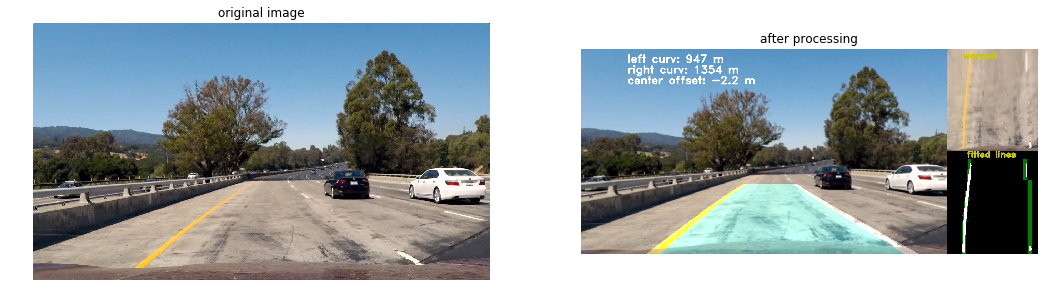

In [89]:
# we read an image
##interesting ones: 4
#6 : straight line
INDEX = 3

image = cv2.imread(test_images[INDEX])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#plt.imshow(image) 
#plt.axis('off');


p = Pipeline()
result = p.process(image)

plt.figure(figsize=(18,12))

plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.title('original image')

plt.subplot(1,2,2)
plt.imshow(result)
plt.title('after processing')
plt.axis('off');

In [87]:
! ls

README.md                     output_project_video_full.mp4
camera_cal                    project.ipynb
challenge_video.mp4           project_old.ipynb
examples                      project_video.mp4
output_images                 test_images
output_project_video.mp4      trapezoid.png
output_project_video1.mp4     writeup.md


In [ ]:
this is a test
<video controls src="output_test_video.mp4" />